In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns

import os
import glob

import pandas as pd
import numpy as np

import librosa


import progressbar

In [2]:
DATASET_PATH    = "/mnt/c/Users/andre/Desktop/ismir2018_tutorial"

METADATA_PATH   = "%s/metadata" % DATASET_PATH
AUTIO_ROOT_PATH = "%s/mp3_full" % DATASET_PATH

# Process Metadata

## Read Metadata

In [3]:
metadata = pd.read_csv("%s/annotations_final.csv" % METADATA_PATH, sep="\t")
metadata.head()

clip_id  no voice  singer  duet  plucking  hard rock  world  bongos  \
0        2         0       0     0         0          0      0       0   
1        6         0       0     0         0          0      0       0   
2       10         0       0     0         0          0      0       0   
3       11         0       0     0         0          0      0       0   
4       12         0       0     0         0          0      0       0   

   harpsichord  female singing  \
0            0               0   
1            0               0   
2            0               0   
3            0               0   
4            0               0   

                         ...                          rap  metal  hip hop  \
0                        ...                            0      0        0   
1                        ...                            0      0        0   
2                        ...                            0      0        0   
3                        ...                            0      0        0   
4                        ...                            0      0        0   

   quick  water  baroque  women  fiddle  english  \
0      0      0        0      0       0        0   
1      0      0        1      0       0        0   
2      0      0        0      0       0        0   
3      0      0        0      0       0        0   
4      0      0        0      0       0        0   

                                            mp3_path  
0  f/american_bach_soloists-j_s__bach_solo_cantat...  
1  f/american_bach_soloists-j_s__bach_solo_cantat...  
2  f/american_bach_soloists-j_s__bach_solo_cantat...  
3  f/american_bach_soloists-j_s__bach_solo_cantat...  
4  f/american_bach_soloists-j_s__bach_solo_cantat...  

[5 rows x 190 columns]

### Expand filename of Metadata

In [4]:
metadata["mp3_path"] = AUTIO_ROOT_PATH + "/" + metadata.mp3_path

## Check if files exist

In [5]:
file_exist_mask = [os.path.exists(fn) for fn in metadata.mp3_path]

In [6]:
np.sum(file_exist_mask)

1998

## Separate Ground Truth from Metadata

In [7]:
ground_truth_annotations = metadata[[c for c in metadata.columns if c not in ["clip_id", "mp3_path"]]]
ground_truth_annotations.head()

no voice  singer  duet  plucking  hard rock  world  bongos  harpsichord  \
0         0       0     0         0          0      0       0            0   
1         0       0     0         0          0      0       0            0   
2         0       0     0         0          0      0       0            0   
3         0       0     0         0          0      0       0            0   
4         0       0     0         0          0      0       0            0   

   female singing  clasical   ...     female singer  rap  metal  hip hop  \
0               0         0   ...                 0    0      0        0   
1               0         0   ...                 0    0      0        0   
2               0         0   ...                 0    0      0        0   
3               0         0   ...                 0    0      0        0   
4               0         0   ...                 0    0      0        0   

   quick  water  baroque  women  fiddle  english  
0      0      0        0      0       0        0  
1      0      0        1      0       0        0  
2      0      0        0      0       0        0  
3      0      0        0      0       0        0  
4      0      0        0      0       0        0  

[5 rows x 188 columns]

## Separate Metadata

In [8]:
metadata = metadata[["clip_id", "mp3_path"]]

# Enrich Metadata

## Add Clip-Info

In [9]:
clip_info = pd.read_csv("%s/clip_info_final.csv" % METADATA_PATH, sep="\t")
clip_info = clip_info.drop("mp3_path", axis=1)
clip_info.head()

clip_id  track_number           title                  artist  \
0        2             1  BWV54 - I Aria  American Bach Soloists   
1        6             1  BWV54 - I Aria  American Bach Soloists   
2       10             1  BWV54 - I Aria  American Bach Soloists   
3       11             1  BWV54 - I Aria  American Bach Soloists   
4       12             1  BWV54 - I Aria  American Bach Soloists   

                     album                                                url  \
0  J.S. Bach Solo Cantatas  http://www.magnatune.com/artists/albums/abs-so...   
1  J.S. Bach Solo Cantatas  http://www.magnatune.com/artists/albums/abs-so...   
2  J.S. Bach Solo Cantatas  http://www.magnatune.com/artists/albums/abs-so...   
3  J.S. Bach Solo Cantatas  http://www.magnatune.com/artists/albums/abs-so...   
4  J.S. Bach Solo Cantatas  http://www.magnatune.com/artists/albums/abs-so...   

   segmentStart  segmentEnd                                       original_url  
0            30          59  http://he3.magnatune.com/all/01--BWV54%20-%20I...  
1           146         175  http://he3.magnatune.com/all/01--BWV54%20-%20I...  
2           262         291  http://he3.magnatune.com/all/01--BWV54%20-%20I...  
3           291         320  http://he3.magnatune.com/all/01--BWV54%20-%20I...  
4           320         349  http://he3.magnatune.com/all/01--BWV54%20-%20I...

Merge with metadata

In [10]:
metadata = metadata.merge(clip_info, left_on="clip_id", right_on="clip_id", how="inner")
metadata.head()

clip_id                                           mp3_path  track_number  \
0        2  /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...             1   
1        6  /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...             1   
2       10  /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...             1   
3       11  /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...             1   
4       12  /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...             1   

            title                  artist                    album  \
0  BWV54 - I Aria  American Bach Soloists  J.S. Bach Solo Cantatas   
1  BWV54 - I Aria  American Bach Soloists  J.S. Bach Solo Cantatas   
2  BWV54 - I Aria  American Bach Soloists  J.S. Bach Solo Cantatas   
3  BWV54 - I Aria  American Bach Soloists  J.S. Bach Solo Cantatas   
4  BWV54 - I Aria  American Bach Soloists  J.S. Bach Solo Cantatas   

                                                 url  segmentStart  \
0  http://www.magnatune.com/artists/albums/abs-so...            30   
1  http://www.magnatune.com/artists/albums/abs-so...           146   
2  http://www.magnatune.com/artists/albums/abs-so...           262   
3  http://www.magnatune.com/artists/albums/abs-so...           291   
4  http://www.magnatune.com/artists/albums/abs-so...           320   

   segmentEnd                                       original_url  
0          59  http://he3.magnatune.com/all/01--BWV54%20-%20I...  
1         175  http://he3.magnatune.com/all/01--BWV54%20-%20I...  
2         291  http://he3.magnatune.com/all/01--BWV54%20-%20I...  
3         320  http://he3.magnatune.com/all/01--BWV54%20-%20I...  
4         349  http://he3.magnatune.com/all/01--BWV54%20-%20I...

# Inspect Metadata

**Plot Most frequent Tags**

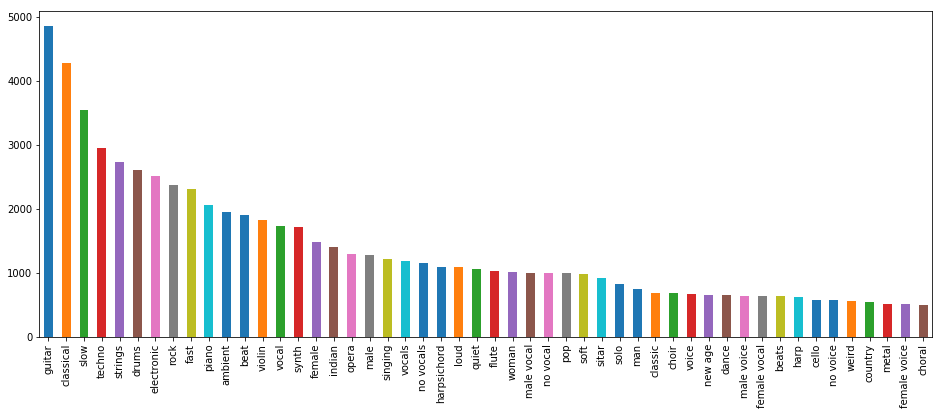

In [11]:
ground_truth_annotations.sum(axis=0).sort_values(ascending=False)[:50].plot(kind='bar', figsize=(16,6));

**Plot Co-occurrences**

* Sorted by most frequent labels
* Shows most frequent labels and how they co-occurr
* Visualization to get an overview of Tag frequencies

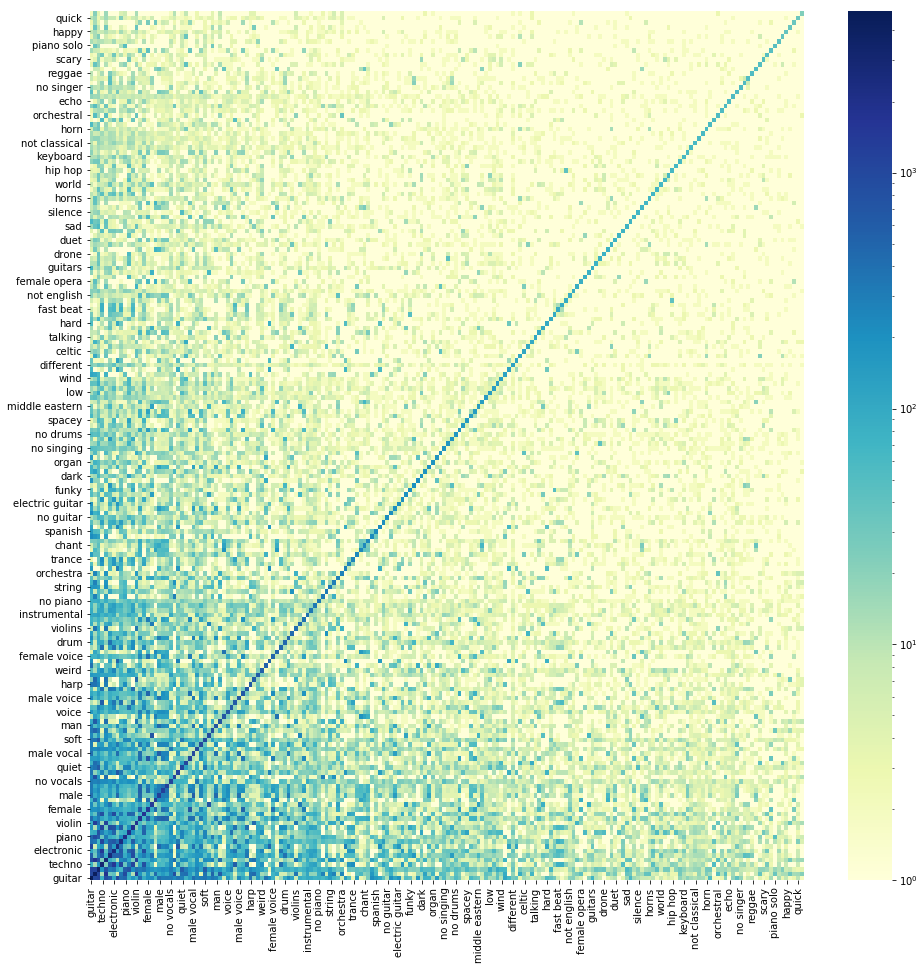

In [12]:
# calculate co-occurencies
coorc = ground_truth_annotations.T.dot(ground_truth_annotations)

# sort co-occurrence matrix
coorc = coorc.loc[coorc.max().sort_values(ascending=False).index]
coorc = coorc[coorc.max().sort_values(ascending=False).index]

# scale heat-map color encoding logarithmically
from matplotlib.colors import LogNorm

# shift by one to avoid log-domain error
coorc += 1

vmin = coorc.min().min()
vmax = coorc.max().max()

log_norm   = LogNorm(vmin=vmin, vmax=vmax)
cbar_ticks = [np.power(10, i) for i in np.arange(np.floor(np.log10(vmin)), 1+np.ceil(np.log10(vmax)))]

# plot
fig = plt.figure(figsize=(16,16))
ax = sns.heatmap(coorc, annot=False, cmap="YlGnBu", fmt='g', norm=log_norm, cbar_kws={"ticks": cbar_ticks});
ax.invert_yaxis()

## Post-Process Ground-Truth Labels

In [14]:
synonyms = [['beat', 'beats'],
            ['chant', 'chanting'],
            ['choir', 'choral'],
            ['classical', 'clasical', 'classic'],
            ['drum', 'drums'],
            ['electro', 'electronic', 'electronica', 'electric'],
            ['fast', 'fast beat', 'quick'],
            ['female', 'female singer', 'female singing', 'female vocals', 'female voice', 'woman', 'woman singing', 'women'],
            ['flute', 'flutes'],
            ['guitar', 'guitars'],
            ['hard', 'hard rock'],
            ['harpsichord', 'harpsicord'],
            ['heavy', 'heavy metal', 'metal'],
            ['horn', 'horns'],
            ['india', 'indian'],
            ['jazz', 'jazzy'],
            ['male', 'male singer', 'male vocal', 'male vocals', 'male voice', 'man', 'man singing', 'men'],
            ['no beat', 'no drums'],
            ['no singer', 'no singing', 'no vocal','no vocals', 'no voice', 'no voices', 'instrumental'],
            ['opera', 'operatic'],
            ['orchestra', 'orchestral'],
            ['quiet', 'silence'],
            ['singer', 'singing'],
            ['space', 'spacey'],
            ['string', 'strings'],
            ['synth', 'synthesizer'],
            ['violin', 'violins'],
            ['vocal', 'vocals', 'voice', 'voices'],
            ['strange', 'weird']]

**Merge synonym tags**

In [15]:
for synonym in synonyms:
    merged_values = ground_truth_annotations[synonym].sum(axis=1).clip(upper=1)
    ground_truth_annotations.drop(synonym, axis=1, inplace=True)
    ground_truth_annotations[synonym[0]] = merged_values.values

In [16]:
ground_truth_annotations.shape

(25863, 135)

# Prepare Partitions for Tutorial Examples

## Instrument Partition

In [17]:
genre = ['acoustic guitar', 'banjo', 'bass', 'bongos','cello','chimes','clarinet','classical guitar',
         'drum', 'electric guitar', 'male', 'female', 'fiddle', 'flute', 'guitar','harp','harpsichord',
         'horn','keyboard', 'lute','oboe','organ','percussion','piano','sax','sitar','string','synth',
         'trumpet','viola','violin','woodwind']

gt_example_instruments = ground_truth_annotations[genre]
gt_example_instruments.sum().sort_values(ascending=False)

guitar              4861
string              2842
drum                2698
male                2169
piano               2056
female              1996
violin              1907
synth               1734
harpsichord         1123
flute               1035
sitar                926
harp                 623
cello                575
bass                 337
classical guitar     225
electric guitar      203
banjo                194
organ                182
percussion           171
lute                 123
horn                 114
oboe                 107
sax                  101
fiddle                86
chimes                77
trumpet               75
keyboard              62
acoustic guitar       58
bongos                52
clarinet              49
woodwind              38
viola                 34
dtype: int64

Filter tracks with positive label

In [18]:
gt_example_instruments = gt_example_instruments[gt_example_instruments.sum(axis=1) > 0]

**Shrink Dataset**

Because in a tutorial time is always short, the number of tracks are reduced to reduce processing times.

* remove small classes

Original Size:

In [19]:
gt_example_instruments.shape

(16327, 32)

Remove small classes

In [20]:
gt_example_instruments = gt_example_instruments[gt_example_instruments.columns[gt_example_instruments.sum() > 100]]
gt_example_instruments = gt_example_instruments[gt_example_instruments.sum(axis=1) > 0]

In [21]:
gt_example_instruments.shape

(16253, 23)

In [22]:
gt_example_instruments.sum().sort_values(ascending=False)

guitar              4861
string              2842
drum                2698
male                2169
piano               2056
female              1996
violin              1907
synth               1734
harpsichord         1123
flute               1035
sitar                926
harp                 623
cello                575
bass                 337
classical guitar     225
electric guitar      203
banjo                194
organ                182
percussion           171
lute                 123
horn                 114
oboe                 107
sax                  101
dtype: int64

Resample classes

In [23]:
resampled_gt = []

for column in gt_example_instruments.T.sum(axis=1).sort_values(ascending=True).index.values:
    
    subset = gt_example_instruments[gt_example_instruments[column] == 1]
    resampled_gt.append(subset.sample(np.min([subset.shape[0], 120]), random_state=2))
    
gt_example_instruments = pd.concat(resampled_gt, axis=0)

In [24]:
# remove duplicate indexes (artifact of sequential sampling)
gt_example_instruments = gt_example_instruments.loc[~gt_example_instruments.index.duplicated(keep='first')].sort_index()

Final Set size

In [25]:
gt_example_instruments.shape

(2516, 23)

In [26]:
gt_example_instruments.sum().sort_values(ascending=False)

guitar              865
string              651
drum                447
violin              375
piano               367
harpsichord         265
flute               259
synth               244
male                233
harp                230
female              198
sitar               193
cello               182
classical guitar    147
bass                142
banjo               131
organ               128
electric guitar     127
percussion          124
lute                122
horn                114
oboe                107
sax                 101
dtype: int64

### Store Data

In [29]:
# Filter and store Metadata
metadata.loc[gt_example_instruments.index].to_csv("%s/ismir2018_tut_part_2_instruments_metadata.csv" % METADATA_PATH)
# store labels
gt_example_instruments.to_csv("%s/ismir2018_tut_part_2_instruments_labels.csv" % METADATA_PATH)

## Genre Partition

### Define Genre Labels

In [30]:
genre = ["blues", "classical", "country", "jazz", "pop", "rock", "techno"]

gt_example_genres = ground_truth_annotations[genre]
gt_example_genres.sum().sort_values(ascending=False)

classical    4358
techno       2954
rock         2371
pop           995
jazz          555
country       541
blues         181
dtype: int64

Filter tracks with positive label

In [31]:
gt_example_genres = gt_example_genres[gt_example_genres.sum(axis=1) > 0]
gt_example_genres.sum().sum()

11955

Remove Multi-lables instances => convert to single label/multi-class ground-truth

In [32]:
gt_example_genres = gt_example_genres[gt_example_genres[genre].sum(axis=1) == 1]
gt_example_genres.sum().sum()

9777

In [33]:
gt_example_genres.sum().sort_values(ascending=False)

classical    4303
techno       2599
rock         1758
pop           449
jazz          373
country       265
blues          30
dtype: int64

### Balance Dataset

Convert One-Hot encoded labels to String Labels

In [34]:
gt_labels = gt_example_genres.apply(lambda row: gt_example_genres.columns[np.argmax(row.values)], axis=1).to_frame("genre")
gt_labels.head()

genre
0  classical
1  classical
2  classical
4  classical
5     techno

Size of original set:

In [35]:
gt_labels.shape

(9777, 1)

Group by labels and reduce genres to max. 500 tracks

In [36]:
gt_labels = gt_labels.groupby("genre").apply(lambda x: x.sample(np.min([x.shape[0], 500]), random_state=3))
gt_labels = gt_labels.reset_index(0, drop=True)

In [37]:
# remove duplicate indexes (artifact of sequential sampling)
gt_labels = gt_labels.loc[~gt_labels.index.duplicated(keep='first')]

Size of reduced set:

In [38]:
gt_labels.shape

(2617, 1)

Re-encode using One-Hot encoding

In [39]:
gt_example_genres = pd.get_dummies(gt_labels, prefix="", prefix_sep="")

gt_example_genres.sum().sort_values(ascending=False)

techno       500
rock         500
classical    500
pop          449
jazz         373
country      265
blues         30
dtype: int64

### Store Data

In [41]:
# Filter and store Metadata
metadata.loc[gt_example_genres.index].to_csv("%s/ismir2018_tut_part_2_genre_metadata.csv" % METADATA_PATH)
# store labels
gt_example_genres.to_csv("%s/ismir2018_tut_part_2_genre_labels.csv" % METADATA_PATH)

## Mood Partition

In [42]:
moods = ['airy','calm','dark','eerie','happy','light','sad','scary','soft','strange']

gt_example_moods = ground_truth_annotations[moods]
gt_example_moods.sum().sort_values(ascending=False)

soft       985
strange    640
dark       193
calm       131
sad         72
airy        66
eerie       65
light       62
scary       49
happy       37
dtype: int64

Filter tracks with positive label

In [43]:
gt_example_moods = gt_example_moods[gt_example_moods.sum(axis=1) > 0]

In [44]:
gt_example_moods.shape

(2047, 10)

### Store Data

In [45]:
# Filter and store Metadata
metadata.loc[gt_example_moods.index].to_csv("%s/ismir2018_tut_part_2_moods_metadata.csv" % METADATA_PATH)
# store labels
gt_example_moods.to_csv("%s/ismir2018_tut_part_2_moods_labels.csv" % METADATA_PATH)

## Similarity Retrieval

In [46]:
gt_all = pd.concat([gt_example_instruments,
                    gt_example_genres,
                    gt_example_moods], sort=False)

In [47]:
gt_all.shape

(7180, 40)

Drop Duplicates and keep only indexes

In [48]:
gt_all = gt_all.loc[~gt_all.index.duplicated(keep='first')]

In [49]:
gt_all.shape

(6380, 40)

In [50]:
gt_example_similarity = gt_all.copy()

In [51]:
resampled_gt = []

for column in gt_example_similarity.T.sum(axis=1).sort_values(ascending=True).index.values:
    
    subset = gt_example_similarity[gt_example_similarity[column] == 1]
    resampled_gt.append(subset.sample(np.min([subset.shape[0], 100]), random_state=2))
    
gt_similartiy_retrieval = pd.concat(resampled_gt, axis=0)
gt_similartiy_retrieval = gt_similartiy_retrieval[gt_similartiy_retrieval.sum(axis=1) > 0]

In [52]:
# remove duplicate indexes (artifact of sequential sampling)
gt_similartiy_retrieval = gt_similartiy_retrieval.loc[~gt_similartiy_retrieval.index.duplicated(keep='first')]

In [53]:
# get original label-set
gt_similartiy_retrieval = ground_truth_annotations.loc[gt_similartiy_retrieval.index]

Size of dataset

In [54]:
gt_similartiy_retrieval.shape

(2943, 135)

Frequency distribution of Tags

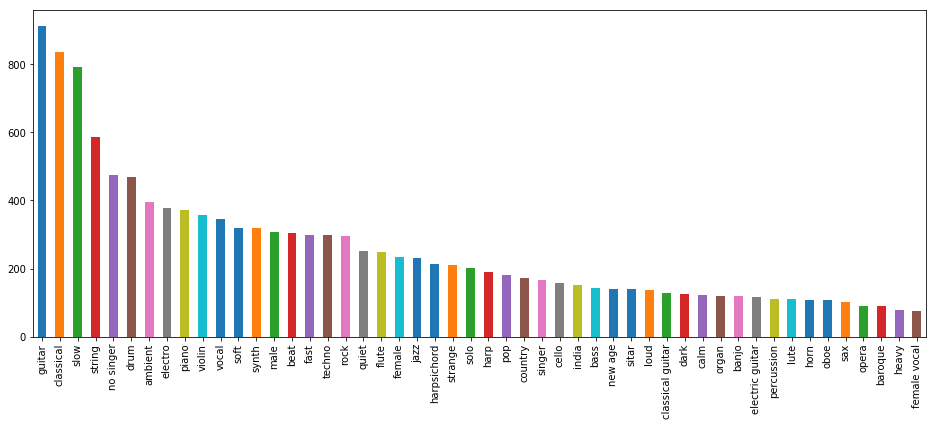

In [55]:
gt_similartiy_retrieval.sum(axis=0).sort_values(ascending=False)[:50].plot(kind='bar', figsize=(16,6));

### Store Data

In [56]:
# Filter and store Metadata
metadata.loc[gt_similartiy_retrieval.index].to_csv("%s/ismir2018_tut_part_3_similartiy_metadata.csv" % METADATA_PATH)
# store labels
gt_similartiy_retrieval.to_csv("%s/ismir2018_tut_part_3_similarity_labels.csv" % METADATA_PATH)

# Prepare Data / Extract Features

## Prepare Spectrogram Inputs for Deep Neural Networks

Final dataset size:

In [57]:
gt_all.shape

(6380, 40)

In [58]:
metadata_to_extract = metadata.loc[gt_all.index]

### Audio Metadata Analysis

Get Length of audio files (in seconds)

In [59]:
pbar = progressbar.ProgressBar(max_value=metadata_to_extract.shape[0])

audio_metadata = []

for idx, row in pbar(metadata_to_extract.iterrows()):
    
    try:
        # load audio data
        wave_data, sample_rate = librosa.core.load(row.mp3_path, 
                                                   sr    = None, 
                                                   mono  = False)

        audio_metadata.append([wave_data.shape[0], sample_rate])
        
    except Exception as e:
        print(idx)
        print(row)
        print(e)

  0% (1 of 6380) |                       | Elapsed Time: 0:00:00 ETA:   0:12:07

29
clip_id                                                        66
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    1
title           Musicalische Exequien SWV 279 Teil I_ Concert ...
artist                                     American Bach Soloists
album                     Heinrich Schutz - Musicalische Exequien
url             http://www.magnatune.com/artists/albums/abs-he...
segmentStart                                                  784
segmentEnd                                                    813
original_url    http://he3.magnatune.com/all/01--Musicalische%...
Name: 29, dtype: object
[Errno 2] No such file or directory: '/mnt/c/Users/andre/Desktop/ismir2018_tutorial/mp3_full/9/american_bach_soloists-heinrich_schutz__musicalische_exequien-01-musicalische_exequien_swv_279_teil_i_concert_in_form_einer_teutschen_begrabnismissa-784-813.mp3'


Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d84412b0>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
  0% (2 of 6380) |                       | Elapsed Time: 0:00:00 ETA:   0:45:45

43
clip_id                                                        90
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    1
title               My mistress hath a pritty thing (Tobias Hume)
artist                                         Ralph Meulenbroeks
album                                                  Gambomania
url             http://www.magnatune.com/artists/albums/meulen...
segmentStart                                                   59
segmentEnd                                                     88
original_url    http://he3.magnatune.com/all/01--My%20mistress...
Name: 43, dtype: object
[Errno 3] No such process
44
clip_id                                                        91
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    1
title               My mistress hath a pritty thing (Tobias Hume)
artist              

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
  0% (26 of 6380) |                      | Elapsed Time: 0:00:01 ETA:   0:05:43

115
clip_id                                                       224
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    1
title                                                 Action High
artist                                      Electric Frankenstein
album                                                  Sick Songs
url             http://www.magnatune.com/artists/albums/elecfr...
segmentStart                                                  117
segmentEnd                                                    146
original_url    http://he3.magnatune.com/all/01-Action%20High-...
Name: 115, dtype: object
[Errno 3] No such process
145
clip_id                                                       303
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    1
title                                           Ambient Teknology
artist           

  0% (40 of 6380) |                      | Elapsed Time: 0:00:01 ETA:   0:03:59


459
clip_id                                                      1103
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    1
title                                        Curse of the Phoenix
artist                                                     Skitzo
album                                                  Heavy Shit
url             http://www.magnatune.com/artists/albums/skitzo...
segmentStart                                                   88
segmentEnd                                                    117
original_url    http://he3.magnatune.com/all/01-Curse%20of%20t...
Name: 459, dtype: object
[Errno 2] No such file or directory: '/mnt/c/Users/andre/Desktop/ismir2018_tutorial/mp3_full/e/skitzo-heavy_shit-01-curse_of_the_phoenix-88-117.mp3'
473
clip_id                                                      1131
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number             

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff28>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
  1% (81 of 6380) |                      | Elapsed Time: 0:00:02 ETA:   0:03:11

562
clip_id                                                      1380
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    1
title                          Ehren Starks_ The Tale of Room 620
artist                                      Magnatune Compilation
album                                            New Age and Jazz
url             http://www.magnatune.com/artists/albums/magnac...
segmentStart                                                  117
segmentEnd                                                    146
original_url    http://he3.magnatune.com/all/01-Ehren%20Starks...
Name: 562, dtype: object
[Errno 3] No such process
563
clip_id                                                      1381
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    1
title                          Ehren Starks_ The Tale of Room 620
artist           

898
clip_id                                                      2055
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    1
title                                             Innocent Murmur
artist                                             Thursday Group
album                                                 First Album
url             http://www.magnatune.com/artists/albums/thursd...
segmentStart                                                   88
segmentEnd                                                    117
original_url    http://he3.magnatune.com/all/01-Innocent%20Mur...
Name: 898, dtype: object
[Errno 2] No such file or directory: '/mnt/c/Users/andre/Desktop/ismir2018_tutorial/mp3_full/f/thursday_group-first_album-01-innocent_murmur-88-117.mp3'
899
clip_id                                                      2057
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number          

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d83679e8>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
  1% (97 of 6380) |                      | Elapsed Time: 0:00:02 ETA:   0:02:52

1043
clip_id                                                      2336
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    1
title                                   L'Infidele Suite (entree)
artist                                                Paul Berget
album                                      SL Weiss on 11 Strings
url             http://www.magnatune.com/artists/albums/berget...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/01-L'Infidele%20S...
Name: 1043, dtype: object
[Errno 3] No such process


Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d8367f60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
  1% (98 of 6380) |                      | Elapsed Time: 0:00:03 ETA:   0:02:33

1078
clip_id                                                      2417
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    1
title                                           Levier D'Armement
artist                                                 Liquid Zen
album                                                Oscilloscope
url             http://www.magnatune.com/artists/albums/liquid...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/01-Levier%20D'Arm...
Name: 1078, dtype: object
[Errno 3] No such process


Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d8367b00>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
  1% (117 of 6380) |                     | Elapsed Time: 0:00:03 ETA:   0:03:03

1089
clip_id                                                      2441
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    1
title                                          Like White on Rice
artist                                             Thursday Group
album                                                  Uncle Mean
url             http://www.magnatune.com/artists/albums/thursd...
segmentStart                                                   59
segmentEnd                                                     88
original_url    http://he3.magnatune.com/all/01-Like%20White%2...
Name: 1089, dtype: object
[Errno 3] No such process
1090
clip_id                                                      2443
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    1
title                                          Like White on Rice
artist        

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
  1% (123 of 6380) |                     | Elapsed Time: 0:00:04 ETA:   0:03:53

1300
clip_id                                                      2798
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    1
title                                            Megan's Daughter
artist                                          Cheryl Ann Fulton
album                                           The Airs of Wales
url             http://www.magnatune.com/artists/albums/fulton...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/01-Megan's%20Daug...
Name: 1300, dtype: object
[Errno 3] No such process
1322
clip_id                                                      2838
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    1
title                                                 Mockingbird
artist        

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
  1% (127 of 6380) |                     | Elapsed Time: 0:00:04 ETA:   0:04:22

1350
clip_id                                                      2897
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    1
title                   More Palatino (Jan Pieterszoon Sweelinck)
artist                                                JungHae Kim
album                                            The Virginalists
url             http://www.magnatune.com/artists/albums/jhkim-...
segmentStart                                                   88
segmentEnd                                                    117
original_url    http://he3.magnatune.com/all/01-More%20Palatin...
Name: 1350, dtype: object
[Errno 3] No such process


Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff28>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
  2% (128 of 6380) |                     | Elapsed Time: 0:00:05 ETA:   0:07:43

1359
clip_id                                                      2914
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    1
title                                                       Mural
artist                                                 Stargarden
album                                  Music for Modern Listening
url             http://www.magnatune.com/artists/albums/starga...
segmentStart                                                   88
segmentEnd                                                    117
original_url    http://he3.magnatune.com/all/01-Mural-Stargard...
Name: 1359, dtype: object
[Errno 3] No such process
1368
clip_id                                                      2927
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    1
title                                               Native Spirit
artist        

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff28>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
  2% (138 of 6380) |                     | Elapsed Time: 0:00:05 ETA:   0:05:57

1427
clip_id                                                      3050
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    1
title                          Oboe Quartet in F (K370) - Allegro
artist                                           American Baroque
album                     Mozart 4 Quartets for Strings and Winds
url             http://www.magnatune.com/artists/albums/abaroq...
segmentStart                                                   88
segmentEnd                                                    117
original_url    http://he3.magnatune.com/all/01-Oboe%20Quartet...
Name: 1427, dtype: object
[Errno 3] No such process
1428
clip_id                                                      3054
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    1
title                          Oboe Quartet in F (K370) - Allegro
artist        

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff28>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
  2% (142 of 6380) |                     | Elapsed Time: 0:00:06 ETA:   0:09:21

1462
clip_id                                                      3139
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    1
title               Overture Suite from Les Fetes D'Hebe (Rameau)
artist                                           American Baroque
album                    Dances and Suites of Rameau and Couperin
url             http://www.magnatune.com/artists/albums/abaroq...
segmentStart                                                   59
segmentEnd                                                     88
original_url    http://he3.magnatune.com/all/01-Overture%20Sui...
Name: 1462, dtype: object
[Errno 3] No such process
1474
clip_id                                                      3156
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    1
title           Overture tres vite _ Menuet lent _ Air gay (Ra...
artist        

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d8367a20>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
  2% (182 of 6380) |                     | Elapsed Time: 0:00:06 ETA:   0:04:07

1550
clip_id                                                      3397
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    1
title                                           Prelude (BWV 996)
artist                                                Paul Berget
album                                       J.S. Bach on the Lute
url             http://www.magnatune.com/artists/albums/berget...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/01-Prelude%20(BWV...
Name: 1550, dtype: object
[Errno 3] No such process
1553
clip_id                                                      3402
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    1
title                                           Prelude (BWV 996)
artist        

1810
clip_id                                                      3921
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    1
title                            Raga Patdeep - Alap - Jay Kishor
artist                                                      Sitar
album                         First Congregational Church Concert
url             http://www.magnatune.com/artists/albums/kishor...
segmentStart                                                 1712
segmentEnd                                                   1741
original_url    http://he3.magnatune.com/all/01-Raga%20Patdeep...
Name: 1810, dtype: object
[Errno 2] No such file or directory: '/mnt/c/Users/andre/Desktop/ismir2018_tutorial/mp3_full/5/sitar-first_congregational_church_concert-01-raga_patdeep__alap__jay_kishor-1712-1741.mp3'
1812
clip_id                                                      3924
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d8367b00>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
  3% (194 of 6380) |                     | Elapsed Time: 0:00:07 ETA:   0:03:20

1886
clip_id                                                      4061
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    1
title                        Rosenmuller Sonata Teraz a 2 Allegro
artist                                        Ensemble Vermillian
album                                               Stolen Jewels
url             http://www.magnatune.com/artists/albums/vermil...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/01-Rosenmuller%20...
Name: 1886, dtype: object
[Errno 3] No such process
1890
clip_id                                                      4071
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    1
title                                   Ruff and Tumble (Mr Epic)
artist        

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d83672e8>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
  3% (199 of 6380) |                     | Elapsed Time: 0:00:07 ETA:   0:03:33

1930
clip_id                                                      4149
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    1
title                                                   Sanctuary
artist                                                  Etherfysh
album                                                 Box of Fysh
url             http://www.magnatune.com/artists/albums/etherf...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/01-Sanctuary-Ethe...
Name: 1930, dtype: object
[Errno 3] No such process
1952
clip_id                                                      4198
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    1
title                                                     Sanctum
artist        

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d8367a90>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
  3% (201 of 6380) |                     | Elapsed Time: 0:00:08 ETA:   0:03:40

1975
clip_id                                                      4248
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    1
title                                                     Save Me
artist                                  The Napoleon Blown Aparts
album                                                 Thrill Hype
url             http://www.magnatune.com/artists/albums/blowna...
segmentStart                                                   59
segmentEnd                                                     88
original_url    http://he3.magnatune.com/all/01-Save%20Me-The%...
Name: 1975, dtype: object
[Errno 3] No such process
1976
clip_id                                                      4251
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    1
title                                                     Save Me
artist        

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d83673c8>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
  3% (232 of 6380) |                     | Elapsed Time: 0:00:08 ETA:   0:04:37

2059
clip_id                                                      4516
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    1
title            Sonata in C major _Grand Duo_ - allegro moderato
artist                                     Seth and Maryse Carlin
album                  Schubert - Music for fortepiano four hands
url             http://www.magnatune.com/artists/albums/carlin...
segmentStart                                                   59
segmentEnd                                                     88
original_url    http://he3.magnatune.com/all/01-Sonata%20in%20...
Name: 2059, dtype: object
[Errno 3] No such process
2098
clip_id                                                      4622
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    1
title              Sonata in G minor op. 5 no. 2 adagio & allegro
artist        

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
  3% (240 of 6380) |                     | Elapsed Time: 0:00:09 ETA:   0:04:38

2446
clip_id                                                      5328
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    1
title                                       Till My Cup Runs Over
artist                                                Four Stones
album                                                La Vie Chill
url             http://www.magnatune.com/artists/albums/fourst...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/01-Till%20My%20Cu...
Name: 2446, dtype: object
[Errno 3] No such process
2452
clip_id                                                      5336
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    1
title                                                   Timeagain
artist        

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
  3% (242 of 6380) |                     | Elapsed Time: 0:00:09 ETA:   0:04:54

2461
clip_id                                                      5355
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    1
title                                                  To Malvina
artist                                             Richard Savino
album                                       Mertz - Bardic Sounds
url             http://www.magnatune.com/artists/albums/savino...
segmentStart                                                   88
segmentEnd                                                    117
original_url    http://he3.magnatune.com/all/01-To%20Malvina-R...
Name: 2461, dtype: object
[Errno 3] No such process
2483
clip_id                                                      5396
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    1
title                                                 Train Train
artist        

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff28>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
  3% (249 of 6380) |                     | Elapsed Time: 0:00:10 ETA:   0:05:01

2530
clip_id                                                      5477
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    1
title                                       Trouble fete (Gorner)
artist                                             Janine Johnson
album           Telemann Harpsichord Solos from Der Getreue Mu...
url             http://www.magnatune.com/artists/albums/jjohns...
segmentStart                                                   59
segmentEnd                                                     88
original_url    http://he3.magnatune.com/all/01-Trouble%20fete...
Name: 2530, dtype: object
[Errno 3] No such process
2531
clip_id                                                      5478
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    1
title                                       Trouble fete (Gorner)
artist        

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
  3% (254 of 6380) |                     | Elapsed Time: 0:00:10 ETA:   0:04:30

2593
clip_id                                                      5677
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    1
title                          Weichet nur betrubte Schatten Aria
artist                             Sarasa Ensemble Labelle Sylvan
album                                               Bach Cantatas
url             http://www.magnatune.com/artists/albums/sarasa...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/01-Weichet%20nur%...
Name: 2593, dtype: object
[Errno 3] No such process
2594
clip_id                                                      5678
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    1
title                          Weichet nur betrubte Schatten Aria
artist        

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d8367a58>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
  4% (257 of 6380) |                     | Elapsed Time: 0:00:10 ETA:   0:08:10

2651
clip_id                                                      5789
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    1
title                                         Wreck of the Zephyr
artist                                                  Drop Trio
album                                                  Big Dipper
url             http://www.magnatune.com/artists/albums/droptr...
segmentStart                                                   88
segmentEnd                                                    117
original_url    http://he3.magnatune.com/all/01-Wreck%20of%20t...
Name: 2651, dtype: object
[Errno 3] No such process
2658
clip_id                                                      5798
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    1
title                                               Yamato Choshi
artist        

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d83672b0>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
  4% (269 of 6380) |                     | Elapsed Time: 0:00:11 ETA:   0:06:43

2785
clip_id                                                      6051
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    2
title                                                     Allegro
artist                             Philharmonia Baroque Orchestra
album                                       Handel - Atalanta CD1
url             http://www.magnatune.com/artists/albums/pbo-at...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/02-Allegro-Philha...
Name: 2785, dtype: object
[Errno 3] No such process
2804
clip_id                                                      6102
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    2
title                      Anon _ Part II_ Virtus sancti Spiritus
artist        

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d83679b0>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
  4% (286 of 6380) |                     | Elapsed Time: 0:00:11 ETA:   0:04:47

2987
clip_id                                                      6475
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    2
title               Chansons sans paroles (1989) op. 2 Humoresque
artist                                            Gerard Satamian
album                                               Dry Fig Trees
url             http://www.magnatune.com/artists/albums/satami...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/02-Chansons%20san...
Name: 2987, dtype: object
[Errno 3] No such process
2988
clip_id                                                      6476
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    2
title               Chansons sans paroles (1989) op. 2 Humoresque
artist        

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d8367ef0>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
  4% (297 of 6380) |                     | Elapsed Time: 0:00:12 ETA:   0:04:29

3235
clip_id                                                      7146
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    2
title                        Empeza - psaltery (Sephardic Jewish)
artist                                                Tim Rayborn
album                                                       Qadim
url             http://www.magnatune.com/artists/albums/raybor...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/02-Empeza%20-%20p...
Name: 3235, dtype: object
[Errno 3] No such process
3245
clip_id                                                      7169
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    2
title                     English Suite No 2 in A Minor - Prelude
artist        

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff28>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
  4% (300 of 6380) |                     | Elapsed Time: 0:00:12 ETA:   0:04:39

3260
clip_id                                                      7197
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    2
title                                                  Eroica 2nd
artist                                       Philharmonia Baroque
album                   Beethoven Symphonies No 3 Eroica and No 8
url             http://www.magnatune.com/artists/albums/pb-ero...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/02-Eroica%202nd-P...
Name: 3260, dtype: object
[Errno 3] No such process
3262
clip_id                                                      7199
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    2
title                                                  Eroica 2nd
artist        

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff28>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
  4% (314 of 6380) |#                    | Elapsed Time: 0:00:13 ETA:   0:03:53

3340
clip_id                                                      7400
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    2
title                                               Fors souvenir
artist                                                Tim Rayborn
album                                                     Chordae
url             http://www.magnatune.com/artists/albums/raybor...
segmentStart                                                   59
segmentEnd                                                     88
original_url    http://he3.magnatune.com/all/02-Fors%20souveni...
Name: 3340, dtype: object
[Errno 3] No such process
3345
clip_id                                                      7408
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    2
title                                               Fors souvenir
artist        

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
  5% (319 of 6380) |#                    | Elapsed Time: 0:00:13 ETA:   0:04:22

3387
clip_id                                                      7496
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    2
title                                           Gag Like a Maggot
artist                                                     Skitzo
album                                                  Heavy Shit
url             http://www.magnatune.com/artists/albums/skitzo...
segmentStart                                                  117
segmentEnd                                                    146
original_url    http://he3.magnatune.com/all/02-Gag%20Like%20a...
Name: 3387, dtype: object
[Errno 3] No such process
3390
clip_id                                                      7504
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    2
title                                                      Garuda
artist        

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d83679e8>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
  5% (356 of 6380) |#                    | Elapsed Time: 0:00:14 ETA:   0:03:21

3601
clip_id                                                      7923
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    2
title                                                   Juke City
artist                                                        Jag
album                                                Four Strings
url             http://www.magnatune.com/artists/albums/jag-four/
segmentStart                                                   88
segmentEnd                                                    117
original_url    http://he3.magnatune.com/all/02-Juke%20City-Ja...
Name: 3601, dtype: object
[Errno 3] No such process
3602
clip_id                                                      7924
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    2
title                                               Just Like You
artist        

  5% (376 of 6380) |#                    | Elapsed Time: 0:00:14 ETA:   0:02:32

3949
clip_id                                                      8646
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    2
title                           Oboe Quartet in F (K370) - Adagio
artist                                           American Baroque
album                     Mozart 4 Quartets for Strings and Winds
url             http://www.magnatune.com/artists/albums/abaroq...
segmentStart                                                  175
segmentEnd                                                    204
original_url    http://he3.magnatune.com/all/02-Oboe%20Quartet...
Name: 3949, dtype: object
[Errno 2] No such file or directory: '/mnt/c/Users/andre/Desktop/ismir2018_tutorial/mp3_full/3/american_baroque-mozart_4_quartets_for_strings_and_winds-02-oboe_quartet_in_f_k370__adagio-175-204.mp3'
3973
clip_id                                                      8685
mp3_path        /mnt/c/Users/andre/Desk

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff28>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
  5% (378 of 6380) |#                    | Elapsed Time: 0:00:14 ETA:   0:02:43

4026
clip_id                                                      8798
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    2
title                       Pandolfi La Clemente Op 3 No.5 (1660)
artist                                       Music of the Spheres
album                                              The Fantastics
url             http://www.magnatune.com/artists/albums/sphere...
segmentStart                                                   59
segmentEnd                                                     88
original_url    http://he3.magnatune.com/all/02-Pandolfi%20La%...
Name: 4026, dtype: object
[Errno 3] No such process
4030
clip_id                                                      8808
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    2
title                       Pandolfi La Clemente Op 3 No.5 (1660)
artist        

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
  5% (381 of 6380) |#                    | Elapsed Time: 0:00:15 ETA:   0:03:06

4043
clip_id                                                      8831
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    2
title                    Partita Seconda in sol minore - corrente
artist                                           Vito Paternoster
album               CD2-Bach Sonatas and Partitas for solo violin
url             http://www.magnatune.com/artists/albums/patern...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/02-Partita%20Seco...
Name: 4043, dtype: object
[Errno 3] No such process
4066
clip_id                                                      8874
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    2
title                                                  perihelion
artist        

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
  6% (385 of 6380) |#                    | Elapsed Time: 0:00:15 ETA:   0:03:05

4072
clip_id                                                      8884
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    2
title                                             Phenix - Adagio
artist                                              Musica Franca
album           Corrette - Le Phenix - Les Delices de la Solitude
url             http://www.magnatune.com/artists/albums/franca...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/02-Phenix%20-%20A...
Name: 4072, dtype: object
[Errno 3] No such process
4074
clip_id                                                      8886
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    2
title                                             Phenix - Adagio
artist        

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff28>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
  6% (414 of 6380) |#                    | Elapsed Time: 0:00:16 ETA:   0:02:40

4129
clip_id                                                      8986
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    2
title                         Premier Concert - La Livri (Rameau)
artist                                              Maryse Carlin
album           Rameau - Pieces De Clavecin En Concerts - Forq...
url             http://www.magnatune.com/artists/albums/mcarli...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/02-Premier%20Conc...
Name: 4129, dtype: object
[Errno 3] No such process
4156
clip_id                                                      9038
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    2
title                                    Prinsengracht Extensions
artist        

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
  6% (415 of 6380) |#                    | Elapsed Time: 0:00:16 ETA:   0:05:45

4321
clip_id                                                      9389
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    2
title                                                  Recercar 2
artist                                                Paul Berget
album                    The Siena Manuscript on renaissance lute
url             http://www.magnatune.com/artists/albums/berget...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/02-Recercar%202-P...
Name: 4321, dtype: object
[Errno 3] No such process
4329
clip_id                                                      9404
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    2
title                                                Red Fullmoon
artist        

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
  6% (431 of 6380) |#                    | Elapsed Time: 0:00:16 ETA:   0:04:14

4513
clip_id                                                      9809
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    2
title           So grand e la peta _ Thomas Crecquillion - Val...
artist                                 The Art of the Lute Player
album                                  The Art of the Lute Player
url             http://www.magnatune.com/artists/albums/hering...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/02-So%20grand%20e...
Name: 4513, dtype: object
[Errno 3] No such process
4514
clip_id                                                      9810
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    2
title           So grand e la peta _ Thomas Crecquillion - Val...
artist        

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
  6% (441 of 6380) |#                    | Elapsed Time: 0:00:17 ETA:   0:03:50

4590
clip_id                                                     10042
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    2
title              Soneto_ amor che nel mio pensier vive et regna
artist                         Jacob Heringman and Catherine King
album                                       Luis Milan El Maestro
url             http://www.magnatune.com/artists/albums/hering...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/02-Soneto_%20amor...
Name: 4590, dtype: object
[Errno 3] No such process
4598
clip_id                                                     10059
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    2
title                                         Songs of the Harper
artist        

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff28>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
  6% (446 of 6380) |#                    | Elapsed Time: 0:00:17 ETA:   0:03:48

4627
clip_id                                                     10122
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    2
title                                               Spinning Down
artist                                                 Liquid Zen
album                                             Magic Midsummer
url             http://www.magnatune.com/artists/albums/liquid...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/02-Spinning%20Dow...
Name: 4627, dtype: object
[Errno 3] No such process
4629
clip_id                                                     10125
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    2
title                                               Spinning Down
artist        

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
  7% (451 of 6380) |#                    | Elapsed Time: 0:00:18 ETA:   0:05:47

4692
clip_id                                                     10308
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    2
title                                   Symphony of Force (Saros)
artist                                                    DJ Cary
album                                                Power Synths
url             http://www.magnatune.com/artists/albums/magnac...
segmentStart                                                   59
segmentEnd                                                     88
original_url    http://he3.magnatune.com/all/02-Symphony%20of%...
Name: 4692, dtype: object
[Errno 3] No such process
4701
clip_id                                                     10325
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    2
title                                                       Tabak
artist        

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
  7% (480 of 6380) |#                    | Elapsed Time: 0:00:18 ETA:   0:03:24

4826
clip_id                                                     10624
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    2
title                               Those great big... (memories)
artist                                                 Jackalopes
album                                             Jacksploitation
url             http://www.magnatune.com/artists/albums/jackal...
segmentStart                                                   59
segmentEnd                                                     88
original_url    http://he3.magnatune.com/all/02-Those%20great%...
Name: 4826, dtype: object
[Errno 3] No such process
4833
clip_id                                                     10648
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    2
title                                       Toccata XII cromatica
artist        

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff28>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
  7% (496 of 6380) |#                    | Elapsed Time: 0:00:19 ETA:   0:03:21

5386
clip_id                                                     11740
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    3
title                                        Badinerie (BWV 1067)
artist                                            Voices of Music
album                                        An Evening With Bach
url             http://www.magnatune.com/artists/albums/voices...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/03-Badinerie%20(B...
Name: 5386, dtype: object
[Errno 3] No such process
5388
clip_id                                                     11746
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    3
title                                   Bakfark _ Faulte d'argent
artist        

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff28>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
  7% (504 of 6380) |#                    | Elapsed Time: 0:00:19 ETA:   0:03:23

5423
clip_id                                                     11818
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    3
title                                                 Bisonpolska
artist                                             Barry Phillips
album                                                        Trad
url             http://www.magnatune.com/artists/albums/philli...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/03-Bisonpolska-Ba...
Name: 5423, dtype: object
[Errno 3] No such process
5425
clip_id                                                     11821
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    3
title                                                 Bisonpolska
artist        

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff28>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
  8% (516 of 6380) |#                    | Elapsed Time: 0:00:20 ETA:   0:03:07

5552
clip_id                                                     12081
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    3
title                  Chansons sans paroles (1989) op. 2 Romance
artist                                            Gerard Satamian
album                                               Dry Fig Trees
url             http://www.magnatune.com/artists/albums/satami...
segmentStart                                                   59
segmentEnd                                                     88
original_url    http://he3.magnatune.com/all/03-Chansons%20san...
Name: 5552, dtype: object
[Errno 3] No such process
5553
clip_id                                                     12083
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    3
title                  Chansons sans paroles (1989) op. 2 Romance
artist        

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
  8% (519 of 6380) |#                    | Elapsed Time: 0:00:20 ETA:   0:03:13

5601
clip_id                                                     12243
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    3
title           Concerto for Flute and Orchestra in G major KV...
artist                                       Philharmonia Baroque
album                                     Mozart Orchestral Works
url             http://www.magnatune.com/artists/albums/pb-moz...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/03-Concerto%20for...
Name: 5601, dtype: object
[Errno 3] No such process
5608
clip_id                                                     12253
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    3
title           Concerto for Flute and Orchestra in G major KV...
artist        

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
  8% (525 of 6380) |#                    | Elapsed Time: 0:00:20 ETA:   0:04:39

5640
clip_id                                                     12339
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    3
title                                                 Cum With Me
artist                                            Seismic Anamoly
album                                               Ramifications
url             http://www.magnatune.com/artists/albums/seismi...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/03-Cum%20With%20M...
Name: 5640, dtype: object
[Errno 3] No such process
5641
clip_id                                                     12340
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    3
title                                                 Cum With Me
artist        

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff28>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
  8% (536 of 6380) |#                    | Elapsed Time: 0:00:21 ETA:   0:05:02

5813
clip_id                                                     12758
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    3
title           Entree tres gaye des Troubadours _ Air tres ga...
artist                                       Philharmonia Baroque
album                                          Rameau and Leclair
url             http://www.magnatune.com/artists/albums/pb-ram...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/03-Entree%20tres%...
Name: 5813, dtype: object
[Errno 3] No such process
5815
clip_id                                                     12762
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    3
title           Entree tres gaye des Troubadours _ Air tres ga...
artist        

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff28>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
  8% (546 of 6380) |#                    | Elapsed Time: 0:00:21 ETA:   0:04:59

5912
clip_id                                                     12961
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    3
title              Fescobaldi Toccata VII from Libro Primo (1615)
artist                                       Music of the Spheres
album                                              The Fantastics
url             http://www.magnatune.com/artists/albums/sphere...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/03-Fescobaldi%20T...
Name: 5912, dtype: object
[Errno 3] No such process
5927
clip_id                                                     12991
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    3
title                                                  First love
artist        

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff28>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
  8% (552 of 6380) |#                    | Elapsed Time: 0:00:22 ETA:   0:05:45

5968
clip_id                                                     13080
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    3
title                                       Fuga in G (Buxtehude)
artist                                             Janine Johnson
album                                     German Keyboard Masters
url             http://www.magnatune.com/artists/albums/jjohns...
segmentStart                                                   59
segmentEnd                                                     88
original_url    http://he3.magnatune.com/all/03-Fuga%20in%20G%...
Name: 5968, dtype: object
[Errno 3] No such process
5994
clip_id                                                     13137
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    3
title                                            Good For Nothing
artist        

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
  8% (564 of 6380) |#                    | Elapsed Time: 0:00:22 ETA:   0:04:51

6148
clip_id                                                     13393
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    3
title                                 In the 60's (love was cool)
artist                                         Burnshee Thornside
album                                  The Art of Not Blending In
url             http://www.magnatune.com/artists/albums/burnsh...
segmentStart                                                   59
segmentEnd                                                     88
original_url    http://he3.magnatune.com/all/03-In%20the%2060'...
Name: 6148, dtype: object
[Errno 3] No such process


Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff28>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
  8% (565 of 6380) |#                    | Elapsed Time: 0:00:23 ETA:   0:05:29

6152
clip_id                                                     13401
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    3
title                                      In The Middle (Beight)
artist                                            Various Artists
album                          The 2007 Magnatune Records Sampler
url             http://www.magnatune.com/artists/albums/magnac...
segmentStart                                                   88
segmentEnd                                                    117
original_url    http://he3.magnatune.com/all/03-In%20The%20Mid...
Name: 6152, dtype: object
[Errno 3] No such process
6155
clip_id                                                     13406
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    3
title                                                 Inner Child
artist        

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff28>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
  8% (573 of 6380) |#                    | Elapsed Time: 0:00:23 ETA:   0:05:58

6191
clip_id                                                     13476
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    3
title                                                        Jota
artist                                             Richard Savino
album                                Murcia - Danza y Diferencias
url             http://www.magnatune.com/artists/albums/savino...
segmentStart                                                   59
segmentEnd                                                     88
original_url    http://he3.magnatune.com/all/03-Jota-Richard%2...
Name: 6191, dtype: object
[Errno 3] No such process
6197
clip_id                                                     13500
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    3
title                                          Just Like Your Mom
artist        

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff28>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
  9% (594 of 6380) |#                    | Elapsed Time: 0:00:24 ETA:   0:04:34

6270
clip_id                                                     13668
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    3
title                                                   Long Gone
artist                                            Seismic Anamoly
album                                              Dead Mans Hand
url             http://www.magnatune.com/artists/albums/seismi...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/03-Long%20Gone-Se...
Name: 6270, dtype: object
[Errno 3] No such process
6273
clip_id                                                     13671
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    3
title                                                   Long Gone
artist        

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d8367f98>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
  9% (601 of 6380) |#                    | Elapsed Time: 0:00:24 ETA:   0:04:47

6492
clip_id                                                     14125
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    3
title                                       No One Will Ever Know
artist                                               Ehren Starks
album                                           Lines Build Walls
url             http://www.magnatune.com/artists/albums/ehren-...
segmentStart                                                  117
segmentEnd                                                    146
original_url    http://he3.magnatune.com/all/03-No%20One%20Wil...
Name: 6492, dtype: object
[Errno 3] No such process
6502
clip_id                                                     14141
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    3
title                         Norine Braun - Animus (Down and In)
artist        

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d8367898>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
  9% (610 of 6380) |##                   | Elapsed Time: 0:00:25 ETA:   0:04:19

6610
clip_id                                                     14364
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    3
title                   Partita Seconda in sol minore - sarabanda
artist                                           Vito Paternoster
album               CD2-Bach Sonatas and Partitas for solo violin
url             http://www.magnatune.com/artists/albums/patern...
segmentStart                                                   59
segmentEnd                                                     88
original_url    http://he3.magnatune.com/all/03-Partita%20Seco...
Name: 6610, dtype: object
[Errno 3] No such process
6612
clip_id                                                     14367
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    3
title                   Partita Seconda in sol minore - sarabanda
artist        

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff28>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
  9% (621 of 6380) |##                   | Elapsed Time: 0:00:25 ETA:   0:04:18

6727
clip_id                                                     14618
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    3
title                            Recercar 3 (steel string guitar)
artist                                                Paul Berget
album                 The Siena Manuscript on steel string guitar
url             http://www.magnatune.com/artists/albums/berget...
segmentStart                                                   59
segmentEnd                                                     88
original_url    http://he3.magnatune.com/all/03-Recercar%203%2...
Name: 6727, dtype: object
[Errno 3] No such process
6768
clip_id                                                     14687
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    3
title                          Romance_ triste estava muy quexosa
artist        

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
  9% (626 of 6380) |##                   | Elapsed Time: 0:00:26 ETA:   0:06:22

6875
clip_id                                                     14919
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    3
title                                                       Shift
artist                                         Roots of Rebellion
album                                           The Looking Glass
url             http://www.magnatune.com/artists/albums/rootsr...
segmentStart                                                   88
segmentEnd                                                    117
original_url    http://he3.magnatune.com/all/03-Shift-Roots%20...
Name: 6875, dtype: object
[Errno 3] No such process
6882
clip_id                                                     14930
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    3
title                                                 Shivranjani
artist        

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 10% (642 of 6380) |##                   | Elapsed Time: 0:00:26 ETA:   0:05:04

6979
clip_id                                                     15230
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    3
title                       Sonata Prima in do minore - Siciliana
artist                                           Vito Paternoster
album               CD1-Bach Sonatas and Partitas for solo violin
url             http://www.magnatune.com/artists/albums/patern...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/03-Sonata%20Prima...
Name: 6979, dtype: object
[Errno 3] No such process
6981
clip_id                                                     15235
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    3
title                              Sonata Seconda A Due - Violini
artist        

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 10% (646 of 6380) |##                   | Elapsed Time: 0:00:26 ETA:   0:04:59

7047
clip_id                                                     15379
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    3
title                          Suite I in Sol maggiore - courante
artist                                           Vito Paternoster
album                                       CD1-Bach Cello Suites
url             http://www.magnatune.com/artists/albums/patern...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/03-Suite%20I%20in...
Name: 7047, dtype: object
[Errno 3] No such process


Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d8367a90>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 10% (647 of 6380) |##                   | Elapsed Time: 0:00:27 ETA:   0:05:52

7050
clip_id                                                     15385
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    3
title                         Suite III in Do maggiore - courante
artist                                           Vito Paternoster
album                                       CD2-Bach Cello Suites
url             http://www.magnatune.com/artists/albums/patern...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/03-Suite%20III%20...
Name: 7050, dtype: object
[Errno 3] No such process
7051
clip_id                                                     15387
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    3
title                         Suite III in Do maggiore - courante
artist        

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 10% (650 of 6380) |##                   | Elapsed Time: 0:00:27 ETA:   0:07:32

7064
clip_id                                                     15409
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    3
title                                Suite in d minor - Sarabande
artist                                       Hanneke van Proosdij
album                         Harpsichord suites of Chambonnieres
url             http://www.magnatune.com/artists/albums/proosd...
segmentStart                                                   59
segmentEnd                                                     88
original_url    http://he3.magnatune.com/all/03-Suite%20in%20d...
Name: 7064, dtype: object
[Errno 3] No such process
7104
clip_id                                                     15490
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    3
title                                           Symphony of Force
artist        

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 10% (658 of 6380) |##                   | Elapsed Time: 0:00:28 ETA:   0:06:45

7231
clip_id                                                     15804
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    3
title                                                 Topping Off
artist                                                Four Stones
album                                                La Vie Chill
url             http://www.magnatune.com/artists/albums/fourst...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/03-Topping%20Off-...
Name: 7231, dtype: object
[Errno 3] No such process
7254
clip_id                                                     15848
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    3
title           Triosonate fur Flute Violine und Basso - Grave...
artist        

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 10% (660 of 6380) |##                   | Elapsed Time: 0:00:28 ETA:   0:12:36

7255
clip_id                                                     15849
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    3
title           Triosonate fur Flute Violine und Basso - Grave...
artist                                       Telemann Trio Berlin
album                                        Telemann Trio Berlin
url             http://www.magnatune.com/artists/albums/telema...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/03-Triosonate%20f...
Name: 7255, dtype: object
[Errno 3] No such process
7283
clip_id                                                     15910
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    3
title                                            unknown quantity
artist        

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 10% (662 of 6380) |##                   | Elapsed Time: 0:00:29 ETA:   0:13:22

7289
clip_id                                                     15922
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    3
title                                                Unseen Facts
artist                                              Justin Bianco
album                                                    Phoenix_
url             http://www.magnatune.com/artists/albums/bianco...
segmentStart                                                   88
segmentEnd                                                    117
original_url    http://he3.magnatune.com/all/03-Unseen%20Facts...
Name: 7289, dtype: object
[Errno 3] No such process
7317
clip_id                                                     16018
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    3
title                              Vou num rio (Going on a River)
artist        

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff28>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 10% (673 of 6380) |##                   | Elapsed Time: 0:00:30 ETA:   0:08:43

7411
clip_id                                                     16219
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    4
title                                            -BWV82 - I Aria-
artist                                     American Bach Soloists
album                                     J.S. Bach Solo Cantatas
url             http://www.magnatune.com/artists/albums/abs-so...
segmentStart                                                   59
segmentEnd                                                     88
original_url    http://he3.magnatune.com/all/04--BWV82%20-%20I...
Name: 7411, dtype: object
[Errno 3] No such process
7413
clip_id                                                     16226
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    4
title                                            -BWV82 - I Aria-
artist        

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff28>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 10% (685 of 6380) |##                   | Elapsed Time: 0:00:30 ETA:   0:07:41

7538
clip_id                                                     16511
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    4
title                                          At the castle gate
artist                                            Minstrel Spirit
album                                             Enter The Woods
url             http://www.magnatune.com/artists/albums/spirit...
segmentStart                                                   88
segmentEnd                                                    117
original_url    http://he3.magnatune.com/all/04-At%20the%20cas...
Name: 7538, dtype: object
[Errno 3] No such process
7546
clip_id                                                     16535
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    4
title                                                   Autophile
artist        

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 10% (689 of 6380) |##                   | Elapsed Time: 0:00:31 ETA:   0:06:47

7565
clip_id                                                     16580
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    4
title                                Bakfark_ si grand e la pieta
artist                                            Jacob Heringman
album                                                   Black Cow
url             http://www.magnatune.com/artists/albums/hering...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/04-Bakfark_%20si%...
Name: 7565, dtype: object
[Errno 3] No such process
7586
clip_id                                                     16648
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    4
title                            Below (Ashwan-Lisa Debenedictis)
artist        

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d83678d0>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 11% (706 of 6380) |##                   | Elapsed Time: 0:00:31 ETA:   0:05:13

7802
clip_id                                                     17148
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    4
title                                                  Crawlspace
artist                                                  SoulPrint
album                                          In Spite of it All
url             http://www.magnatune.com/artists/albums/soulpr...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/04-Crawlspace-Sou...
Name: 7802, dtype: object
[Errno 3] No such process
7803
clip_id                                                     17150
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    4
title                                                  Crawlspace
artist        

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 11% (709 of 6380) |##                   | Elapsed Time: 0:00:31 ETA:   0:04:44

7841
clip_id                                                     17230
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    4
title                                                  Dear Error
artist                                         Burnshee Thornside
album                                              Rock This Moon
url             http://www.magnatune.com/artists/albums/burnsh...
segmentStart                                                   88
segmentEnd                                                    117
original_url    http://he3.magnatune.com/all/04-Dear%20Error-B...
Name: 7841, dtype: object
[Errno 3] No such process
7847
clip_id                                                     17238
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    4
title                                                     Deja vu
artist        

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 11% (745 of 6380) |##                   | Elapsed Time: 0:00:32 ETA:   0:03:06

7881
clip_id                                                     17305
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    4
title                                         Doing the the Clown
artist                                             Thursday Group
album                                                 First Album
url             http://www.magnatune.com/artists/albums/thursd...
segmentStart                                                  117
segmentEnd                                                    146
original_url    http://he3.magnatune.com/all/04-Doing%20the%20...
Name: 7881, dtype: object
[Errno 3] No such process
7882
clip_id                                                     17306
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    4
title                                         Doing the the Clown
artist        

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d8367f98>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 11% (750 of 6380) |##                   | Elapsed Time: 0:00:33 ETA:   0:03:05

8358
clip_id                                                     18330
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    4
title           Le Souvenir De Vous Me Tue (lute) (Robert Morton)
artist                                                    Asteria
album                                  Le Souvenir de Vous me Tue
url             http://www.magnatune.com/artists/albums/asteri...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/04-Le%20Souvenir%...
Name: 8358, dtype: object
[Errno 3] No such process
8364
clip_id                                                     18354
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    4
title           Les Delices de la Solitude Op. 20 - Sonata I i...
artist        

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff28>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 12% (779 of 6380) |##                   | Elapsed Time: 0:00:33 ETA:   0:02:45

8477
clip_id                                                     18575
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    4
title                                             Midnight to Six
artist                                            Burning Babylon
album                                              Stereo Mash Up
url             http://www.magnatune.com/artists/albums/babylo...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/04-Midnight%20to%...
Name: 8477, dtype: object
[Errno 3] No such process
8488
clip_id                                                     18637
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    4
title                                                   Moving On
artist        

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 12% (781 of 6380) |##                   | Elapsed Time: 0:00:34 ETA:   0:02:55

8679
clip_id                                                     18997
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    4
title                                      Pavan_ posthuma (lute)
artist                                            Jacob Heringman
album                                            Holburns Passion
url             http://www.magnatune.com/artists/albums/hering...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/04-Pavan_%20posth...
Name: 8679, dtype: object
[Errno 3] No such process
8682
clip_id                                                     19001
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    4
title                                      Pavan_ posthuma (lute)
artist        

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 12% (807 of 6380) |##                   | Elapsed Time: 0:00:34 ETA:   0:03:13

8747
clip_id                                                     19138
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    4
title                                        Prisoners of America
artist                                                     Skitzo
album                                                  Babblesick
url             http://www.magnatune.com/artists/albums/skitzo...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/04-Prisoners%20of...
Name: 8747, dtype: object
[Errno 3] No such process
8760
clip_id                                                     19161
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    4
title           Psalm 51_ Tilge Hochster meine Sunden_ I Largo...
artist        

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff28>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 12% (816 of 6380) |##                   | Elapsed Time: 0:00:35 ETA:   0:03:04

9057
clip_id                                                     19770
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    4
title                                             Sincerely Sorry
artist                                                       Curl
album                                                       Inner
url             http://www.magnatune.com/artists/albums/curl-i...
segmentStart                                                   59
segmentEnd                                                     88
original_url    http://he3.magnatune.com/all/04-Sincerely%20So...
Name: 9057, dtype: object
[Errno 3] No such process
9072
clip_id                                                     19816
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    4
title                                                  Singularia
artist        

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 12% (819 of 6380) |##                   | Elapsed Time: 0:00:35 ETA:   0:04:57

9086
clip_id                                                     19840
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    4
title                                                 soap column
artist                                                      Joram
album                                          Moments of Clarity
url             http://www.magnatune.com/artists/albums/joram-...
segmentStart                                                   88
segmentEnd                                                    117
original_url    http://he3.magnatune.com/all/04-soap%20column-...
Name: 9086, dtype: object
[Errno 3] No such process


Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff28>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 12% (820 of 6380) |##                   | Elapsed Time: 0:00:36 ETA:   0:05:14

9100
clip_id                                                     19869
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    4
title                                 Sonata 1 (Tempo di Gavotta)
artist                                           Ensemble Mirable
album                                   Triemer Six Cello Sonatas
url             http://www.magnatune.com/artists/albums/mirabl...
segmentStart                                                   59
segmentEnd                                                     88
original_url    http://he3.magnatune.com/all/04-Sonata%201%20(...
Name: 9100, dtype: object
[Errno 3] No such process
9103
clip_id                                                     19921
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    4
title                             Sonata III in d minor (Allegro)
artist        

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff28>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 12% (822 of 6380) |##                   | Elapsed Time: 0:00:36 ETA:   0:12:45

9136
clip_id                                                     20027
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    4
title                          Sonata Prima in do minore - Presto
artist                                           Vito Paternoster
album               CD1-Bach Sonatas and Partitas for solo violin
url             http://www.magnatune.com/artists/albums/patern...
segmentStart                                                   59
segmentEnd                                                     88
original_url    http://he3.magnatune.com/all/04-Sonata%20Prima...
Name: 9136, dtype: object
[Errno 3] No such process
9137
clip_id                                                     20029
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    4
title                          Sonata Prima in do minore - Presto
artist        

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d8367da0>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 13% (839 of 6380) |##                   | Elapsed Time: 0:00:37 ETA:   0:07:24

9336
clip_id                                                     20492
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    4
title                                                      Thirst
artist                                               Atomic Opera
album                                                Penguin Dust
url             http://www.magnatune.com/artists/albums/atomic...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/04-Thirst-Atomic%...
Name: 9336, dtype: object
[Errno 3] No such process
9350
clip_id                                                     20522
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    4
title                                 Tom Paul_ It's an Easy Life
artist        

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d8367da0>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 13% (861 of 6380) |##                   | Elapsed Time: 0:00:37 ETA:   0:05:11

9371
clip_id                                                     20563
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    4
title                                               Trogdorpolska
artist                                             Barry Phillips
album                                                        Trad
url             http://www.magnatune.com/artists/albums/philli...
segmentStart                                                   59
segmentEnd                                                     88
original_url    http://he3.magnatune.com/all/04-Trogdorpolska-...
Name: 9371, dtype: object
[Errno 3] No such process
9379
clip_id                                                     20579
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    4
title                                                 Turtle Spin
artist        

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 13% (863 of 6380) |##                   | Elapsed Time: 0:00:38 ETA:   0:05:16

9555
clip_id                                                     20953
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    5
title                                                -The Garden-
artist                             Philharmonia Baroque Orchestra
album                              Jake Heggie - To Hell and Back
url             http://www.magnatune.com/artists/albums/pb-heg...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/05--The%20Garden-...
Name: 9555, dtype: object
[Errno 3] No such process
9573
clip_id                                                     20988
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    5
title                                                         130
artist        

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d8367978>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 13% (868 of 6380) |##                   | Elapsed Time: 0:00:38 ETA:   0:04:18

9613
clip_id                                                     21064
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    5
title                                                      A Toye
artist                                            Jacob Heringman
album                                  Jane Pickeringes Lute Book
url             http://www.magnatune.com/artists/albums/hering...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/05-A%20Toye-Jacob...
Name: 9613, dtype: object
[Errno 3] No such process


Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 13% (869 of 6380) |##                   | Elapsed Time: 0:00:39 ETA:   0:06:10

9615
clip_id                                                     21067
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    5
title                                                     Abaddon
artist                                                    Domased
album                                                 Return Back
url             http://www.magnatune.com/artists/albums/domase...
segmentStart                                                   59
segmentEnd                                                     88
original_url    http://he3.magnatune.com/all/05-Abaddon-Domase...
Name: 9615, dtype: object
[Errno 3] No such process
9629
clip_id                                                     21097
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    5
title                                              Adam Undivided
artist        

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff28>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 13% (884 of 6380) |##                   | Elapsed Time: 0:00:39 ETA:   0:04:40

9849
clip_id                                                     21586
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    5
title                      Buxtehude Sonata IV Op. I Lento-Vivace
artist                                        Ensemble Vermillian
album                                               Stolen Jewels
url             http://www.magnatune.com/artists/albums/vermil...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/05-Buxtehude%20So...
Name: 9849, dtype: object
[Errno 3] No such process
9856
clip_id                                                     21610
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    5
title                                               By The Ganges
artist        

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff28>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 13% (888 of 6380) |##                   | Elapsed Time: 0:00:40 ETA:   0:07:52

9903
clip_id                                                     21711
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    5
title                 Chansons sans paroles (1989) op. 2 Berceuse
artist                                            Gerard Satamian
album                                               Dry Fig Trees
url             http://www.magnatune.com/artists/albums/satami...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/05-Chansons%20san...
Name: 9903, dtype: object
[Errno 3] No such process
9905
clip_id                                                     21713
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    5
title                 Chansons sans paroles (1989) op. 2 Berceuse
artist        

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d8367978>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 14% (895 of 6380) |##                   | Elapsed Time: 0:00:40 ETA:   0:06:20

9987
clip_id                                                     21907
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    5
title                                 Credo - Allegro con spirito
artist                                     American Bach Soloists
album                                       Joseph Haydn - Masses
url             http://www.magnatune.com/artists/albums/abs-ha...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/05-Credo%20-%20Al...
Name: 9987, dtype: object
[Errno 3] No such process
9989
clip_id                                                     21909
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    5
title                                              Crooked ladder
artist        

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff28>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 14% (902 of 6380) |##                   | Elapsed Time: 0:00:40 ETA:   0:05:40

10082
clip_id                                                     22092
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    5
title                       Deuxieme Concert - La Boucon (Rameau)
artist                                              Maryse Carlin
album           Rameau - Pieces De Clavecin En Concerts - Forq...
url             http://www.magnatune.com/artists/albums/mcarli...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/05-Deuxieme%20Con...
Name: 10082, dtype: object
[Errno 3] No such process
10083
clip_id                                                     22095
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    5
title                       Deuxieme Concert - La Boucon (Rameau)
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d83673c8>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 14% (914 of 6380) |###                  | Elapsed Time: 0:00:41 ETA:   0:04:30

10231
clip_id                                                     22487
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    5
title                                               Frozen garden
artist                                               Psychetropic
album                                        China radio sunshine
url             http://www.magnatune.com/artists/albums/psyche...
segmentStart                                                   59
segmentEnd                                                     88
original_url    http://he3.magnatune.com/all/05-Frozen%20garde...
Name: 10231, dtype: object
[Errno 3] No such process
10238
clip_id                                                     22497
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    5
title                                                 Frozen Love
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff28>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 14% (916 of 6380) |###                  | Elapsed Time: 0:00:41 ETA:   0:06:05

10248
clip_id                                                     22524
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    5
title                                         Gavotte - Ronacalli
artist                                              James Edwards
album                                                    Canarios
url             http://www.magnatune.com/artists/albums/edward...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/05-Gavotte%20-%20...
Name: 10248, dtype: object
[Errno 3] No such process
10252
clip_id                                                     22530
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    5
title           Gavottes _ Air pour les Pagodes _ Contredanse ...
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff28>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 14% (920 of 6380) |###                  | Elapsed Time: 0:00:42 ETA:   0:06:12

10258
clip_id                                                     22553
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    5
title                                             Giga (BWV 1004)
artist                                            Voices of Music
album                                        An Evening With Bach
url             http://www.magnatune.com/artists/albums/voices...
segmentStart                                                   59
segmentEnd                                                     88
original_url    http://he3.magnatune.com/all/05-Giga%20(BWV%20...
Name: 10258, dtype: object
[Errno 3] No such process
10272
clip_id                                                     22577
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    5
title                                                          Go
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff28>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 14% (922 of 6380) |###                  | Elapsed Time: 0:00:42 ETA:   0:07:07

10278
clip_id                                                     22606
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    5
title           Gonzalo X Ruiz - Andante Sonata for Oboe and B...
artist                                                  Magnatune
album                       Romantic Dinner Classical Compilation
url             http://www.magnatune.com/artists/albums/magnac...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/05-Gonzalo%20X%20...
Name: 10278, dtype: object
[Errno 3] No such process
10281
clip_id                                                     22611
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    5
title           Gonzalo X Ruiz - Andante Sonata for Oboe and B...
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 14% (931 of 6380) |###                  | Elapsed Time: 0:00:43 ETA:   0:06:54

10384
clip_id                                                     22809
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    5
title                                                I got it bad
artist                                  The Napoleon Blown Aparts
album                                                 Thrill Hype
url             http://www.magnatune.com/artists/albums/blowna...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/05-I%20got%20it%2...
Name: 10384, dtype: object
[Errno 3] No such process
10407
clip_id                                                     22843
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    5
title                                                I'm Troubled
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 15% (961 of 6380) |###                  | Elapsed Time: 0:00:43 ETA:   0:04:19

10501
clip_id                                                     23009
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    5
title                                                  KC rip off
artist                                                   Spinecar
album                                             Up from the mud
url             http://www.magnatune.com/artists/albums/spinec...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/05-KC%20rip%20off...
Name: 10501, dtype: object
[Errno 3] No such process
10505
clip_id                                                     23014
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    5
title                                                  KC rip off
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff28>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 15% (962 of 6380) |###                  | Elapsed Time: 0:00:44 ETA:   0:04:28

10840
clip_id                                                     23838
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    5
title                           Partia No 5 - Passacaglia (Biber)
artist                                        The Sarasa Ensemble
album                                            A Baroque Mosaic
url             http://www.magnatune.com/artists/albums/sarasa...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/05-Partia%20No%20...
Name: 10840, dtype: object
[Errno 3] No such process
10842
clip_id                                                     23842
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    5
title                           Partia No 5 - Passacaglia (Biber)
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff28>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 15% (981 of 6380) |###                  | Elapsed Time: 0:00:44 ETA:   0:03:25

10848
clip_id                                                     23851
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    5
title                      Partita Prima in mi minore - Allemanda
artist                                           Vito Paternoster
album               CD1-Bach Sonatas and Partitas for solo violin
url             http://www.magnatune.com/artists/albums/patern...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/05-Partita%20Prim...
Name: 10848, dtype: object
[Errno 3] No such process
10852
clip_id                                                     23858
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    5
title                      Partita Prima in mi minore - Allemanda
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 15% (1009 of 6380) |###                 | Elapsed Time: 0:00:45 ETA:   0:02:19

11105
clip_id                                                     24405
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    5
title                                                   Shindormo
artist                                                 Indidginus
album                                                     Seismic
url             http://www.magnatune.com/artists/albums/indidg...
segmentStart                                                   59
segmentEnd                                                     88
original_url    http://he3.magnatune.com/all/05-Shindormo-Indi...
Name: 11105, dtype: object
[Errno 3] No such process
11119
clip_id                                                     24435
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    5
title                                                  Simply Put
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d8367cc0>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 15% (1015 of 6380) |###                 | Elapsed Time: 0:00:45 ETA:   0:02:24

11308
clip_id                                                     24899
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    5
title                     Suite I in Sol maggiore - menuet I e II
artist                                           Vito Paternoster
album                                       CD1-Bach Cello Suites
url             http://www.magnatune.com/artists/albums/patern...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/05-Suite%20I%20in...
Name: 11308, dtype: object
[Errno 3] No such process


Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d83672e8>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 15% (1016 of 6380) |###                 | Elapsed Time: 0:00:46 ETA:   0:03:50

11314
clip_id                                                     24906
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    5
title                   Suite III in Do maggiore - bourree I e II
artist                                           Vito Paternoster
album                                       CD2-Bach Cello Suites
url             http://www.magnatune.com/artists/albums/patern...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/05-Suite%20III%20...
Name: 11314, dtype: object
[Errno 3] No such process
11318
clip_id                                                     24915
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    5
title                                   Suite in A minor (Sheidt)
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 15% (1019 of 6380) |###                 | Elapsed Time: 0:00:46 ETA:   0:03:40

11374
clip_id                                                     25047
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    5
title                                          Talk like a puppet
artist                                                  Processor
album                                            Are you for real
url             http://www.magnatune.com/artists/albums/proces...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/05-Talk%20like%20...
Name: 11374, dtype: object
[Errno 3] No such process
11393
clip_id                                                     25087
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    5
title                                                         Tas
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff28>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 16% (1022 of 6380) |###                 | Elapsed Time: 0:00:46 ETA:   0:05:01

11425
clip_id                                                     25157
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    5
title                                         The Leaves Be Green
artist                                               Shira Kammen
album                                                 The Almanac
url             http://www.magnatune.com/artists/albums/shira-...
segmentStart                                                   88
segmentEnd                                                    117
original_url    http://he3.magnatune.com/all/05-The%20Leaves%2...
Name: 11425, dtype: object
[Errno 3] No such process
11433
clip_id                                                     25167
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    5
title                                     The Persistence of Hope
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff28>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 16% (1028 of 6380) |###                 | Elapsed Time: 0:00:47 ETA:   0:09:51

11488
clip_id                                                     25256
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    5
title               Unaffected (Below Sleepless Mix) by OakHonour
artist                                          Lisa DeBenedictis
album                                                  Mixter One
url             http://www.magnatune.com/artists/albums/debene...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/05-Unaffected%20(...
Name: 11488, dtype: object
[Errno 3] No such process
11500
clip_id                                                     25282
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    5
title                                            Vallat fran Lima
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff28>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 16% (1044 of 6380) |###                 | Elapsed Time: 0:00:47 ETA:   0:06:29

11696
clip_id                                                     25698
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    6
title                                                 8 Symph 3rd
artist                                       Philharmonia Baroque
album                   Beethoven Symphonies No 3 Eroica and No 8
url             http://www.magnatune.com/artists/albums/pb-ero...
segmentStart                                                   88
segmentEnd                                                    117
original_url    http://he3.magnatune.com/all/06-8%20Symph%203r...
Name: 11696, dtype: object
[Errno 3] No such process
11705
clip_id                                                     25708
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    6
title                                           A Change of Heart
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 16% (1055 of 6380) |###                 | Elapsed Time: 0:00:48 ETA:   0:04:47

11827
clip_id                                                     25987
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    6
title                                                 At The Loft
artist                                                Jami Sieber
album                                                Second Sight
url             http://www.magnatune.com/artists/albums/sieber...
segmentStart                                                   59
segmentEnd                                                     88
original_url    http://he3.magnatune.com/all/06-At%20The%20Lof...
Name: 11827, dtype: object
[Errno 3] No such process
11830
clip_id                                                     25992
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    6
title                                                 At The Loft
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff28>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 16% (1062 of 6380) |###                 | Elapsed Time: 0:00:48 ETA:   0:04:23

11909
clip_id                                                     26156
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    6
title                                  Biber Sonata VI 1681 Grave
artist                                        Ensemble Vermillian
album                                               Stolen Jewels
url             http://www.magnatune.com/artists/albums/vermil...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/06-Biber%20Sonata...
Name: 11909, dtype: object
[Errno 3] No such process
11922
clip_id                                                     26193
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    6
title                                                  Borderline
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 16% (1067 of 6380) |###                 | Elapsed Time: 0:00:48 ETA:   0:04:06

11969
clip_id                                                     26275
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    6
title                 Chansons sans paroles (1989) op. 2 Serenade
artist                                            Gerard Satamian
album                                               Dry Fig Trees
url             http://www.magnatune.com/artists/albums/satami...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/06-Chansons%20san...
Name: 11969, dtype: object
[Errno 3] No such process
11970
clip_id                                                     26279
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    6
title                 Chansons sans paroles (1989) op. 2 Serenade
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 16% (1073 of 6380) |###                 | Elapsed Time: 0:00:49 ETA:   0:04:07

12008
clip_id                                                     26349
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    6
title           Concerto for Flute and Harp in C major KV299 (...
artist                                       Philharmonia Baroque
album                                     Mozart Orchestral Works
url             http://www.magnatune.com/artists/albums/pb-moz...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/06-Concerto%20for...
Name: 12008, dtype: object
[Errno 3] No such process
12012
clip_id                                                     26358
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    6
title           Concerto for Flute and Harp in C major KV299 (...
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff28>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 16% (1078 of 6380) |###                 | Elapsed Time: 0:00:49 ETA:   0:05:16

12022
clip_id                                                     26403
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    6
title                       Concerto in D-Dur - Andante (Vivaldi)
artist                                       Telemann Trio Berlin
album                                        Telemann Trio Berlin
url             http://www.magnatune.com/artists/albums/telema...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/06-Concerto%20in%...
Name: 12022, dtype: object
[Errno 3] No such process
12027
clip_id                                                     26431
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    6
title                                                 Consolation
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 17% (1093 of 6380) |###                 | Elapsed Time: 0:00:50 ETA:   0:04:52

12149
clip_id                                                     26685
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    6
title                      Deuxieme Concert - L'Agacante (Rameau)
artist                                              Maryse Carlin
album           Rameau - Pieces De Clavecin En Concerts - Forq...
url             http://www.magnatune.com/artists/albums/mcarli...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/06-Deuxieme%20Con...
Name: 12149, dtype: object
[Errno 3] No such process
12163
clip_id                                                     26731
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    6
title                                                 Die Tonight
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff28>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 17% (1104 of 6380) |###                 | Elapsed Time: 0:00:50 ETA:   0:04:31

12314
clip_id                                                     27075
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    6
title                                                  Fantasia 6
artist                                                  Ed Martin
album                                     Luis Milan - El Maestro
url             http://www.magnatune.com/artists/albums/martin...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/06-Fantasia%206-E...
Name: 12314, dtype: object
[Errno 3] No such process


Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 17% (1105 of 6380) |###                 | Elapsed Time: 0:00:51 ETA:   0:05:05

12317
clip_id                                                     27081
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    6
title                                                  Fantasia 6
artist                         Jacob Heringman and Catherine King
album                                       Luis Milan El Maestro
url             http://www.magnatune.com/artists/albums/hering...
segmentStart                                                   59
segmentEnd                                                     88
original_url    http://he3.magnatune.com/all/06-Fantasia%206-J...
Name: 12317, dtype: object
[Errno 3] No such process
12318
clip_id                                                     27082
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    6
title                                                  Fantasia 6
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 17% (1115 of 6380) |###                 | Elapsed Time: 0:00:51 ETA:   0:04:35

12488
clip_id                                                     27396
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    6
title                                                   I'm the 1
artist                                               Norine Braun
album                                                 Now and Zen
url             http://www.magnatune.com/artists/albums/braun-...
segmentStart                                                   59
segmentEnd                                                     88
original_url    http://he3.magnatune.com/all/06-I'm%20the%201-...
Name: 12488, dtype: object
[Errno 3] No such process


Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff28>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 17% (1116 of 6380) |###                 | Elapsed Time: 0:00:51 ETA:   0:05:02

12492
clip_id                                                     27403
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    6
title                                                     Immrama
artist                                                 Stellamara
album                                             Star Of The Sea
url             http://www.magnatune.com/artists/albums/stella...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/06-Immrama-Stella...
Name: 12492, dtype: object
[Errno 3] No such process
12500
clip_id                                                     27414
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    6
title                                                     Immrama
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 17% (1144 of 6380) |###                 | Elapsed Time: 0:00:52 ETA:   0:03:45

12548
clip_id                                                     27514
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    6
title                                               It's Time Now
artist                                                 The Kokoon
album                                                      Berlin
url             http://www.magnatune.com/artists/albums/kokoon...
segmentStart                                                  146
segmentEnd                                                    175
original_url    http://he3.magnatune.com/all/06-It's%20Time%20...
Name: 12548, dtype: object
[Errno 3] No such process
12577
clip_id                                                     27598
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    6
title           La Riche & Co_ Sammartini Sonata for Oboe and ...
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d8367a20>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 18% (1149 of 6380) |###                 | Elapsed Time: 0:00:52 ETA:   0:04:06

12827
clip_id                                                     28146
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    6
title                                                No president
artist                                                 Jade Leary
album                                                  Fossildawn
url             http://www.magnatune.com/artists/albums/jade-f...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/06-No%20president...
Name: 12827, dtype: object
[Errno 3] No such process
12851
clip_id                                                     28200
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    6
title                                     Nou Springeth the Sprai
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 18% (1151 of 6380) |###                 | Elapsed Time: 0:00:53 ETA:   0:03:57

12855
clip_id                                                     28219
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    6
title                                                    November
artist                                               Atomic Opera
album                                                Penguin Dust
url             http://www.magnatune.com/artists/albums/atomic...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/06-November-Atomi...
Name: 12855, dtype: object
[Errno 3] No such process
12858
clip_id                                                     28222
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    6
title                                                    November
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 18% (1153 of 6380) |###                 | Elapsed Time: 0:00:53 ETA:   0:04:43

12861
clip_id                                                     28228
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    6
title                                               Nuclear Blues
artist                                            Seismic Anamoly
album                                                 Afterburner
url             http://www.magnatune.com/artists/albums/seismi...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/06-Nuclear%20Blue...
Name: 12861, dtype: object
[Errno 3] No such process
12864
clip_id                                                     28232
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    6
title                                               Nuclear Blues
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 18% (1192 of 6380) |###                 | Elapsed Time: 0:00:54 ETA:   0:02:34

13070
clip_id                                                     28630
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    6
title                            Recercar 6 (steel string guitar)
artist                                                Paul Berget
album                 The Siena Manuscript on steel string guitar
url             http://www.magnatune.com/artists/albums/berget...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/06-Recercar%206%2...
Name: 13070, dtype: object
[Errno 3] No such process
13096
clip_id                                                     28672
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    6
title               Rigaudon Suite from Les Fetes D'Hebe (Rameau)
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff28>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 18% (1194 of 6380) |###                 | Elapsed Time: 0:00:54 ETA:   0:03:47

13282
clip_id                                                     29116
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    6
title                                             Sonata II Largo
artist                                                  Doc Rossi
album                        Demarzi-6 Sonatas for Cetra o Kitara
url             http://www.magnatune.com/artists/albums/rossi-...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/06-Sonata%20II%20...
Name: 13282, dtype: object
[Errno 3] No such process


Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d83678d0>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 18% (1195 of 6380) |###                 | Elapsed Time: 0:00:55 ETA:   0:04:13

13302
clip_id                                                     29158
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    6
title                                             Sonata La Forni
artist                                             Richard Savino
album                            Legrenzi - Venice Before Vivaldi
url             http://www.magnatune.com/artists/albums/savino...
segmentStart                                                   59
segmentEnd                                                     88
original_url    http://he3.magnatune.com/all/06-Sonata%20La%20...
Name: 13302, dtype: object
[Errno 3] No such process
13309
clip_id                                                     29180
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    6
title                        Sonata Terza in Fa maggiore - adagio
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff28>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 18% (1200 of 6380) |###                 | Elapsed Time: 0:00:55 ETA:   0:04:09

13421
clip_id                                                     29418
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    6
title                             Suite I in Sol maggiore - gigue
artist                                           Vito Paternoster
album                                       CD1-Bach Cello Suites
url             http://www.magnatune.com/artists/albums/patern...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/06-Suite%20I%20in...
Name: 13421, dtype: object
[Errno 3] No such process
13423
clip_id                                                     29420
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    6
title                            Suite III in Do maggiore - gigue
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 18% (1204 of 6380) |###                 | Elapsed Time: 0:00:56 ETA:   0:04:01

13453
clip_id                                                     29492
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    6
title                          Tall People Big Ideas (teru Remix)
artist                                                Four Stones
album                                                La Vie Chill
url             http://www.magnatune.com/artists/albums/fourst...
segmentStart                                                   88
segmentEnd                                                    117
original_url    http://he3.magnatune.com/all/06-Tall%20People%...
Name: 13453, dtype: object
[Errno 3] No such process
13454
clip_id                                                     29493
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    6
title                          Tall People Big Ideas (teru Remix)
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 18% (1212 of 6380) |###                 | Elapsed Time: 0:00:56 ETA:   0:09:34

13572
clip_id                                                     29766
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    6
title                                              Universal Girl
artist                                               Grayson Wray
album                                              Picassos Dream
url             http://www.magnatune.com/artists/albums/wray-p...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/06-Universal%20Gi...
Name: 13572, dtype: object
[Errno 3] No such process
13582
clip_id                                                     29794
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    6
title                                                     Varenka
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 19% (1214 of 6380) |###                 | Elapsed Time: 0:00:56 ETA:   0:09:36

13592
clip_id                                                     29836
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    6
title           Vito Paternoster - Suite VI in Re Magiore (JS ...
artist                                                  Magnatune
album                       Romantic Dinner Classical Compilation
url             http://www.magnatune.com/artists/albums/magnac...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/06-Vito%20Paterno...
Name: 13592, dtype: object
[Errno 3] No such process
13593
clip_id                                                     29841
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    6
title           Vito Paternoster - Suite VI in Re Magiore (JS ...
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 19% (1222 of 6380) |###                 | Elapsed Time: 0:00:57 ETA:   0:06:58

13621
clip_id                                                     29882
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    6
title                                     Waterfall (Solar Cycle)
artist                                                    DJ Cary
album                                           Downtempo Chill 2
url             http://www.magnatune.com/artists/albums/magnac...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/06-Waterfall%20(S...
Name: 13621, dtype: object
[Errno 3] No such process


Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d83672b0>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 19% (1223 of 6380) |###                 | Elapsed Time: 0:00:57 ETA:   0:07:43

13624
clip_id                                                     29888
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    6
title                                                   Waterfall
artist                                                Solar Cycle
album                                                    Sunlight
url             http://www.magnatune.com/artists/albums/solarc...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/06-Waterfall-Sola...
Name: 13624, dtype: object
[Errno 3] No such process
13666
clip_id                                                     29984
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    6
title                                                 Winter Song
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 19% (1234 of 6380) |###                 | Elapsed Time: 0:00:58 ETA:   0:06:04

13731
clip_id                                                     30113
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    7
title           -Sonata No 5 in G Major_ Presto (Thomas Gladwin)-
artist                                              Steven Devine
album                          Portrait of an English Harpsichord
url             http://www.magnatune.com/artists/albums/sdevin...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/07--Sonata%20No%2...
Name: 13731, dtype: object
[Errno 3] No such process
13766
clip_id                                                     30205
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    7
title                                            A Matter Of Time
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 19% (1240 of 6380) |###                 | Elapsed Time: 0:00:58 ETA:   0:06:29

13839
clip_id                                                     30377
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    7
title                                        Always Not Somewhere
artist                                              Jamie Janover
album                                                  Evolutions
url             http://www.magnatune.com/artists/albums/janove...
segmentStart                                                   88
segmentEnd                                                    117
original_url    http://he3.magnatune.com/all/07-Always%20Not%2...
Name: 13839, dtype: object
[Errno 3] No such process
13849
clip_id                                                     30397
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    7
title                    Amans qui vous plaignes (Pierre Guedron)
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff28>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 19% (1253 of 6380) |###                 | Elapsed Time: 0:00:59 ETA:   0:05:05

13936
clip_id                                                     30624
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    7
title            Biber_ Rosary Sonata 12 in C Major The Ascension
artist                                  Sand Craig and Dornenburg
album                                        Biber Violin Sonatas
url             http://www.magnatune.com/artists/albums/scd-bi...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/07-Biber_%20Rosar...
Name: 13936, dtype: object
[Errno 3] No such process
13950
clip_id                                                     30656
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    7
title                                                    Blizzard
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d8367a58>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 19% (1270 of 6380) |###                 | Elapsed Time: 0:00:59 ETA:   0:03:41

14057
clip_id                                                     30932
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    7
title                       Concerto in D-Dur - Allegro (Vivaldi)
artist                                       Telemann Trio Berlin
album                                        Telemann Trio Berlin
url             http://www.magnatune.com/artists/albums/telema...
segmentStart                                                   88
segmentEnd                                                    117
original_url    http://he3.magnatune.com/all/07-Concerto%20in%...
Name: 14057, dtype: object
[Errno 3] No such process
14065
clip_id                                                     30943
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    7
title           Concerto No.3 in F Major RV 293 _AUTUMN_ - All...
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d8367ac8>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 20% (1307 of 6380) |####                | Elapsed Time: 0:01:00 ETA:   0:02:46

14203
clip_id                                                     31191
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    7
title                                 Dufay Collective_ La Spagna
artist                                                  Magnatune
album                                                   Classical
url             http://www.magnatune.com/artists/albums/magnac...
segmentStart                                                   88
segmentEnd                                                    117
original_url    http://he3.magnatune.com/all/07-Dufay%20Collec...
Name: 14203, dtype: object
[Errno 3] No such process
14210
clip_id                                                     31215
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    7
title                                                  E.F. Theme
artist     

 20% (1321 of 6380) |####                | Elapsed Time: 0:01:00 ETA:   0:02:09

14458
clip_id                                                     31710
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    7
title                                                        Hate
artist                                                     Hybris
album                                             The First Words
url             http://www.magnatune.com/artists/albums/hybris...
segmentStart                                                    0
segmentEnd                                                     29
original_url      http://he3.magnatune.com/all/07-Hate-Hybris.mp3
Name: 14458, dtype: object
[Errno 2] No such file or directory: '/mnt/c/Users/andre/Desktop/ismir2018_tutorial/mp3_full/8/hybris-the_first_words-07-hate-0-29.mp3'
14493
clip_id                                                     31763
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 21% (1348 of 6380) |####                | Elapsed Time: 0:01:01 ETA:   0:01:58

14740
clip_id                                                     32313
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    7
title                                            Meaningless Word
artist                                               Atomic Opera
album                                           Alpha and Oranges
url             http://www.magnatune.com/artists/albums/atomic...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/07-Meaningless%20...
Name: 14740, dtype: object
[Errno 3] No such process
14744
clip_id                                                     32319
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    7
title                                            Meaningless Word
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff28>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 21% (1351 of 6380) |####                | Elapsed Time: 0:01:02 ETA:   0:02:24

14983
clip_id                                                     32775
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    7
title                                  Payne Trabel (Jean Mouton)
artist                                               Duo Chambure
album                               Vihuela Duets of Valderrabano
url             http://www.magnatune.com/artists/albums/chambu...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/07-Payne%20Trabel...
Name: 14983, dtype: object
[Errno 3] No such process
14991
clip_id                                                     32788
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    7
title                                                    Peaceful
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 21% (1354 of 6380) |####                | Elapsed Time: 0:01:02 ETA:   0:03:40

15002
clip_id                                                     32812
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    7
title           Prelude And Fugue No. 16 In G Minor BWV 885_ P...
artist                                         Daniel Ben Pienaar
album                            Book 2 CD2 Well-Tempered Clavier
url             http://www.magnatune.com/artists/albums/dbp-wt...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/07-Prelude%20And%...
Name: 15002, dtype: object
[Errno 3] No such process
15012
clip_id                                                     32839
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    7
title                                Prelude in C Minor (BWV 871)
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff28>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 21% (1365 of 6380) |####                | Elapsed Time: 0:01:03 ETA:   0:04:59

15088
clip_id                                                     32996
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    7
title                                Reflections (Hans Christian)
artist                                                  Magnatune
album                                              Relaxation Spa
url             http://www.magnatune.com/artists/albums/magnac...
segmentStart                                                   59
segmentEnd                                                     88
original_url    http://he3.magnatune.com/all/07-Reflections%20...
Name: 15088, dtype: object
[Errno 3] No such process


Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 21% (1366 of 6380) |####                | Elapsed Time: 0:01:03 ETA:   0:10:36

15101
clip_id                                                     33017
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    7
title            Ritournelle Suite from Les Fetes D'Hebe (Rameau)
artist                                           American Baroque
album                    Dances and Suites of Rameau and Couperin
url             http://www.magnatune.com/artists/albums/abaroq...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/07-Ritournelle%20...
Name: 15101, dtype: object
[Errno 3] No such process
15110
clip_id                                                     33030
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    7
title                                                       Rufus
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3e00590b8>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 21% (1370 of 6380) |####                | Elapsed Time: 0:01:04 ETA:   0:09:44

15142
clip_id                                                     33081
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    7
title                                           Scuttlebutt Strut
artist                                            Seismic Anamoly
album                                              Dead Mans Hand
url             http://www.magnatune.com/artists/albums/seismi...
segmentStart                                                   59
segmentEnd                                                     88
original_url    http://he3.magnatune.com/all/07-Scuttlebutt%20...
Name: 15142, dtype: object
[Errno 3] No such process
15143
clip_id                                                     33084
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    7
title                                           Scuttlebutt Strut
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff28>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 21% (1374 of 6380) |####                | Elapsed Time: 0:01:04 ETA:   0:08:57

15158
clip_id                                                     33122
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    7
title                                       Serenade for Samantha
artist                                            Seismic Anamoly
album                                               Ramifications
url             http://www.magnatune.com/artists/albums/seismi...
segmentStart                                                  117
segmentEnd                                                    146
original_url    http://he3.magnatune.com/all/07-Serenade%20for...
Name: 15158, dtype: object
[Errno 3] No such process
15159
clip_id                                                     33123
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    7
title                                       Serenade for Samantha
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3e0059400>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 21% (1384 of 6380) |####                | Elapsed Time: 0:01:05 ETA:   0:07:21

15288
clip_id                                                     33437
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    7
title                                           St. George Island
artist                                               Heavy Mellow
album                                          Acoustic Abstracts
url             http://www.magnatune.com/artists/albums/heavym...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/07-St.%20George%2...
Name: 15288, dtype: object
[Errno 3] No such process
15305
clip_id                                                     33465
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    7
title                                       Step out to the Stars
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 21% (1396 of 6380) |####                | Elapsed Time: 0:01:05 ETA:   0:06:28

15400
clip_id                                                     33735
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    7
title                                             The Good Dancer
artist                                          Lisa DeBenedictis
album                                                      Tigers
url             http://www.magnatune.com/artists/albums/debene...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/07-The%20Good%20D...
Name: 15400, dtype: object
[Errno 3] No such process
15415
clip_id                                                     33787
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    7
title           The Irish Ho-Hoane (Anon Fitzwilliam Virginals...
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff28>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 22% (1417 of 6380) |####                | Elapsed Time: 0:01:06 ETA:   0:03:59

15675
clip_id                                                     34347
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    8
title                                            -Copeuse Concon-
artist                                       The Headroom Project
album                                             Jetuton Andawai
url             http://www.magnatune.com/artists/albums/headro...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/08--Copeuse%20Con...
Name: 15675, dtype: object
[Errno 3] No such process
15676
clip_id                                                     34349
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    8
title                                            -Copeuse Concon-
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 22% (1445 of 6380) |####                | Elapsed Time: 0:01:06 ETA:   0:02:40

15699
clip_id                                                     34389
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    8
title            -Sonata No 5 in G Major Minuet (Thomas Gladwin)-
artist                                              Steven Devine
album                          Portrait of an English Harpsichord
url             http://www.magnatune.com/artists/albums/sdevin...
segmentStart                                                   59
segmentEnd                                                     88
original_url    http://he3.magnatune.com/all/08--Sonata%20No%2...
Name: 15699, dtype: object
[Errno 3] No such process
15700
clip_id                                                     34390
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    8
title            -Sonata No 5 in G Major Minuet (Thomas Gladwin)-
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff28>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 22% (1453 of 6380) |####                | Elapsed Time: 0:01:07 ETA:   0:02:31

15952
clip_id                                                     34938
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    8
title           Cancion de sibivit or suis-je bien (Adriano Wi...
artist                                               Duo Chambure
album                               Vihuela Duets of Valderrabano
url             http://www.magnatune.com/artists/albums/chambu...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/08-Cancion%20de%2...
Name: 15952, dtype: object
[Errno 3] No such process
15954
clip_id                                                     34940
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    8
title           Cancion de sibivit or suis-je bien (Adriano Wi...
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff28>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 22% (1455 of 6380) |####                | Elapsed Time: 0:01:07 ETA:   0:02:39

15955
clip_id                                                     34943
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    8
title                                                     Caprice
artist                                             Richard Savino
album                                       Mertz - Bardic Sounds
url             http://www.magnatune.com/artists/albums/savino...
segmentStart                                                   59
segmentEnd                                                     88
original_url    http://he3.magnatune.com/all/08-Caprice-Richar...
Name: 15955, dtype: object
[Errno 3] No such process
15965
clip_id                                                     34971
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    8
title                   Chansons sans paroles (1989) op. 2 Elegie
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff28>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 22% (1459 of 6380) |####                | Elapsed Time: 0:01:07 ETA:   0:02:53

16006
clip_id                                                     35071
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    8
title               Concerto in C Major - Allegro molto (Vivaldi)
artist                                        The Sarasa Ensemble
album                                            A Baroque Mosaic
url             http://www.magnatune.com/artists/albums/sarasa...
segmentStart                                                   59
segmentEnd                                                     88
original_url    http://he3.magnatune.com/all/08-Concerto%20in%...
Name: 16006, dtype: object
[Errno 3] No such process
16009
clip_id                                                     35084
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    8
title           Concerto No.3 in F Major RV 293 _AUTUMN_ - Ada...
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff28>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 23% (1473 of 6380) |####                | Elapsed Time: 0:01:08 ETA:   0:03:08

16161
clip_id                                                     35447
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    8
title                                                 Fantasia 25
artist                         Jacob Heringman and Catherine King
album                                       Luis Milan El Maestro
url             http://www.magnatune.com/artists/albums/hering...
segmentStart                                                  146
segmentEnd                                                    175
original_url    http://he3.magnatune.com/all/08-Fantasia%2025-...
Name: 16161, dtype: object
[Errno 3] No such process
16162
clip_id                                                     35449
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    8
title                                                 Fantasia 25
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff28>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 23% (1495 of 6380) |####                | Elapsed Time: 0:01:08 ETA:   0:03:24

16197
clip_id                                                     35514
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    8
title                                             Forged in Blood
artist                                            Utopia Banished
album                                   Night of the Black Wyvern
url             http://www.magnatune.com/artists/albums/utopia...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/08-Forged%20in%20...
Name: 16197, dtype: object
[Errno 3] No such process
16207
clip_id                                                     35535
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    8
title                                     Forsaken (Curcuna 10-8)
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 23% (1497 of 6380) |####                | Elapsed Time: 0:01:09 ETA:   0:03:49

16421
clip_id                                                     36056
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    8
title                                          Junior High Smiles
artist                                                     Beight
album                                              File In Rhythm
url             http://www.magnatune.com/artists/albums/beight...
segmentStart                                                   88
segmentEnd                                                    117
original_url    http://he3.magnatune.com/all/08-Junior%20High%...
Name: 16421, dtype: object
[Errno 3] No such process
16422
clip_id                                                     36057
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    8
title                                          Junior High Smiles
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff28>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 23% (1500 of 6380) |####                | Elapsed Time: 0:01:09 ETA:   0:03:45

16484
clip_id                                                     36202
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    8
title                                                   Leadville
artist                                              Mercy Machine
album                                               Mercy Machine
url             http://www.magnatune.com/artists/albums/mercy-...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/08-Leadville-Merc...
Name: 16484, dtype: object
[Errno 3] No such process
16496
clip_id                                                     36229
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    8
title                                                     Lemuria
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3e00590b8>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 23% (1526 of 6380) |####                | Elapsed Time: 0:01:10 ETA:   0:02:39

16543
clip_id                                                     36330
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    8
title                                                   Messenger
artist                                         Roots of Rebellion
album                                           The Looking Glass
url             http://www.magnatune.com/artists/albums/rootsr...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/08-Messenger-Root...
Name: 16543, dtype: object
[Errno 3] No such process
16554
clip_id                                                     36352
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    8
title                                                  Miss Anime
artist     

17065
clip_id                                                     37426
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    8
title                          Sonata II in D minor - Aria I & II
artist                                              Musica Franca
album           Corrette - Le Phenix - Les Delices de la Solitude
url             http://www.magnatune.com/artists/albums/franca...
segmentStart                                                  146
segmentEnd                                                    175
original_url    http://he3.magnatune.com/all/08-Sonata%20II%20...
Name: 17065, dtype: object
[Errno 2] No such file or directory: '/mnt/c/Users/andre/Desktop/ismir2018_tutorial/mp3_full/9/musica_franca-corrette__le_phenix__les_delices_de_la_solitude-08-sonata_ii_in_d_minor__aria_i___ii-146-175.mp3'
17066
clip_id                                                     37427
mp3_path        /mnt/c/Users

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 24% (1547 of 6380) |####                | Elapsed Time: 0:01:10 ETA:   0:02:28

17074
clip_id                                                     37478
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    8
title                         Sonata Terza in Fa maggiore - largo
artist                                           Vito Paternoster
album               CD2-Bach Sonatas and Partitas for solo violin
url             http://www.magnatune.com/artists/albums/patern...
segmentStart                                                   88
segmentEnd                                                    117
original_url    http://he3.magnatune.com/all/08-Sonata%20Terza...
Name: 17074, dtype: object
[Errno 3] No such process
17081
clip_id                                                     37490
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    8
title                      Sonata V in F Major (Allegro_Moderato)
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 24% (1551 of 6380) |####                | Elapsed Time: 0:01:11 ETA:   0:03:12

17115
clip_id                                                     37587
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    8
title                           Suite II in re minore - allemande
artist                                           Vito Paternoster
album                                       CD1-Bach Cello Suites
url             http://www.magnatune.com/artists/albums/patern...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/08-Suite%20II%20i...
Name: 17115, dtype: object
[Errno 3] No such process
17118
clip_id                                                     37590
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    8
title                           Suite II in re minore - allemande
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 24% (1553 of 6380) |####                | Elapsed Time: 0:01:11 ETA:   0:03:06

17156
clip_id                                                     37679
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    8
title                                                   Sweet Pea
artist                                             Thursday Group
album                                                 First Album
url             http://www.magnatune.com/artists/albums/thursd...
segmentStart                                                  204
segmentEnd                                                    233
original_url    http://he3.magnatune.com/all/08-Sweet%20Pea-Th...
Name: 17156, dtype: object
[Errno 3] No such process
17162
clip_id                                                     37692
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    8
title                                       Sword Dance (Routine)
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 24% (1573 of 6380) |####                | Elapsed Time: 0:01:11 ETA:   0:02:29

17454
clip_id                                                     38266
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    8
title                                     Where Has Our Love Gone
artist                                                   The Bots
album                                                       Truth
url             http://www.magnatune.com/artists/albums/bots-t...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/08-Where%20Has%20...
Name: 17454, dtype: object
[Errno 3] No such process
17481
clip_id                                                     38325
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    8
title                                                   You and I
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff28>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 24% (1576 of 6380) |####                | Elapsed Time: 0:01:12 ETA:   0:03:28

17512
clip_id                                                     38391
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    9
title           -Weinen Klagen Sorgen Zagen BWV 12_ IV Aria - ...
artist                                     American Bach Soloists
album                               J.S. Bach - Cantatas Volume V
url             http://www.magnatune.com/artists/albums/abs-ca...
segmentStart                                                   59
segmentEnd                                                     88
original_url    http://he3.magnatune.com/all/09--Weinen%20Klag...
Name: 17512, dtype: object
[Errno 3] No such process
17514
clip_id                                                     38393
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    9
title           -Weinen Klagen Sorgen Zagen BWV 12_ IV Aria - ...
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff28>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 24% (1582 of 6380) |####                | Elapsed Time: 0:01:12 ETA:   0:04:46

17597
clip_id                                                     38586
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    9
title                                    Aria di Fiorenza - Calvi
artist                                              James Edwards
album                                                    Canarios
url             http://www.magnatune.com/artists/albums/edward...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/09-Aria%20di%20Fi...
Name: 17597, dtype: object
[Errno 3] No such process
17611
clip_id                                                     38605
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    9
title                                              Art vs Process
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 24% (1587 of 6380) |####                | Elapsed Time: 0:01:13 ETA:   0:04:34

17658
clip_id                                                     38710
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    9
title                                Biber Sonata VI 1681 Gavotte
artist                                        Ensemble Vermillian
album                                               Stolen Jewels
url             http://www.magnatune.com/artists/albums/vermil...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/09-Biber%20Sonata...
Name: 17658, dtype: object
[Errno 3] No such process
17663
clip_id                                                     38719
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    9
title           Biber_ Rosary Sonata 14 in D Major The Assumpt...
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff28>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 25% (1600 of 6380) |#####               | Elapsed Time: 0:01:13 ETA:   0:03:40

17765
clip_id                                                     38966
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    9
title           Courante_ Suite In G Minor_ Le Troisieme Livre...
artist                                Ralph Rousseau Meulenbroeks
album                                             Moved By Marais
url             http://www.magnatune.com/artists/albums/meulen...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/09-Courante_%20Su...
Name: 17765, dtype: object
[Errno 3] No such process
17781
clip_id                                                     38991
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    9
title                      Da Ripa _ Benedicta es coelorum Regina
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff28>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 25% (1608 of 6380) |#####               | Elapsed Time: 0:01:14 ETA:   0:04:46

17825
clip_id                                                     39086
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    9
title                                                    Distress
artist                                                 The Wretch
album                                                  Ambulatory
url             http://www.magnatune.com/artists/albums/wretch...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/09-Distress-The%2...
Name: 17825, dtype: object
[Errno 3] No such process
17834
clip_id                                                     39118
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    9
title                                     Dosaram - tar (Persian)
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff28>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 25% (1626 of 6380) |#####               | Elapsed Time: 0:01:14 ETA:   0:03:26

17982
clip_id                                                     39427
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    9
title                                                     Hoboin'
artist                                                        Jag
album                                           Pretty Girl Blues
url             http://www.magnatune.com/artists/albums/jag-pr...
segmentStart                                                   30
segmentEnd                                                     59
original_url      http://he3.magnatune.com/all/09-Hoboin'-Jag.mp3
Name: 17982, dtype: object
[Errno 3] No such process
17984
clip_id                                                     39429
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    9
title                                                     Hoboin'
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 25% (1629 of 6380) |#####               | Elapsed Time: 0:01:14 ETA:   0:03:35

17994
clip_id                                                     39454
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    9
title                 How have I come to find I've lost your face
artist                                               Shira Kammen
album                                             Music of Waters
url             http://www.magnatune.com/artists/albums/shira-...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/09-How%20have%20I...
Name: 17994, dtype: object
[Errno 3] No such process
18004
clip_id                                                     39483
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    9
title                                                    Hukoplex
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 25% (1637 of 6380) |#####               | Elapsed Time: 0:01:15 ETA:   0:03:24

18054
clip_id                                                     39587
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    9
title                                               In The Middle
artist                                                     Beight
album                                              File In Rhythm
url             http://www.magnatune.com/artists/albums/beight...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/09-In%20The%20Mid...
Name: 18054, dtype: object
[Errno 3] No such process
18055
clip_id                                                     39588
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    9
title                                               In The Middle
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3e0059400>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 25% (1652 of 6380) |#####               | Elapsed Time: 0:01:15 ETA:   0:03:15

18223
clip_id                                                     39971
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    9
title                                                        Lost
artist                                                Emma's Mini
album                                   Beat Generation Mad Trick
url             http://www.magnatune.com/artists/albums/emmasm...
segmentStart                                                  117
segmentEnd                                                    146
original_url    http://he3.magnatune.com/all/09-Lost-Emma's%20...
Name: 18223, dtype: object
[Errno 3] No such process
18230
clip_id                                                     39994
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    9
title                                                  Lucky Star
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff28>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 26% (1665 of 6380) |#####               | Elapsed Time: 0:01:16 ETA:   0:02:57

18364
clip_id                                                     40259
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    9
title                        Obsecro te Domina (Josquin dez Prez)
artist                                               Duo Chambure
album                               Vihuela Duets of Valderrabano
url             http://www.magnatune.com/artists/albums/chambu...
segmentStart                                                   88
segmentEnd                                                    117
original_url    http://he3.magnatune.com/all/09-Obsecro%20te%2...
Name: 18364, dtype: object
[Errno 3] No such process
18379
clip_id                                                     40291
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    9
title                                                   Oj Jabuko
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 26% (1676 of 6380) |#####               | Elapsed Time: 0:01:16 ETA:   0:03:18

18465
clip_id                                                     40484
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    9
title                                                    Pixelize
artist                                               Chris Harvey
album                                              The White Sail
url             http://www.magnatune.com/artists/albums/harvey...
segmentStart                                                  175
segmentEnd                                                    204
original_url    http://he3.magnatune.com/all/09-Pixelize-Chris...
Name: 18465, dtype: object
[Errno 3] No such process
18471
clip_id                                                     40508
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    9
title           Prelude And Fugue No. 17 In A-Flat Major BWV 8...
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3e0059400>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 26% (1696 of 6380) |#####               | Elapsed Time: 0:01:17 ETA:   0:03:08

18540
clip_id                                                     40665
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    9
title                                 Ricercata MLB11 (da Milano)
artist                                            Jacob Heringman
album                                             Siena Lute Book
url             http://www.magnatune.com/artists/albums/hering...
segmentStart                                                   88
segmentEnd                                                    117
original_url    http://he3.magnatune.com/all/09-Ricercata%20ML...
Name: 18540, dtype: object
[Errno 3] No such process
18546
clip_id                                                     40676
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    9
title                                                      Ritual
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff28>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 26% (1701 of 6380) |#####               | Elapsed Time: 0:01:17 ETA:   0:02:40

18675
clip_id                                                     40985
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    9
title                                   Sonata Ottava (Uccellini)
artist                                            Altri Stromenti
album                                                   Uccellini
url             http://www.magnatune.com/artists/albums/strome...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/09-Sonata%20Ottav...
Name: 18675, dtype: object
[Errno 3] No such process
18678
clip_id                                                     40988
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    9
title                                   Sonata Ottava (Uccellini)
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff28>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 26% (1703 of 6380) |#####               | Elapsed Time: 0:01:17 ETA:   0:03:12

18681
clip_id                                                     40994
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    9
title                 Sonata Terza in Fa maggiore - allegro assai
artist                                           Vito Paternoster
album               CD2-Bach Sonatas and Partitas for solo violin
url             http://www.magnatune.com/artists/albums/patern...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/09-Sonata%20Terza...
Name: 18681, dtype: object
[Errno 3] No such process


Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3e0059198>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 26% (1704 of 6380) |#####               | Elapsed Time: 0:01:18 ETA:   0:04:04

18707
clip_id                                                     41042
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    9
title                                             Southern Sultry
artist                                              touchingGrace
album                                                Happenstance
url             http://www.magnatune.com/artists/albums/touchi...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/09-Southern%20Sul...
Name: 18707, dtype: object
[Errno 3] No such process
18712
clip_id                                                     41052
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    9
title                                             Southern Sultry
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3e00590b8>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 26% (1710 of 6380) |#####               | Elapsed Time: 0:01:18 ETA:   0:04:38

18768
clip_id                                                     41175
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    9
title                  Suite IV in Mi bemolle maggiore - courante
artist                                           Vito Paternoster
album                                       CD2-Bach Cello Suites
url             http://www.magnatune.com/artists/albums/patern...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/09-Suite%20IV%20i...
Name: 18768, dtype: object
[Errno 3] No such process
18771
clip_id                                                     41180
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    9
title                  Suite IV in Mi bemolle maggiore - courante
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff28>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 26% (1712 of 6380) |#####               | Elapsed Time: 0:01:18 ETA:   0:05:13

18780
clip_id                                                     41204
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    9
title                                                   Supasonic
artist                                                 Stargarden
album                                  Music for Modern Listening
url             http://www.magnatune.com/artists/albums/starga...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/09-Supasonic-Star...
Name: 18780, dtype: object
[Errno 3] No such process
18792
clip_id                                                     41230
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    9
title                                                   Surfacing
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3e0059400>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 27% (1723 of 6380) |#####               | Elapsed Time: 0:01:19 ETA:   0:04:36

18920
clip_id                                                     41518
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    9
title                     Triosonate in D-Dur - Largo (C.P. Bach)
artist                                       Telemann Trio Berlin
album                                        Telemann Trio Berlin
url             http://www.magnatune.com/artists/albums/telema...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/09-Triosonate%20i...
Name: 18920, dtype: object
[Errno 3] No such process
18923
clip_id                                                     41522
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    9
title                     Triosonate in D-Dur - Largo (C.P. Bach)
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 27% (1727 of 6380) |#####               | Elapsed Time: 0:01:19 ETA:   0:06:57

18943
clip_id                                                     41552
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    9
title                                                Unhappy hour
artist                                              Myles Cochran
album                                             Marginal Street
url             http://www.magnatune.com/artists/albums/myles-...
segmentStart                                                   88
segmentEnd                                                    117
original_url    http://he3.magnatune.com/all/09-Unhappy%20hour...
Name: 18943, dtype: object
[Errno 3] No such process
18960
clip_id                                                     41585
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    9
title                                                      Valley
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3e00590b8>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 27% (1743 of 6380) |#####               | Elapsed Time: 0:01:20 ETA:   0:04:04

19150
clip_id                                                     42032
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   10
title           Andante Minuet_ Spring the Ranunculus' from Ai...
artist                                                  Da Camera
album                                        A Celtic Celebration
url             http://www.magnatune.com/artists/albums/dacame...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/10-Andante%20Minu...
Name: 19150, dtype: object
[Errno 3] No such process
19157
clip_id                                                     42051
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   10
title                                         Angelus ad virginem
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff28>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 27% (1747 of 6380) |#####               | Elapsed Time: 0:01:20 ETA:   0:04:16

19193
clip_id                                                     42136
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   10
title           Benedicta es coelorum Regina _ Josquin des Pre...
artist                                 The Art of the Lute Player
album                                  The Art of the Lute Player
url             http://www.magnatune.com/artists/albums/hering...
segmentStart                                                   88
segmentEnd                                                    117
original_url    http://he3.magnatune.com/all/10-Benedicta%20es...
Name: 19193, dtype: object
[Errno 3] No such process
19195
clip_id                                                     42140
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   10
title           Benedicta es coelorum Regina _ Josquin des Pre...
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 27% (1758 of 6380) |#####               | Elapsed Time: 0:01:21 ETA:   0:03:31

19298
clip_id                                                     42406
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   10
title                                                     Dirtbag
artist                                                 Brad Sucks
album                                   I Dont Know What Im Doing
url             http://www.magnatune.com/artists/albums/bradsu...
segmentStart                                                  175
segmentEnd                                                    204
original_url    http://he3.magnatune.com/all/10-Dirtbag-Brad%2...
Name: 19298, dtype: object
[Errno 3] No such process
19335
clip_id                                                     42536
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   10
title                     English Suite No 3 in G Minor - Prelude
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3e0059400>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 27% (1767 of 6380) |#####               | Elapsed Time: 0:01:21 ETA:   0:03:42

19373
clip_id                                                     42609
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   10
title                                            Fantasia seconda
artist                                                 Paul Beier
album                                             Simone Molinaro
url             http://www.magnatune.com/artists/albums/beier-...
segmentStart                                                   88
segmentEnd                                                    117
original_url    http://he3.magnatune.com/all/10-Fantasia%20sec...
Name: 19373, dtype: object
[Errno 3] No such process


Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 27% (1768 of 6380) |#####               | Elapsed Time: 0:01:21 ETA:   0:03:58

19414
clip_id                                                     42699
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   10
title                              Folle e ben (Tarquinio Merula)
artist                                                 Jeni Melia
album                                      The Lost Art of Wooing
url             http://www.magnatune.com/artists/albums/melia-...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/10-Folle%20e%20be...
Name: 19414, dtype: object
[Errno 3] No such process
19422
clip_id                                                     42710
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   10
title                        Forets solitaires et sombres (Camus)
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3e0059400>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 28% (1788 of 6380) |#####               | Elapsed Time: 0:01:22 ETA:   0:03:38

19646
clip_id                                                     43191
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   10
title                                                   Love Song
artist                                             Richard Savino
album                                       Mertz - Bardic Sounds
url             http://www.magnatune.com/artists/albums/savino...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/10-Love%20Song-Ri...
Name: 19646, dtype: object
[Errno 3] No such process
19651
clip_id                                                     43196
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   10
title                                                   Love Song
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3e0059400>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 28% (1791 of 6380) |#####               | Elapsed Time: 0:01:22 ETA:   0:03:43

19671
clip_id                                                     43238
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   10
title                                             Make it go away
artist                                         Burnshee Thornside
album                                  The Art of Not Blending In
url             http://www.magnatune.com/artists/albums/burnsh...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/10-Make%20it%20go...
Name: 19671, dtype: object
[Errno 3] No such process
19691
clip_id                                                     43270
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   10
title                                               Mandlovu Mind
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 28% (1807 of 6380) |#####               | Elapsed Time: 0:01:23 ETA:   0:03:22

19870
clip_id                                                     43670
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   10
title                                         Pavana de Alexandre
artist                         Jacob Heringman and Catherine King
album                              Alonso Mudarra songs and solos
url             http://www.magnatune.com/artists/albums/hering...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/10-Pavana%20de%20...
Name: 19870, dtype: object
[Errno 3] No such process
19886
clip_id                                                     43699
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   10
title                                           Phat in the Whole
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 28% (1827 of 6380) |#####               | Elapsed Time: 0:01:23 ETA:   0:02:47

20093
clip_id                                                     44143
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   10
title                                                  Sidewinder
artist                                           Mountain Mirrors
album                                               Lunar Ecstasy
url             http://www.magnatune.com/artists/albums/mounta...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/10-Sidewinder-Mou...
Name: 20093, dtype: object
[Errno 3] No such process
20100
clip_id                                                     44153
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   10
title                                        Sir Watkins' Delight
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 28% (1833 of 6380) |#####               | Elapsed Time: 0:01:24 ETA:   0:02:34

20138
clip_id                                                     44229
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   10
title                           Sonata III in C major - Allemanda
artist                                              Musica Franca
album           Corrette - Le Phenix - Les Delices de la Solitude
url             http://www.magnatune.com/artists/albums/franca...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/10-Sonata%20III%2...
Name: 20138, dtype: object
[Errno 3] No such process
20140
clip_id                                                     44232
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   10
title                           Sonata III in C major - Allemanda
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 28% (1841 of 6380) |#####               | Elapsed Time: 0:01:24 ETA:   0:03:05

20171
clip_id                                                     44350
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   10
title                           Suite II in re minore - sarabande
artist                                           Vito Paternoster
album                                       CD1-Bach Cello Suites
url             http://www.magnatune.com/artists/albums/patern...
segmentStart                                                   59
segmentEnd                                                     88
original_url    http://he3.magnatune.com/all/10-Suite%20II%20i...
Name: 20171, dtype: object
[Errno 3] No such process


Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff28>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 28% (1842 of 6380) |#####               | Elapsed Time: 0:01:24 ETA:   0:03:13

20179
clip_id                                                     44364
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   10
title                 Suite IV in Mi bemolle maggiore - sarabande
artist                                           Vito Paternoster
album                                       CD2-Bach Cello Suites
url             http://www.magnatune.com/artists/albums/patern...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/10-Suite%20IV%20i...
Name: 20179, dtype: object
[Errno 3] No such process
20185
clip_id                                                     44382
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   10
title                    Suite No 2 in C minor BWV 813_ Sarabande
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff28>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 29% (1858 of 6380) |#####               | Elapsed Time: 0:01:25 ETA:   0:04:13

20186
clip_id                                                     44385
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   10
title                    Suite No 2 in C minor BWV 813_ Sarabande
artist                                     Katherine Roberts Perl
album                                     J.S. Bach French Suites
url             http://www.magnatune.com/artists/albums/kperl-...
segmentStart                                                   88
segmentEnd                                                    117
original_url    http://he3.magnatune.com/all/10-Suite%20No%202...
Name: 20186, dtype: object
[Errno 3] No such process
20190
clip_id                                                     44413
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   10
title                                        Take me to the World
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 29% (1862 of 6380) |#####               | Elapsed Time: 0:01:25 ETA:   0:04:29

20453
clip_id                                                     44938
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   11
title             11 Bagatelles for Solo Fortepiano op. 119 no. 8
artist                              Tanya Tomkins and Eric Zivian
album                             Beethoven Piano and Cello Works
url             http://www.magnatune.com/artists/albums/tomkin...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/11-11%20Bagatelle...
Name: 20453, dtype: object
[Errno 3] No such process
20458
clip_id                                                     44947
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   11
title                                    2nd Pavan (William Byrd)
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff28>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 29% (1867 of 6380) |#####               | Elapsed Time: 0:01:26 ETA:   0:04:36

20586
clip_id                                                     45218
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   11
title                                                      Bellat
artist                                             Barry Phillips
album                                                        Trad
url             http://www.magnatune.com/artists/albums/philli...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/11-Bellat-Barry%2...
Name: 20586, dtype: object
[Errno 3] No such process
20591
clip_id                                                     45241
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   11
title                                                 Bright Side
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff28>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 29% (1871 of 6380) |#####               | Elapsed Time: 0:01:26 ETA:   0:05:09

20640
clip_id                                                     45347
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   11
title            Concerto No.4 in g minor RV 297 _WINTER_ - Largo
artist                                           American Baroque
album                                 The Four Seasons by Vivaldi
url             http://www.magnatune.com/artists/albums/abaroq...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/11-Concerto%20No....
Name: 20640, dtype: object
[Errno 3] No such process
20646
clip_id                                                     45355
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   11
title                                           Convertible Girls
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff28>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 29% (1876 of 6380) |#####               | Elapsed Time: 0:01:27 ETA:   0:04:30

20687
clip_id                                                     45455
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   11
title                                                      diemos
artist                                                      Joram
album                                          Moments of Clarity
url             http://www.magnatune.com/artists/albums/joram-...
segmentStart                                                   30
segmentEnd                                                     59
original_url     http://he3.magnatune.com/all/11-diemos-Joram.mp3
Name: 20687, dtype: object
[Errno 3] No such process
20740
clip_id                                                     45593
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   11
title                                        Everything Is Heaven
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3e0059400>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 29% (1879 of 6380) |#####               | Elapsed Time: 0:01:27 ETA:   0:04:25

20776
clip_id                                                     45695
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   11
title                                                    Gallarda
artist                         Jacob Heringman and Catherine King
album                              Alonso Mudarra songs and solos
url             http://www.magnatune.com/artists/albums/hering...
segmentStart                                                   59
segmentEnd                                                     88
original_url    http://he3.magnatune.com/all/11-Gallarda-Jacob...
Name: 20776, dtype: object
[Errno 3] No such process
20800
clip_id                                                     45738
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   11
title                                                       Grace
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff28>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 29% (1882 of 6380) |#####               | Elapsed Time: 0:01:27 ETA:   0:04:48

20810
clip_id                                                     45772
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   11
title                               He Is Leaving Us (blue.m rmx)
artist                                                    Domased
album                                                   Selection
url             http://www.magnatune.com/artists/albums/domase...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/11-He%20Is%20Leav...
Name: 20810, dtype: object
[Errno 3] No such process
20831
clip_id                                                     45820
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   11
title                                          How the story goes
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 29% (1900 of 6380) |#####               | Elapsed Time: 0:01:28 ETA:   0:04:36

20988
clip_id                                                     46142
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   11
title                                  Menuets 1 and 2 (BWV 1007)
artist                                                Paul Berget
album                                       J.S. Bach on the Lute
url             http://www.magnatune.com/artists/albums/berget...
segmentStart                                                   59
segmentEnd                                                     88
original_url    http://he3.magnatune.com/all/11-Menuets%201%20...
Name: 20988, dtype: object
[Errno 3] No such process
20995
clip_id                                                     46154
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   11
title                  Miskolc Felol Hidegen Fuj a Szel (Hungary)
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3e0059128>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 29% (1909 of 6380) |#####               | Elapsed Time: 0:01:28 ETA:   0:04:02

21118
clip_id                                                     46368
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   11
title                                                   Outerlude
artist                           Jamie Janover and Michael Masley
album                                      All Strings Considered
url             http://www.magnatune.com/artists/albums/masley...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/11-Outerlude-Jami...
Name: 21118, dtype: object
[Errno 3] No such process
21119
clip_id                                                     46369
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   11
title                                                   Outerlude
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 30% (1939 of 6380) |######              | Elapsed Time: 0:01:29 ETA:   0:03:16

21242
clip_id                                                     46625
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   11
title              Rigaudons Suite from Les Fetes D'Hebe (Rameau)
artist                                           American Baroque
album                    Dances and Suites of Rameau and Couperin
url             http://www.magnatune.com/artists/albums/abaroq...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/11-Rigaudons%20Su...
Name: 21242, dtype: object
[Errno 3] No such process
21266
clip_id                                                     46685
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   11
title           Rossingnolet - Canzone Francese a quattro di T...
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff28>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 30% (1942 of 6380) |######              | Elapsed Time: 0:01:29 ETA:   0:02:37

21334
clip_id                                                     46825
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   11
title                           Sonata III in C major - Sarabanda
artist                                              Musica Franca
album           Corrette - Le Phenix - Les Delices de la Solitude
url             http://www.magnatune.com/artists/albums/franca...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/11-Sonata%20III%2...
Name: 21334, dtype: object
[Errno 3] No such process
21336
clip_id                                                     46832
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   11
title                                            Sonata III Largo
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 30% (1945 of 6380) |######              | Elapsed Time: 0:01:30 ETA:   0:02:37

21365
clip_id                                                     46934
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   11
title                       Suite II in re minore - menuet I e II
artist                                           Vito Paternoster
album                                       CD1-Bach Cello Suites
url             http://www.magnatune.com/artists/albums/patern...
segmentStart                                                   59
segmentEnd                                                     88
original_url    http://he3.magnatune.com/all/11-Suite%20II%20i...
Name: 21365, dtype: object
[Errno 3] No such process
21366
clip_id                                                     46935
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   11
title                       Suite II in re minore - menuet I e II
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 30% (1972 of 6380) |######              | Elapsed Time: 0:01:30 ETA:   0:02:18

21374
clip_id                                                     46947
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   11
title            Suite IV in Mi bemolle maggiore - bourree I e II
artist                                           Vito Paternoster
album                                       CD2-Bach Cello Suites
url             http://www.magnatune.com/artists/albums/patern...
segmentStart                                                   59
segmentEnd                                                     88
original_url    http://he3.magnatune.com/all/11-Suite%20IV%20i...
Name: 21374, dtype: object
[Errno 3] No such process
21375
clip_id                                                     46948
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   11
title            Suite IV in Mi bemolle maggiore - bourree I e II
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 30% (1975 of 6380) |######              | Elapsed Time: 0:01:30 ETA:   0:02:29

21677
clip_id                                                     47631
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   12
title                                     Ballin' the Jack (trad)
artist                                                        Jag
album                                         Cypress Grove Blues
url             http://www.magnatune.com/artists/albums/jag-cy...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/12-Ballin'%20the%...
Name: 21677, dtype: object
[Errno 3] No such process
21684
clip_id                                                     47644
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   12
title                                                        Barn
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 31% (1981 of 6380) |######              | Elapsed Time: 0:01:31 ETA:   0:02:50

21722
clip_id                                                     47718
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   12
title                       Buxtehude Sonata II Op I Lento-Vivace
artist                                        Ensemble Vermillian
album                                               Stolen Jewels
url             http://www.magnatune.com/artists/albums/vermil...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/12-Buxtehude%20So...
Name: 21722, dtype: object
[Errno 3] No such process
21725
clip_id                                                     47721
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   12
title                       Buxtehude Sonata II Op I Lento-Vivace
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 31% (1987 of 6380) |######              | Elapsed Time: 0:01:31 ETA:   0:03:25

21775
clip_id                                                     47824
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   12
title                                De Fuenllana _ Primero kyrie
artist                                            Jacob Heringman
album                              Josquin des Prez Lute Settings
url             http://www.magnatune.com/artists/albums/hering...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/12-De%20Fuenllana...
Name: 21775, dtype: object
[Errno 3] No such process
21785
clip_id                                                     47855
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   12
title                                                  Double Axe
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3e00590b8>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 31% (2004 of 6380) |######              | Elapsed Time: 0:01:32 ETA:   0:02:44

21964
clip_id                                                     48237
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   12
title                                         Kein Artz (BWV 103)
artist                                            Voices of Music
album                                        An Evening With Bach
url             http://www.magnatune.com/artists/albums/voices...
segmentStart                                                   59
segmentEnd                                                     88
original_url    http://he3.magnatune.com/all/12-Kein%20Artz%20...
Name: 21964, dtype: object
[Errno 3] No such process
21969
clip_id                                                     48248
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   12
title                                        La Leona (Uccellini)
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff28>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 31% (2019 of 6380) |######              | Elapsed Time: 0:01:32 ETA:   0:04:16

21985
clip_id                                                     48313
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   12
title                  Loure Suite from Les Fetes D'Hebe (Rameau)
artist                                           American Baroque
album                    Dances and Suites of Rameau and Couperin
url             http://www.magnatune.com/artists/albums/abaroq...
segmentStart                                                   59
segmentEnd                                                     88
original_url    http://he3.magnatune.com/all/12-Loure%20Suite%...
Name: 21985, dtype: object
[Errno 3] No such process
21986
clip_id                                                     48314
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   12
title                  Loure Suite from Les Fetes D'Hebe (Rameau)
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff28>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 31% (2022 of 6380) |######              | Elapsed Time: 0:01:33 ETA:   0:03:23

22151
clip_id                                                     48702
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   12
title                                                      Putrid
artist                                                  SoulPrint
album                                          In Spite of it All
url             http://www.magnatune.com/artists/albums/soulpr...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/12-Putrid-SoulPri...
Name: 22151, dtype: object
[Errno 3] No such process
22153
clip_id                                                     48707
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   12
title                                                      Putrid
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3e0059198>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 31% (2031 of 6380) |######              | Elapsed Time: 0:01:33 ETA:   0:03:10

22242
clip_id                                                     48905
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   12
title                                          Sonata 3 (Allegro)
artist                                           Ensemble Mirable
album                                   Triemer Six Cello Sonatas
url             http://www.magnatune.com/artists/albums/mirabl...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/12-Sonata%203%20(...
Name: 22242, dtype: object
[Errno 3] No such process
22244
clip_id                                                     48909
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   12
title                                          Sonata 3 (Allegro)
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff28>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 31% (2033 of 6380) |######              | Elapsed Time: 0:01:33 ETA:   0:03:25

22250
clip_id                                                     48921
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   12
title                                         Sonata III Grazioso
artist                                                  Doc Rossi
album                        Demarzi-6 Sonatas for Cetra o Kitara
url             http://www.magnatune.com/artists/albums/rossi-...
segmentStart                                                   59
segmentEnd                                                     88
original_url    http://he3.magnatune.com/all/12-Sonata%20III%2...
Name: 22250, dtype: object
[Errno 3] No such process
22278
clip_id                                                     49016
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   12
title                               Suite II in re minore - gigue
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff28>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 31% (2035 of 6380) |######              | Elapsed Time: 0:01:34 ETA:   0:04:47

22288
clip_id                                                     49043
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   12
title                      Suite_ Sarabande (Kreysing the Yonger)
artist                                             Janine Johnson
album           Telemann Harpsichord Solos from Der Getreue Mu...
url             http://www.magnatune.com/artists/albums/jjohns...
segmentStart                                                   88
segmentEnd                                                    117
original_url    http://he3.magnatune.com/all/12-Suite_%20Sarab...
Name: 22288, dtype: object
[Errno 3] No such process
22300
clip_id                                                     49073
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   12
title                                                      System
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff28>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 32% (2043 of 6380) |######              | Elapsed Time: 0:01:34 ETA:   0:04:15

22349
clip_id                                                     49214
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   12
title                                                  Toccata II
artist                                                 Paul Beier
album                                        Alessandro Piccinini
url             http://www.magnatune.com/artists/albums/beier-...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/12-Toccata%20II-P...
Name: 22349, dtype: object
[Errno 3] No such process
22353
clip_id                                                     49218
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   12
title                                                  Toccata II
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3e0059400>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 32% (2068 of 6380) |######              | Elapsed Time: 0:01:35 ETA:   0:03:17

22439
clip_id                                                     49390
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   12
title                             Wreck of the Zephyr (Drop Trio)
artist                                            Various Artists
album                              South by Southwest Compilation
url             http://www.magnatune.com/artists/albums/magnac...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/12-Wreck%20of%20t...
Name: 22439, dtype: object
[Errno 3] No such process
22446
clip_id                                                     49405
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   12
title                                            Yendote a Buscar
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3e00590b8>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 32% (2073 of 6380) |######              | Elapsed Time: 0:01:35 ETA:   0:03:38

22648
clip_id                                                     49899
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   13
title           Fantasia que contrahaze la harpa en la manera ...
artist                         Jacob Heringman and Catherine King
album                              Alonso Mudarra songs and solos
url             http://www.magnatune.com/artists/albums/hering...
segmentStart                                                   59
segmentEnd                                                     88
original_url    http://he3.magnatune.com/all/13-Fantasia%20que...
Name: 22648, dtype: object
[Errno 3] No such process
22651
clip_id                                                     49926
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   13
title                                                  Fantiullen
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3e0059400>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 32% (2076 of 6380) |######              | Elapsed Time: 0:01:36 ETA:   0:03:33

22713
clip_id                                                     50067
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   13
title                                                   Immersion
artist                                                Jesse Manno
album                                                 Sea Spirits
url             http://www.magnatune.com/artists/albums/manno-...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/13-Immersion-Jess...
Name: 22713, dtype: object
[Errno 3] No such process
22715
clip_id                                                     50069
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   13
title                                                   Immersion
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3e0059400>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 32% (2082 of 6380) |######              | Elapsed Time: 0:01:36 ETA:   0:03:19

22755
clip_id                                                     50145
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   13
title           Le Relevailles_ Le Cinqieme Livre De Pieces De...
artist                                Ralph Rousseau Meulenbroeks
album                                             Moved By Marais
url             http://www.magnatune.com/artists/albums/meulen...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/13-Le%20Relevaill...
Name: 22755, dtype: object
[Errno 3] No such process
22762
clip_id                                                     50157
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   13
title                                              Long Ride Home
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 32% (2098 of 6380) |######              | Elapsed Time: 0:01:36 ETA:   0:02:55

22911
clip_id                                                     50571
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   13
title                                                     Senhaja
artist                                            Burning Babylon
album                                              Stereo Mash Up
url             http://www.magnatune.com/artists/albums/babylo...
segmentStart                                                   88
segmentEnd                                                    117
original_url    http://he3.magnatune.com/all/13-Senhaja-Burnin...
Name: 22911, dtype: object
[Errno 3] No such process
22912
clip_id                                                     50572
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   13
title                                                     Senhaja
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3e00590b8>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 33% (2106 of 6380) |######              | Elapsed Time: 0:01:37 ETA:   0:04:04

22946
clip_id                                                     50641
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   13
title                                        Sonata in Dm (gigue)
artist                                                Paul Berget
album                                      SL Weiss on 11 Strings
url             http://www.magnatune.com/artists/albums/berget...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/13-Sonata%20in%20...
Name: 22946, dtype: object
[Errno 3] No such process
22948
clip_id                                                     50644
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   13
title                          Sonata IV in B-flat major - Adagio
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 33% (2108 of 6380) |######              | Elapsed Time: 0:01:37 ETA:   0:04:23

22949
clip_id                                                     50645
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   13
title                          Sonata IV in B-flat major - Adagio
artist                                              Musica Franca
album           Corrette - Le Phenix - Les Delices de la Solitude
url             http://www.magnatune.com/artists/albums/franca...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/13-Sonata%20IV%20...
Name: 22949, dtype: object
[Errno 3] No such process
22955
clip_id                                                     50671
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   13
title                         Sonata Seconda in re minore - Grave
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3e00590b8>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 33% (2117 of 6380) |######              | Elapsed Time: 0:01:38 ETA:   0:03:51

23061
clip_id                                                     50926
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   13
title                                          The Sword of Truth
artist                                              Justin Bianco
album                                                    Phoenix_
url             http://www.magnatune.com/artists/albums/bianco...
segmentStart                                                   88
segmentEnd                                                    117
original_url    http://he3.magnatune.com/all/13-The%20Sword%20...
Name: 23061, dtype: object
[Errno 3] No such process
23062
clip_id                                                     50927
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   13
title                                          The Sword of Truth
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 33% (2128 of 6380) |######              | Elapsed Time: 0:01:38 ETA:   0:03:26

23158
clip_id                                                     51158
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   14
title                            Below Linda Barker Mix by Ashwan
artist                                          Lisa DeBenedictis
album                                                  Mixter One
url             http://www.magnatune.com/artists/albums/debene...
segmentStart                                                   59
segmentEnd                                                     88
original_url    http://he3.magnatune.com/all/14-Below%20Linda%...
Name: 23158, dtype: object
[Errno 3] No such process
23159
clip_id                                                     51159
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   14
title                            Below Linda Barker Mix by Ashwan
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 33% (2132 of 6380) |######              | Elapsed Time: 0:01:39 ETA:   0:04:34

23191
clip_id                                                     51258
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   14
title                               De Fuenllana _ Postrero kyrie
artist                                            Jacob Heringman
album                              Josquin des Prez Lute Settings
url             http://www.magnatune.com/artists/albums/hering...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/14-De%20Fuenllana...
Name: 23191, dtype: object
[Errno 3] No such process
23213
clip_id                                                     51358
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   14
title                                                 Fantasia 26
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff28>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 33% (2135 of 6380) |######              | Elapsed Time: 0:01:39 ETA:   0:05:14

23218
clip_id                                                     51366
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   14
title                                   Fantasia XVIII (de Rippe)
artist                                              Edward Martin
album                       Art of the Lute in Renaissance France
url             http://www.magnatune.com/artists/albums/martin...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/14-Fantasia%20XVI...
Name: 23218, dtype: object
[Errno 3] No such process
23219
clip_id                                                     51368
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   14
title                                   Fantasia XVIII (de Rippe)
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3e0059128>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 33% (2137 of 6380) |######              | Elapsed Time: 0:01:39 ETA:   0:05:04

23223
clip_id                                                     51383
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   14
title                         Fifth Suite - La Rameau (Forqueray)
artist                                              Maryse Carlin
album           Rameau - Pieces De Clavecin En Concerts - Forq...
url             http://www.magnatune.com/artists/albums/mcarli...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/14-Fifth%20Suite%...
Name: 23223, dtype: object
[Errno 3] No such process


Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 33% (2138 of 6380) |######              | Elapsed Time: 0:01:40 ETA:   0:06:49

23252
clip_id                                                     51437
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   14
title                                 Galliard to the same (lute)
artist                                            Jacob Heringman
album                                            Holburns Passion
url             http://www.magnatune.com/artists/albums/hering...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/14-Galliard%20to%...
Name: 23252, dtype: object
[Errno 3] No such process


Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff28>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 33% (2139 of 6380) |######              | Elapsed Time: 0:01:40 ETA:   0:07:42

23255
clip_id                                                     51442
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   14
title                                                      Gavota
artist                                             Richard Savino
album                                Murcia - Danza y Diferencias
url             http://www.magnatune.com/artists/albums/savino...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/14-Gavota-Richard...
Name: 23255, dtype: object
[Errno 3] No such process
23261
clip_id                                                     51455
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   14
title                                                  Goin' Down
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3e0059400>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 33% (2143 of 6380) |######              | Elapsed Time: 0:01:41 ETA:   0:11:09

23287
clip_id                                                     51527
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   14
title           Jacob Heringman_ My Lord Willoughbies Welcom H...
artist                                                  Magnatune
album                                                   Classical
url             http://www.magnatune.com/artists/albums/magnac...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/14-Jacob%20Hering...
Name: 23287, dtype: object
[Errno 3] No such process


Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3e0059128>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 33% (2144 of 6380) |######              | Elapsed Time: 0:01:41 ETA:   0:13:42

23311
clip_id                                                     51583
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   14
title                                             Move the Clouds
artist                                               Norine Braun
album                                                 Now and Zen
url             http://www.magnatune.com/artists/albums/braun-...
segmentStart                                                   88
segmentEnd                                                    117
original_url    http://he3.magnatune.com/all/14-Move%20the%20C...
Name: 23311, dtype: object
[Errno 3] No such process
23340
clip_id                                                     51634
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   14
title                                               Nottamun Town
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 33% (2162 of 6380) |######              | Elapsed Time: 0:01:41 ETA:   0:05:47

23503
clip_id                                                     52047
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   14
title                                    Suite in G major - Gigue
artist                                       Hanneke van Proosdij
album                         Harpsichord suites of Chambonnieres
url             http://www.magnatune.com/artists/albums/proosd...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/14-Suite%20in%20G...
Name: 23503, dtype: object
[Errno 3] No such process
23512
clip_id                                                     52083
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   14
title                                Suite V in do minore - fugue
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3e00590b8>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 34% (2181 of 6380) |######              | Elapsed Time: 0:01:42 ETA:   0:05:05

23535
clip_id                                                     52177
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   14
title                                            The Welsh Ground
artist                                          Cheryl Ann Fulton
album                                           The Airs of Wales
url             http://www.magnatune.com/artists/albums/fulton...
segmentStart                                                   59
segmentEnd                                                     88
original_url    http://he3.magnatune.com/all/14-The%20Welsh%20...
Name: 23535, dtype: object
[Errno 3] No such process
23544
clip_id                                                     52190
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   14
title                          Thursday Group_ Like White on Rice
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3e0059198>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 34% (2183 of 6380) |######              | Elapsed Time: 0:01:43 ETA:   0:03:42

23658
clip_id                                                     52438
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   15
title                                              Ben che'l ciel
artist                          Edward Martin and William Bastian
album                                           Virtues and Vices
url             http://www.magnatune.com/artists/albums/martin...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/15-Ben%20che'l%20...
Name: 23658, dtype: object
[Errno 3] No such process
23663
clip_id                                                     52458
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   15
title                                  Branle de Poitou (premier)
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 34% (2191 of 6380) |######              | Elapsed Time: 0:01:43 ETA:   0:03:01

23691
clip_id                                                     52515
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   15
title            Come again sweeet love doth now invite (Dowland)
artist                                               La Primavera
album                                   English Renaissance Music
url             http://www.magnatune.com/artists/albums/primav...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/15-Come%20again%2...
Name: 23691, dtype: object
[Errno 3] No such process
23706
clip_id                                                     52563
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   15
title           Cuckoo Remix (feat Alex Myla on guitar) by Rud...
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff28>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 34% (2194 of 6380) |######              | Elapsed Time: 0:01:43 ETA:   0:03:24

23722
clip_id                                                     52590
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   15
title                                      Drive-in saturday nite
artist                                                 Jackalopes
album                                             Jacksploitation
url             http://www.magnatune.com/artists/albums/jackal...
segmentStart                                                   88
segmentEnd                                                    117
original_url    http://he3.magnatune.com/all/15-Drive-in%20sat...
Name: 23722, dtype: object
[Errno 3] No such process
23734
clip_id                                                     52632
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   15
title                                                En el vettem
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 34% (2207 of 6380) |######              | Elapsed Time: 0:01:44 ETA:   0:03:40

23800
clip_id                                                     52826
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   15
title                           Liebster Jesu mein Veriangen Aria
artist                             Sarasa Ensemble Labelle Sylvan
album                                               Bach Cantatas
url             http://www.magnatune.com/artists/albums/sarasa...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/15-Liebster%20Jes...
Name: 23800, dtype: object
[Errno 3] No such process
23805
clip_id                                                     52835
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   15
title                                                   Long Walk
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3e00590b8>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 34% (2225 of 6380) |######              | Elapsed Time: 0:01:44 ETA:   0:02:54

23905
clip_id                                                     53069
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   15
title                                                 Recercar 15
artist                                                Paul Berget
album                    The Siena Manuscript on renaissance lute
url             http://www.magnatune.com/artists/albums/berget...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/15-Recercar%2015-...
Name: 23905, dtype: object
[Errno 3] No such process


Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3e00590b8>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 34% (2226 of 6380) |######              | Elapsed Time: 0:01:45 ETA:   0:03:33

23914
clip_id                                                     53084
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   15
title                              Ricercar ottavo 56 (da Modena)
artist                                            Jacob Heringman
album                                             Siena Lute Book
url             http://www.magnatune.com/artists/albums/hering...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/15-Ricercar%20ott...
Name: 23914, dtype: object
[Errno 3] No such process
23915
clip_id                                                     53085
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   15
title                              Ricercar ottavo 56 (da Modena)
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 35% (2236 of 6380) |#######             | Elapsed Time: 0:01:45 ETA:   0:03:15

23994
clip_id                                                     53288
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   15
title                           Suite VI in Re magiore - courante
artist                                           Vito Paternoster
album                                       CD1-Bach Cello Suites
url             http://www.magnatune.com/artists/albums/patern...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/15-Suite%20VI%20i...
Name: 23994, dtype: object
[Errno 3] No such process
24005
clip_id                                                     53345
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   15
title                                                Thrill bound
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 35% (2244 of 6380) |#######             | Elapsed Time: 0:01:46 ETA:   0:02:56

24068
clip_id                                                     53484
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   16
title                           Almain_ the night watch (Bandora)
artist                                            Jacob Heringman
album                                            Holburns Passion
url             http://www.magnatune.com/artists/albums/hering...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/16-Almain_%20the%...
Name: 24068, dtype: object
[Errno 3] No such process
24071
clip_id                                                     53492
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   16
title                                                   Ambicious
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 35% (2262 of 6380) |#######             | Elapsed Time: 0:01:46 ETA:   0:03:22

24118
clip_id                                                     53586
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   16
title                                 Chris Juergenson_ Prospects
artist                                      Magnatune Compilation
album                                            New Age and Jazz
url             http://www.magnatune.com/artists/albums/magnac...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/16-Chris%20Juerge...
Name: 24118, dtype: object
[Errno 3] No such process
24127
clip_id                                                     53631
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   16
title                                               Done Me Wrong
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff28>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 35% (2270 of 6380) |#######             | Elapsed Time: 0:01:46 ETA:   0:03:13

24240
clip_id                                                     53994
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   16
title                 Sonata IV in B-flat major - Bruit de chasse
artist                                              Musica Franca
album           Corrette - Le Phenix - Les Delices de la Solitude
url             http://www.magnatune.com/artists/albums/franca...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/16-Sonata%20IV%20...
Name: 24240, dtype: object
[Errno 3] No such process
24241
clip_id                                                     53995
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   16
title                 Sonata IV in B-flat major - Bruit de chasse
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff28>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 35% (2272 of 6380) |#######             | Elapsed Time: 0:01:47 ETA:   0:03:10

24244
clip_id                                                     53998
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   16
title                                            Sonata IV Minuet
artist                                                  Doc Rossi
album                        Demarzi-6 Sonatas for Cetra o Kitara
url             http://www.magnatune.com/artists/albums/rossi-...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/16-Sonata%20IV%20...
Name: 24244, dtype: object
[Errno 3] No such process
24246
clip_id                                                     54000
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   16
title                                            Sonata IV Minuet
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3e00590b8>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 35% (2289 of 6380) |#######             | Elapsed Time: 0:01:47 ETA:   0:02:47

24340
clip_id                                                     54245
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   17
title           -Sonata No 2 in A Major_ Allegro Assai (Joseph...
artist                                              Steven Devine
album                          Portrait of an English Harpsichord
url             http://www.magnatune.com/artists/albums/sdevin...
segmentStart                                                   88
segmentEnd                                                    117
original_url    http://he3.magnatune.com/all/17--Sonata%20No%2...
Name: 24340, dtype: object
[Errno 3] No such process
24346
clip_id                                                     54269
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   17
title                                         Almaine (Anonymous)
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 35% (2291 of 6380) |#######             | Elapsed Time: 0:01:48 ETA:   0:03:06

24349
clip_id                                                     54278
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   17
title                               Aria_ Custodite o dolci sogni
artist                             Philharmonia Baroque Orchestra
album                                       Handel - Atalanta CD2
url             http://www.magnatune.com/artists/albums/pbo-at...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/17-Aria_%20Custod...
Name: 24349, dtype: object
[Errno 3] No such process
24357
clip_id                                                     54289
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   17
title                                           Bakfark_ fantasia
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 36% (2301 of 6380) |#######             | Elapsed Time: 0:01:48 ETA:   0:02:52

24429
clip_id                                                     54483
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   17
title                                                  Horne-pipe
artist                                            Jacob Heringman
album                                  Jane Pickeringes Lute Book
url             http://www.magnatune.com/artists/albums/hering...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/17-Horne-pipe-Jac...
Name: 24429, dtype: object
[Errno 3] No such process


Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 36% (2302 of 6380) |#######             | Elapsed Time: 0:01:48 ETA:   0:04:17

24430
clip_id                                                     54489
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   17
title                                   J.M. Bach In Ducli Jubilo
artist                                        Ensemble Vermillian
album                                               Stolen Jewels
url             http://www.magnatune.com/artists/albums/vermil...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/17-J.M.%20Bach%20...
Name: 24430, dtype: object
[Errno 3] No such process


Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff28>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 36% (2303 of 6380) |#######             | Elapsed Time: 0:01:49 ETA:   0:04:30

24436
clip_id                                                     54507
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   17
title                                              Kol HaNeshamah
artist                          Edward Martin and William Bastian
album                                           Virtues and Vices
url             http://www.magnatune.com/artists/albums/martin...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/17-Kol%20HaNesham...
Name: 24436, dtype: object
[Errno 3] No such process
24457
clip_id                                                     54553
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   17
title                                             Music of Waters
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 36% (2306 of 6380) |#######             | Elapsed Time: 0:01:49 ETA:   0:04:54

24467
clip_id                                                     54569
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   17
title                                  Nisi Dominus - Cum dederit
artist                                       Philharmonia Baroque
album                            CD2 Scarlatti - Cecilian Vespers
url             http://www.magnatune.com/artists/albums/pb-ves...
segmentStart                                                   59
segmentEnd                                                     88
original_url    http://he3.magnatune.com/all/17-Nisi%20Dominus...
Name: 24467, dtype: object
[Errno 3] No such process
24470
clip_id                                                     54575
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   17
title           Non accedat ad te malum _ Josquin des Prez - V...
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff28>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 36% (2313 of 6380) |#######             | Elapsed Time: 0:01:50 ETA:   0:06:11

24516
clip_id                                                     54728
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   17
title              Sonata in D Major op. 102 no. 2 Allegro fugato
artist                              Tanya Tomkins and Eric Zivian
album                             Beethoven Piano and Cello Works
url             http://www.magnatune.com/artists/albums/tomkin...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/17-Sonata%20in%20...
Name: 24516, dtype: object
[Errno 3] No such process
24525
clip_id                                                     54761
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   17
title                                           Spinecar_ Sanchez
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff28>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 36% (2323 of 6380) |#######             | Elapsed Time: 0:01:50 ETA:   0:06:13

24585
clip_id                                                     54955
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   17
title                              Variatio 16 a 1 Clav Ouverture
artist                                             Janine Johnson
album                                    Bach Goldberg Variations
url             http://www.magnatune.com/artists/albums/jjohns...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/17-Variatio%2016%...
Name: 24585, dtype: object
[Errno 3] No such process
24588
clip_id                                                     54962
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   17
title                                                     Victory
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3e0059198>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 36% (2327 of 6380) |#######             | Elapsed Time: 0:01:51 ETA:   0:05:33

24605
clip_id                                                     54995
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   18
title           -Sonata No 2 in A Major_ Grave e piano (Joseph...
artist                                              Steven Devine
album                          Portrait of an English Harpsichord
url             http://www.magnatune.com/artists/albums/sdevin...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/18--Sonata%20No%2...
Name: 24605, dtype: object
[Errno 3] No such process
24623
clip_id                                                     55034
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   18
title                       Aria II di Sarauanda in parte variate
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 36% (2331 of 6380) |#######             | Elapsed Time: 0:01:51 ETA:   0:04:55

24635
clip_id                                                     55063
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   18
title                           Buxtehude Sonata III Op. I Adagio
artist                                        Ensemble Vermillian
album                                               Stolen Jewels
url             http://www.magnatune.com/artists/albums/vermil...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/18-Buxtehude%20So...
Name: 24635, dtype: object
[Errno 3] No such process


Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff28>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 36% (2332 of 6380) |#######             | Elapsed Time: 0:01:51 ETA:   0:05:16

24658
clip_id                                                     55166
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   18
title                                      Fantasia decima quarta
artist                                                 Paul Beier
album                                             Simone Molinaro
url             http://www.magnatune.com/artists/albums/beier-...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/18-Fantasia%20dec...
Name: 24658, dtype: object
[Errno 3] No such process
24666
clip_id                                                     55180
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   18
title                          Fifth Suite - La Sylva (Forqueray)
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 36% (2342 of 6380) |#######             | Elapsed Time: 0:01:52 ETA:   0:04:46

24737
clip_id                                                     55341
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   18
title                                                   Sarabande
artist                                            Jacob Heringman
album                                  Jane Pickeringes Lute Book
url             http://www.magnatune.com/artists/albums/hering...
segmentStart                                                   59
segmentEnd                                                     88
original_url    http://he3.magnatune.com/all/18-Sarabande-Jaco...
Name: 24737, dtype: object
[Errno 3] No such process
24741
clip_id                                                     55368
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   18
title               Sonata 4 (Tempo di Minuetto 1 and Minuetto 2)
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3e00590b8>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 36% (2346 of 6380) |#######             | Elapsed Time: 0:01:52 ETA:   0:05:52

24755
clip_id                                                     55421
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   18
title                                        SoulPrint_ Aesthetic
artist                                      Magnatune Compilation
album                                   High Energy Rock and Roll
url             http://www.magnatune.com/artists/albums/magnac...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/18-SoulPrint_%20A...
Name: 24755, dtype: object
[Errno 3] No such process
24782
clip_id                                                     55528
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   18
title                          Von der Geburt Christi (Pachelbel)
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 37% (2361 of 6380) |#######             | Elapsed Time: 0:01:53 ETA:   0:04:06

24882
clip_id                                                     55784
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   19
title               Le Rossignol en amour XIVeme Ordre (Couperin)
artist                                           American Baroque
album                    Dances and Suites of Rameau and Couperin
url             http://www.magnatune.com/artists/albums/abaroq...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/19-Le%20Rossignol...
Name: 24882, dtype: object
[Errno 3] No such process
24888
clip_id                                                     55796
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   19
title                           Liebster Jesu mein Veriangen Duet
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff28>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 37% (2364 of 6380) |#######             | Elapsed Time: 0:01:53 ETA:   0:04:10

24903
clip_id                                                     55878
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   19
title                                    Pavan_ sedet sola (lute)
artist                                            Jacob Heringman
album                                            Holburns Passion
url             http://www.magnatune.com/artists/albums/hering...
segmentStart                                                   88
segmentEnd                                                    117
original_url    http://he3.magnatune.com/all/19-Pavan_%20sedet...
Name: 24903, dtype: object
[Errno 3] No such process
24907
clip_id                                                     55884
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   19
title           Phoebe Carrai_ JS Bach Cello Suite no. 1 in G ...
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff28>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 37% (2366 of 6380) |#######             | Elapsed Time: 0:01:53 ETA:   0:04:00

24922
clip_id                                                     55957
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   19
title                  Scotch Tune by Mr. Solomon Eckles (Eccles)
artist                                                  Da Camera
album                                        A Celtic Celebration
url             http://www.magnatune.com/artists/albums/dacame...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/19-Scotch%20Tune%...
Name: 24922, dtype: object
[Errno 3] No such process
24928
clip_id                                                     55970
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   19
title                                                 Set of Jigs
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff28>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 37% (2368 of 6380) |#######             | Elapsed Time: 0:01:54 ETA:   0:04:28

24938
clip_id                                                     56015
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   19
title                                            Sonata V Allegro
artist                                                  Doc Rossi
album                        Demarzi-6 Sonatas for Cetra o Kitara
url             http://www.magnatune.com/artists/albums/rossi-...
segmentStart                                                  117
segmentEnd                                                    146
original_url    http://he3.magnatune.com/all/19-Sonata%20V%20A...
Name: 24938, dtype: object
[Errno 3] No such process


Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 37% (2369 of 6380) |#######             | Elapsed Time: 0:01:54 ETA:   0:05:51

24941
clip_id                                                     56020
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   19
title                             Sonata V in G major - Sarabanda
artist                                              Musica Franca
album           Corrette - Le Phenix - Les Delices de la Solitude
url             http://www.magnatune.com/artists/albums/franca...
segmentStart                                                   59
segmentEnd                                                     88
original_url    http://he3.magnatune.com/all/19-Sonata%20V%20i...
Name: 24941, dtype: object
[Errno 3] No such process
24942
clip_id                                                     56022
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   19
title                             Sonata V in G major - Sarabanda
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3e0059128>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 37% (2391 of 6380) |#######             | Elapsed Time: 0:01:55 ETA:   0:04:26

24957
clip_id                                                     56068
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   19
title                                               Toccata XXIII
artist                                                 Paul Beier
album                                        Alessandro Piccinini
url             http://www.magnatune.com/artists/albums/beier-...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/19-Toccata%20XXII...
Name: 24957, dtype: object
[Errno 3] No such process
24958
clip_id                                                     56069
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   19
title                                               Toccata XXIII
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff28>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 37% (2395 of 6380) |#######             | Elapsed Time: 0:01:55 ETA:   0:04:27

25117
clip_id                                                     56545
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   21
title                                                  A Crananto
artist                                            Jacob Heringman
album                                  Jane Pickeringes Lute Book
url             http://www.magnatune.com/artists/albums/hering...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/21-A%20Crananto-J...
Name: 25117, dtype: object
[Errno 3] No such process
25118
clip_id                                                     56546
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   21
title                                                  A Crananto
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff28>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 37% (2398 of 6380) |#######             | Elapsed Time: 0:01:55 ETA:   0:04:23

25129
clip_id                                                     56578
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   21
title                               Branle de Montirande (second)
artist                                              James Edwards
album                     Le Tresor dOrphee by Antoine Francisque
url             http://www.magnatune.com/artists/albums/edward...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/21-Branle%20de%20...
Name: 25129, dtype: object
[Errno 3] No such process
25133
clip_id                                                     56583
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   21
title                    Buxtehude Sonata III Op. I Presto-Adagio
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff28>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 37% (2400 of 6380) |#######             | Elapsed Time: 0:01:56 ETA:   0:04:26

25135
clip_id                                                     56585
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   21
title                                             Cabarios - Sanz
artist                                              James Edwards
album                                                    Canarios
url             http://www.magnatune.com/artists/albums/edward...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/21-Cabarios%20-%2...
Name: 25135, dtype: object
[Errno 3] No such process
25153
clip_id                                                     56637
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   21
title           Fantasia (no. 9) _ Valentin Bakfark - Jacob He...
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff28>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 37% (2404 of 6380) |#######             | Elapsed Time: 0:01:56 ETA:   0:04:02

25165
clip_id                                                     56675
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   21
title                                          In pace in idipsum
artist                                  Farallon Recorder Quartet
album                                                Ludwig Senfl
url             http://www.magnatune.com/artists/albums/farall...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/21-In%20pace%20in...
Name: 25165, dtype: object
[Errno 3] No such process


Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 37% (2405 of 6380) |#######             | Elapsed Time: 0:01:57 ETA:   0:04:12

25169
clip_id                                                     56681
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   21
title                                                   Jag's Jig
artist                                                        Jag
album                                           Pretty Girl Blues
url             http://www.magnatune.com/artists/albums/jag-pr...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/21-Jag's%20Jig-Ja...
Name: 25169, dtype: object
[Errno 3] No such process
25175
clip_id                                                     56693
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   21
title             Les Fauvetes plaintives XIVeme Ordre (Couperin)
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 37% (2408 of 6380) |#######             | Elapsed Time: 0:01:57 ETA:   0:09:09

25181
clip_id                                                     56718
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   21
title                                    Pavana (4 course guitar)
artist                         Jacob Heringman and Catherine King
album                              Alonso Mudarra songs and solos
url             http://www.magnatune.com/artists/albums/hering...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/21-Pavana%20(4%20...
Name: 25181, dtype: object
[Errno 3] No such process
25183
clip_id                                                     56721
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   21
title           Prelude And Fugue No. 11 In F Major BWV 880_ P...
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff28>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 37% (2414 of 6380) |#######             | Elapsed Time: 0:01:57 ETA:   0:08:04

25208
clip_id                                                     56793
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   21
title                     Sonata VI in D major - Allegro moderato
artist                                              Musica Franca
album           Corrette - Le Phenix - Les Delices de la Solitude
url             http://www.magnatune.com/artists/albums/franca...
segmentStart                                                   88
segmentEnd                                                    117
original_url    http://he3.magnatune.com/all/21-Sonata%20VI%20...
Name: 25208, dtype: object
[Errno 3] No such process
25227
clip_id                                                     56867
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   21
title                                        Variatio 20 a 2 Clav
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3e0059400>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 37% (2421 of 6380) |#######             | Elapsed Time: 0:01:58 ETA:   0:06:39

25251
clip_id                                                     56958
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   22
title                                                 Dark Hollow
artist                                                        Jag
album                                                Four Strings
url             http://www.magnatune.com/artists/albums/jag-four/
segmentStart                                                  117
segmentEnd                                                    146
original_url    http://he3.magnatune.com/all/22-Dark%20Hollow-...
Name: 25251, dtype: object
[Errno 3] No such process
25253
clip_id                                                     56963
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   22
title           David Owen Norris_ JC Bach Concerto in G Op. 7...
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 38% (2428 of 6380) |#######             | Elapsed Time: 0:01:58 ETA:   0:05:31

25305
clip_id                                                     57117
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   22
title                                     Sonata 5 (Giga Allegro)
artist                                           Ensemble Mirable
album                                   Triemer Six Cello Sonatas
url             http://www.magnatune.com/artists/albums/mirabl...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/22-Sonata%205%20(...
Name: 25305, dtype: object
[Errno 3] No such process
25322
clip_id                                                     57183
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   22
title               Tentos (no. 4) _ Luis Milan - Jacob Heringman
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 38% (2437 of 6380) |#######             | Elapsed Time: 0:01:59 ETA:   0:04:07

25366
clip_id                                                     57299
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   23
title                                           Four String Blues
artist                                                        Jag
album                                                Four Strings
url             http://www.magnatune.com/artists/albums/jag-four/
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/23-Four%20String%...
Name: 25366, dtype: object
[Errno 3] No such process
25388
clip_id                                                     57391
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   23
title                                   Ricercar secondo musicale
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3e00590b8>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 38% (2442 of 6380) |#######             | Elapsed Time: 0:01:59 ETA:   0:03:56

25417
clip_id                                                     57460
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   23
title                                 Sonata VI in D major - Giga
artist                                              Musica Franca
album           Corrette - Le Phenix - Les Delices de la Solitude
url             http://www.magnatune.com/artists/albums/franca...
segmentStart                                                   59
segmentEnd                                                     88
original_url    http://he3.magnatune.com/all/23-Sonata%20VI%20...
Name: 25417, dtype: object
[Errno 3] No such process


Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 38% (2443 of 6380) |#######             | Elapsed Time: 0:01:59 ETA:   0:04:31

25438
clip_id                                                     57578
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   24
title           Concerto No. 1 in G major Op. 26 for Organ - A...
artist                                              Musica Franca
album           Corrette - Le Phenix - Les Delices de la Solitude
url             http://www.magnatune.com/artists/albums/franca...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/24-Concerto%20No....
Name: 25438, dtype: object
[Errno 3] No such process
25439
clip_id                                                     57580
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   24
title           Concerto No. 1 in G major Op. 26 for Organ - A...
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3e00590b8>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 38% (2449 of 6380) |#######             | Elapsed Time: 0:02:00 ETA:   0:04:29

25479
clip_id                                                     57683
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   24
title                               Peysen ende trueren (Phalese)
artist                                              Edward Martin
album                       Art of the Lute in Renaissance France
url             http://www.magnatune.com/artists/albums/martin...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/24-Peysen%20ende%...
Name: 25479, dtype: object
[Errno 3] No such process
25480
clip_id                                                     57684
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   24
title                               Peysen ende trueren (Phalese)
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff28>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 38% (2452 of 6380) |#######             | Elapsed Time: 0:02:00 ETA:   0:05:03

25495
clip_id                                                     57733
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   24
title                                          Sonata 6 (Allegro)
artist                                           Ensemble Mirable
album                                   Triemer Six Cello Sonatas
url             http://www.magnatune.com/artists/albums/mirabl...
segmentStart                                                   59
segmentEnd                                                     88
original_url    http://he3.magnatune.com/all/24-Sonata%206%20(...
Name: 25495, dtype: object
[Errno 3] No such process
25499
clip_id                                                     57752
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   24
title                                            Sonata VI Minuet
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff28>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 38% (2455 of 6380) |#######             | Elapsed Time: 0:02:01 ETA:   0:05:47

25508
clip_id                                                     57780
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   24
title                                        Variatio 23 a 2 Clav
artist                                             Janine Johnson
album                                    Bach Goldberg Variations
url             http://www.magnatune.com/artists/albums/jjohns...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/24-Variatio%2023%...
Name: 25508, dtype: object
[Errno 3] No such process


Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 38% (2456 of 6380) |#######             | Elapsed Time: 0:02:01 ETA:   0:08:08

25522
clip_id                                                     57815
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   25
title           Concerto No. 1 in G major Op. 26 for Organ - G...
artist                                              Musica Franca
album           Corrette - Le Phenix - Les Delices de la Solitude
url             http://www.magnatune.com/artists/albums/franca...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/25-Concerto%20No....
Name: 25522, dtype: object
[Errno 3] No such process
25524
clip_id                                                     57819
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   25
title           Concerto No. 1 in G major Op. 26 for Organ - G...
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3e0059400>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 38% (2460 of 6380) |#######             | Elapsed Time: 0:02:01 ETA:   0:08:35

25548
clip_id                                                     57884
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   25
title             Miss Hamilton (Cornelius Lyons 1706 arr. Rossi)
artist                                                  Doc Rossi
album                        Demarzi-6 Sonatas for Cetra o Kitara
url             http://www.magnatune.com/artists/albums/rossi-...
segmentStart                                                   59
segmentEnd                                                     88
original_url    http://he3.magnatune.com/all/25-Miss%20Hamilto...
Name: 25548, dtype: object
[Errno 3] No such process


Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 38% (2461 of 6380) |#######             | Elapsed Time: 0:02:02 ETA:   0:08:33

25555
clip_id                                                     57901
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   25
title                                                    Pavana 6
artist                         Jacob Heringman and Catherine King
album                                       Luis Milan El Maestro
url             http://www.magnatune.com/artists/albums/hering...
segmentStart                                                   59
segmentEnd                                                     88
original_url    http://he3.magnatune.com/all/25-Pavana%206-Jac...
Name: 25555, dtype: object
[Errno 3] No such process
25563
clip_id                                                     57933
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   25
title                                    Salve Regina - O clemens
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff28>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 38% (2474 of 6380) |#######             | Elapsed Time: 0:02:02 ETA:   0:05:59

25643
clip_id                                                     58124
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   26
title                                    Sonata 6 (Allegro assai)
artist                                           Ensemble Mirable
album                                   Triemer Six Cello Sonatas
url             http://www.magnatune.com/artists/albums/mirabl...
segmentStart                                                   88
segmentEnd                                                    117
original_url    http://he3.magnatune.com/all/26-Sonata%206%20(...
Name: 25643, dtype: object
[Errno 3] No such process
25650
clip_id                                                     58141
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   26
title                        Suite No 5 in G major BWV 816_ Gigue
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 38% (2488 of 6380) |#######             | Elapsed Time: 0:02:03 ETA:   0:04:04

25720
clip_id                                                     58382
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   28
title                        Premier Branle de Bourgogne (Le Roy)
artist                                              Edward Martin
album                       Art of the Lute in Renaissance France
url             http://www.magnatune.com/artists/albums/martin...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/28-Premier%20Bran...
Name: 25720, dtype: object
[Errno 3] No such process
25721
clip_id                                                     58384
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   28
title                             Romanesco (anon BL MS Stow 389)
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff28>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 39% (2496 of 6380) |#######             | Elapsed Time: 0:02:03 ETA:   0:03:23

25756
clip_id                                                     58490
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   29
title                       Sixiesme Branle de Bourgogne (Le Roy)
artist                                              Edward Martin
album                       Art of the Lute in Renaissance France
url             http://www.magnatune.com/artists/albums/martin...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/29-Sixiesme%20Bra...
Name: 25756, dtype: object
[Errno 3] No such process
25765
clip_id                                                     58511
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   29
title                                                  The Madlay
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 39% (2504 of 6380) |#######             | Elapsed Time: 0:02:04 ETA:   0:03:09

25830
clip_id                                                     58737
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   36
title                        The Fowerth Branle of Malte (Le Roy)
artist                                              Edward Martin
album                       Art of the Lute in Renaissance France
url             http://www.magnatune.com/artists/albums/martin...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/36-The%20Fowerth%...
Name: 25830, dtype: object
[Errno 3] No such process
25834
clip_id                                                     58756
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   38
title                                  Chaconne in A major Op. 66
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 39% (2506 of 6380) |#######             | Elapsed Time: 0:02:04 ETA:   0:03:08

25835
clip_id                                                     58757
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   38
title                                  Chaconne in A major Op. 66
artist                                              Musica Franca
album           Boismortier - Sonatas for Two Bassoons and Con...
url             http://www.magnatune.com/artists/albums/franca...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/38-Chaconne%20in%...
Name: 25835, dtype: object
[Errno 3] No such process
25837
clip_id                                                     58763
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   38
title                                                 The Paduane
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3e0059198>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 39% (2513 of 6380) |#######             | Elapsed Time: 0:02:04 ETA:   0:03:32

25848
clip_id                                                     58868
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   52
title                                  The Passe A Mesures Pavion
artist                                            Jacob Heringman
album                                           Blame Not My Lute
url             http://www.magnatune.com/artists/albums/hering...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/52-The%20Passe%20...
Name: 25848, dtype: object
[Errno 3] No such process
25852
clip_id                                                     58882
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   54
title                                                   Passameze
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff28>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 39% (2515 of 6380) |#######             | Elapsed Time: 0:02:05 ETA:   0:04:52

25854
clip_id                                                     58890
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   55
title                                         The Passemeze Pavin
artist                                            Jacob Heringman
album                                           Blame Not My Lute
url             http://www.magnatune.com/artists/albums/hering...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/55-The%20Passemez...
Name: 25854, dtype: object
[Errno 3] No such process
25858
clip_id                                                     58899
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   56
title                                               La Bressanina
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff28>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 39% (2517 of 6380) |#######             | Elapsed Time: 0:02:05 ETA:   0:06:13

5256
clip_id                                                     11455
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    3
title                                                All Worn Out
artist                                                        Jag
album                                                Four Strings
url             http://www.magnatune.com/artists/albums/jag-four/
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/03-All%20Worn%20O...
Name: 5256, dtype: object
[Errno 3] No such process


Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 39% (2518 of 6380) |#######             | Elapsed Time: 0:02:06 ETA:   0:09:12

23603
clip_id                                                     52328
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   14
title                                       You're Cheatin' On Me
artist                                                        Jag
album                                                Four Strings
url             http://www.magnatune.com/artists/albums/jag-four/
segmentStart                                                   88
segmentEnd                                                    117
original_url    http://he3.magnatune.com/all/14-You're%20Cheat...
Name: 23603, dtype: object
[Errno 3] No such process
24083
clip_id                                                     53525
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   16
title                                         Baby Don't Say That
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff28>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 39% (2523 of 6380) |#######             | Elapsed Time: 0:02:06 ETA:   0:07:34

2226
clip_id                                                      4869
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    1
title                                                 Steam Train
artist                                              John Williams
album                                                 Dusty Porch
url             http://www.magnatune.com/artists/albums/willia...
segmentStart                                                   59
segmentEnd                                                     88
original_url    http://he3.magnatune.com/all/01-Steam%20Train-...
Name: 2226, dtype: object
[Errno 3] No such process
19499
clip_id                                                     42856
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   10
title                                          Guess I didn't try
artist       

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff28>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 39% (2525 of 6380) |#######             | Elapsed Time: 0:02:06 ETA:   0:08:05

24374
clip_id                                                     54355
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   17
title                                                     Dog Leg
artist                                              John Williams
album                                                 Dusty Porch
url             http://www.magnatune.com/artists/albums/willia...
segmentStart                                                   88
segmentEnd                                                    117
original_url    http://he3.magnatune.com/all/17-Dog%20Leg-John...
Name: 24374, dtype: object
[Errno 3] No such process


Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 39% (2526 of 6380) |#######             | Elapsed Time: 0:02:07 ETA:   0:11:44

5396
clip_id                                                     11764
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    3
title                      Barbara Leoni_ Don't Rain on my Parade
artist                                      Magnatune Compilation
album                                                        Rock
url             http://www.magnatune.com/artists/albums/magnac...
segmentStart                                                   88
segmentEnd                                                    117
original_url    http://he3.magnatune.com/all/03-Barbara%20Leon...
Name: 5396, dtype: object
[Errno 3] No such process
12902
clip_id                                                     28301
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    6
title                                       Old Man Rocking Chair
artist       

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3e0059198>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 39% (2531 of 6380) |#######             | Elapsed Time: 0:02:07 ETA:   0:09:12

12849
clip_id                                                     28195
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    6
title                                                Nothing Lost
artist                                              John Williams
album                                              Long Ride Home
url             http://www.magnatune.com/artists/albums/willia...
segmentStart                                                   59
segmentEnd                                                     88
original_url    http://he3.magnatune.com/all/06-Nothing%20Lost...
Name: 12849, dtype: object
[Errno 3] No such process


Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 39% (2532 of 6380) |#######             | Elapsed Time: 0:02:08 ETA:   0:10:12

24874
clip_id                                                     55772
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   19
title                                  Helena Street Corner Blues
artist                                                        Jag
album                                                Four Strings
url             http://www.magnatune.com/artists/albums/jag-four/
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/19-Helena%20Stree...
Name: 24874, dtype: object
[Errno 3] No such process
20889
clip_id                                                     45944
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   11
title                                                   Jag's Rag
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3e0059400>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 39% (2537 of 6380) |#######             | Elapsed Time: 0:02:08 ETA:   0:07:56

3701
clip_id                                                      8160
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    2
title                                          Lay Down Your Plow
artist                                                        Jag
album                                           Juke Joint Boogie
url             http://www.magnatune.com/artists/albums/jag-juke/
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/02-Lay%20Down%20Y...
Name: 3701, dtype: object
[Errno 3] No such process


Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 39% (2538 of 6380) |#######             | Elapsed Time: 0:02:08 ETA:   0:09:54

24082
clip_id                                                     53523
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   16
title                                         Baby Don't Say That
artist                                                        Jag
album                                         Cypress Grove Blues
url             http://www.magnatune.com/artists/albums/jag-cy...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/16-Baby%20Don't%2...
Name: 24082, dtype: object
[Errno 3] No such process
11919
clip_id                                                     26184
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    6
title                                                 Boogie In E
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff28>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 40% (2570 of 6380) |########            | Elapsed Time: 0:02:09 ETA:   0:03:01

11076
clip_id                                                     24347
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    5
title                                          Set a 5 in C Minor
artist                                   Oberlin Consort of Viols
album                     5 and 6 part Fantasies of William Lawes
url             http://www.magnatune.com/artists/albums/oberli...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/05-Set%20a%205%20...
Name: 11076, dtype: object
[Errno 3] No such process
7062
clip_id                                                     15404
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    3
title                                   Suite in D minor (Farina)
artist      

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 40% (2574 of 6380) |########            | Elapsed Time: 0:02:09 ETA:   0:03:11

23155
clip_id                                                     51140
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   14
title                            Assiste parata (Nicolas Gombert)
artist                                               Duo Chambure
album                               Vihuela Duets of Valderrabano
url             http://www.magnatune.com/artists/albums/chambu...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/14-Assiste%20para...
Name: 23155, dtype: object
[Errno 3] No such process
4553
clip_id                                                      9925
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    2
title                     Sonata in C major _Grand Duo_ - andante
artist      

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff28>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 40% (2577 of 6380) |########            | Elapsed Time: 0:02:10 ETA:   0:03:02

14055
clip_id                                                     30928
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    7
title                       Concerto in C Major - Largo (Vivaldi)
artist                                        The Sarasa Ensemble
album                                            A Baroque Mosaic
url             http://www.magnatune.com/artists/albums/sarasa...
segmentStart                                                   88
segmentEnd                                                    117
original_url    http://he3.magnatune.com/all/07-Concerto%20in%...
Name: 14055, dtype: object
[Errno 3] No such process
12885
clip_id                                                     28270
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    6
title                                      O Roso Bella (Ciconia)
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 40% (2586 of 6380) |########            | Elapsed Time: 0:02:10 ETA:   0:02:48

21000
clip_id                                                     46161
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   11
title           Moritz Moszkowski - 4 Moments Musicaux Op. 84 ...
artist                                            Elizabeth Wolff
album                                            Moments Musicaux
url             http://www.magnatune.com/artists/albums/wolff-...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/11-Moritz%20Moszk...
Name: 21000, dtype: object
[Errno 3] No such process
15242
clip_id                                                     33304
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    7
title                 Sonata in A major opus posth. 120 - allegro
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3e0059128>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 40% (2588 of 6380) |########            | Elapsed Time: 0:02:10 ETA:   0:02:43

24813
clip_id                                                     55614
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   19
title                          Buxtehude Sonata III Op. I Allegro
artist                                        Ensemble Vermillian
album                                               Stolen Jewels
url             http://www.magnatune.com/artists/albums/vermil...
segmentStart                                                   59
segmentEnd                                                     88
original_url    http://he3.magnatune.com/all/19-Buxtehude%20So...
Name: 24813, dtype: object
[Errno 3] No such process
4558
clip_id                                                      9939
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    2
title           Sonata in E-flat major opus posth. 122 - andan...
artist      

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3e0059198>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 40% (2590 of 6380) |########            | Elapsed Time: 0:02:11 ETA:   0:03:21

17564
clip_id                                                     38526
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    9
title                                         An Angel Ameliorate
artist                                                Falling You
album                                                       Human
url             http://www.magnatune.com/artists/albums/fallin...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/09-An%20Angel%20A...
Name: 17564, dtype: object
[Errno 3] No such process


Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 40% (2591 of 6380) |########            | Elapsed Time: 0:02:11 ETA:   0:07:05

8921
clip_id                                                     19493
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    4
title           Sarabande_ Suite In G Minor_ Le Cinquieme Livr...
artist                                Ralph Rousseau Meulenbroeks
album                                             Moved By Marais
url             http://www.magnatune.com/artists/albums/meulen...
segmentStart                                                   88
segmentEnd                                                    117
original_url    http://he3.magnatune.com/all/04-Sarabande_%20S...
Name: 8921, dtype: object
[Errno 3] No such process
5847
clip_id                                                     12826
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    3
title                                          Et in unum Dominum
artist        

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3e0059400>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 40% (2594 of 6380) |########            | Elapsed Time: 0:02:12 ETA:   0:07:18

23694
clip_id                                                     52541
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   15
title                                         Courante (BWV 1008)
artist                                                Paul Berget
album                                       J.S. Bach on the Lute
url             http://www.magnatune.com/artists/albums/berget...
segmentStart                                                   59
segmentEnd                                                     88
original_url    http://he3.magnatune.com/all/15-Courante%20(BW...
Name: 23694, dtype: object
[Errno 3] No such process


Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 40% (2595 of 6380) |########            | Elapsed Time: 0:02:12 ETA:   0:08:11

4125
clip_id                                                      8977
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    2
title             Prelude And Fugue No.1 In C Major BWV 870_ Fuga
artist                                         Daniel Ben Pienaar
album                            Book 2 CD1 Well-Tempered Clavier
url             http://www.magnatune.com/artists/albums/dbp-wt...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/02-Prelude%20And%...
Name: 4125, dtype: object
[Errno 3] No such process
70
clip_id                                                       144
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    1
title                                       3 Almaines (Holborne)
artist          

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff28>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 40% (2598 of 6380) |########            | Elapsed Time: 0:02:12 ETA:   0:12:11

19218
clip_id                                                     42175
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   10
title                                                      Breath
artist                                              Reza Manzoori
album                                                    ReStrung
url             http://www.magnatune.com/artists/albums/reza-r...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/10-Breath-Reza%20...
Name: 19218, dtype: object
[Errno 3] No such process
16575
clip_id                                                     36405
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    8
title           Moritz Moszkowski - 3 Moments Musicaux Op. 7 -...
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3e00590b8>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 40% (2601 of 6380) |########            | Elapsed Time: 0:02:13 ETA:   0:11:27

24368
clip_id                                                     54310
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   17
title                                     Bjernulf's brollopolska
artist                                             Barry Phillips
album                                                        Trad
url             http://www.magnatune.com/artists/albums/philli...
segmentStart                                                   88
segmentEnd                                                    117
original_url    http://he3.magnatune.com/all/17-Bjernulf's%20b...
Name: 24368, dtype: object
[Errno 3] No such process
22637
clip_id                                                     49879
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   13
title                  English Suite No 3 in G Minor  - Sarabande
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 40% (2603 of 6380) |########            | Elapsed Time: 0:02:13 ETA:   0:11:28

18462
clip_id                                                     40468
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    9
title                                          Pentagon in Square
artist                                              Jamie Janover
album                                                  Evolutions
url             http://www.magnatune.com/artists/albums/janove...
segmentStart                                                   59
segmentEnd                                                     88
original_url    http://he3.magnatune.com/all/09-Pentagon%20in%...
Name: 18462, dtype: object
[Errno 3] No such process
440
clip_id                                                      1064
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    1
title           Concerto No.1 in D Major RV 269 _SPRING_ - All...
artist       

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff28>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 40% (2606 of 6380) |########            | Elapsed Time: 0:02:14 ETA:   0:09:52

24202
clip_id                                                     53898
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   16
title                           Recercar 16 (steel string guitar)
artist                                                Paul Berget
album                 The Siena Manuscript on steel string guitar
url             http://www.magnatune.com/artists/albums/berget...
segmentStart                                                   88
segmentEnd                                                    117
original_url    http://he3.magnatune.com/all/16-Recercar%2016%...
Name: 24202, dtype: object
[Errno 3] No such process


Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 40% (2607 of 6380) |########            | Elapsed Time: 0:02:14 ETA:   0:11:15

13198
clip_id                                                     28891
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    6
title                                          Set a 6 in G minor
artist                                   Oberlin Consort of Viols
album                     5 and 6 part Fantasies of William Lawes
url             http://www.magnatune.com/artists/albums/oberli...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/06-Set%20a%206%20...
Name: 13198, dtype: object
[Errno 3] No such process
20456
clip_id                                                     44945
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   11
title                                    2nd Pavan (William Byrd)
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 40% (2609 of 6380) |########            | Elapsed Time: 0:02:14 ETA:   0:10:34

7520
clip_id                                                     16463
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    4
title           Andreas Haefliger_ Mozart Sonata in C major KV...
artist                                                  Magnatune
album                                                   Classical
url             http://www.magnatune.com/artists/albums/magnac...
segmentStart                                                   59
segmentEnd                                                     88
original_url    http://he3.magnatune.com/all/04-Andreas%20Haef...
Name: 7520, dtype: object
[Errno 3] No such process
12866
clip_id                                                     28236
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    6
title                     O Lord who shall dwell in thy holy hill
artist       

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 40% (2613 of 6380) |########            | Elapsed Time: 0:02:15 ETA:   0:09:51

15018
clip_id                                                     32850
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    7
title                              Prelude Op.28 No.13 in F major
artist                                             Janine Johnson
album                                              Chopin Recital
url             http://www.magnatune.com/artists/albums/jjohns...
segmentStart                                                   59
segmentEnd                                                     88
original_url    http://he3.magnatune.com/all/07-Prelude%20Op.2...
Name: 15018, dtype: object
[Errno 3] No such process
22593
clip_id                                                     49705
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   13
title           Concerto for Harpsichord in F major  - Presto ...
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 41% (2631 of 6380) |########            | Elapsed Time: 0:02:15 ETA:   0:04:32

23529
clip_id                                                     52158
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   14
title                                               The False Fox
artist                                               Shira Kammen
album                                                 The Almanac
url             http://www.magnatune.com/artists/albums/shira-...
segmentStart                                                   88
segmentEnd                                                    117
original_url    http://he3.magnatune.com/all/14-The%20False%20...
Name: 23529, dtype: object
[Errno 3] No such process


Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff28>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 41% (2632 of 6380) |########            | Elapsed Time: 0:02:16 ETA:   0:04:57

25216
clip_id                                                     56815
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   21
title                                          Sweet Kate (Jones)
artist                                               La Primavera
album                                   English Renaissance Music
url             http://www.magnatune.com/artists/albums/primav...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/21-Sweet%20Kate%2...
Name: 25216, dtype: object
[Errno 3] No such process
13956
clip_id                                                     30674
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    7
title           Brook Street Band - Premier Recreation de Musi...
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff28>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 41% (2636 of 6380) |########            | Elapsed Time: 0:02:16 ETA:   0:04:28

10167
clip_id                                                     22328
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    5
title                Fantasie in F minor - allegro molto moderato
artist                                     Seth and Maryse Carlin
album                  Schubert - Music for fortepiano four hands
url             http://www.magnatune.com/artists/albums/carlin...
segmentStart                                                   59
segmentEnd                                                     88
original_url    http://he3.magnatune.com/all/05-Fantasie%20in%...
Name: 10167, dtype: object
[Errno 3] No such process
24498
clip_id                                                     54670
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   17
title                        Recitative - Erwage doch Kind Gottes
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 41% (2651 of 6380) |########            | Elapsed Time: 0:02:17 ETA:   0:03:09

20918
clip_id                                                     46007
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   11
title                                            Kreiger Ricercar
artist                                        Ensemble Vermillian
album                                               Stolen Jewels
url             http://www.magnatune.com/artists/albums/vermil...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/11-Kreiger%20Rice...
Name: 20918, dtype: object
[Errno 3] No such process
16368
clip_id                                                     35899
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    8
title                                           In Domino confido
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3e0059400>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 41% (2662 of 6380) |########            | Elapsed Time: 0:02:17 ETA:   0:02:47

25483
clip_id                                                     57694
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   24
title           Prelude And Fugue No. 12 In F Minor BWV 881_ Fuga
artist                                         Daniel Ben Pienaar
album                            Book 2 CD1 Well-Tempered Clavier
url             http://www.magnatune.com/artists/albums/dbp-wt...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/24-Prelude%20And%...
Name: 25483, dtype: object
[Errno 3] No such process
21919
clip_id                                                     48149
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   12
title                                         Ich Habe Genug Aria
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3e0059128>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 41% (2668 of 6380) |########            | Elapsed Time: 0:02:17 ETA:   0:03:33

7652
clip_id                                                     16777
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    4
title                                          Blessed is the man
artist                                        Kiev Seminary Choir
album                                Hymns of the All-Night Vigil
url             http://www.magnatune.com/artists/albums/kyivse...
segmentStart                                                  146
segmentEnd                                                    175
original_url    http://he3.magnatune.com/all/04-Blessed%20is%2...
Name: 7652, dtype: object
[Errno 3] No such process
20427
clip_id                                                     44895
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   11
title                                          -BWV55 - III Aria-
artist       

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff28>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 42% (2693 of 6380) |########            | Elapsed Time: 0:02:18 ETA:   0:02:15

1032
clip_id                                                      2314
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    1
title                                               Kyrie eleison
artist                                     American Bach Soloists
album                             J.S. Bach - Mass in B Minor CD1
url             http://www.magnatune.com/artists/albums/abs-ba...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/01-Kyrie%20eleiso...
Name: 1032, dtype: object
[Errno 3] No such process
25788
clip_id                                                     58573
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   30
title           Tanya Tomkins and Eric Zivian_ Beethoven 7 var...
artist       

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff28>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 42% (2705 of 6380) |########            | Elapsed Time: 0:02:18 ETA:   0:02:03

25229
clip_id                                                     56869
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   21
title                         Villancico_ falai mina amor falaime
artist                         Jacob Heringman and Catherine King
album                                       Luis Milan El Maestro
url             http://www.magnatune.com/artists/albums/hering...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/21-Villancico_%20...
Name: 25229, dtype: object
[Errno 3] No such process
25353
clip_id                                                     57261
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   23
title                Cantata Il Delirio Amoroso - Minuet (Handel)
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff28>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 42% (2713 of 6380) |########            | Elapsed Time: 0:02:19 ETA:   0:02:12

4377
clip_id                                                      9494
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    2
title                         Rosenmuller Sonata Teraz a 2 Adagio
artist                                        Ensemble Vermillian
album                                               Stolen Jewels
url             http://www.magnatune.com/artists/albums/vermil...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/02-Rosenmuller%20...
Name: 4377, dtype: object
[Errno 3] No such process
17502
clip_id                                                     38375
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    9
title             -Sonata No 1 in F Major_ Andante (Thomas Arne)-
artist       

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff28>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 42% (2719 of 6380) |########            | Elapsed Time: 0:02:19 ETA:   0:02:20

23202
clip_id                                                     51336
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   14
title                     English Suite No 3 in G Minor - Gavotte
artist                                             Janine Johnson
album                             J.S. Bach Works For Harpsichord
url             http://www.magnatune.com/artists/albums/jjohns...
segmentStart                                                   88
segmentEnd                                                    117
original_url    http://he3.magnatune.com/all/14-English%20Suit...
Name: 23202, dtype: object
[Errno 3] No such process
24674
clip_id                                                     55196
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   18
title                                             Giga (Corellli)
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 42% (2722 of 6380) |########            | Elapsed Time: 0:02:20 ETA:   0:02:26

24396
clip_id                                                     54414
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   17
title                                       Fuge in G (Pachelbel)
artist                                             Janine Johnson
album                                     German Keyboard Masters
url             http://www.magnatune.com/artists/albums/jjohns...
segmentStart                                                   59
segmentEnd                                                     88
original_url    http://he3.magnatune.com/all/17-Fuge%20in%20G%...
Name: 24396, dtype: object
[Errno 3] No such process
5915
clip_id                                                     12964
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    3
title              Fescobaldi Toccata VII from Libro Primo (1615)
artist      

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff28>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 42% (2733 of 6380) |########            | Elapsed Time: 0:02:20 ETA:   0:03:09

8686
clip_id                                                     19010
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    4
title                                               Petticoat Set
artist                                              Kammen & Swan
album                                                   Wild Wood
url             http://www.magnatune.com/artists/albums/shira-...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/04-Petticoat%20Se...
Name: 8686, dtype: object
[Errno 3] No such process
19158
clip_id                                                     42055
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   10
title                               Antiphon_ Cantantibus organis
artist       

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 42% (2736 of 6380) |########            | Elapsed Time: 0:02:20 ETA:   0:03:26

25710
clip_id                                                     58346
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   28
title           Adieu mes amours _ Josquin des Prez - Hans New...
artist                                 The Art of the Lute Player
album                                  The Art of the Lute Player
url             http://www.magnatune.com/artists/albums/hering...
segmentStart                                                   59
segmentEnd                                                     88
original_url    http://he3.magnatune.com/all/28-Adieu%20mes%20...
Name: 25710, dtype: object
[Errno 3] No such process


Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3e0059198>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 42% (2737 of 6380) |########            | Elapsed Time: 0:02:21 ETA:   0:04:26

3946
clip_id                                                      8641
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    2
title                           Oboe Quartet in F (K370) - Adagio
artist                                           American Baroque
album                     Mozart 4 Quartets for Strings and Winds
url             http://www.magnatune.com/artists/albums/abaroq...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/02-Oboe%20Quartet...
Name: 3946, dtype: object
[Errno 3] No such process
25284
clip_id                                                     57065
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   22
title            Ouverture Burlesque_ Retraite Allegro (Telemann)
artist       

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 43% (2745 of 6380) |########            | Elapsed Time: 0:02:21 ETA:   0:04:27

10256
clip_id                                                     22541
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    5
title               Gavottes Suite from Les Fetes D'Hebe (Rameau)
artist                                           American Baroque
album                    Dances and Suites of Rameau and Couperin
url             http://www.magnatune.com/artists/albums/abaroq...
segmentStart                                                   59
segmentEnd                                                     88
original_url    http://he3.magnatune.com/all/05-Gavottes%20Sui...
Name: 10256, dtype: object
[Errno 3] No such process


Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff28>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 43% (2746 of 6380) |########            | Elapsed Time: 0:02:22 ETA:   0:05:18

8338
clip_id                                                     18288
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    4
title           La Primera parte de la Credo (Missa Beata Virg...
artist                                               Duo Chambure
album                               Vihuela Duets of Valderrabano
url             http://www.magnatune.com/artists/albums/chambu...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/04-La%20Primera%2...
Name: 8338, dtype: object
[Errno 3] No such process
16638
clip_id                                                     36539
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    8
title                                                   Not Alone
artist       

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3e00590b8>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 43% (2751 of 6380) |########            | Elapsed Time: 0:02:22 ETA:   0:04:58

4041
clip_id                                                      8828
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    2
title                                  Partia No 5 - Aria (Biber)
artist                                        The Sarasa Ensemble
album                                            A Baroque Mosaic
url             http://www.magnatune.com/artists/albums/sarasa...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/02-Partia%20No%20...
Name: 4041, dtype: object
[Errno 3] No such process
12887
clip_id                                                     28272
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    6
title                                      O Roso Bella (Ciconia)
artist       

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff28>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 43% (2754 of 6380) |########            | Elapsed Time: 0:02:22 ETA:   0:06:45

22992
clip_id                                                     50778
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   13
title                              Suite V in do minore - prelude
artist                                           Vito Paternoster
album                                       CD2-Bach Cello Suites
url             http://www.magnatune.com/artists/albums/patern...
segmentStart                                                   59
segmentEnd                                                     88
original_url    http://he3.magnatune.com/all/13-Suite%20V%20in...
Name: 22992, dtype: object
[Errno 3] No such process
1519
clip_id                                                      3340
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    1
title                 Pieces a tre Viola di Gamba (Schwartzkopff)
artist      

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff28>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 43% (2756 of 6380) |########            | Elapsed Time: 0:02:23 ETA:   0:06:27

25017
clip_id                                                     56213
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   20
title                  Fantasia del primer tono (4 course guitar)
artist                         Jacob Heringman and Catherine King
album                              Alonso Mudarra songs and solos
url             http://www.magnatune.com/artists/albums/hering...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/20-Fantasia%20del...
Name: 25017, dtype: object
[Errno 3] No such process


Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3e0059128>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 43% (2757 of 6380) |########            | Elapsed Time: 0:02:23 ETA:   0:10:11

9418
clip_id                                                     20647
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    4
title                     Variatio 3 Canone all Unisuono a 1 Clav
artist                                             Janine Johnson
album                                    Bach Goldberg Variations
url             http://www.magnatune.com/artists/albums/jjohns...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/04-Variatio%203%2...
Name: 9418, dtype: object
[Errno 3] No such process
11659
clip_id                                                     25622
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    6
title           -Sonata in d minor_ Allegro (Karl Friedrich Ab...
artist       

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 43% (2759 of 6380) |########            | Elapsed Time: 0:02:24 ETA:   0:09:30

2838
clip_id                                                      6162
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    2
title                                                   Ave Maria
artist                                           Vito Paternoster
album                                                  Inzaffirio
url             http://www.magnatune.com/artists/albums/patern...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/02-Ave%20Maria-Vi...
Name: 2838, dtype: object
[Errno 3] No such process
21020
clip_id                                                     46191
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   11
title                                                     Mystery
artist       

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3e0059128>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 43% (2764 of 6380) |########            | Elapsed Time: 0:02:24 ETA:   0:09:30

6967
clip_id                                                     15167
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    3
title           Sonata in C major _Grand Duo_ - scherzo - alle...
artist                                     Seth and Maryse Carlin
album                  Schubert - Music for fortepiano four hands
url             http://www.magnatune.com/artists/albums/carlin...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/03-Sonata%20in%20...
Name: 6967, dtype: object
[Errno 3] No such process
24049
clip_id                                                     53430
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   16
title             -Sonata No 2 in A Major_ Adagio (Joseph Gibbs)-
artist       

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 43% (2772 of 6380) |########            | Elapsed Time: 0:02:24 ETA:   0:06:52

20925
clip_id                                                     46014
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   11
title                                  La Bucefalasca (Uccellini)
artist                                            Altri Stromenti
album                                                   Uccellini
url             http://www.magnatune.com/artists/albums/strome...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/11-La%20Bucefalas...
Name: 20925, dtype: object
[Errno 3] No such process
10564
clip_id                                                     23128
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    5
title                                  L'Infidele Suite (musette)
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 43% (2774 of 6380) |########            | Elapsed Time: 0:02:25 ETA:   0:06:46

24783
clip_id                                                     55529
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   18
title                          Von der Geburt Christi (Pachelbel)
artist                                             Janine Johnson
album                                     German Keyboard Masters
url             http://www.magnatune.com/artists/albums/jjohns...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/18-Von%20der%20Ge...
Name: 24783, dtype: object
[Errno 3] No such process


Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3e0059400>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 43% (2775 of 6380) |########            | Elapsed Time: 0:02:25 ETA:   0:06:42

10177
clip_id                                                     22357
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    5
title                                             Favorite Sleeve
artist                                                      Zilla
album                                                         Egg
url             http://www.magnatune.com/artists/albums/zilla-...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/05-Favorite%20Sle...
Name: 10177, dtype: object
[Errno 3] No such process


Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 43% (2776 of 6380) |########            | Elapsed Time: 0:02:26 ETA:   0:07:32

22866
clip_id                                                     50414
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   13
title           Prelude And Fugue No. 19 In A Major BWV 888_ P...
artist                                         Daniel Ben Pienaar
album                            Book 2 CD2 Well-Tempered Clavier
url             http://www.magnatune.com/artists/albums/dbp-wt...
segmentStart                                                   59
segmentEnd                                                     88
original_url    http://he3.magnatune.com/all/13-Prelude%20And%...
Name: 22866, dtype: object
[Errno 3] No such process
22251
clip_id                                                     48922
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   12
title                                         Sonata III Grazioso
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 43% (2782 of 6380) |########            | Elapsed Time: 0:02:26 ETA:   0:06:12

14970
clip_id                                                     32727
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    7
title                                       Passacalle in D Minor
artist                                             Richard Savino
album                                Murcia - Danza y Diferencias
url             http://www.magnatune.com/artists/albums/savino...
segmentStart                                                   59
segmentEnd                                                     88
original_url    http://he3.magnatune.com/all/07-Passacalle%20i...
Name: 14970, dtype: object
[Errno 3] No such process
3254
clip_id                                                      7185
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    2
title           Entree des Pelerins _ Air de furie _ Sarabande...
artist      

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 43% (2784 of 6380) |########            | Elapsed Time: 0:02:26 ETA:   0:10:00

15755
clip_id                                                     34564
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    8
title                                        Allemande (BWV 1007)
artist                                                Paul Berget
album                                       J.S. Bach on the Lute
url             http://www.magnatune.com/artists/albums/berget...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/08-Allemande%20(B...
Name: 15755, dtype: object
[Errno 3] No such process
22401
clip_id                                                     49310
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   12
title                          Valse Brilliante Op.18 in Eb major
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff28>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 43% (2787 of 6380) |########            | Elapsed Time: 0:02:27 ETA:   0:09:32

20160
clip_id                                                     44311
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   10
title                                   Strathspey and Reels in A
artist                                           O Fickle Fortune
album                               A Celebration of Robert Burns
url             http://www.magnatune.com/artists/albums/fickle...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/10-Strathspey%20a...
Name: 20160, dtype: object
[Errno 3] No such process
11325
clip_id                                                     24928
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    5
title                                   Suite in A minor (Sheidt)
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3e0059128>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 43% (2792 of 6380) |########            | Elapsed Time: 0:02:27 ETA:   0:07:02

19238
clip_id                                                     42242
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   10
title                                Chacony in G minor (Purcell)
artist                                        The Sarasa Ensemble
album                                            A Baroque Mosaic
url             http://www.magnatune.com/artists/albums/sarasa...
segmentStart                                                   59
segmentEnd                                                     88
original_url    http://he3.magnatune.com/all/10-Chacony%20in%2...
Name: 19238, dtype: object
[Errno 3] No such process
21656
clip_id                                                     47590
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   12
title                                                   Ave Virgo
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3e00590b8>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 43% (2798 of 6380) |########            | Elapsed Time: 0:02:28 ETA:   0:05:32

17121
clip_id                                                     37594
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    8
title                                  Suite in C Major (Scheidt)
artist                               Les Filles de Sainte Colombe
album                      German music for Viols and Harpsichord
url             http://www.magnatune.com/artists/albums/filles...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/08-Suite%20in%20C...
Name: 17121, dtype: object
[Errno 3] No such process


Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff28>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 43% (2799 of 6380) |########            | Elapsed Time: 0:02:28 ETA:   0:06:15

7445
clip_id                                                     16280
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    4
title           -Sonata in d minor_ Adagio (Karl Friedrich Abel)-
artist                                         Ralph Meulenbroeks
album                                                  Gambomania
url             http://www.magnatune.com/artists/albums/meulen...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/04--Sonata%20in%2...
Name: 7445, dtype: object
[Errno 3] No such process
23637
clip_id                                                     52403
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   15
title                                           Aria I affettuosa
artist       

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 43% (2807 of 6380) |########            | Elapsed Time: 0:02:28 ETA:   0:05:42

3322
clip_id                                                      7362
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    2
title                                               Foggy Tam Set
artist                                              Kammen & Swan
album                                                   Wild Wood
url             http://www.magnatune.com/artists/albums/shira-...
segmentStart                                                   59
segmentEnd                                                     88
original_url    http://he3.magnatune.com/all/02-Foggy%20Tam%20...
Name: 3322, dtype: object
[Errno 3] No such process


Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3e00590b8>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 44% (2808 of 6380) |########            | Elapsed Time: 0:02:29 ETA:   0:05:48

3414
clip_id                                                      7563
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    2
title                                                       Gleam
artist                                                   Etherine
album                                                       Gleam
url             http://www.magnatune.com/artists/albums/etheri...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/02-Gleam-Etherine...
Name: 3414, dtype: object
[Errno 3] No such process
16902
clip_id                                                     37125
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    8
title                                                 Rondopolska
artist       

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff28>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 44% (2810 of 6380) |########            | Elapsed Time: 0:02:29 ETA:   0:06:04

14156
clip_id                                                     31098
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    7
title                                Die lustelycke meg (Phalese)
artist                                              Edward Martin
album                       Art of the Lute in Renaissance France
url             http://www.magnatune.com/artists/albums/martin...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/07-Die%20lustelyc...
Name: 14156, dtype: object
[Errno 3] No such process
24486
clip_id                                                     54627
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   17
title           Prelude And Fugue No. 21 In B-Flat Major BWV 8...
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 44% (2815 of 6380) |########            | Elapsed Time: 0:02:30 ETA:   0:06:06

24966
clip_id                                                     56085
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   19
title                                        Virgoo prudentissima
artist                                  Farallon Recorder Quartet
album                                                Ludwig Senfl
url             http://www.magnatune.com/artists/albums/farall...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/19-Virgoo%20prude...
Name: 24966, dtype: object
[Errno 3] No such process
24616
clip_id                                                     55024
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   18
title                Air Gai Suite from Les Fetes D'Hebe (Rameau)
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 44% (2821 of 6380) |########            | Elapsed Time: 0:02:30 ETA:   0:06:02

15232
clip_id                                                     33247
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    7
title                                   Sonata 2 (Allegro-Adagio)
artist                                           Ensemble Mirable
album                                   Triemer Six Cello Sonatas
url             http://www.magnatune.com/artists/albums/mirabl...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/07-Sonata%202%20(...
Name: 15232, dtype: object
[Errno 3] No such process
9119
clip_id                                                     19954
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    4
title              Sonata in C major _Grand Duo_ - allegro vivace
artist      

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 44% (2829 of 6380) |########            | Elapsed Time: 0:02:30 ETA:   0:04:44

8050
clip_id                                                     17717
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    4
title                                                      Friend
artist                                                Rob Costlow
album                                              Woods of Chaos
url             http://www.magnatune.com/artists/albums/costlo...
segmentStart                                                   59
segmentEnd                                                     88
original_url    http://he3.magnatune.com/all/04-Friend-Rob%20C...
Name: 8050, dtype: object
[Errno 3] No such process
19419
clip_id                                                     42705
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   10
title                              Folle e ben (Tarquinio Merula)
artist       

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 44% (2836 of 6380) |########            | Elapsed Time: 0:02:31 ETA:   0:04:18

68
clip_id                                                       139
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    1
title                                       3 Almaines (Holborne)
artist                                  New York Consort of Viols
album                   Dances and Canzonas of Holborne and Brade
url             http://www.magnatune.com/artists/albums/nycons...
segmentStart                                                   59
segmentEnd                                                     88
original_url    http://he3.magnatune.com/all/01-3%20Almaines%2...
Name: 68, dtype: object
[Errno 3] No such process
2846
clip_id                                                      6177
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    2
title                 Ave maria...virgo serena (Josquin des Prez)
artist            

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3e00590b8>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 44% (2840 of 6380) |########            | Elapsed Time: 0:02:31 ETA:   0:04:01

19987
clip_id                                                     43909
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   10
title                           Recercar 10 (steel string guitar)
artist                                                Paul Berget
album                 The Siena Manuscript on steel string guitar
url             http://www.magnatune.com/artists/albums/berget...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/10-Recercar%2010%...
Name: 19987, dtype: object
[Errno 3] No such process
24226
clip_id                                                     53958
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   16
title                                         Sonada (Wroclawski)
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff28>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 44% (2848 of 6380) |########            | Elapsed Time: 0:02:32 ETA:   0:03:40

24780
clip_id                                                     55525
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   18
title                                        Variatio 17 a 2 Clav
artist                                             Janine Johnson
album                                    Bach Goldberg Variations
url             http://www.magnatune.com/artists/albums/jjohns...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/18-Variatio%2017%...
Name: 24780, dtype: object
[Errno 3] No such process
8426
clip_id                                                     18468
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    4
title                                 Lumps of Pudding Variations
artist      

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff28>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 44% (2850 of 6380) |########            | Elapsed Time: 0:02:32 ETA:   0:04:07

22994
clip_id                                                     50781
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   13
title                            Suite VI in Re magiore - prelude
artist                                           Vito Paternoster
album                                       CD1-Bach Cello Suites
url             http://www.magnatune.com/artists/albums/patern...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/13-Suite%20VI%20i...
Name: 22994, dtype: object
[Errno 3] No such process
6620
clip_id                                                     14378
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    3
title                               Pavan and Galliard (Holborne)
artist      

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff28>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 44% (2860 of 6380) |########            | Elapsed Time: 0:02:32 ETA:   0:03:49

17340
clip_id                                                     38052
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    8
title           Triosonate in D-Dur - Allegro un poco (C.P. Bach)
artist                                       Telemann Trio Berlin
album                                        Telemann Trio Berlin
url             http://www.magnatune.com/artists/albums/telema...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/08-Triosonate%20i...
Name: 17340, dtype: object
[Errno 3] No such process
18386
clip_id                                                     40303
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    9
title                                                One Big Hope
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff28>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 44% (2862 of 6380) |########            | Elapsed Time: 0:02:33 ETA:   0:04:13

15670
clip_id                                                     34341
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    8
title                                            -BWV82 - V Aria-
artist                                     American Bach Soloists
album                                     J.S. Bach Solo Cantatas
url             http://www.magnatune.com/artists/albums/abs-so...
segmentStart                                                   59
segmentEnd                                                     88
original_url    http://he3.magnatune.com/all/08--BWV82%20-%20V...
Name: 15670, dtype: object
[Errno 3] No such process
9054
clip_id                                                     19764
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    4
title                                          Signs and a Vision
artist      

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 44% (2867 of 6380) |########            | Elapsed Time: 0:02:33 ETA:   0:04:31

21142
clip_id                                                     46416
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   11
title                        Partita Terza in La maggiore - loure
artist                                           Vito Paternoster
album               CD2-Bach Sonatas and Partitas for solo violin
url             http://www.magnatune.com/artists/albums/patern...
segmentStart                                                   59
segmentEnd                                                     88
original_url    http://he3.magnatune.com/all/11-Partita%20Terz...
Name: 21142, dtype: object
[Errno 3] No such process
22934
clip_id                                                     50609
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   13
title                  Sonata II in b minor (Aria_Gratioso Altro)
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 44% (2870 of 6380) |########            | Elapsed Time: 0:02:34 ETA:   0:04:39

22626
clip_id                                                     49858
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   13
title                                             Ecce quam bonum
artist                                  Farallon Recorder Quartet
album                                                Ludwig Senfl
url             http://www.magnatune.com/artists/albums/farall...
segmentStart                                                  146
segmentEnd                                                    175
original_url    http://he3.magnatune.com/all/13-Ecce%20quam%20...
Name: 22626, dtype: object
[Errno 3] No such process


Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 45% (2871 of 6380) |#########           | Elapsed Time: 0:02:34 ETA:   0:05:55

18437
clip_id                                                     40392
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    9
title                             Pandolfi La Sabbatina Op 3 No.6
artist                                       Music of the Spheres
album                                              The Fantastics
url             http://www.magnatune.com/artists/albums/sphere...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/09-Pandolfi%20La%...
Name: 18437, dtype: object
[Errno 3] No such process
13644
clip_id                                                     29941
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    6
title                                          Weightless You Are
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 45% (2877 of 6380) |#########           | Elapsed Time: 0:02:34 ETA:   0:05:10

17900
clip_id                                                     39286
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    9
title                                         Galliard (Holborne)
artist                                  New York Consort of Viols
album                   Dances and Canzonas of Holborne and Brade
url             http://www.magnatune.com/artists/albums/nycons...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/09-Galliard%20(Ho...
Name: 17900, dtype: object
[Errno 3] No such process
19852
clip_id                                                     43623
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   10
title                            Pandolfi La Biancuccia Op 4 No.4
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 45% (2879 of 6380) |#########           | Elapsed Time: 0:02:35 ETA:   0:06:57

17287
clip_id                                                     37939
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    8
title                                    Theoria (Human Response)
artist                                                  Magnatune
album                                              Relaxation Spa
url             http://www.magnatune.com/artists/albums/magnac...
segmentStart                                                   59
segmentEnd                                                     88
original_url    http://he3.magnatune.com/all/08-Theoria%20(Hum...
Name: 17287, dtype: object
[Errno 3] No such process
6845
clip_id                                                     14864
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    3
title                                          Set a 5 in F Major
artist      

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3e0059400>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 45% (2881 of 6380) |#########           | Elapsed Time: 0:02:35 ETA:   0:07:22

0
clip_id                                                         2
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    1
title                                              BWV54 - I Aria
artist                                     American Bach Soloists
album                                     J.S. Bach Solo Cantatas
url             http://www.magnatune.com/artists/albums/abs-so...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/01--BWV54%20-%20I...
Name: 0, dtype: object
[Errno 3] No such process
16929
clip_id                                                     37169
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    8
title                             Schlafe mein Leibster (BWV 213)
artist             

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff28>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 45% (2887 of 6380) |#########           | Elapsed Time: 0:02:36 ETA:   0:06:57

13578
clip_id                                                     29788
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    6
title                                                     Varenka
artist                                                Falling You
album                                                       Human
url             http://www.magnatune.com/artists/albums/fallin...
segmentStart                                                   88
segmentEnd                                                    117
original_url    http://he3.magnatune.com/all/06-Varenka-Fallin...
Name: 13578, dtype: object
[Errno 3] No such process


Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 45% (2888 of 6380) |#########           | Elapsed Time: 0:02:36 ETA:   0:07:00

11512
clip_id                                                     25304
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    5
title                    Villancico_ levayme amor d'aquesta terra
artist                         Jacob Heringman and Catherine King
album                                       Luis Milan El Maestro
url             http://www.magnatune.com/artists/albums/hering...
segmentStart                                                   59
segmentEnd                                                     88
original_url    http://he3.magnatune.com/all/05-Villancico_%20...
Name: 11512, dtype: object
[Errno 3] No such process
25482
clip_id                                                     57693
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   24
title           Prelude And Fugue No. 12 In F Minor BWV 881_ Fuga
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 45% (2890 of 6380) |#########           | Elapsed Time: 0:02:36 ETA:   0:07:23

16090
clip_id                                                     35275
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    8
title           Duets for 2 Lutes in a minor and F Major (Losy...
artist                              Edward Martin and Paul Berget
album                                          Baroque Lute Duets
url             http://www.magnatune.com/artists/albums/martin...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/08-Duets%20For%20...
Name: 16090, dtype: object
[Errno 3] No such process
23518
clip_id                                                     52096
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   14
title                          Suite VI in Re magiore - allemande
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 45% (2892 of 6380) |#########           | Elapsed Time: 0:02:37 ETA:   0:09:15

21114
clip_id                                                     46363
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   11
title                                           Osanna in exelsis
artist                                     American Bach Soloists
album                             J.S. Bach - Mass in B Minor CD2
url             http://www.magnatune.com/artists/albums/abs-ba...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/11-Osanna%20in%20...
Name: 21114, dtype: object
[Errno 3] No such process
21173
clip_id                                                     46514
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   11
title           Prelude And Fugue No. 6 In D Minor BWV 875_ Pr...
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 45% (2908 of 6380) |#########           | Elapsed Time: 0:02:37 ETA:   0:09:01

13509
clip_id                                                     29637
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    6
title           The Short Mesure off my Lady (Wynkfylds Rownde...
artist                                                JungHae Kim
album                                            The Virginalists
url             http://www.magnatune.com/artists/albums/jhkim-...
segmentStart                                                   59
segmentEnd                                                     88
original_url    http://he3.magnatune.com/all/06-The%20Short%20...
Name: 13509, dtype: object
[Errno 3] No such process
10917
clip_id                                                     23981
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    5
title                    Quartet in G (K285a) - Tempo di Menuetto
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff28>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 45% (2916 of 6380) |#########           | Elapsed Time: 0:02:38 ETA:   0:04:16

7466
clip_id                                                     16335
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    4
title                                                 8 Symph 1st
artist                                       Philharmonia Baroque
album                   Beethoven Symphonies No 3 Eroica and No 8
url             http://www.magnatune.com/artists/albums/pb-ero...
segmentStart                                                   59
segmentEnd                                                     88
original_url    http://he3.magnatune.com/all/04-8%20Symph%201s...
Name: 7466, dtype: object
[Errno 3] No such process
20528
clip_id                                                     45103
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   11
title                                        Aria_ Impara ingrata
artist       

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 45% (2919 of 6380) |#########           | Elapsed Time: 0:02:38 ETA:   0:03:55

23845
clip_id                                                     52945
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   15
title                                    Partita in G (allemande)
artist                                                Paul Berget
album                                      SL Weiss on 11 Strings
url             http://www.magnatune.com/artists/albums/berget...
segmentStart                                                   59
segmentEnd                                                     88
original_url    http://he3.magnatune.com/all/15-Partita%20in%2...
Name: 23845, dtype: object
[Errno 3] No such process
1520
clip_id                                                      3341
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    1
title                 Pieces a tre Viola di Gamba (Schwartzkopff)
artist      

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3e0059128>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 45% (2922 of 6380) |#########           | Elapsed Time: 0:02:38 ETA:   0:03:49

21698
clip_id                                                     47675
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   12
title                                                  Benedictus
artist                                     American Bach Soloists
album                             J.S. Bach - Mass in B Minor CD2
url             http://www.magnatune.com/artists/albums/abs-ba...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/12-Benedictus-ABS...
Name: 21698, dtype: object
[Errno 3] No such process
25403
clip_id                                                     57418
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   23
title                                        Salve Regina - Ad te
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3e0059400>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 45% (2925 of 6380) |#########           | Elapsed Time: 0:02:39 ETA:   0:03:39

21260
clip_id                                                     46677
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   11
title           Rossingnolet - Canzone Francese a quattro di T...
artist                                                 Paul Beier
album                                             Simone Molinaro
url             http://www.magnatune.com/artists/albums/beier-...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/11-Rossingnolet%2...
Name: 21260, dtype: object
[Errno 3] No such process
17706
clip_id                                                     38839
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    9
title                       Chaconne (Ennemond Gaultier le vieux)
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3e00590b8>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 45% (2934 of 6380) |#########           | Elapsed Time: 0:02:39 ETA:   0:03:00

6046
clip_id                                                     13223
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    3
title                                        Heaven In Your Heart
artist                                                 Liquid Zen
album                                                Oscilloscope
url             http://www.magnatune.com/artists/albums/liquid...
segmentStart                                                   59
segmentEnd                                                     88
original_url    http://he3.magnatune.com/all/03-Heaven%20In%20...
Name: 6046, dtype: object
[Errno 3] No such process
8309
clip_id                                                     18233
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    4
title                                             Just Like Moths
artist        

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff28>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 46% (2936 of 6380) |#########           | Elapsed Time: 0:02:40 ETA:   0:03:26

14012
clip_id                                                     30817
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    7
title                                                  City Girls
artist                                         Burnshee Thornside
album                                              Blues and misc
url             http://www.magnatune.com/artists/albums/burnsh...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/07-City%20Girls-B...
Name: 14012, dtype: object
[Errno 3] No such process
3507
clip_id                                                      7732
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    2
title                                              I Didn't Think
artist      

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3e0059198>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 46% (2940 of 6380) |#########           | Elapsed Time: 0:02:40 ETA:   0:05:30

24733
clip_id                                                     55334
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   18
title                                               Riverside Rag
artist                                                        Jag
album                                                Four Strings
url             http://www.magnatune.com/artists/albums/jag-four/
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/18-Riverside%20Ra...
Name: 24733, dtype: object
[Errno 3] No such process


Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 46% (2941 of 6380) |#########           | Elapsed Time: 0:02:40 ETA:   0:06:02

21244
clip_id                                                     46646
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   11
title                                                     Riptide
artist                                               Heavy Mellow
album                                                    Horizons
url             http://www.magnatune.com/artists/albums/heavym...
segmentStart                                                   59
segmentEnd                                                     88
original_url    http://he3.magnatune.com/all/11-Riptide-Heavy%...
Name: 21244, dtype: object
[Errno 3] No such process
10666
clip_id                                                     23427
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    5
title                                             Midnight Chimes
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3e00590b8>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 46% (2948 of 6380) |#########           | Elapsed Time: 0:02:41 ETA:   0:04:59

21875
clip_id                                                     48055
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   12
title                                                       Grace
artist                                             William Brooks
album                                                  Fowl Mouth
url             http://www.magnatune.com/artists/albums/wbrook...
segmentStart                                                  117
segmentEnd                                                    146
original_url    http://he3.magnatune.com/all/12-Grace-William%...
Name: 21875, dtype: object
[Errno 3] No such process


Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 46% (2949 of 6380) |#########           | Elapsed Time: 0:02:41 ETA:   0:07:37

14196
clip_id                                                     31168
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    7
title                                              Driftwood fire
artist                                              Shane Jackman
album                                                 Equilibrium
url             http://www.magnatune.com/artists/albums/jackma...
segmentStart                                                   59
segmentEnd                                                     88
original_url    http://he3.magnatune.com/all/07-Driftwood%20fi...
Name: 14196, dtype: object
[Errno 3] No such process


Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff28>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 46% (2950 of 6380) |#########           | Elapsed Time: 0:02:42 ETA:   0:08:27

22454
clip_id                                                     49419
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   12
title                                You are too expensive for me
artist                                         Burnshee Thornside
album                                              Blues and misc
url             http://www.magnatune.com/artists/albums/burnsh...
segmentStart                                                   59
segmentEnd                                                     88
original_url    http://he3.magnatune.com/all/12-You%20are%20to...
Name: 22454, dtype: object
[Errno 3] No such process
6943
clip_id                                                     15071
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    3
title                                                     So gone
artist      

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff28>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 46% (2952 of 6380) |#########           | Elapsed Time: 0:02:42 ETA:   0:08:27

23179
clip_id                                                     51216
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   14
title                                                   Chevrolet
artist                                         Burnshee Thornside
album                                  The Art of Not Blending In
url             http://www.magnatune.com/artists/albums/burnsh...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/14-Chevrolet-Burn...
Name: 23179, dtype: object
[Errno 3] No such process
4955
clip_id                                                     10855
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    2
title                                          Uncommon eloquence
artist      

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3e0059128>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 46% (2955 of 6380) |#########           | Elapsed Time: 0:02:42 ETA:   0:08:52

3959
clip_id                                                      8668
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    2
title                                                 Ole Soledad
artist                                             William Brooks
album                    Blue Ribbon - The Best of William Brooks
url             http://www.magnatune.com/artists/albums/wbrook...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/02-Ole%20Soledad-...
Name: 3959, dtype: object
[Errno 3] No such process
7372
clip_id                                                     16133
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    3
title                                         Wounded Little Bird
artist        

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff28>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 46% (2958 of 6380) |#########           | Elapsed Time: 0:02:43 ETA:   0:07:53

13985
clip_id                                                     30754
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    7
title                                                Cantos no. 3
artist                                              Mercy Machine
album                                               Mercy Machine
url             http://www.magnatune.com/artists/albums/mercy-...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/07-Cantos%20no.%2...
Name: 13985, dtype: object
[Errno 3] No such process


Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 46% (2959 of 6380) |#########           | Elapsed Time: 0:02:43 ETA:   0:12:02

24738
clip_id                                                     55362
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   18
title                                                Slide Boogie
artist                                                        Jag
album                                         Cypress Grove Blues
url             http://www.magnatune.com/artists/albums/jag-cy...
segmentStart                                                   59
segmentEnd                                                     88
original_url    http://he3.magnatune.com/all/18-Slide%20Boogie...
Name: 24738, dtype: object
[Errno 3] No such process
3503
clip_id                                                      7726
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    2
title                                              I Didn't Think
artist      

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff28>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 46% (2962 of 6380) |#########           | Elapsed Time: 0:02:44 ETA:   0:10:04

20888
clip_id                                                     45943
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   11
title                                                   Jag's Rag
artist                                                        Jag
album                                           Pretty Girl Blues
url             http://www.magnatune.com/artists/albums/jag-pr...
segmentStart                                                   88
segmentEnd                                                    117
original_url    http://he3.magnatune.com/all/11-Jag's%20Rag-Ja...
Name: 20888, dtype: object
[Errno 3] No such process
1048
clip_id                                                      2344
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    1
title                                              La Crabe Noire
artist      

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3e0059128>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 46% (2964 of 6380) |#########           | Elapsed Time: 0:02:44 ETA:   0:09:18

17963
clip_id                                                     39400
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    9
title                                            Harley Box Blues
artist                                                        Jag
album                                                Four Strings
url             http://www.magnatune.com/artists/albums/jag-four/
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/09-Harley%20Box%2...
Name: 17963, dtype: object
[Errno 3] No such process
22918
clip_id                                                     50579
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   13
title                                              Seven Promises
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 46% (2971 of 6380) |#########           | Elapsed Time: 0:02:44 ETA:   0:06:55

13249
clip_id                                                     29011
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    6
title                                            Snake Bite Suite
artist                                               Heavy Mellow
album                                          Acoustic Abstracts
url             http://www.magnatune.com/artists/albums/heavym...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/06-Snake%20Bite%2...
Name: 13249, dtype: object
[Errno 3] No such process


Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff28>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 46% (2972 of 6380) |#########           | Elapsed Time: 0:02:45 ETA:   0:07:44

15185
clip_id                                                     33168
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    7
title                                                Silent Wings
artist                                             William Brooks
album                                                  Fowl Mouth
url             http://www.magnatune.com/artists/albums/wbrook...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/07-Silent%20Wings...
Name: 15185, dtype: object
[Errno 3] No such process
12325
clip_id                                                     27108
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    6
title                                          Farmors brudpolska
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff28>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 46% (2980 of 6380) |#########           | Elapsed Time: 0:02:45 ETA:   0:06:03

22758
clip_id                                                     50151
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   13
title                                              Long Ride Home
artist                                              John Williams
album                                              Long Ride Home
url             http://www.magnatune.com/artists/albums/willia...
segmentStart                                                   88
segmentEnd                                                    117
original_url    http://he3.magnatune.com/all/13-Long%20Ride%20...
Name: 22758, dtype: object
[Errno 3] No such process
9974
clip_id                                                     21891
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    5
title                                      Convertible Girls Live
artist      

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff28>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 46% (2984 of 6380) |#########           | Elapsed Time: 0:02:46 ETA:   0:05:09

23398
clip_id                                                     51776
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   14
title                                             Preachin' Blues
artist                                                        Jag
album                                           Pretty Girl Blues
url             http://www.magnatune.com/artists/albums/jag-pr...
segmentStart                                                   88
segmentEnd                                                    117
original_url    http://he3.magnatune.com/all/14-Preachin'%20Bl...
Name: 23398, dtype: object
[Errno 3] No such process
19607
clip_id                                                     43096
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   10
title                                                  June Apple
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff28>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 46% (2986 of 6380) |#########           | Elapsed Time: 0:02:46 ETA:   0:05:12

25090
clip_id                                                     56476
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   20
title                                                Train I Ride
artist                                                        Jag
album                                           Pretty Girl Blues
url             http://www.magnatune.com/artists/albums/jag-pr...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/20-Train%20I%20Ri...
Name: 25090, dtype: object
[Errno 3] No such process


Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3e0059400>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 46% (2987 of 6380) |#########           | Elapsed Time: 0:02:46 ETA:   0:05:56

9839
clip_id                                                     21571
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    5
title                                                        Bufo
artist                                               Shira Kammen
album                                             Music of Waters
url             http://www.magnatune.com/artists/albums/shira-...
segmentStart                                                   59
segmentEnd                                                     88
original_url    http://he3.magnatune.com/all/05-Bufo-Shira%20K...
Name: 9839, dtype: object
[Errno 3] No such process
20641
clip_id                                                     45349
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   11
title                                           Convertible Girls
artist       

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff28>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 46% (2990 of 6380) |#########           | Elapsed Time: 0:02:47 ETA:   0:06:57

10663
clip_id                                                     23424
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    5
title                                             Midnight Chimes
artist                                               Heavy Mellow
album                                          Acoustic Abstracts
url             http://www.magnatune.com/artists/albums/heavym...
segmentStart                                                   59
segmentEnd                                                     88
original_url    http://he3.magnatune.com/all/05-Midnight%20Chi...
Name: 10663, dtype: object
[Errno 3] No such process
22735
clip_id                                                     50110
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   13
title                                      Jag_ Juke Joint Boogie
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff28>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 46% (2992 of 6380) |#########           | Elapsed Time: 0:02:47 ETA:   0:06:37

836
clip_id                                                      1943
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    1
title                                             House Party Rag
artist                                                        Jag
album                                           Pretty Girl Blues
url             http://www.magnatune.com/artists/albums/jag-pr...
segmentStart                                                   88
segmentEnd                                                    117
original_url    http://he3.magnatune.com/all/01-House%20Party%...
Name: 836, dtype: object
[Errno 3] No such process
25367
clip_id                                                     57301
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   23
title                                           Four String Blues
artist         

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 47% (2999 of 6380) |#########           | Elapsed Time: 0:02:47 ETA:   0:06:56

9619
clip_id                                                     21077
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    5
title                                                     Abilene
artist                                                   Tom Paul
album                                             There is no map
url             http://www.magnatune.com/artists/albums/tompau...
segmentStart                                                   88
segmentEnd                                                    117
original_url    http://he3.magnatune.com/all/05-Abilene-Tom%20...
Name: 9619, dtype: object
[Errno 3] No such process


Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff28>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 47% (3000 of 6380) |#########           | Elapsed Time: 0:02:48 ETA:   0:08:13

20572
clip_id                                                     45180
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   11
title                                              Barroom Boogie
artist                                                        Jag
album                                         Cypress Grove Blues
url             http://www.magnatune.com/artists/albums/jag-cy...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/11-Barroom%20Boog...
Name: 20572, dtype: object
[Errno 3] No such process
20112
clip_id                                                     44180
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   10
title                                               Slacker Blues
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 47% (3003 of 6380) |#########           | Elapsed Time: 0:02:48 ETA:   0:07:46

7013
clip_id                                                     15299
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    3
title                                              Southern Flyer
artist                                              John Williams
album                                              Long Ride Home
url             http://www.magnatune.com/artists/albums/willia...
segmentStart                                                   59
segmentEnd                                                     88
original_url    http://he3.magnatune.com/all/03-Southern%20Fly...
Name: 7013, dtype: object
[Errno 3] No such process
10448
clip_id                                                     22914
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    5
title                                                  John Henry
artist       

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 47% (3005 of 6380) |#########           | Elapsed Time: 0:02:49 ETA:   0:07:14

23791
clip_id                                                     52813
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   15
title                                               Kost ar'Choat
artist                                               Shira Kammen
album                                                     Mistral
url             http://www.magnatune.com/artists/albums/shira-...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/15-Kost%20ar'Choa...
Name: 23791, dtype: object
[Errno 3] No such process
8995
clip_id                                                     19641
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    4
title                                        Set fire to the city
artist      

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff28>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 47% (3010 of 6380) |#########           | Elapsed Time: 0:02:49 ETA:   0:06:37

17959
clip_id                                                     39392
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    9
title                                                 Gruncharsko
artist                                                    Panacea
album               Songs and Dance Music of Europe East and West
url             http://www.magnatune.com/artists/albums/panace...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/09-Gruncharsko-Pa...
Name: 17959, dtype: object
[Errno 3] No such process


Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 47% (3011 of 6380) |#########           | Elapsed Time: 0:02:49 ETA:   0:06:56

25211
clip_id                                                     56809
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   21
title                    Sun Break (Bonus Track from Dusty Porch)
artist                                              John Williams
album                                              Long Ride Home
url             http://www.magnatune.com/artists/albums/willia...
segmentStart                                                   59
segmentEnd                                                     88
original_url    http://he3.magnatune.com/all/21-Sun%20Break%20...
Name: 25211, dtype: object
[Errno 3] No such process
20111
clip_id                                                     44178
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   10
title                                               Slacker Blues
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 47% (3013 of 6380) |#########           | Elapsed Time: 0:02:50 ETA:   0:09:11

16128
clip_id                                                     35352
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    8
title                                       Estampie Cosi Pensoso
artist                                               Shira Kammen
album                                                     Mistral
url             http://www.magnatune.com/artists/albums/shira-...
segmentStart                                                   59
segmentEnd                                                     88
original_url    http://he3.magnatune.com/all/08-Estampie%20Cos...
Name: 16128, dtype: object
[Errno 3] No such process


Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff28>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 47% (3014 of 6380) |#########           | Elapsed Time: 0:02:50 ETA:   0:09:11

23344
clip_id                                                     51646
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   14
title                                                 Ole Soledad
artist                                             William Brooks
album                                                  Fowl Mouth
url             http://www.magnatune.com/artists/albums/wbrook...
segmentStart                                                   59
segmentEnd                                                     88
original_url    http://he3.magnatune.com/all/14-Ole%20Soledad-...
Name: 23344, dtype: object
[Errno 3] No such process
7906
clip_id                                                     17366
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    4
title                                                 Double Time
artist      

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff28>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 47% (3016 of 6380) |#########           | Elapsed Time: 0:02:51 ETA:   0:09:54

21976
clip_id                                                     48278
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   12
title                                                 Lake County
artist                                              John Williams
album                                              Long Ride Home
url             http://www.magnatune.com/artists/albums/willia...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/12-Lake%20County-...
Name: 21976, dtype: object
[Errno 3] No such process


Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3e0059198>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 47% (3017 of 6380) |#########           | Elapsed Time: 0:02:51 ETA:   0:10:44

11920
clip_id                                                     26187
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    6
title                                                 Boogie In E
artist                                                        Jag
album                                           Juke Joint Boogie
url             http://www.magnatune.com/artists/albums/jag-juke/
segmentStart                                                   88
segmentEnd                                                    117
original_url    http://he3.magnatune.com/all/06-Boogie%20In%20...
Name: 11920, dtype: object
[Errno 3] No such process
11715
clip_id                                                     25730
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    6
title                                   A Different State of Mind
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 47% (3019 of 6380) |#########           | Elapsed Time: 0:02:51 ETA:   0:14:11

15076
clip_id                                                     32975
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    7
title                                                    Red Room
artist                                                   Sibelian
album                                               The Soul Rush
url             http://www.magnatune.com/artists/albums/sibeli...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/07-Red%20Room-Sib...
Name: 15076, dtype: object
[Errno 3] No such process
17045
clip_id                                                     37378
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    8
title                                     So Gone (Myles Cochran)
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 47% (3022 of 6380) |#########           | Elapsed Time: 0:02:52 ETA:   0:11:45

20459
clip_id                                                     44951
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   11
title                                             A Counting Song
artist                                               Shira Kammen
album                                The Castle of the Holly King
url             http://www.magnatune.com/artists/albums/shira-...
segmentStart                                                   59
segmentEnd                                                     88
original_url    http://he3.magnatune.com/all/11-A%20Counting%2...
Name: 20459, dtype: object
[Errno 3] No such process
11527
clip_id                                                     25375
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    5
title                                        Walk among the bones
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3e0059198>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 47% (3025 of 6380) |#########           | Elapsed Time: 0:02:52 ETA:   0:10:54

2950
clip_id                                                      6386
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    2
title                                            Bury Me Standing
artist                                              Shane Jackman
album                                                   Sanctuary
url             http://www.magnatune.com/artists/albums/jackma...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/02-Bury%20Me%20St...
Name: 2950, dtype: object
[Errno 3] No such process
3958
clip_id                                                      8667
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    2
title                                                 Ole Soledad
artist        

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3e0059128>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 47% (3028 of 6380) |#########           | Elapsed Time: 0:02:52 ETA:   0:09:17

25511
clip_id                                                     57791
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   24
title                                              Whiskey Chaser
artist                                                        Jag
album                                                Four Strings
url             http://www.magnatune.com/artists/albums/jag-four/
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/24-Whiskey%20Chas...
Name: 25511, dtype: object
[Errno 3] No such process
17987
clip_id                                                     39437
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    9
title                                                  Hold Tight
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff28>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 47% (3030 of 6380) |#########           | Elapsed Time: 0:02:53 ETA:   0:09:16

3504
clip_id                                                      7727
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    2
title                                              I Didn't Think
artist                                             William Brooks
album                                                  Karma Dogs
url             http://www.magnatune.com/artists/albums/wbrook...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/02-I%20Didn't%20T...
Name: 3504, dtype: object
[Errno 3] No such process
17367
clip_id                                                     38099
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    8
title                                        Upstairs With Leslie
artist       

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff28>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 47% (3036 of 6380) |#########           | Elapsed Time: 0:02:53 ETA:   0:06:59

9685
clip_id                                                     21246
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    5
title                                             Anything at All
artist                                              John Williams
album                                              Long Ride Home
url             http://www.magnatune.com/artists/albums/willia...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/05-Anything%20at%...
Name: 9685, dtype: object
[Errno 3] No such process
20797
clip_id                                                     45734
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   11
title                                                       Grace
artist       

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 47% (3039 of 6380) |#########           | Elapsed Time: 0:02:54 ETA:   0:06:39

19608
clip_id                                                     43098
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   10
title                                                  June Apple
artist                                               Shira Kammen
album                                                 The Almanac
url             http://www.magnatune.com/artists/albums/shira-...
segmentStart                                                   59
segmentEnd                                                     88
original_url    http://he3.magnatune.com/all/10-June%20Apple-S...
Name: 19608, dtype: object
[Errno 3] No such process
22325
clip_id                                                     49157
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   12
title                          The Hanging of Allen Scott Johnson
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff28>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 48% (3069 of 6380) |#########           | Elapsed Time: 0:02:54 ETA:   0:02:40

23050
clip_id                                                     50899
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   13
title                               The Fox Guarding the Henhouse
artist                                             William Brooks
album                    Blue Ribbon - The Best of William Brooks
url             http://www.magnatune.com/artists/albums/wbrook...
segmentStart                                                   88
segmentEnd                                                    117
original_url    http://he3.magnatune.com/all/13-The%20Fox%20Gu...
Name: 23050, dtype: object
[Errno 3] No such process
14219
clip_id                                                     31230
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    7
title                                                 Early Frost
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff28>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 48% (3070 of 6380) |#########           | Elapsed Time: 0:02:55 ETA:   0:02:50

5120
clip_id                                                     11181
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    2
title                                                       World
artist                                             William Brooks
album                                             Buffalo Treason
url             http://www.magnatune.com/artists/albums/wbrook...
segmentStart                                                   88
segmentEnd                                                    117
original_url    http://he3.magnatune.com/all/02-World-William%...
Name: 5120, dtype: object
[Errno 3] No such process
23793
clip_id                                                     52816
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   15
title                                               Kost ar'Choat
artist       

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff28>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 48% (3076 of 6380) |#########           | Elapsed Time: 0:02:55 ETA:   0:02:38

25101
clip_id                                                     56507
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   20
title                                                Wayside Park
artist                                              John Williams
album                                              Long Ride Home
url             http://www.magnatune.com/artists/albums/willia...
segmentStart                                                   59
segmentEnd                                                     88
original_url    http://he3.magnatune.com/all/20-Wayside%20Park...
Name: 25101, dtype: object
[Errno 3] No such process


Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff28>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 48% (3077 of 6380) |#########           | Elapsed Time: 0:02:55 ETA:   0:02:54

23916
clip_id                                                     53090
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   15
title                                                   Right Rag
artist                                              John Williams
album                                                 Dusty Porch
url             http://www.magnatune.com/artists/albums/willia...
segmentStart                                                   88
segmentEnd                                                    117
original_url    http://he3.magnatune.com/all/15-Right%20Rag-Jo...
Name: 23916, dtype: object
[Errno 3] No such process


Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 48% (3078 of 6380) |#########           | Elapsed Time: 0:02:56 ETA:   0:03:01

4729
clip_id                                                     10403
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    2
title                                                   That Skin
artist                                             William Brooks
album                                                  Fowl Mouth
url             http://www.magnatune.com/artists/albums/wbrook...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/02-That%20Skin-Wi...
Name: 4729, dtype: object
[Errno 3] No such process
19696
clip_id                                                     43275
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   10
title                                                Maybe Meagan
artist       

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff28>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 48% (3081 of 6380) |#########           | Elapsed Time: 0:02:56 ETA:   0:03:25

8036
clip_id                                                     17694
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    4
title                                               Forest Ranger
artist                                             William Brooks
album                                                  Fowl Mouth
url             http://www.magnatune.com/artists/albums/wbrook...
segmentStart                                                   59
segmentEnd                                                     88
original_url    http://he3.magnatune.com/all/04-Forest%20Range...
Name: 8036, dtype: object
[Errno 3] No such process
22298
clip_id                                                     49070
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   12
title                                        Sympathetic stranger
artist       

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3e00590b8>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 48% (3085 of 6380) |#########           | Elapsed Time: 0:02:57 ETA:   0:08:08

22320
clip_id                                                     49151
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   12
title                          The Hanging of Allen Scott Johnson
artist                                             William Brooks
album                    Blue Ribbon - The Best of William Brooks
url             http://www.magnatune.com/artists/albums/wbrook...
segmentStart                                                   59
segmentEnd                                                     88
original_url    http://he3.magnatune.com/all/12-The%20Hanging%...
Name: 22320, dtype: object
[Errno 3] No such process
13057
clip_id                                                     28609
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    6
title                                               Raise My Eyes
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3e0059198>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 48% (3089 of 6380) |#########           | Elapsed Time: 0:02:57 ETA:   0:06:46

22586
clip_id                                                     49687
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   13
title                                                     CindyLu
artist                                                        Jag
album                                           Pretty Girl Blues
url             http://www.magnatune.com/artists/albums/jag-pr...
segmentStart                                                   30
segmentEnd                                                     59
original_url      http://he3.magnatune.com/all/13-CindyLu-Jag.mp3
Name: 22586, dtype: object
[Errno 3] No such process


Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff28>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 48% (3090 of 6380) |#########           | Elapsed Time: 0:02:57 ETA:   0:08:55

20109
clip_id                                                     44174
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   10
title                                               Slacker Blues
artist                                             William Brooks
album                                                  Karma Dogs
url             http://www.magnatune.com/artists/albums/wbrook...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/10-Slacker%20Blue...
Name: 20109, dtype: object
[Errno 3] No such process
10588
clip_id                                                     23253
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    5
title                                              Levy Camp Moan
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff28>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 48% (3092 of 6380) |#########           | Elapsed Time: 0:02:58 ETA:   0:08:17

18671
clip_id                                                     40968
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    9
title                         Sonata in G Harp Minor - Fourstones
artist                                          Magnatune Remixed
album                                          Ridin the Faders 2
url             http://www.magnatune.com/artists/albums/fourst...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/09-Sonata%20in%20...
Name: 18671, dtype: object
[Errno 3] No such process


Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 48% (3093 of 6380) |#########           | Elapsed Time: 0:02:58 ETA:   0:08:12

13417
clip_id                                                     29402
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    6
title                                  Suerte Mijo (Arthur Yoria)
artist                                            Various Artists
album                          The 2007 Magnatune Records Sampler
url             http://www.magnatune.com/artists/albums/magnac...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/06-Suerte%20Mijo%...
Name: 13417, dtype: object
[Errno 3] No such process
16302
clip_id                                                     35737
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    8
title                                                House Rockin
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 48% (3097 of 6380) |#########           | Elapsed Time: 0:02:59 ETA:   0:07:55

653
clip_id                                                      1541
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    1
title                               Eyes Closed (The Seldon Plan)
artist                                              Magnatune.com
album                                   Magnatune At The CC Salon
url             http://www.magnatune.com/artists/albums/magnac...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/01-Eyes%20Closed%...
Name: 653, dtype: object
[Errno 3] No such process
15171
clip_id                                                     33145
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    7
title                   Shane Jackman - What I Did On My Vacation
artist         

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 48% (3101 of 6380) |#########           | Elapsed Time: 0:02:59 ETA:   0:07:55

22384
clip_id                                                     49283
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   12
title                                                   Unchanged
artist                                              Shane Jackman
album                                                   Sanctuary
url             http://www.magnatune.com/artists/albums/jackma...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/12-Unchanged%20-%...
Name: 22384, dtype: object
[Errno 3] No such process
22118
clip_id                                                     48605
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   12
title                                                    Pearline
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 48% (3103 of 6380) |#########           | Elapsed Time: 0:02:59 ETA:   0:08:58

21039
clip_id                                                     46228
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   11
title                                           Not the one blues
artist                                         Burnshee Thornside
album                                              Blues and misc
url             http://www.magnatune.com/artists/albums/burnsh...
segmentStart                                                   88
segmentEnd                                                    117
original_url    http://he3.magnatune.com/all/11-Not%20the%20on...
Name: 21039, dtype: object
[Errno 3] No such process
20164
clip_id                                                     44316
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   10
title                                   Strathspey and Reels in A
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3e0059198>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 48% (3108 of 6380) |#########           | Elapsed Time: 0:03:00 ETA:   0:07:08

21718
clip_id                                                     47713
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   12
title                                                   Bumblebee
artist                                                        Jag
album                                                Four Strings
url             http://www.magnatune.com/artists/albums/jag-four/
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/12-Bumblebee-Jag.mp3
Name: 21718, dtype: object
[Errno 3] No such process
636
clip_id                                                      1509
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    1
title                                          Essence of a smile
artist       

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff28>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 48% (3110 of 6380) |#########           | Elapsed Time: 0:03:00 ETA:   0:07:09

8151
clip_id                                                     17914
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    4
title                                              Hartman street
artist                                                   Tom Paul
album                                                  I Was King
url             http://www.magnatune.com/artists/albums/tompau...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/04-Hartman%20stre...
Name: 8151, dtype: object
[Errno 3] No such process
25513
clip_id                                                     57794
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   24
title                                              Whiskey Chaser
artist       

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 48% (3113 of 6380) |#########           | Elapsed Time: 0:03:00 ETA:   0:06:26

16561
clip_id                                                     36364
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    8
title                  Miss Your Love Forever (featuring Lilling)
artist                                         Burnshee Thornside
album                                              Rock This Moon
url             http://www.magnatune.com/artists/albums/burnsh...
segmentStart                                                   88
segmentEnd                                                    117
original_url    http://he3.magnatune.com/all/08-Miss%20Your%20...
Name: 16561, dtype: object
[Errno 3] No such process
18945
clip_id                                                     41554
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    9
title                                                Unhappy hour
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3e00590b8>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 48% (3116 of 6380) |#########           | Elapsed Time: 0:03:01 ETA:   0:06:41

12725
clip_id                                                     27946
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    6
title                                                Maybe Meagan
artist                                             William Brooks
album                                                Silent Wings
url             http://www.magnatune.com/artists/albums/wbrook...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/06-Maybe%20Meagan...
Name: 12725, dtype: object
[Errno 3] No such process


Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3e0059198>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 48% (3117 of 6380) |#########           | Elapsed Time: 0:03:01 ETA:   0:07:43

3411
clip_id                                                      7550
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    2
title                                                Give Me Love
artist                                               Norine Braun
album                                         and the Mood Swings
url             http://www.magnatune.com/artists/albums/braun-...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/02-Give%20Me%20Lo...
Name: 3411, dtype: object
[Errno 3] No such process
4953
clip_id                                                     10852
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    2
title                                          Uncommon eloquence
artist        

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 48% (3119 of 6380) |#########           | Elapsed Time: 0:03:02 ETA:   0:07:51

20642
clip_id                                                     45351
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   11
title                                           Convertible Girls
artist                                             William Brooks
album                                                  Karma Dogs
url             http://www.magnatune.com/artists/albums/wbrook...
segmentStart                                                   59
segmentEnd                                                     88
original_url    http://he3.magnatune.com/all/11-Convertible%20...
Name: 20642, dtype: object
[Errno 3] No such process


Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff28>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 48% (3120 of 6380) |#########           | Elapsed Time: 0:03:02 ETA:   0:10:19

10493
clip_id                                                     22997
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    5
title                                                      Kashik
artist                                                Tim Rayborn
album                                              Veils of Light
url             http://www.magnatune.com/artists/albums/raybor...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/05-Kashik-Tim%20R...
Name: 10493, dtype: object
[Errno 3] No such process
16129
clip_id                                                     35353
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    8
title                                       Estampie Cosi Pensoso
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3e0059198>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 48% (3125 of 6380) |#########           | Elapsed Time: 0:03:02 ETA:   0:08:25

8992
clip_id                                                     19636
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    4
title                                        Set fire to the city
artist                                              Shane Jackman
album                                                 Equilibrium
url             http://www.magnatune.com/artists/albums/jackma...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/04-Set%20fire%20t...
Name: 8992, dtype: object
[Errno 3] No such process
14218
clip_id                                                     31228
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    7
title                                                 Early Frost
artist       

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 49% (3139 of 6380) |#########           | Elapsed Time: 0:03:03 ETA:   0:05:01

10589
clip_id                                                     23255
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    5
title                                              Levy Camp Moan
artist                                                        Jag
album                                         Cypress Grove Blues
url             http://www.magnatune.com/artists/albums/jag-cy...
segmentStart                                                   59
segmentEnd                                                     88
original_url    http://he3.magnatune.com/all/05-Levy%20Camp%20...
Name: 10589, dtype: object
[Errno 3] No such process
24872
clip_id                                                     55766
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   19
title                                                Halfway Home
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 49% (3141 of 6380) |#########           | Elapsed Time: 0:03:03 ETA:   0:04:54

18596
clip_id                                                     40792
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    9
title                                                   She Walks
artist                                              John Williams
album                                              Long Ride Home
url             http://www.magnatune.com/artists/albums/willia...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/09-She%20Walks-Jo...
Name: 18596, dtype: object
[Errno 3] No such process
20387
clip_id                                                     44815
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   10
title                                                  Whose moon
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3e0059400>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 49% (3145 of 6380) |#########           | Elapsed Time: 0:03:04 ETA:   0:04:36

23380
clip_id                                                     51745
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   14
title                                                       Plain
artist                                              Mercy Machine
album                                               Mercy Machine
url             http://www.magnatune.com/artists/albums/mercy-...
segmentStart                                                   59
segmentEnd                                                     88
original_url    http://he3.magnatune.com/all/14-Plain-Mercy%20...
Name: 23380, dtype: object
[Errno 3] No such process
20385
clip_id                                                     44813
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   10
title                                                  Whose moon
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff28>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 49% (3153 of 6380) |#########           | Elapsed Time: 0:03:04 ETA:   0:03:41

24931
clip_id                                                     55973
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   19
title                                      Sittin' Under the Tree
artist                                                        Jag
album                                           Pretty Girl Blues
url             http://www.magnatune.com/artists/albums/jag-pr...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/19-Sittin'%20Unde...
Name: 24931, dtype: object
[Errno 3] No such process


Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3e0059400>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 49% (3154 of 6380) |#########           | Elapsed Time: 0:03:05 ETA:   0:04:17

19290
clip_id                                                     42380
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   10
title                                                     Delight
artist                                               Heavy Mellow
album                                          Acoustic Abstracts
url             http://www.magnatune.com/artists/albums/heavym...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/10-Delight-Heavy%...
Name: 19290, dtype: object
[Errno 3] No such process
22442
clip_id                                                     49395
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   12
title                             Wreck of the Zephyr (Drop Trio)
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 49% (3156 of 6380) |#########           | Elapsed Time: 0:03:05 ETA:   0:06:45

16536
clip_id                                                     36322
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    8
title                               March (from Babes in Toyland)
artist                                         Professor Armchair
album                                            Too Much Mustard
url             http://www.magnatune.com/artists/albums/armcha...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/08-March%20(from%...
Name: 16536, dtype: object
[Errno 3] No such process
1585
clip_id                                                      3469
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    1
title                                                   Prospects
artist      

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3e0059400>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 49% (3161 of 6380) |#########           | Elapsed Time: 0:03:06 ETA:   0:05:48

20006
clip_id                                                     43940
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   10
title                                                robot suit i
artist                                                  Drop Trio
album                                                     Cezanne
url             http://www.magnatune.com/artists/albums/droptr...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/10-robot%20suit%2...
Name: 20006, dtype: object
[Errno 3] No such process


Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 49% (3162 of 6380) |#########           | Elapsed Time: 0:03:06 ETA:   0:06:41

19117
clip_id                                                     41905
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   10
title                                                Abbey Rhodes
artist                                                  Drop Trio
album                                                  Big Dipper
url             http://www.magnatune.com/artists/albums/droptr...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/10-Abbey%20Rhodes...
Name: 19117, dtype: object
[Errno 3] No such process
967
clip_id                                                      2185
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    1
title                                                       Juego
artist       

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3e0059128>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 49% (3165 of 6380) |#########           | Elapsed Time: 0:03:06 ETA:   0:09:09

5053
clip_id                                                     11058
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    2
title                                        When love greets you
artist                                           Chris Juergensen
album                                                   Prospects
url             http://www.magnatune.com/artists/albums/juerge...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/02-When%20love%20...
Name: 5053, dtype: object
[Errno 3] No such process
10779
clip_id                                                     23697
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    5
title                                        O Pobre (The Pauper)
artist       

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3e00590b8>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 49% (3167 of 6380) |#########           | Elapsed Time: 0:03:07 ETA:   0:08:26

15049
clip_id                                                     32922
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    7
title                                           Quietly (BMF Mix)
artist                                              Mercy Machine
album                                   In Your Bed - the remixes
url             http://www.magnatune.com/artists/albums/mercy-...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/07-Quietly%20(BMF...
Name: 15049, dtype: object
[Errno 3] No such process
21740
clip_id                                                     47752
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   12
title                            Ce Soir A Jamais (The West Exit)
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3e00590b8>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 49% (3174 of 6380) |#########           | Elapsed Time: 0:03:07 ETA:   0:06:09

8030
clip_id                                                     17685
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    4
title                                                   Footsteps
artist                                              Justin Bianco
album                                                       Siren
url             http://www.magnatune.com/artists/albums/bianco...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/04-Footsteps-Just...
Name: 8030, dtype: object
[Errno 3] No such process
20009
clip_id                                                     43945
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   10
title                                                robot suit i
artist       

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff28>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 50% (3191 of 6380) |##########          | Elapsed Time: 0:03:08 ETA:   0:03:45

12785
clip_id                                                     28071
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    6
title                                                  mothership
artist                                                  Drop Trio
album                                                     Cezanne
url             http://www.magnatune.com/artists/albums/droptr...
segmentStart                                                   59
segmentEnd                                                     88
original_url    http://he3.magnatune.com/all/06-mothership-Dro...
Name: 12785, dtype: object
[Errno 3] No such process
12538
clip_id                                                     27491
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    6
title                                             Invisible Pants
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3e00590b8>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 50% (3193 of 6380) |##########          | Elapsed Time: 0:03:08 ETA:   0:03:42

18197
clip_id                                                     39903
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    9
title                                                      Letter
artist                                                     Yongen
album                                                  Yello Haus
url             http://www.magnatune.com/artists/albums/yongen...
segmentStart                                                  146
segmentEnd                                                    175
original_url    http://he3.magnatune.com/all/09-Letter-Yongen.mp3
Name: 18197, dtype: object
[Errno 3] No such process
6229
clip_id                                                     13587
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    3
title                                             Land of Lincoln
artist      

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 50% (3196 of 6380) |##########          | Elapsed Time: 0:03:09 ETA:   0:03:47

20863
clip_id                                                     45905
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   11
title                                             invisible pants
artist                                                  Drop Trio
album                                                     Cezanne
url             http://www.magnatune.com/artists/albums/droptr...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/11-invisible%20pa...
Name: 20863, dtype: object
[Errno 3] No such process


Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3e00590b8>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 50% (3197 of 6380) |##########          | Elapsed Time: 0:03:09 ETA:   0:03:45

22356
clip_id                                                     49223
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   12
title                                         Took Me By Surprise
artist                                         Burnshee Thornside
album                                              Rock This Moon
url             http://www.magnatune.com/artists/albums/burnsh...
segmentStart                                                   59
segmentEnd                                                     88
original_url    http://he3.magnatune.com/all/12-Took%20Me%20By...
Name: 22356, dtype: object
[Errno 3] No such process
21022
clip_id                                                     46195
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   11
title                                              Nature's Grace
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3e0059198>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 50% (3203 of 6380) |##########          | Elapsed Time: 0:03:09 ETA:   0:03:49

15605
clip_id                                                     34229
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    7
title                                                     Wet Dog
artist                                                  Drop Trio
album                                                  Big Dipper
url             http://www.magnatune.com/artists/albums/droptr...
segmentStart                                                  146
segmentEnd                                                    175
original_url    http://he3.magnatune.com/all/07-Wet%20Dog-Drop...
Name: 15605, dtype: object
[Errno 3] No such process


Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff28>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 50% (3204 of 6380) |##########          | Elapsed Time: 0:03:10 ETA:   0:04:19

1323
clip_id                                                      2839
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    1
title                                                 Mockingbird
artist                                                  Jeff Wahl
album                                                Guitarscapes
url             http://www.magnatune.com/artists/albums/wahl-g...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/01-Mockingbird-Je...
Name: 1323, dtype: object
[Errno 3] No such process
12889
clip_id                                                     28281
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    6
title                                                        Oaks
artist       

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 50% (3217 of 6380) |##########          | Elapsed Time: 0:03:10 ETA:   0:04:26

897
clip_id                                                      2053
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    1
title                                             Innocent Murmur
artist                                             Thursday Group
album                                                 First Album
url             http://www.magnatune.com/artists/albums/thursd...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/01-Innocent%20Mur...
Name: 897, dtype: object
[Errno 3] No such process


Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff28>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 50% (3218 of 6380) |##########          | Elapsed Time: 0:03:11 ETA:   0:04:49

5867
clip_id                                                     12864
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    3
title                                                  Every Time
artist                                              The West Exit
album                                                    Nocturne
url             http://www.magnatune.com/artists/albums/westex...
segmentStart                                                   88
segmentEnd                                                    117
original_url    http://he3.magnatune.com/all/03-Every%20Time-T...
Name: 5867, dtype: object
[Errno 3] No such process


Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 50% (3219 of 6380) |##########          | Elapsed Time: 0:03:11 ETA:   0:04:51

965
clip_id                                                      2182
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    1
title                                                       Juego
artist                                                  Mutandina
album                                                   Mutandina
url             http://www.magnatune.com/artists/albums/mutand...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/01-Juego-Mutandin...
Name: 965, dtype: object
[Errno 3] No such process


Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff28>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 50% (3220 of 6380) |##########          | Elapsed Time: 0:03:11 ETA:   0:06:19

4446
clip_id                                                      9659
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    2
title                                                Second First
artist                                                  Drop Trio
album                                                  Big Dipper
url             http://www.magnatune.com/artists/albums/droptr...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/02-Second%20First...
Name: 4446, dtype: object
[Errno 3] No such process
4371
clip_id                                                      9478
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    2
title                                              Rock This Moon
artist        

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff28>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 50% (3222 of 6380) |##########          | Elapsed Time: 0:03:12 ETA:   0:06:13

21741
clip_id                                                     47757
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   12
title                                            Ce soir a jamais
artist                                              The West Exit
album                                                    Nocturne
url             http://www.magnatune.com/artists/albums/westex...
segmentStart                                                   88
segmentEnd                                                    117
original_url    http://he3.magnatune.com/all/12-Ce%20soir%20a%...
Name: 21741, dtype: object
[Errno 3] No such process
16248
clip_id                                                     35642
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    8
title                                                      Gently
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff28>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 50% (3228 of 6380) |##########          | Elapsed Time: 0:03:12 ETA:   0:09:50

23924
clip_id                                                     53105
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   15
title                              Scott Hill_ You Think Too Much
artist                                      Magnatune Compilation
album                                            New Age and Jazz
url             http://www.magnatune.com/artists/albums/magnac...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/15-Scott%20Hill_%...
Name: 23924, dtype: object
[Errno 3] No such process
16490
clip_id                                                     36220
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    8
title                                               Lefty's Alone
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3e00590b8>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 50% (3233 of 6380) |##########          | Elapsed Time: 0:03:13 ETA:   0:07:09

22290
clip_id                                                     49048
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   12
title                                                Summer Night
artist                                              Reza Manzoori
album                                                    ReStrung
url             http://www.magnatune.com/artists/albums/reza-r...
segmentStart                                                   88
segmentEnd                                                    117
original_url    http://he3.magnatune.com/all/12-Summer%20Night...
Name: 22290, dtype: object
[Errno 3] No such process
14888
clip_id                                                     32585
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    7
title                                                    Only you
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 50% (3236 of 6380) |##########          | Elapsed Time: 0:03:13 ETA:   0:06:16

5220
clip_id                                                     11382
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    3
title                                                abbey rhodes
artist                                                  Drop Trio
album                                                     Cezanne
url             http://www.magnatune.com/artists/albums/droptr...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/03-abbey%20rhodes...
Name: 5220, dtype: object
[Errno 3] No such process
20032
clip_id                                                     43994
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   10
title                                                     Sanchez
artist       

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3e0059198>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 50% (3238 of 6380) |##########          | Elapsed Time: 0:03:13 ETA:   0:05:52

5240
clip_id                                                     11426
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    3
title                                                All I've Got
artist                                              Justin Bianco
album                                                       Siren
url             http://www.magnatune.com/artists/albums/bianco...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/03-All%20I've%20G...
Name: 5240, dtype: object
[Errno 3] No such process


Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff28>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 50% (3239 of 6380) |##########          | Elapsed Time: 0:03:14 ETA:   0:06:36

16487
clip_id                                                     36217
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    8
title                                               Lefty's Alone
artist                                                  Drop Trio
album                                                  Big Dipper
url             http://www.magnatune.com/artists/albums/droptr...
segmentStart                                                   59
segmentEnd                                                     88
original_url    http://he3.magnatune.com/all/08-Lefty's%20Alon...
Name: 16487, dtype: object
[Errno 3] No such process
7843
clip_id                                                     17234
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    4
title                                                  Dear Error
artist      

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 50% (3242 of 6380) |##########          | Elapsed Time: 0:03:14 ETA:   0:06:08

23576
clip_id                                                     52265
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   14
title                                            Watching Shadows
artist                                               Norine Braun
album                                              Modern Anguish
url             http://www.magnatune.com/artists/albums/braun-...
segmentStart                                                  146
segmentEnd                                                    175
original_url    http://he3.magnatune.com/all/14-Watching%20Sha...
Name: 23576, dtype: object
[Errno 3] No such process
7561
clip_id                                                     16572
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    4
title                                          Bailar tristemente
artist      

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3e00590b8>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 50% (3245 of 6380) |##########          | Elapsed Time: 0:03:15 ETA:   0:07:08

9378
clip_id                                                     20578
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    4
title                                                 Turtle Spin
artist                                             Thursday Group
album                                                  Uncle Mean
url             http://www.magnatune.com/artists/albums/thursd...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/04-Turtle%20Spin-...
Name: 9378, dtype: object
[Errno 3] No such process
5872
clip_id                                                     12875
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    3
title                                              Extraordinaire
artist        

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3e0059198>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 50% (3248 of 6380) |##########          | Elapsed Time: 0:03:15 ETA:   0:08:04

19888
clip_id                                                     43706
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   10
title                                         Pieces of Every Day
artist                                              Justin Bianco
album                                                    Phoenix_
url             http://www.magnatune.com/artists/albums/bianco...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/10-Pieces%20of%20...
Name: 19888, dtype: object
[Errno 3] No such process
9380
clip_id                                                     20584
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    4
title                                                 Turtle Spin
artist      

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 51% (3254 of 6380) |##########          | Elapsed Time: 0:03:15 ETA:   0:06:47

3731
clip_id                                                      8219
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    2
title                                          Love and you and I
artist                                                      Lizzi
album                                          Love and you and I
url             http://www.magnatune.com/artists/albums/lizzi-...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/02-Love%20and%20y...
Name: 3731, dtype: object
[Errno 3] No such process


Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 51% (3255 of 6380) |##########          | Elapsed Time: 0:03:16 ETA:   0:07:11

14935
clip_id                                                     32675
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    7
title                                                  Papa legba
artist                                           Chris Juergensen
album                                                   Prospects
url             http://www.magnatune.com/artists/albums/juerge...
segmentStart                                                   59
segmentEnd                                                     88
original_url    http://he3.magnatune.com/all/07-Papa%20legba-C...
Name: 14935, dtype: object
[Errno 3] No such process


Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff28>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 51% (3256 of 6380) |##########          | Elapsed Time: 0:03:16 ETA:   0:07:09

15911
clip_id                                                     34849
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    8
title                         BelowLambourgino-teru-remix by teru
artist                                          Lisa DeBenedictis
album                                                  Mixter One
url             http://www.magnatune.com/artists/albums/debene...
segmentStart                                                   59
segmentEnd                                                     88
original_url    http://he3.magnatune.com/all/08-BelowLambourgi...
Name: 15911, dtype: object
[Errno 3] No such process
8431
clip_id                                                     18475
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    4
title                                                        luna
artist      

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 51% (3277 of 6380) |##########          | Elapsed Time: 0:03:17 ETA:   0:03:21

19000
clip_id                                                     41667
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    9
title                                                     wet dog
artist                                                  Drop Trio
album                                                     Cezanne
url             http://www.magnatune.com/artists/albums/droptr...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/09-wet%20dog-Drop...
Name: 19000, dtype: object
[Errno 3] No such process
4369
clip_id                                                      9475
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    2
title                                              Rock This Moon
artist      

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 51% (3281 of 6380) |##########          | Elapsed Time: 0:03:17 ETA:   0:03:13

20793
clip_id                                                     45727
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   11
title                                             Gin and Nothin'
artist                                                  Drop Trio
album                                                  Big Dipper
url             http://www.magnatune.com/artists/albums/droptr...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/11-Gin%20and%20No...
Name: 20793, dtype: object
[Errno 3] No such process


Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff28>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 51% (3282 of 6380) |##########          | Elapsed Time: 0:03:17 ETA:   0:03:42

20118
clip_id                                                     44189
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   10
title                                                      Smooth
artist                                                 Stargarden
album                                 The Art of Analog Diversion
url             http://www.magnatune.com/artists/albums/starga...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/10-Smooth-Stargar...
Name: 20118, dtype: object
[Errno 3] No such process
5057
clip_id                                                     11063
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    2
title                                        When love greets you
artist      

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3e0059128>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 51% (3285 of 6380) |##########          | Elapsed Time: 0:03:18 ETA:   0:03:26

17617
clip_id                                                     38614
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    9
title                                  Artificial (The West Exit)
artist                                            Various Artists
album                          The 2007 Magnatune Records Sampler
url             http://www.magnatune.com/artists/albums/magnac...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/09-Artificial%20(...
Name: 17617, dtype: object
[Errno 3] No such process
20872
clip_id                                                     45918
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   11
title                                             invisible pants
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3e0059400>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 51% (3287 of 6380) |##########          | Elapsed Time: 0:03:18 ETA:   0:03:19

22776
clip_id                                                     50192
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   13
title                                                      Maryam
artist                                              Reza Manzoori
album                                                    ReStrung
url             http://www.magnatune.com/artists/albums/reza-r...
segmentStart                                                   59
segmentEnd                                                     88
original_url    http://he3.magnatune.com/all/13-Maryam-Reza%20...
Name: 22776, dtype: object
[Errno 3] No such process
19001
clip_id                                                     41670
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    9
title                                                     wet dog
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff28>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 51% (3290 of 6380) |##########          | Elapsed Time: 0:03:18 ETA:   0:03:37

23083
clip_id                                                     50958
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   13
title                          Til My Cup Runs Over (Four Stones)
artist                                            Various Artists
album                              South by Southwest Compilation
url             http://www.magnatune.com/artists/albums/magnac...
segmentStart                                                   59
segmentEnd                                                     88
original_url    http://he3.magnatune.com/all/13-Til%20My%20Cup...
Name: 23083, dtype: object
[Errno 3] No such process
19002
clip_id                                                     41672
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    9
title                                                     wet dog
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff28>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 51% (3298 of 6380) |##########          | Elapsed Time: 0:03:19 ETA:   0:05:39

2897
clip_id                                                      6280
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    2
title                                                   Blue Days
artist                                                    Mr Epic
album                                                    Sideways
url             http://www.magnatune.com/artists/albums/mrepic...
segmentStart                                                   88
segmentEnd                                                    117
original_url    http://he3.magnatune.com/all/02-Blue%20Days-Mr...
Name: 2897, dtype: object
[Errno 3] No such process
5382
clip_id                                                     11730
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    3
title                                                 Babylonians
artist        

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3e0059128>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 51% (3303 of 6380) |##########          | Elapsed Time: 0:03:19 ETA:   0:05:22

8200
clip_id                                                     18023
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    4
title                                         I Come From Nowhere
artist                                                     Hoxman
album                                           Synthesis of Five
url             http://www.magnatune.com/artists/albums/hoxman...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/04-I%20Come%20Fro...
Name: 8200, dtype: object
[Errno 3] No such process
20634
clip_id                                                     45333
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   11
title                                               Coast Highway
artist       

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3e0059400>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 51% (3308 of 6380) |##########          | Elapsed Time: 0:03:20 ETA:   0:04:38

21901
clip_id                                                     48102
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   12
title                                       Horsetooth soliloquoy
artist                                                  Jeff Wahl
album                                                Guitarscapes
url             http://www.magnatune.com/artists/albums/wahl-g...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/12-Horsetooth%20s...
Name: 21901, dtype: object
[Errno 3] No such process
11558
clip_id                                                     25452
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    5
title                                         Where spirits dance
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff28>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 52% (3319 of 6380) |##########          | Elapsed Time: 0:03:20 ETA:   0:03:16

6347
clip_id                                                     13810
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    3
title                                               Melody-Melody
artist                                                  Drop Trio
album                                                  Big Dipper
url             http://www.magnatune.com/artists/albums/droptr...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/03-Melody-Melody-...
Name: 6347, dtype: object
[Errno 3] No such process


Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 52% (3320 of 6380) |##########          | Elapsed Time: 0:03:21 ETA:   0:03:29

9002
clip_id                                                     19677
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    4
title                                               Shepherd moon
artist                                           Chris Juergensen
album                                                   Prospects
url             http://www.magnatune.com/artists/albums/juerge...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/04-Shepherd%20moo...
Name: 9002, dtype: object
[Errno 3] No such process
18932
clip_id                                                     41536
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    9
title                                                 U Meaning U
artist       

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 52% (3322 of 6380) |##########          | Elapsed Time: 0:03:21 ETA:   0:04:17

20414
clip_id                                                     44869
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   10
title                                                   Zeitgeist
artist                                                 Liquid Zen
album                                                Oscilloscope
url             http://www.magnatune.com/artists/albums/liquid...
segmentStart                                                  146
segmentEnd                                                    175
original_url    http://he3.magnatune.com/all/10-Zeitgeist-Liqu...
Name: 20414, dtype: object
[Errno 3] No such process


Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3e00590b8>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 52% (3323 of 6380) |##########          | Elapsed Time: 0:03:21 ETA:   0:05:17

17017
clip_id                                                     37322
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    8
title                                        Slapjack (Drop Trio)
artist                                                    DJ Cary
album                                             Downtempo Chill
url             http://www.magnatune.com/artists/albums/magnac...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/08-Slapjack%20(Dr...
Name: 17017, dtype: object
[Errno 3] No such process
3582
clip_id                                                      7868
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    2
title                                                    Inspiral
artist      

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 52% (3326 of 6380) |##########          | Elapsed Time: 0:03:22 ETA:   0:05:47

24587
clip_id                                                     54961
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   17
title                                                     Victory
artist                                                  Jeff Wahl
album                                                Guitarscapes
url             http://www.magnatune.com/artists/albums/wahl-g...
segmentStart                                                   59
segmentEnd                                                     88
original_url    http://he3.magnatune.com/all/17-Victory-Jeff%2...
Name: 24587, dtype: object
[Errno 3] No such process


Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3e0059198>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 52% (3327 of 6380) |##########          | Elapsed Time: 0:03:22 ETA:   0:06:25

8428
clip_id                                                     18470
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    4
title                                                        luna
artist                                                  Drop Trio
album                                                     Cezanne
url             http://www.magnatune.com/artists/albums/droptr...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/04-luna-Drop%20Tr...
Name: 8428, dtype: object
[Errno 3] No such process


Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 52% (3328 of 6380) |##########          | Elapsed Time: 0:03:22 ETA:   0:13:03

9443
clip_id                                                     20734
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    4
title                                                Walk Like Me
artist                                                Four Stones
album                                                La Vie Chill
url             http://www.magnatune.com/artists/albums/fourst...
segmentStart                                                   59
segmentEnd                                                     88
original_url    http://he3.magnatune.com/all/04-Walk%20Like%20...
Name: 9443, dtype: object
[Errno 3] No such process
10681
clip_id                                                     23475
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    5
title                                         Monoide_ First love
artist       

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff28>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 52% (3331 of 6380) |##########          | Elapsed Time: 0:03:23 ETA:   0:10:38

18281
clip_id                                                     40112
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    9
title                                                       Mr. Y
artist                                               Norine Braun
album                                              Modern Anguish
url             http://www.magnatune.com/artists/albums/braun-...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/09-Mr.%20Y-Norine...
Name: 18281, dtype: object
[Errno 3] No such process
18285
clip_id                                                     40117
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    9
title                                                       Mr. Y
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff28>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 52% (3333 of 6380) |##########          | Elapsed Time: 0:03:23 ETA:   0:10:41

17886
clip_id                                                     39257
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    9
title                                                        Flux
artist                                                  Drop Trio
album                                                  Big Dipper
url             http://www.magnatune.com/artists/albums/droptr...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/09-Flux-Drop%20Tr...
Name: 17886, dtype: object
[Errno 3] No such process
11403
clip_id                                                     25104
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    5
title                                      The Allen Smithee Show
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3e0059198>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 52% (3339 of 6380) |##########          | Elapsed Time: 0:03:24 ETA:   0:07:28

20832
clip_id                                                     45823
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   11
title                                          How the story goes
artist                                         Burnshee Thornside
album                                  The Art of Not Blending In
url             http://www.magnatune.com/artists/albums/burnsh...
segmentStart                                                   88
segmentEnd                                                    117
original_url    http://he3.magnatune.com/all/11-How%20the%20st...
Name: 20832, dtype: object
[Errno 3] No such process


Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3e0059198>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 52% (3340 of 6380) |##########          | Elapsed Time: 0:03:24 ETA:   0:08:29

18095
clip_id                                                     39664
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    9
title                                                 Interlude 2
artist                                              The West Exit
album                                                    Nocturne
url             http://www.magnatune.com/artists/albums/westex...
segmentStart                                                   59
segmentEnd                                                     88
original_url    http://he3.magnatune.com/all/09-Interlude%202-...
Name: 18095, dtype: object
[Errno 3] No such process
19637
clip_id                                                     43175
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   10
title                                                     Llevala
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3e0059198>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 52% (3345 of 6380) |##########          | Elapsed Time: 0:03:24 ETA:   0:06:04

7300
clip_id                                                     15945
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    3
title                                                   Vanishing
artist                                             Rhonda Lorence
album                                                 Winter Moon
url             http://www.magnatune.com/artists/albums/lorenc...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/03-Vanishing-Rhon...
Name: 7300, dtype: object
[Errno 3] No such process


Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 52% (3346 of 6380) |##########          | Elapsed Time: 0:03:25 ETA:   0:06:52

19141
clip_id                                                     41979
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   10
title                                                All Is Funky
artist                                                     Hoxman
album                                           Synthesis of Five
url             http://www.magnatune.com/artists/albums/hoxman...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/10-All%20Is%20Fun...
Name: 19141, dtype: object
[Errno 3] No such process


Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff28>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 52% (3347 of 6380) |##########          | Elapsed Time: 0:03:25 ETA:   0:07:35

9082
clip_id                                                     19831
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    4
title                                                    Slipping
artist                                                    Mr Epic
album                                                    Sideways
url             http://www.magnatune.com/artists/albums/mrepic...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/04-Slipping-Mr%20...
Name: 9082, dtype: object
[Errno 3] No such process


Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 52% (3348 of 6380) |##########          | Elapsed Time: 0:03:26 ETA:   0:08:08

5073
clip_id                                                     11101
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    2
title                                                  Wind's Eye
artist                                             Thursday Group
album                                                 First Album
url             http://www.magnatune.com/artists/albums/thursd...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/02-Wind's%20Eye-T...
Name: 5073, dtype: object
[Errno 3] No such process
19005
clip_id                                                     41678
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    9
title                                                     wet dog
artist       

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3e0059198>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 52% (3352 of 6380) |##########          | Elapsed Time: 0:03:26 ETA:   0:09:07

19123
clip_id                                                     41928
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   10
title                                                   Admit One
artist                                              John Williams
album                                              Long Ride Home
url             http://www.magnatune.com/artists/albums/willia...
segmentStart                                                   59
segmentEnd                                                     88
original_url    http://he3.magnatune.com/all/10-Admit%20One-Jo...
Name: 19123, dtype: object
[Errno 3] No such process


Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3e0059198>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 52% (3353 of 6380) |##########          | Elapsed Time: 0:03:26 ETA:   0:09:13

23086
clip_id                                                     50963
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   13
title                                        Tips and Not Trouble
artist                                               Norine Braun
album                                              Modern Anguish
url             http://www.magnatune.com/artists/albums/braun-...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/13-Tips%20and%20N...
Name: 23086, dtype: object
[Errno 3] No such process
900
clip_id                                                      2060
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    1
title                                             Innocent Murmur
artist       

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff28>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 52% (3355 of 6380) |##########          | Elapsed Time: 0:03:27 ETA:   0:11:15

7088
clip_id                                                     15455
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    3
title                                                   Swampland
artist                                              touchingGrace
album                                    The Reformation Sessions
url             http://www.magnatune.com/artists/albums/touchi...
segmentStart                                                   59
segmentEnd                                                     88
original_url    http://he3.magnatune.com/all/03-Swampland-touc...
Name: 7088, dtype: object
[Errno 3] No such process
16982
clip_id                                                     37251
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    8
title                                                      shelby
artist       

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 52% (3358 of 6380) |##########          | Elapsed Time: 0:03:27 ETA:   0:09:18

9180
clip_id                                                     20117
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    4
title                                                  Stormfront
artist                                              touchingGrace
album                                                Happenstance
url             http://www.magnatune.com/artists/albums/touchi...
segmentStart                                                   59
segmentEnd                                                     88
original_url    http://he3.magnatune.com/all/04-Stormfront-tou...
Name: 9180, dtype: object
[Errno 3] No such process
5075
clip_id                                                     11105
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    2
title                                                  Wind's Eye
artist        

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3e00590b8>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 52% (3365 of 6380) |##########          | Elapsed Time: 0:03:28 ETA:   0:05:56

11556
clip_id                                                     25447
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    5
title                                         Where spirits dance
artist                                           Chris Juergensen
album                                                   Prospects
url             http://www.magnatune.com/artists/albums/juerge...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/05-Where%20spirit...
Name: 11556, dtype: object
[Errno 3] No such process
11578
clip_id                                                     25485
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    5
title                                         wreck of the zephyr
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff28>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 52% (3375 of 6380) |##########          | Elapsed Time: 0:03:28 ETA:   0:04:25

22825
clip_id                                                     50305
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   13
title                          One at a Time (Burnshee Thornside)
artist                                              Magnatune.com
album                                   Magnatune At The CC Salon
url             http://www.magnatune.com/artists/albums/magnac...
segmentStart                                                   59
segmentEnd                                                     88
original_url    http://he3.magnatune.com/all/13-One%20at%20a%2...
Name: 22825, dtype: object
[Errno 3] No such process
19106
clip_id                                                     41861
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   10
title                                             A Baker's Dozen
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff28>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 52% (3377 of 6380) |##########          | Elapsed Time: 0:03:28 ETA:   0:04:13

21249
clip_id                                                     46653
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   11
title                                           Rise from despise
artist                                                 iNTROSPEKT
album                                                    iDEOLOGY
url             http://www.magnatune.com/artists/albums/intros...
segmentStart                                                   59
segmentEnd                                                     88
original_url    http://he3.magnatune.com/all/11-Rise%20from%20...
Name: 21249, dtype: object
[Errno 3] No such process
23927
clip_id                                                     53111
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   15
title                              Scott Hill_ You Think Too Much
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff28>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 52% (3379 of 6380) |##########          | Elapsed Time: 0:03:29 ETA:   0:04:12

11676
clip_id                                                     25662
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    6
title                                                        1995
artist                                              The West Exit
album                                                    Nocturne
url             http://www.magnatune.com/artists/albums/westex...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/06-1995-The%20Wes...
Name: 11676, dtype: object
[Errno 3] No such process
22440
clip_id                                                     49392
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   12
title                             Wreck of the Zephyr (Drop Trio)
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3e0059128>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 53% (3382 of 6380) |##########          | Elapsed Time: 0:03:29 ETA:   0:04:12

16058
clip_id                                                     35164
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    8
title                                                     Desamor
artist                                                  Mutandina
album                                                   Mutandina
url             http://www.magnatune.com/artists/albums/mutand...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/08-Desamor-Mutand...
Name: 16058, dtype: object
[Errno 3] No such process


Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 53% (3383 of 6380) |##########          | Elapsed Time: 0:03:30 ETA:   0:05:36

3391
clip_id                                                      7505
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    2
title                                                      Garuda
artist                                                  Etherfysh
album                                                 Box of Fysh
url             http://www.magnatune.com/artists/albums/etherf...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/02-Garuda-Etherfy...
Name: 3391, dtype: object
[Errno 3] No such process
418
clip_id                                                       923
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    1
title                                                Charming Gun
artist         

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff28>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 53% (3386 of 6380) |##########          | Elapsed Time: 0:03:30 ETA:   0:05:40

20599
clip_id                                                     45251
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   11
title                                               Brilliant Day
artist                                          Lisa DeBenedictis
album                                                      Tigers
url             http://www.magnatune.com/artists/albums/debene...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/11-Brilliant%20Da...
Name: 20599, dtype: object
[Errno 3] No such process
4447
clip_id                                                      9663
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    2
title                                                Second First
artist      

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff28>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 53% (3390 of 6380) |##########          | Elapsed Time: 0:03:30 ETA:   0:07:52

11719
clip_id                                                     25737
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    6
title                                                  Absolution
artist                                           Chris Juergensen
album                                                   Prospects
url             http://www.magnatune.com/artists/albums/juerge...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/06-Absolution-Chr...
Name: 11719, dtype: object
[Errno 3] No such process
22099
clip_id                                                     48568
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   12
title                                                     Part 12
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff28>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 53% (3394 of 6380) |##########          | Elapsed Time: 0:03:31 ETA:   0:06:52

16261
clip_id                                                     35657
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    8
title                                                        Gone
artist                                                      Lizzi
album                                          Love and you and I
url             http://www.magnatune.com/artists/albums/lizzi-...
segmentStart                                                   30
segmentEnd                                                     59
original_url       http://he3.magnatune.com/all/08-Gone-Lizzi.mp3
Name: 16261, dtype: object
[Errno 3] No such process
365
clip_id                                                       802
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    1
title                                 Brilliant Day (Chronic Mix)
artist       

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 53% (3400 of 6380) |##########          | Elapsed Time: 0:03:31 ETA:   0:05:37

10935
clip_id                                                     24018
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    5
title                                                Rainy Season
artist                                             Thursday Group
album                                                 First Album
url             http://www.magnatune.com/artists/albums/thursd...
segmentStart                                                  117
segmentEnd                                                    146
original_url    http://he3.magnatune.com/all/05-Rainy%20Season...
Name: 10935, dtype: object
[Errno 3] No such process
18626
clip_id                                                     40851
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    9
title                                                   Snake Eye
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 53% (3404 of 6380) |##########          | Elapsed Time: 0:03:32 ETA:   0:05:18

2579
clip_id                                                      5644
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    1
title                                                  wallawalla
artist                                                  Drop Trio
album                                                     Cezanne
url             http://www.magnatune.com/artists/albums/droptr...
segmentStart                                                  117
segmentEnd                                                    146
original_url    http://he3.magnatune.com/all/01-wallawalla-Dro...
Name: 2579, dtype: object
[Errno 3] No such process
4495
clip_id                                                      9774
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    2
title                                        Slipping into Violet
artist        

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3e0059198>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 53% (3406 of 6380) |##########          | Elapsed Time: 0:03:32 ETA:   0:05:04

19492
clip_id                                                     42847
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   10
title                                                      Groove
artist                                                  Jeff Wahl
album                                                Guitarscapes
url             http://www.magnatune.com/artists/albums/wahl-g...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/10-Groove-Jeff%20...
Name: 19492, dtype: object
[Errno 3] No such process
11559
clip_id                                                     25453
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    5
title                                         Where spirits dance
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3e00590b8>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 53% (3413 of 6380) |##########          | Elapsed Time: 0:03:32 ETA:   0:04:23

7373
clip_id                                                     16136
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    3
title                                         Wounded Little Bird
artist                                               Norine Braun
album                                         and the Mood Swings
url             http://www.magnatune.com/artists/albums/braun-...
segmentStart                                                   88
segmentEnd                                                    117
original_url    http://he3.magnatune.com/all/03-Wounded%20Litt...
Name: 7373, dtype: object
[Errno 3] No such process


Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff28>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 53% (3414 of 6380) |##########          | Elapsed Time: 0:03:33 ETA:   0:04:59

8141
clip_id                                                     17886
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    4
title                                            Green turtleneck
artist                                                  Jeff Wahl
album                                                Guitarscapes
url             http://www.magnatune.com/artists/albums/wahl-g...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/04-Green%20turtle...
Name: 8141, dtype: object
[Errno 3] No such process
5225
clip_id                                                     11393
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    3
title                                                abbey rhodes
artist        

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff28>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 53% (3420 of 6380) |##########          | Elapsed Time: 0:03:33 ETA:   0:05:00

9665
clip_id                                                     21197
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    5
title                                                  an hour in
artist                                                 Williamson
album                  A few things to hear before we all blow up
url             http://www.magnatune.com/artists/albums/willia...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/05-an%20hour%20in...
Name: 9665, dtype: object
[Errno 3] No such process
9453
clip_id                                                     20751
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    4
title                                                  Wallawalla
artist        

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3e0059128>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 53% (3424 of 6380) |##########          | Elapsed Time: 0:03:34 ETA:   0:05:05

11401
clip_id                                                     25100
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    5
title                                      The Allen Smithee Show
artist                                                  Drop Trio
album                                                  Big Dipper
url             http://www.magnatune.com/artists/albums/droptr...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/05-The%20Allen%20...
Name: 11401, dtype: object
[Errno 3] No such process


Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 53% (3425 of 6380) |##########          | Elapsed Time: 0:03:34 ETA:   0:05:21

23919
clip_id                                                     53094
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   15
title                                                         Run
artist                                                  Jeff Wahl
album                                                Guitarscapes
url             http://www.magnatune.com/artists/albums/wahl-g...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/15-Run-Jeff%20Wah...
Name: 23919, dtype: object
[Errno 3] No such process
9447
clip_id                                                     20741
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    4
title                                                Walk Like Me
artist      

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 53% (3428 of 6380) |##########          | Elapsed Time: 0:03:35 ETA:   0:06:49

16978
clip_id                                                     37246
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    8
title                                                      shelby
artist                                                  Drop Trio
album                                                     Cezanne
url             http://www.magnatune.com/artists/albums/droptr...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/08-shelby-Drop%20...
Name: 16978, dtype: object
[Errno 3] No such process
9942
clip_id                                                     21775
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    5
title                                                Come To That
artist      

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3e00590b8>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 53% (3430 of 6380) |##########          | Elapsed Time: 0:03:35 ETA:   0:06:19

5327
clip_id                                                     11618
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    3
title                                                Another time
artist                                              Barbara Leoni
album                                                 Human Needs
url             http://www.magnatune.com/artists/albums/leoni-...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/03-Another%20time...
Name: 5327, dtype: object
[Errno 3] No such process
20908
clip_id                                                     45989
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   11
title                                                  Karma Dogs
artist       

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 53% (3437 of 6380) |##########          | Elapsed Time: 0:03:35 ETA:   0:05:54

21162
clip_id                                                     46486
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   11
title                                                      Prayer
artist                                                    Artemis
album                                                     Gravity
url             http://www.magnatune.com/artists/albums/artemi...
segmentStart                                                   88
segmentEnd                                                    117
original_url    http://he3.magnatune.com/all/11-Prayer-Artemis...
Name: 21162, dtype: object
[Errno 3] No such process
7819
clip_id                                                     17178
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    4
title                                                 Dancing Sea
artist      

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 53% (3443 of 6380) |##########          | Elapsed Time: 0:03:36 ETA:   0:05:22

7272
clip_id                                                     15879
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    3
title                                             U'll Never Know
artist                                                       Curl
album                                                       Inner
url             http://www.magnatune.com/artists/albums/curl-i...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/03-U'll%20Never%2...
Name: 7272, dtype: object
[Errno 3] No such process


Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff28>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 53% (3444 of 6380) |##########          | Elapsed Time: 0:03:36 ETA:   0:05:23

5675
clip_id                                                     12418
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    3
title                                                    Damascus
artist                                              Mercy Machine
album                                                 In Your Bed
url             http://www.magnatune.com/artists/albums/mercy-...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/03-Damascus-Mercy...
Name: 5675, dtype: object
[Errno 3] No such process
17586
clip_id                                                     38567
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    9
title                                       and then its all gone
artist       

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3e0059198>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 54% (3446 of 6380) |##########          | Elapsed Time: 0:03:37 ETA:   0:05:35

5049
clip_id                                                     11050
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    2
title                                       What Planet Are We On
artist                                             Five Star Fall
album                                          Automatic Ordinary
url             http://www.magnatune.com/artists/albums/fivest...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/02-What%20Planet%...
Name: 5049, dtype: object
[Errno 3] No such process
15396
clip_id                                                     33727
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    7
title                                            The Goat's Earth
artist       

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3e0059128>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 54% (3453 of 6380) |##########          | Elapsed Time: 0:03:37 ETA:   0:04:25

1268
clip_id                                                      2744
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    1
title                                                          Me
artist                                                      Lizzi
album                                          Love and you and I
url             http://www.magnatune.com/artists/albums/lizzi-...
segmentStart                                                   59
segmentEnd                                                     88
original_url         http://he3.magnatune.com/all/01-Me-Lizzi.mp3
Name: 1268, dtype: object
[Errno 3] No such process
10184
clip_id                                                     22370
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    5
title                                        Feeling for a reason
artist       

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 54% (3455 of 6380) |##########          | Elapsed Time: 0:03:37 ETA:   0:05:28

12795
clip_id                                                     28085
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    6
title                                               Mourning Dove
artist                                                 Beth Quist
album                                                    Lucidity
url             http://www.magnatune.com/artists/albums/quist-...
segmentStart                                                   59
segmentEnd                                                     88
original_url    http://he3.magnatune.com/all/06-Mourning%20Dov...
Name: 12795, dtype: object
[Errno 3] No such process
5589
clip_id                                                     12168
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    3
title                                               City of Anger
artist      

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 54% (3462 of 6380) |##########          | Elapsed Time: 0:03:38 ETA:   0:04:43

14720
clip_id                                                     32264
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    7
title                                      Man of the Severn Wave
artist                                                 Sun Palace
album                                     Give Me a Perfect World
url             http://www.magnatune.com/artists/albums/sunpal...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/07-Man%20of%20the...
Name: 14720, dtype: object
[Errno 3] No such process
9060
clip_id                                                     19774
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    4
title                                             Sincerely Sorry
artist      

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3e0059198>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 54% (3473 of 6380) |##########          | Elapsed Time: 0:03:38 ETA:   0:05:29

8166
clip_id                                                     17942
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    4
title                                                Here to Stay
artist                                               Arthur Yoria
album                                           Ill Be Here Awake
url             http://www.magnatune.com/artists/albums/yoria-...
segmentStart                                                   59
segmentEnd                                                     88
original_url    http://he3.magnatune.com/all/04-Here%20to%20St...
Name: 8166, dtype: object
[Errno 3] No such process
20211
clip_id                                                     44482
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   10
title                                           Tears of an Angel
artist       

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 54% (3476 of 6380) |##########          | Elapsed Time: 0:03:39 ETA:   0:03:19

8172
clip_id                                                     17952
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    4
title                                                      Hidden
artist                                              Myles Cochran
album                                             Marginal Street
url             http://www.magnatune.com/artists/albums/myles-...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/04-Hidden-Myles%2...
Name: 8172, dtype: object
[Errno 3] No such process
14723
clip_id                                                     32268
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    7
title                                      Man of the Severn Wave
artist       

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff28>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 54% (3479 of 6380) |##########          | Elapsed Time: 0:03:39 ETA:   0:03:50

6500
clip_id                                                     14139
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    3
title                         Norine Braun - Animus (Down and In)
artist                                                  Magnatune
album                                  Red Hat Summit Compilation
url             http://www.magnatune.com/artists/albums/magnac...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/03-Norine%20Braun...
Name: 6500, dtype: object
[Errno 3] No such process
18449
clip_id                                                     40419
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    9
title                                                      Part 9
artist       

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 54% (3482 of 6380) |##########          | Elapsed Time: 0:03:39 ETA:   0:03:42

17652
clip_id                                                     38697
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    9
title                                           Beth Quist_ Crazy
artist                                      Magnatune Compilation
album                                                        Rock
url             http://www.magnatune.com/artists/albums/magnac...
segmentStart                                                   59
segmentEnd                                                     88
original_url    http://he3.magnatune.com/all/09-Beth%20Quist_%...
Name: 17652, dtype: object
[Errno 3] No such process


Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3e0059198>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 54% (3483 of 6380) |##########          | Elapsed Time: 0:03:40 ETA:   0:04:44

14880
clip_id                                                     32571
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    7
title                                                Off the Road
artist                                              John Williams
album                                              Long Ride Home
url             http://www.magnatune.com/artists/albums/willia...
segmentStart                                                  117
segmentEnd                                                    146
original_url    http://he3.magnatune.com/all/07-Off%20the%20Ro...
Name: 14880, dtype: object
[Errno 3] No such process


Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 54% (3484 of 6380) |##########          | Elapsed Time: 0:03:40 ETA:   0:04:51

13172
clip_id                                                     28830
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    6
title                                                 Secret Life
artist                                              Self Delusion
album                                          Happiness Hurts Me
url             http://www.magnatune.com/artists/albums/selfde...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/06-Secret%20Life-...
Name: 13172, dtype: object
[Errno 3] No such process
20653
clip_id                                                     45379
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   11
title                                                        Crow
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 54% (3486 of 6380) |##########          | Elapsed Time: 0:03:41 ETA:   0:05:18

9832
clip_id                                                     21560
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    5
title                                               Bring it down
artist                                                   Etherine
album                                                     24 Days
url             http://www.magnatune.com/artists/albums/etheri...
segmentStart                                                   59
segmentEnd                                                     88
original_url    http://he3.magnatune.com/all/05-Bring%20it%20d...
Name: 9832, dtype: object
[Errno 3] No such process


Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff28>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 54% (3487 of 6380) |##########          | Elapsed Time: 0:03:41 ETA:   0:10:13

6400
clip_id                                                     13919
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    3
title                                               Mission Creep
artist                                               John Jackson
album                              Bad Things Happen All The Time
url             http://www.magnatune.com/artists/albums/jjacks...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/03-Mission%20Cree...
Name: 6400, dtype: object
[Errno 3] No such process
4751
clip_id                                                     10439
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    2
title                                             The Demon's Eye
artist        

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff28>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 54% (3489 of 6380) |##########          | Elapsed Time: 0:03:41 ETA:   0:11:09

11991
clip_id                                                     26317
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    6
title                                            Chimney Sweeping
artist                                          Lisa DeBenedictis
album                                                   Fruitless
url             http://www.magnatune.com/artists/albums/debene...
segmentStart                                                   59
segmentEnd                                                     88
original_url    http://he3.magnatune.com/all/06-Chimney%20Swee...
Name: 11991, dtype: object
[Errno 3] No such process
4682
clip_id                                                     10271
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    2
title                                                     Sunrise
artist      

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 54% (3496 of 6380) |##########          | Elapsed Time: 0:03:42 ETA:   0:08:08

5958
clip_id                                                     13062
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    3
title                               From Love 2 (Wicked Allstars)
artist                                                    DJ Cary
album                                                Power Synths
url             http://www.magnatune.com/artists/albums/magnac...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/03-From%20Love%20...
Name: 5958, dtype: object
[Errno 3] No such process
2549
clip_id                                                      5512
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    1
title                                                     Unknown
artist        

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 54% (3498 of 6380) |##########          | Elapsed Time: 0:03:42 ETA:   0:06:57

10700
clip_id                                                     23517
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    5
title                                                  My Fortune
artist                                                 Sun Palace
album                                                 Into Heaven
url             http://www.magnatune.com/artists/albums/sunpal...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/05-My%20Fortune%2...
Name: 10700, dtype: object
[Errno 3] No such process
2858
clip_id                                                      6212
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    2
title                                          Before you know it
artist      

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3e0059128>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 54% (3500 of 6380) |##########          | Elapsed Time: 0:03:43 ETA:   0:07:12

14517
clip_id                                                     31816
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    7
title                           I Don't Care If You Lie (C Layne)
artist                                            Various Artists
album                              South by Southwest Compilation
url             http://www.magnatune.com/artists/albums/magnac...
segmentStart                                                   59
segmentEnd                                                     88
original_url    http://he3.magnatune.com/all/07-I%20Don't%20Ca...
Name: 14517, dtype: object
[Errno 3] No such process
16651
clip_id                                                     36572
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    8
title                                                 Nylon Heart
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 54% (3508 of 6380) |##########          | Elapsed Time: 0:03:43 ETA:   0:04:37

24869
clip_id                                                     55761
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   19
title                                                Halfway Home
artist                                              John Williams
album                                              Long Ride Home
url             http://www.magnatune.com/artists/albums/willia...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/19-Halfway%20Home...
Name: 24869, dtype: object
[Errno 3] No such process
8940
clip_id                                                     19534
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    4
title                                                      Scream
artist      

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3e00590b8>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 55% (3513 of 6380) |###########         | Elapsed Time: 0:03:43 ETA:   0:04:02

23998
clip_id                                                     53294
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   15
title                                      Sun Is Shining Through
artist                                               Grayson Wray
album                                              Picassos Dream
url             http://www.magnatune.com/artists/albums/wray-p...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/15-Sun%20Is%20Shi...
Name: 23998, dtype: object
[Errno 3] No such process


Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff28>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 55% (3514 of 6380) |###########         | Elapsed Time: 0:03:44 ETA:   0:05:20

13674
clip_id                                                     29995
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    6
title                    Wish I Could Write Lyrics Like Bob Dylan
artist                                         Burnshee Thornside
album                                              Rock This Moon
url             http://www.magnatune.com/artists/albums/burnsh...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/06-Wish%20I%20Cou...
Name: 13674, dtype: object
[Errno 3] No such process


Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff28>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 55% (3515 of 6380) |###########         | Elapsed Time: 0:03:44 ETA:   0:05:40

18717
clip_id                                                     41059
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    9
title                                           Spanish Lullabies
artist                                               John Jackson
album                              Bad Things Happen All The Time
url             http://www.magnatune.com/artists/albums/jjacks...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/09-Spanish%20Lull...
Name: 18717, dtype: object
[Errno 3] No such process
23707
clip_id                                                     52564
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   15
title           Cuckoo Remix (feat Alex Myla on guitar) by Rud...
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 55% (3526 of 6380) |###########         | Elapsed Time: 0:03:45 ETA:   0:03:48

19056
clip_id                                                     41768
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    9
title                                        Your Unmuddied Pasts
artist                                            The Seldon Plan
album                                              Making Circles
url             http://www.magnatune.com/artists/albums/seldon...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/09-Your%20Unmuddi...
Name: 19056, dtype: object
[Errno 3] No such process
13975
clip_id                                                     30723
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    7
title                                                      Calico
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff28>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 55% (3530 of 6380) |###########         | Elapsed Time: 0:03:45 ETA:   0:04:27

21744
clip_id                                                     47763
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   12
title                                          Climb the Mountain
artist                                               Norine Braun
album                                         and the Mood Swings
url             http://www.magnatune.com/artists/albums/braun-...
segmentStart                                                   59
segmentEnd                                                     88
original_url    http://he3.magnatune.com/all/12-Climb%20the%20...
Name: 21744, dtype: object
[Errno 3] No such process
21210
clip_id                                                     46578
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   11
title                                                        Rain
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 55% (3533 of 6380) |###########         | Elapsed Time: 0:03:46 ETA:   0:04:56

10421
clip_id                                                     22875
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    5
title                                            Into The Unknown
artist                                               Grayson Wray
album                                              Picassos Dream
url             http://www.magnatune.com/artists/albums/wray-p...
segmentStart                                                   59
segmentEnd                                                     88
original_url    http://he3.magnatune.com/all/05-Into%20The%20U...
Name: 10421, dtype: object
[Errno 3] No such process
15393
clip_id                                                     33722
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    7
title                                            The Goat's Earth
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3e0059128>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 55% (3536 of 6380) |###########         | Elapsed Time: 0:03:46 ETA:   0:04:30

7887
clip_id                                                     17323
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    4
title                                      Don't Do Me Any Favors
artist                                               Trip Wamsley
album                                         Its Better This Way
url             http://www.magnatune.com/artists/albums/wamsle...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/04-Don't%20Do%20M...
Name: 7887, dtype: object
[Errno 3] No such process
18294
clip_id                                                     40133
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    9
title                                              My destination
artist       

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff28>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 55% (3554 of 6380) |###########         | Elapsed Time: 0:03:46 ETA:   0:03:47

4088
clip_id                                                      8920
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    2
title                                                  Planet You
artist                                          Lisa DeBenedictis
album                                                   Fruitless
url             http://www.magnatune.com/artists/albums/debene...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/02-Planet%20You-L...
Name: 4088, dtype: object
[Errno 3] No such process
10834
clip_id                                                     23814
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    5
title                                                    Our song
artist       

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 55% (3555 of 6380) |###########         | Elapsed Time: 0:03:47 ETA:   0:03:27

2291
clip_id                                                      5019
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    1
title                                                      Sunset
artist                                                   Ammonite
album                                                Reconnection
url             http://www.magnatune.com/artists/albums/ammoni...
segmentStart                                                   59
segmentEnd                                                     88
original_url    http://he3.magnatune.com/all/01-Sunset-Ammonit...
Name: 2291, dtype: object
[Errno 3] No such process
9497
clip_id                                                     20844
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    4
title                                        Worm In The Woodwork
artist        

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff28>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 55% (3564 of 6380) |###########         | Elapsed Time: 0:03:47 ETA:   0:02:59

3614
clip_id                                                      7944
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    2
title                                                Just My Luck
artist                                                    C Layne
album                          The Sun Will Come Out to Blind You
url             http://www.magnatune.com/artists/albums/clayne...
segmentStart                                                   88
segmentEnd                                                    117
original_url    http://he3.magnatune.com/all/02-Just%20My%20Lu...
Name: 3614, dtype: object
[Errno 3] No such process
3609
clip_id                                                      7934
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    2
title                                  Just My Luck (Chronic Mix)
artist        

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff28>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 55% (3570 of 6380) |###########         | Elapsed Time: 0:03:48 ETA:   0:02:45

918
clip_id                                                      2095
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    1
title                                                 Into Heaven
artist                                                 Sun Palace
album                                                 Into Heaven
url             http://www.magnatune.com/artists/albums/sunpal...
segmentStart                                                  175
segmentEnd                                                    204
original_url    http://he3.magnatune.com/all/01-Into%20Heaven%...
Name: 918, dtype: object
[Errno 3] No such process
20231
clip_id                                                     44519
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   10
title                                     The devil and the woman
artist         

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff28>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 56% (3574 of 6380) |###########         | Elapsed Time: 0:03:48 ETA:   0:02:39

7380
clip_id                                                     16160
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    3
title                                                   Yes Pants
artist                                      The Marginal Prophets
album                                             Bohemian Rap CD
url             http://www.magnatune.com/artists/albums/margin...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/03-Yes%20Pants-Th...
Name: 7380, dtype: object
[Errno 3] No such process
2664
clip_id                                                      5805
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    1
title                                          You are the reason
artist        

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3e0059400>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 56% (3579 of 6380) |###########         | Elapsed Time: 0:03:48 ETA:   0:02:37

13162
clip_id                                                     28813
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    6
title                                                   Say Hello
artist                                               Arthur Yoria
album                                               Of the Lovely
url             http://www.magnatune.com/artists/albums/yoria-...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/06-Say%20Hello-Ar...
Name: 13162, dtype: object
[Errno 3] No such process
16034
clip_id                                                     35122
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    8
title                                                Cruel Streak
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 56% (3581 of 6380) |###########         | Elapsed Time: 0:03:49 ETA:   0:03:41

22581
clip_id                                                     49678
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   13
title                                                Chicago 2003
artist                                            The Seldon Plan
album                                              Making Circles
url             http://www.magnatune.com/artists/albums/seldon...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/13-Chicago%202003...
Name: 22581, dtype: object
[Errno 3] No such process
5129
clip_id                                                     11203
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    2
title                                                  Yello Haus
artist      

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 56% (3593 of 6380) |###########         | Elapsed Time: 0:03:49 ETA:   0:03:19

13682
clip_id                                                     30024
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    6
title                                          You Are The Reason
artist                                                    C Layne
album                          The Sun Will Come Out to Blind You
url             http://www.magnatune.com/artists/albums/clayne...
segmentStart                                                   59
segmentEnd                                                     88
original_url    http://he3.magnatune.com/all/06-You%20Are%20Th...
Name: 13682, dtype: object
[Errno 3] No such process
11655
clip_id                                                     25617
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    6
title                                                   -Manu Yu-
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff28>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 56% (3605 of 6380) |###########         | Elapsed Time: 0:03:50 ETA:   0:02:44

12908
clip_id                                                     28312
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    6
title                                                  One Breath
artist                                               Norine Braun
album                                         and the Mood Swings
url             http://www.magnatune.com/artists/albums/braun-...
segmentStart                                                   59
segmentEnd                                                     88
original_url    http://he3.magnatune.com/all/06-One%20Breath-N...
Name: 12908, dtype: object
[Errno 3] No such process
10980
clip_id                                                     24128
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    5
title                                                      Remedy
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff28>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 56% (3619 of 6380) |###########         | Elapsed Time: 0:03:50 ETA:   0:02:11

16235
clip_id                                                     35593
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    8
title                                                   Fruitless
artist                                          Lisa DeBenedictis
album                                                   Fruitless
url             http://www.magnatune.com/artists/albums/debene...
segmentStart                                                   59
segmentEnd                                                     88
original_url    http://he3.magnatune.com/all/08-Fruitless-Lisa...
Name: 16235, dtype: object
[Errno 3] No such process
22766
clip_id                                                     50161
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   13
title                                                    Lucky 13
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3e0059128>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 56% (3630 of 6380) |###########         | Elapsed Time: 0:03:51 ETA:   0:01:57

16970
clip_id                                                     37233
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    8
title                                        She dreams of flying
artist                                                   Tom Paul
album                                                  I Was King
url             http://www.magnatune.com/artists/albums/tompau...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/08-She%20dreams%2...
Name: 16970, dtype: object
[Errno 3] No such process


Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3e00590b8>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 56% (3631 of 6380) |###########         | Elapsed Time: 0:03:51 ETA:   0:01:57

9564
clip_id                                                     20970
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    5
title                                                 -Yesterday-
artist                                       The Headroom Project
album                                             Jetuton Andawai
url             http://www.magnatune.com/artists/albums/headro...
segmentStart                                                  146
segmentEnd                                                    175
original_url    http://he3.magnatune.com/all/05--Yesterday--Th...
Name: 9564, dtype: object
[Errno 3] No such process


Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 56% (3632 of 6380) |###########         | Elapsed Time: 0:03:51 ETA:   0:02:25

19471
clip_id                                                     42802
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   10
title                                                Gone (Lizzi)
artist                                                    DJ Cary
album                                           Downtempo Chill 2
url             http://www.magnatune.com/artists/albums/magnac...
segmentStart                                                   59
segmentEnd                                                     88
original_url    http://he3.magnatune.com/all/10-Gone%20(Lizzi)...
Name: 19471, dtype: object
[Errno 3] No such process
3606
clip_id                                                      7930
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    2
title                                               Just Like You
artist      

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff28>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 56% (3636 of 6380) |###########         | Elapsed Time: 0:03:52 ETA:   0:03:01

17876
clip_id                                                     39230
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    9
title                                               Fight The Sea
artist                                                    C Layne
album                          The Sun Will Come Out to Blind You
url             http://www.magnatune.com/artists/albums/clayne...
segmentStart                                                  117
segmentEnd                                                    146
original_url    http://he3.magnatune.com/all/09-Fight%20The%20...
Name: 17876, dtype: object
[Errno 3] No such process
13976
clip_id                                                     30724
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    7
title                                                      Calico
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3e0059198>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 57% (3640 of 6380) |###########         | Elapsed Time: 0:03:52 ETA:   0:04:22

13396
clip_id                                                     29363
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    6
title                                             States of Faith
artist                                               Norine Braun
album                                              Modern Anguish
url             http://www.magnatune.com/artists/albums/braun-...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/06-States%20of%20...
Name: 13396, dtype: object
[Errno 3] No such process
1927
clip_id                                                      4143
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    1
title                                                       Salem
artist      

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff28>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 57% (3649 of 6380) |###########         | Elapsed Time: 0:03:53 ETA:   0:04:48

21891
clip_id                                                     48091
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   12
title                                          Heaven's The Place
artist                                               Grayson Wray
album                                              Picassos Dream
url             http://www.magnatune.com/artists/albums/wray-p...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/12-Heaven's%20The...
Name: 21891, dtype: object
[Errno 3] No such process
9740
clip_id                                                     21349
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    5
title                              Bad Things Happen All The Time
artist      

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3e0059400>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 57% (3656 of 6380) |###########         | Elapsed Time: 0:03:53 ETA:   0:03:46

22077
clip_id                                                     48525
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   12
title                                                    Open Sea
artist                                               Heavy Mellow
album                                                    Horizons
url             http://www.magnatune.com/artists/albums/heavym...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/12-Open%20Sea-Hea...
Name: 22077, dtype: object
[Errno 3] No such process


Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 57% (3657 of 6380) |###########         | Elapsed Time: 0:03:53 ETA:   0:03:43

11226
clip_id                                                     24731
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    5
title                                                 Space Crash
artist                                                       Curl
album                                            Ultimate Station
url             http://www.magnatune.com/artists/albums/curl-u...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/05-Space%20Crash-...
Name: 11226, dtype: object
[Errno 3] No such process
21200
clip_id                                                     46562
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   11
title                                                      Quaker
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff28>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 57% (3667 of 6380) |###########         | Elapsed Time: 0:03:54 ETA:   0:03:03

13653
clip_id                                                     29962
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    6
title                                         Whispers and Knives
artist                                                     Yongen
album                                                    Moonrise
url             http://www.magnatune.com/artists/albums/yongen...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/06-Whispers%20and...
Name: 13653, dtype: object
[Errno 3] No such process


Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 57% (3668 of 6380) |###########         | Elapsed Time: 0:03:54 ETA:   0:03:21

6100
clip_id                                                     13311
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    3
title                                    I never got the syllabus
artist                                                   C. Layne
album                                           Potemkin Villages
url             http://www.magnatune.com/artists/albums/clayne...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/03-I%20never%20go...
Name: 6100, dtype: object
[Errno 3] No such process
3158
clip_id                                                      6924
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    2
title                                                    Dopamine
artist        

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 57% (3670 of 6380) |###########         | Elapsed Time: 0:03:55 ETA:   0:04:21

12195
clip_id                                                     26786
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    6
title                                                Drop The Sky
artist                                                 Liquid Zen
album                                                Seventythree
url             http://www.magnatune.com/artists/albums/liquid...
segmentStart                                                   59
segmentEnd                                                     88
original_url    http://he3.magnatune.com/all/06-Drop%20The%20S...
Name: 12195, dtype: object
[Errno 3] No such process
5315
clip_id                                                     11600
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    3
title                                        Animus (Down and In)
artist      

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff28>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 57% (3673 of 6380) |###########         | Elapsed Time: 0:03:55 ETA:   0:04:32

14172
clip_id                                                     31125
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    7
title                                                Dream of You
artist                                                Solar Cycle
album                                                    Sunlight
url             http://www.magnatune.com/artists/albums/solarc...
segmentStart                                                   59
segmentEnd                                                     88
original_url    http://he3.magnatune.com/all/07-Dream%20of%20Y...
Name: 14172, dtype: object
[Errno 3] No such process


Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3e0059128>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 57% (3674 of 6380) |###########         | Elapsed Time: 0:03:55 ETA:   0:05:55

18053
clip_id                                                     39575
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    9
title                                                  In A Canoe
artist                                                 Sun Palace
album                                                 Into Heaven
url             http://www.magnatune.com/artists/albums/sunpal...
segmentStart                                                  146
segmentEnd                                                    175
original_url    http://he3.magnatune.com/all/09-In%20A%20Canoe...
Name: 18053, dtype: object
[Errno 3] No such process
22101
clip_id                                                     48571
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   12
title                                                     Part 12
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 57% (3684 of 6380) |###########         | Elapsed Time: 0:03:56 ETA:   0:04:02

4815
clip_id                                                     10608
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    2
title                                       There Once Was A Time
artist                                                 Sun Palace
album                                                 Into Heaven
url             http://www.magnatune.com/artists/albums/sunpal...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/02-There%20Once%2...
Name: 4815, dtype: object
[Errno 3] No such process


Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff28>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 57% (3685 of 6380) |###########         | Elapsed Time: 0:03:56 ETA:   0:05:55

12478
clip_id                                                     27380
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    6
title                              I Wounded My Summer Last Night
artist                                                     Yongen
album                                                  Yello Haus
url             http://www.magnatune.com/artists/albums/yongen...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/06-I%20Wounded%20...
Name: 12478, dtype: object
[Errno 3] No such process
6198
clip_id                                                     13511
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    3
title                                                 Karmic Dogs
artist      

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 57% (3690 of 6380) |###########         | Elapsed Time: 0:03:57 ETA:   0:04:31

13388
clip_id                                                     29339
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    6
title                                               Spanish Banks
artist                                               Norine Braun
album                                                        Crow
url             http://www.magnatune.com/artists/albums/braun-...
segmentStart                                                   59
segmentEnd                                                     88
original_url    http://he3.magnatune.com/all/06-Spanish%20Bank...
Name: 13388, dtype: object
[Errno 3] No such process


Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff28>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 57% (3691 of 6380) |###########         | Elapsed Time: 0:03:57 ETA:   0:05:01

18404
clip_id                                                     40327
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    9
title                                                   Open Road
artist                                                   Ammonite
album                                                Reconnection
url             http://www.magnatune.com/artists/albums/ammoni...
segmentStart                                                   59
segmentEnd                                                     88
original_url    http://he3.magnatune.com/all/09-Open%20Road-Am...
Name: 18404, dtype: object
[Errno 3] No such process
11506
clip_id                                                     25292
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    5
title                                               Vertigo Blues
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff28>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 57% (3693 of 6380) |###########         | Elapsed Time: 0:03:58 ETA:   0:04:52

6106
clip_id                                                     13320
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    3
title                                         I'd miss the clouds
artist                                                   Tom Paul
album                                             There is no map
url             http://www.magnatune.com/artists/albums/tompau...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/03-I'd%20miss%20t...
Name: 6106, dtype: object
[Errno 3] No such process
15098
clip_id                                                     33014
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    7
title                                       Ring around the rosey
artist       

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3e0059128>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 57% (3696 of 6380) |###########         | Elapsed Time: 0:03:58 ETA:   0:07:30

5933
clip_id                                                     13007
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    3
title                                             Fixing My Brain
artist                                                 Brad Sucks
album                                   I Dont Know What Im Doing
url             http://www.magnatune.com/artists/albums/bradsu...
segmentStart                                                   88
segmentEnd                                                    117
original_url    http://he3.magnatune.com/all/03-Fixing%20My%20...
Name: 5933, dtype: object
[Errno 3] No such process


Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3e00590b8>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 57% (3697 of 6380) |###########         | Elapsed Time: 0:03:58 ETA:   0:08:12

10340
clip_id                                                     22725
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    5
title                                                 Hoy Bostece
artist                                               Arthur Yoria
album                                            Suerte Something
url             http://www.magnatune.com/artists/albums/yoria-...
segmentStart                                                   59
segmentEnd                                                     88
original_url    http://he3.magnatune.com/all/05-Hoy%20Bostece-...
Name: 10340, dtype: object
[Errno 3] No such process
8517
clip_id                                                     18685
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    4
title                                                      Nebula
artist      

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 57% (3700 of 6380) |###########         | Elapsed Time: 0:03:59 ETA:   0:07:05

19282
clip_id                                                     42369
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   10
title                                                   Dead Star
artist                                              Self Delusion
album                                          Happiness Hurts Me
url             http://www.magnatune.com/artists/albums/selfde...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/10-Dead%20Star-Se...
Name: 19282, dtype: object
[Errno 3] No such process
17369
clip_id                                                     38104
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    8
title                                        Upstairs With Leslie
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 58% (3710 of 6380) |###########         | Elapsed Time: 0:03:59 ETA:   0:05:16

18488
clip_id                                                     40551
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    9
title                                                  Pure Mix 1
artist                                                       Curl
album                                                       Inner
url             http://www.magnatune.com/artists/albums/curl-i...
segmentStart                                                   88
segmentEnd                                                    117
original_url    http://he3.magnatune.com/all/09-Pure%20Mix%201...
Name: 18488, dtype: object
[Errno 3] No such process
21984
clip_id                                                     48310
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   12
title                                               Lonely Avenue
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff28>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 58% (3713 of 6380) |###########         | Elapsed Time: 0:03:59 ETA:   0:04:50

7980
clip_id                                                     17566
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    4
title                                                  Extinction
artist                                                 Indidginus
album                                                     Seismic
url             http://www.magnatune.com/artists/albums/indidg...
segmentStart                                                   88
segmentEnd                                                    117
original_url    http://he3.magnatune.com/all/04-Extinction-Ind...
Name: 7980, dtype: object
[Errno 3] No such process
4744
clip_id                                                     10426
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    2
title                                                 The Calling
artist        

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff28>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 58% (3719 of 6380) |###########         | Elapsed Time: 0:04:00 ETA:   0:03:52

14168
clip_id                                                     31117
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    7
title                                             Don't Look Back
artist                                                    Artemis
album                                                      Undone
url             http://www.magnatune.com/artists/albums/artemi...
segmentStart                                                   88
segmentEnd                                                    117
original_url    http://he3.magnatune.com/all/07-Don't%20Look%2...
Name: 14168, dtype: object
[Errno 3] No such process
14608
clip_id                                                     32020
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    7
title                                            Lagoon (Artemis)
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 58% (3734 of 6380) |###########         | Elapsed Time: 0:04:00 ETA:   0:02:31

13852
clip_id                                                     30404
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    7
title                                              American rasta
artist                                                    Version
album                                                    Versions
url             http://www.magnatune.com/artists/albums/versio...
segmentStart                                                   59
segmentEnd                                                     88
original_url    http://he3.magnatune.com/all/07-American%20ras...
Name: 13852, dtype: object
[Errno 3] No such process
4033
clip_id                                                      8815
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    2
title                                                   Parallels
artist      

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3e00590b8>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 58% (3736 of 6380) |###########         | Elapsed Time: 0:04:01 ETA:   0:02:35

9812
clip_id                                                     21505
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    5
title                              Borderline (featuring Lilling)
artist                                         Burnshee Thornside
album                                  The Art of Not Blending In
url             http://www.magnatune.com/artists/albums/burnsh...
segmentStart                                                   88
segmentEnd                                                    117
original_url    http://he3.magnatune.com/all/05-Borderline%20(...
Name: 9812, dtype: object
[Errno 3] No such process
3365
clip_id                                                      7445
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    2
title                                            Fountain of life
artist        

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 58% (3744 of 6380) |###########         | Elapsed Time: 0:04:01 ETA:   0:02:44

17480
clip_id                                                     38323
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    8
title                                                   You and I
artist                                         Burnshee Thornside
album                                              Blues and misc
url             http://www.magnatune.com/artists/albums/burnsh...
segmentStart                                                   59
segmentEnd                                                     88
original_url    http://he3.magnatune.com/all/08-You%20and%20I-...
Name: 17480, dtype: object
[Errno 3] No such process
5461
clip_id                                                     11897
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    3
title                                                  Blue glove
artist      

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 58% (3750 of 6380) |###########         | Elapsed Time: 0:04:02 ETA:   0:02:32

12067
clip_id                                                     26504
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    6
title           Cuckoo - Passive Aggressive Mix (HisBoyElroy -...
artist                                            Various Artists
album                                       The Art of Persuasion
url             http://www.magnatune.com/artists/albums/magnac...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/06-Cuckoo%20-%20P...
Name: 12067, dtype: object
[Errno 3] No such process
20229
clip_id                                                     44517
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   10
title                                     The devil and the woman
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 58% (3758 of 6380) |###########         | Elapsed Time: 0:04:02 ETA:   0:02:23

23552
clip_id                                                     52207
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   14
title                         Time Flies Away (featuring Lilling)
artist                                         Burnshee Thornside
album                                              Rock This Moon
url             http://www.magnatune.com/artists/albums/burnsh...
segmentStart                                                   88
segmentEnd                                                    117
original_url    http://he3.magnatune.com/all/14-Time%20Flies%2...
Name: 23552, dtype: object
[Errno 3] No such process
6137
clip_id                                                     13375
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    3
title                                                     In 1671
artist      

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3e00590b8>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 58% (3763 of 6380) |###########         | Elapsed Time: 0:04:02 ETA:   0:03:05

9767
clip_id                                                     21416
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    5
title                                            Between 2 Floors
artist                                             Five Star Fall
album                                          Automatic Ordinary
url             http://www.magnatune.com/artists/albums/fivest...
segmentStart                                                   59
segmentEnd                                                     88
original_url    http://he3.magnatune.com/all/05-Between%202%20...
Name: 9767, dtype: object
[Errno 3] No such process
22291
clip_id                                                     49049
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   12
title                                                Summer Night
artist       

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff28>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 59% (3773 of 6380) |###########         | Elapsed Time: 0:04:03 ETA:   0:02:27

18690
clip_id                                                     41012
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    9
title                                               Song Number 9
artist                                             Five Star Fall
album                                          Automatic Ordinary
url             http://www.magnatune.com/artists/albums/fivest...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/09-Song%20Number%...
Name: 18690, dtype: object
[Errno 3] No such process
10362
clip_id                                                     22765
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    5
title                                               Hyper Tension
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3e00590b8>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 59% (3776 of 6380) |###########         | Elapsed Time: 0:04:03 ETA:   0:02:47

20579
clip_id                                                     45192
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   11
title                              Befangen (Pimp Daddy Nash Mix)
artist                                              Mercy Machine
album                                   In Your Bed - the remixes
url             http://www.magnatune.com/artists/albums/mercy-...
segmentStart                                                   59
segmentEnd                                                     88
original_url    http://he3.magnatune.com/all/11-Befangen%20(Pi...
Name: 20579, dtype: object
[Errno 3] No such process
9189
clip_id                                                     20129
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    4
title                                         Stranger Everywhere
artist      

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 59% (3778 of 6380) |###########         | Elapsed Time: 0:04:04 ETA:   0:03:10

18204
clip_id                                                     39935
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    9
title                                            Lizzi - Lay Down
artist                                                  Magnatune
album                                  Red Hat Summit Compilation
url             http://www.magnatune.com/artists/albums/magnac...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/09-Lizzi%20-%20La...
Name: 18204, dtype: object
[Errno 3] No such process
12425
clip_id                                                     27302
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    6
title                                               Hey now Babus
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 59% (3780 of 6380) |###########         | Elapsed Time: 0:04:04 ETA:   0:04:00

6304
clip_id                                                     13734
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    3
title                                                 Lynch's Law
artist                                             Thursday Group
album                                                 First Album
url             http://www.magnatune.com/artists/albums/thursd...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/03-Lynch's%20Law-...
Name: 6304, dtype: object
[Errno 3] No such process
19945
clip_id                                                     43829
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   10
title                                                  Pure Mix 2
artist       

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff28>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 59% (3783 of 6380) |###########         | Elapsed Time: 0:04:04 ETA:   0:04:26

20905
clip_id                                                     45985
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   11
title                                                  Karma Dogs
artist                                             William Brooks
album                                                  Fowl Mouth
url             http://www.magnatune.com/artists/albums/wbrook...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/11-Karma%20Dogs-W...
Name: 20905, dtype: object
[Errno 3] No such process
7388
clip_id                                                     16179
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    3
title                                         Your Hands Lie Open
artist      

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff28>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 59% (3791 of 6380) |###########         | Elapsed Time: 0:04:05 ETA:   0:04:54

20501
clip_id                                                     45022
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   11
title                                               All right now
artist                                              The West Exit
album                                                    Nocturne
url             http://www.magnatune.com/artists/albums/westex...
segmentStart                                                   88
segmentEnd                                                    117
original_url    http://he3.magnatune.com/all/11-All%20right%20...
Name: 20501, dtype: object
[Errno 3] No such process
9513
clip_id                                                     20874
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    4
title                                                  You Belong
artist      

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3e0059128>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 59% (3794 of 6380) |###########         | Elapsed Time: 0:04:05 ETA:   0:04:49

10939
clip_id                                                     24033
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    5
title                                                     Rapture
artist                                                   Ammonite
album                                                Reconnection
url             http://www.magnatune.com/artists/albums/ammoni...
segmentStart                                                  117
segmentEnd                                                    146
original_url    http://he3.magnatune.com/all/05-Rapture-Ammoni...
Name: 10939, dtype: object
[Errno 3] No such process
15
clip_id                                                        38
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    1
title                                                Linda Morena
artist        

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3e0059128>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 59% (3796 of 6380) |###########         | Elapsed Time: 0:04:06 ETA:   0:05:07

4384
clip_id                                                      9509
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    2
title                                             Round and Round
artist                                                 Sun Palace
album                                     Give Me a Perfect World
url             http://www.magnatune.com/artists/albums/sunpal...
segmentStart                                                   59
segmentEnd                                                     88
original_url    http://he3.magnatune.com/all/02-Round%20and%20...
Name: 4384, dtype: object
[Errno 3] No such process
19741
clip_id                                                     43402
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   10
title                                                  Nine lives
artist       

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3e00590b8>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 59% (3801 of 6380) |###########         | Elapsed Time: 0:04:06 ETA:   0:04:06

3734
clip_id                                                      8230
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    2
title                                                    Luna Dub
artist                                              ABA STRUCTURE
album                                                        EPIC
url             http://www.magnatune.com/artists/albums/kenji-...
segmentStart                                                   59
segmentEnd                                                     88
original_url    http://he3.magnatune.com/all/02-Luna%20Dub-ABA...
Name: 3734, dtype: object
[Errno 3] No such process


Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3e0059198>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 59% (3802 of 6380) |###########         | Elapsed Time: 0:04:06 ETA:   0:04:40

18600
clip_id                                                     40800
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    9
title                                      Show Me Your Wild Side
artist                                                 Sun Palace
album                                     Give Me a Perfect World
url             http://www.magnatune.com/artists/albums/sunpal...
segmentStart                                                   88
segmentEnd                                                    117
original_url    http://he3.magnatune.com/all/09-Show%20Me%20Yo...
Name: 18600, dtype: object
[Errno 3] No such process
1402
clip_id                                                      2999
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    1
title                                                    Nocturne
artist      

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 59% (3814 of 6380) |###########         | Elapsed Time: 0:04:07 ETA:   0:03:19

6235
clip_id                                                     13611
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    3
title                                       Less of You (C Layne)
artist                                              Magnatune.com
album                                   Magnatune At The CC Salon
url             http://www.magnatune.com/artists/albums/magnac...
segmentStart                                                   59
segmentEnd                                                     88
original_url    http://he3.magnatune.com/all/03-Less%20of%20Yo...
Name: 6235, dtype: object
[Errno 3] No such process


Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff28>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 59% (3815 of 6380) |###########         | Elapsed Time: 0:04:07 ETA:   0:04:06

7202
clip_id                                                     15702
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    3
title                                               There's a Man
artist                                                 Sun Palace
album                                     Give Me a Perfect World
url             http://www.magnatune.com/artists/albums/sunpal...
segmentStart                                                   59
segmentEnd                                                     88
original_url    http://he3.magnatune.com/all/03-There's%20a%20...
Name: 7202, dtype: object
[Errno 3] No such process
19154
clip_id                                                     42038
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   10
title                                                       Angel
artist       

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 59% (3818 of 6380) |###########         | Elapsed Time: 0:04:08 ETA:   0:03:59

18447
clip_id                                                     40415
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    9
title                                                      Part 9
artist                                            Four Stones.Net
album                                            Ridin the Faders
url             http://www.magnatune.com/artists/albums/fourst...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/09-Part%209-Four%...
Name: 18447, dtype: object
[Errno 3] No such process


Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3e00590b8>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 59% (3819 of 6380) |###########         | Elapsed Time: 0:04:08 ETA:   0:04:51

7891
clip_id                                                     17328
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    4
title                                         Don't Do Me No Harm
artist                                                     Beight
album                                              File In Rhythm
url             http://www.magnatune.com/artists/albums/beight...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/04-Don't%20Do%20M...
Name: 7891, dtype: object
[Errno 3] No such process
16968
clip_id                                                     37231
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    8
title                                            Shackles Of Gold
artist       

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff28>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 59% (3821 of 6380) |###########         | Elapsed Time: 0:04:08 ETA:   0:04:33

13904
clip_id                                                     30544
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    7
title                                          Automatic Ordinary
artist                                             Five Star Fall
album                                          Automatic Ordinary
url             http://www.magnatune.com/artists/albums/fivest...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/07-Automatic%20Or...
Name: 13904, dtype: object
[Errno 3] No such process
17357
clip_id                                                     38085
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    8
title                                            Ultimate Station
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff28>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 59% (3827 of 6380) |###########         | Elapsed Time: 0:04:09 ETA:   0:06:40

22338
clip_id                                                     49185
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   12
title                                            The wait is over
artist                                                Emma's Mini
album                                   Beat Generation Mad Trick
url             http://www.magnatune.com/artists/albums/emmasm...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/12-The%20wait%20i...
Name: 22338, dtype: object
[Errno 3] No such process
22450
clip_id                                                     49412
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   12
title                                            Yendote a Buscar
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 60% (3831 of 6380) |############        | Elapsed Time: 0:04:09 ETA:   0:05:22

7576
clip_id                                                     16613
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    4
title                                              Beautiful life
artist                                                    Artemis
album                                                     Gravity
url             http://www.magnatune.com/artists/albums/artemi...
segmentStart                                                  117
segmentEnd                                                    146
original_url    http://he3.magnatune.com/all/04-Beautiful%20li...
Name: 7576, dtype: object
[Errno 3] No such process
21636
clip_id                                                     47554
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   12
title                        Angel (Angelic Mix) - Daniel Berkman
artist       

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff28>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 60% (3836 of 6380) |############        | Elapsed Time: 0:04:10 ETA:   0:04:44

11269
clip_id                                                     24812
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    5
title                                                 Stand Alone
artist                                          Lisa DeBenedictis
album                                                   Fruitless
url             http://www.magnatune.com/artists/albums/debene...
segmentStart                                                  175
segmentEnd                                                    204
original_url    http://he3.magnatune.com/all/05-Stand%20Alone-...
Name: 11269, dtype: object
[Errno 3] No such process
8622
clip_id                                                     18895
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    4
title                                                Painted Lady
artist      

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff28>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 60% (3838 of 6380) |############        | Elapsed Time: 0:04:10 ETA:   0:05:02

14675
clip_id                                                     32174
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    7
title                                                  Love Again
artist                                            The Seldon Plan
album                                              Making Circles
url             http://www.magnatune.com/artists/albums/seldon...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/07-Love%20Again-T...
Name: 14675, dtype: object
[Errno 3] No such process


Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3e0059400>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 60% (3839 of 6380) |############        | Elapsed Time: 0:04:10 ETA:   0:04:57

13765
clip_id                                                     30204
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    7
title                                            A Matter Of Time
artist                                               Grayson Wray
album                                              Picassos Dream
url             http://www.magnatune.com/artists/albums/wray-p...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/07-A%20Matter%20O...
Name: 13765, dtype: object
[Errno 3] No such process
22961
clip_id                                                     50679
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   13
title                                                 Soupy Sails
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff28>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 60% (3848 of 6380) |############        | Elapsed Time: 0:04:11 ETA:   0:03:45

18542
clip_id                                                     40670
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    9
title                                              Rise And Crash
artist                                      Electric Frankenstein
album                                             The Time Is Now
url             http://www.magnatune.com/artists/albums/elecfr...
segmentStart                                                  117
segmentEnd                                                    146
original_url    http://he3.magnatune.com/all/09-Rise%20And%20C...
Name: 18542, dtype: object
[Errno 3] No such process
6262
clip_id                                                     13655
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    3
title                                                  Liquid Sun
artist      

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3e0059400>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 60% (3854 of 6380) |############        | Elapsed Time: 0:04:11 ETA:   0:03:43

2355
clip_id                                                      5157
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    1
title                                            Teenage Shutdown
artist                                      Electric Frankenstein
album                                             The Time Is Now
url             http://www.magnatune.com/artists/albums/elecfr...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/01-Teenage%20Shut...
Name: 2355, dtype: object
[Errno 3] No such process


Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff28>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 60% (3855 of 6380) |############        | Elapsed Time: 0:04:12 ETA:   0:04:10

13949
clip_id                                                     30655
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    7
title                                                    Blizzard
artist                                                     Yongen
album                                                  Yello Haus
url             http://www.magnatune.com/artists/albums/yongen...
segmentStart                                                  146
segmentEnd                                                    175
original_url    http://he3.magnatune.com/all/07-Blizzard-Yonge...
Name: 13949, dtype: object
[Errno 3] No such process
8192
clip_id                                                     17990
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    4
title                                           House On The Hill
artist      

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff28>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 60% (3859 of 6380) |############        | Elapsed Time: 0:04:12 ETA:   0:04:00

3160
clip_id                                                      6928
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    2
title                                               Down with her
artist                                           Rocket City Riot
album                                                  Pop Killer
url             http://www.magnatune.com/artists/albums/rocket...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/02-Down%20with%20...
Name: 3160, dtype: object
[Errno 3] No such process
18978
clip_id                                                     41620
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    9
title                                                Venus Plus X
artist       

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff28>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 60% (3861 of 6380) |############        | Elapsed Time: 0:04:12 ETA:   0:04:20

10047
clip_id                                                     22028
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    5
title                                                Deal With It
artist                                      Electric Frankenstein
album                                          Conquers The World
url             http://www.magnatune.com/artists/albums/elecfr...
segmentStart                                                   88
segmentEnd                                                    117
original_url    http://he3.magnatune.com/all/05-Deal%20With%20...
Name: 10047, dtype: object
[Errno 3] No such process


Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 60% (3862 of 6380) |############        | Elapsed Time: 0:04:13 ETA:   0:04:19

14237
clip_id                                                     31272
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    7
title                       Electric Frankenstein_ Listen Up Baby
artist                                      Magnatune Compilation
album                                   High Energy Rock and Roll
url             http://www.magnatune.com/artists/albums/magnac...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/07-Electric%20Fra...
Name: 14237, dtype: object
[Errno 3] No such process
6208
clip_id                                                     13533
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    3
title                                     Krystal Death's Horizon
artist      

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 60% (3864 of 6380) |############        | Elapsed Time: 0:04:13 ETA:   0:08:31

12040
clip_id                                                     26460
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    6
title                                         Crimson Executioner
artist                                                     Skitzo
album                                                  Heavy Shit
url             http://www.magnatune.com/artists/albums/skitzo...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/06-Crimson%20Exec...
Name: 12040, dtype: object
[Errno 3] No such process
17696
clip_id                                                     38786
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    9
title                                                    Bug Lips
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 60% (3868 of 6380) |############        | Elapsed Time: 0:04:14 ETA:   0:06:47

16758
clip_id                                                     36791
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    8
title                                                 Paper Tiger
artist                                               Atomic Opera
album                                           Alpha and Oranges
url             http://www.magnatune.com/artists/albums/atomic...
segmentStart                                                   88
segmentEnd                                                    117
original_url    http://he3.magnatune.com/all/08-Paper%20Tiger-...
Name: 16758, dtype: object
[Errno 3] No such process
7893
clip_id                                                     17330
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    4
title                                         Don't Do Me No Harm
artist      

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 60% (3877 of 6380) |############        | Elapsed Time: 0:04:14 ETA:   0:05:11

4644
clip_id                                                     10148
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    2
title                             Still Wanting (After The Flood)
artist                                                 Jade Leary
album                                         And Come the Sirens
url             http://www.magnatune.com/artists/albums/jade-s...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/02-Still%20Wantin...
Name: 4644, dtype: object
[Errno 3] No such process
21769
clip_id                                                     47816
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   12
title                                                  Cut me out
artist       

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 60% (3885 of 6380) |############        | Elapsed Time: 0:04:15 ETA:   0:03:58

14572
clip_id                                                     31946
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    7
title                                                   Justified
artist                                             William Brooks
album                                                Silent Wings
url             http://www.magnatune.com/artists/albums/wbrook...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/07-Justified-Will...
Name: 14572, dtype: object
[Errno 3] No such process


Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 60% (3886 of 6380) |############        | Elapsed Time: 0:04:15 ETA:   0:03:59

7093
clip_id                                                     15470
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    3
title                                            Sweet Rock Candy
artist                                            Seismic Anamoly
album                                            Sweet Rock Candy
url             http://www.magnatune.com/artists/albums/seismi...
segmentStart                                                   88
segmentEnd                                                    117
original_url    http://he3.magnatune.com/all/03-Sweet%20Rock%2...
Name: 7093, dtype: object
[Errno 3] No such process


Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff28>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 60% (3887 of 6380) |############        | Elapsed Time: 0:04:16 ETA:   0:03:53

96
clip_id                                                       184
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    1
title                                                   8 seconds
artist                                                Pain Factor
album                                                   8 Seconds
url             http://www.magnatune.com/artists/albums/pfacto...
segmentStart                                                   59
segmentEnd                                                     88
original_url    http://he3.magnatune.com/all/01-8%20seconds-Pa...
Name: 96, dtype: object
[Errno 3] No such process
11146
clip_id                                                     24503
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    5
title                                                  Skool Daze
artist           

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff28>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 60% (3889 of 6380) |############        | Elapsed Time: 0:04:16 ETA:   0:04:06

4035
clip_id                                                      8818
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    2
title                                               Park that ass
artist                                              The Strap Ons
album                                               Geeking Crime
url             http://www.magnatune.com/artists/albums/strapo...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/02-Park%20that%20...
Name: 4035, dtype: object
[Errno 3] No such process
6147
clip_id                                                     13391
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    3
title                                 In the 60's (love was cool)
artist        

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 61% (3892 of 6380) |############        | Elapsed Time: 0:04:16 ETA:   0:04:12

20622
clip_id                                                     45315
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   11
title                                              Checkered Flag
artist                                            The Seldon Plan
album                                              Making Circles
url             http://www.magnatune.com/artists/albums/seldon...
segmentStart                                                   59
segmentEnd                                                     88
original_url    http://he3.magnatune.com/all/11-Checkered%20Fl...
Name: 20622, dtype: object
[Errno 3] No such process


Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3e0059400>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 61% (3893 of 6380) |############        | Elapsed Time: 0:04:17 ETA:   0:06:02

14780
clip_id                                                     32387
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    7
title                                                         mud
artist                                                   Spinecar
album                                             Up from the mud
url             http://www.magnatune.com/artists/albums/spinec...
segmentStart                                                   59
segmentEnd                                                     88
original_url     http://he3.magnatune.com/all/07-mud-Spinecar.mp3
Name: 14780, dtype: object
[Errno 3] No such process


Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 61% (3894 of 6380) |############        | Elapsed Time: 0:04:17 ETA:   0:10:28

13090
clip_id                                                     28663
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    6
title                                                   Religious
artist                                                   Spinecar
album                                                   Autophile
url             http://www.magnatune.com/artists/albums/spinec...
segmentStart                                                   59
segmentEnd                                                     88
original_url    http://he3.magnatune.com/all/06-Religious-Spin...
Name: 13090, dtype: object
[Errno 3] No such process
4499
clip_id                                                      9780
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    2
title                                                  Snake Eyes
artist      

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3e0059128>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 61% (3900 of 6380) |############        | Elapsed Time: 0:04:17 ETA:   0:06:48

14627
clip_id                                                     32064
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    7
title                                               Learn to burn
artist                                      Electric Frankenstein
album                                                  Sick Songs
url             http://www.magnatune.com/artists/albums/elecfr...
segmentStart                                                   88
segmentEnd                                                    117
original_url    http://he3.magnatune.com/all/07-Learn%20to%20b...
Name: 14627, dtype: object
[Errno 3] No such process
5642
clip_id                                                     12341
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    3
title                                                 Cum With Me
artist      

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 61% (3903 of 6380) |############        | Elapsed Time: 0:04:18 ETA:   0:06:04

4070
clip_id                                                      8880
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    2
title                                                   Permanent
artist                                               Arthur Yoria
album                                           Ill Be Here Awake
url             http://www.magnatune.com/artists/albums/yoria-...
segmentStart                                                   88
segmentEnd                                                    117
original_url    http://he3.magnatune.com/all/02-Permanent-Arth...
Name: 4070, dtype: object
[Errno 3] No such process
5422
clip_id                                                     11816
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    3
title                                                 Big Bad Sun
artist        

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 61% (3913 of 6380) |############        | Elapsed Time: 0:04:18 ETA:   0:04:05

450
clip_id                                                      1083
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    1
title                                                       Crazy
artist                                                 Beth Quist
album                                                    Lucidity
url             http://www.magnatune.com/artists/albums/quist-...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/01-Crazy-Beth%20Q...
Name: 450, dtype: object
[Errno 3] No such process
22152
clip_id                                                     48706
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   12
title                                                      Putrid
artist         

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3e0059400>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 61% (3921 of 6380) |############        | Elapsed Time: 0:04:19 ETA:   0:03:03

10783
clip_id                                                     23721
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    5
title                                                   Obscenity
artist                                                  SoulPrint
album                                          In Spite of it All
url             http://www.magnatune.com/artists/albums/soulpr...
segmentStart                                                  146
segmentEnd                                                    175
original_url    http://he3.magnatune.com/all/05-Obscenity-Soul...
Name: 10783, dtype: object
[Errno 3] No such process
2633
clip_id                                                      5762
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    1
title                                                 Wind Barber
artist      

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 61% (3923 of 6380) |############        | Elapsed Time: 0:04:19 ETA:   0:02:59

19582
clip_id                                                     43032
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   10
title                   Jackalopes_ Those great big... (memories)
artist                                      Magnatune Compilation
album                                   High Energy Rock and Roll
url             http://www.magnatune.com/artists/albums/magnac...
segmentStart                                                   59
segmentEnd                                                     88
original_url    http://he3.magnatune.com/all/10-Jackalopes_%20...
Name: 19582, dtype: object
[Errno 3] No such process
6390
clip_id                                                     13881
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    3
title                                            Metallic Tyrants
artist      

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 61% (3928 of 6380) |############        | Elapsed Time: 0:04:20 ETA:   0:03:05

128
clip_id                                                       253
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    1
title                                                   All I Got
artist                                           Rocket City Riot
album                                          Middle Age Suicide
url             http://www.magnatune.com/artists/albums/rocket...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/01-All%20I%20Got-...
Name: 128, dtype: object
[Errno 3] No such process
4867
clip_id                                                     10703
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    2
title                                            Try it Like This
artist          

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3e0059400>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 61% (3934 of 6380) |############        | Elapsed Time: 0:04:20 ETA:   0:02:49

20701
clip_id                                                     45493
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   11
title                                                Donkey Punch
artist                                                     Pizzle
album                                                Party Patrol
url             http://www.magnatune.com/artists/albums/pizzle...
segmentStart                                                   59
segmentEnd                                                     88
original_url    http://he3.magnatune.com/all/11-Donkey%20Punch...
Name: 20701, dtype: object
[Errno 3] No such process
3140
clip_id                                                      6880
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    2
title                                              Desolate Winds
artist      

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff28>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 61% (3937 of 6380) |############        | Elapsed Time: 0:04:20 ETA:   0:03:31

7085
clip_id                                                     15450
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    3
title                                                   Superstar
artist                                      Electric Frankenstein
album                                             The Time Is Now
url             http://www.magnatune.com/artists/albums/elecfr...
segmentStart                                                   59
segmentEnd                                                     88
original_url    http://he3.magnatune.com/all/03-Superstar-Elec...
Name: 7085, dtype: object
[Errno 3] No such process
998
clip_id                                                      2243
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    1
title                                         Kings of the Desert
artist         

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3e0059128>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 61% (3940 of 6380) |############        | Elapsed Time: 0:04:21 ETA:   0:04:26

10577
clip_id                                                     23167
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    5
title                                            Leave It at That
artist                                      Electric Frankenstein
album                                               Dead and Back
url             http://www.magnatune.com/artists/albums/elecfr...
segmentStart                                                   59
segmentEnd                                                     88
original_url    http://he3.magnatune.com/all/05-Leave%20It%20a...
Name: 10577, dtype: object
[Errno 3] No such process
12333
clip_id                                                     27121
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    6
title                                              Favorite tease
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 61% (3942 of 6380) |############        | Elapsed Time: 0:04:21 ETA:   0:04:24

6098
clip_id                                                     13309
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    3
title                                        I love her to Pieces
artist                                                     Pizzle
album                                                Party Patrol
url             http://www.magnatune.com/artists/albums/pizzle...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/03-I%20love%20her...
Name: 6098, dtype: object
[Errno 3] No such process
6852
clip_id                                                     14876
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    3
title                                              Seven Promises
artist        

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 61% (3944 of 6380) |############        | Elapsed Time: 0:04:22 ETA:   0:05:14

6677
clip_id                                                     14503
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    3
title                                                  Prom Night
artist                                                     Skitzo
album                                                  Babblesick
url             http://www.magnatune.com/artists/albums/skitzo...
segmentStart                                                   59
segmentEnd                                                     88
original_url    http://he3.magnatune.com/all/03-Prom%20Night-S...
Name: 6677, dtype: object
[Errno 3] No such process
19381
clip_id                                                     42627
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   10
title                                                   Farrakorn
artist       

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3e0059198>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 61% (3946 of 6380) |############        | Elapsed Time: 0:04:22 ETA:   0:06:49

13899
clip_id                                                     30536
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    7
title                                              Artificial Kid
artist                                                Rebel Rebel
album                                          Explode Into Space
url             http://www.magnatune.com/artists/albums/rebel-...
segmentStart                                                  117
segmentEnd                                                    146
original_url    http://he3.magnatune.com/all/07-Artificial%20K...
Name: 13899, dtype: object
[Errno 3] No such process
12862
clip_id                                                     28229
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    6
title                                               Nuclear Blues
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3e0059198>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 62% (3958 of 6380) |############        | Elapsed Time: 0:04:22 ETA:   0:03:55

2385
clip_id                                                      5217
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    1
title                                                   The Order
artist                                         Roots of Rebellion
album                                           The Looking Glass
url             http://www.magnatune.com/artists/albums/rootsr...
segmentStart                                                   59
segmentEnd                                                     88
original_url    http://he3.magnatune.com/all/01-The%20Order-Ro...
Name: 2385, dtype: object
[Errno 3] No such process
22611
clip_id                                                     49789
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   13
title                           Deploribus Unum (Mountain Mirrors
artist       

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 62% (3970 of 6380) |############        | Elapsed Time: 0:04:23 ETA:   0:02:45

12153
clip_id                                                     26694
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    6
title                                                Devils Blood
artist                                                Pain Factor
album                                                   8 Seconds
url             http://www.magnatune.com/artists/albums/pfacto...
segmentStart                                                  146
segmentEnd                                                    175
original_url    http://he3.magnatune.com/all/06-Devils%20Blood...
Name: 12153, dtype: object
[Errno 3] No such process
4827
clip_id                                                     10625
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    2
title                               Those great big... (memories)
artist      

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 62% (3972 of 6380) |############        | Elapsed Time: 0:04:23 ETA:   0:02:45

7150
clip_id                                                     15583
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    3
title                                                    The Gift
artist                                             William Brooks
album                    Blue Ribbon - The Best of William Brooks
url             http://www.magnatune.com/artists/albums/wbrook...
segmentStart                                                   88
segmentEnd                                                    117
original_url    http://he3.magnatune.com/all/03-The%20Gift-Wil...
Name: 7150, dtype: object
[Errno 3] No such process
18857
clip_id                                                     41360
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    9
title                                                    The fate
artist       

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff28>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 62% (3975 of 6380) |############        | Elapsed Time: 0:04:24 ETA:   0:02:38

22663
clip_id                                                     49958
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   13
title                                                    Flipping
artist                                              The Strap Ons
album                                               Geeking Crime
url             http://www.magnatune.com/artists/albums/strapo...
segmentStart                                                   59
segmentEnd                                                     88
original_url    http://he3.magnatune.com/all/13-Flipping-The%2...
Name: 22663, dtype: object
[Errno 3] No such process
22201
clip_id                                                     48816
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   12
title                                        Samuel P. Huntington
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff28>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 62% (3977 of 6380) |############        | Elapsed Time: 0:04:24 ETA:   0:02:41

14677
clip_id                                                     32182
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    7
title                                              Love on Wheels
artist                                              Mandrake Root
album                                          The Seventh Mirror
url             http://www.magnatune.com/artists/albums/mandra...
segmentStart                                                   88
segmentEnd                                                    117
original_url    http://he3.magnatune.com/all/07-Love%20on%20Wh...
Name: 14677, dtype: object
[Errno 3] No such process


Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 62% (3978 of 6380) |############        | Elapsed Time: 0:04:24 ETA:   0:04:03

8676
clip_id                                                     18975
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    4
title                                                    Patterns
artist                                                  Somadrone
album                                                Trancelucent
url             http://www.magnatune.com/artists/albums/solace...
segmentStart                                                  117
segmentEnd                                                    146
original_url    http://he3.magnatune.com/all/04-Patterns-Somad...
Name: 8676, dtype: object
[Errno 3] No such process
7416
clip_id                                                     16231
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    4
title                                             -From This Day-
artist        

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff28>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 62% (3990 of 6380) |############        | Elapsed Time: 0:04:25 ETA:   0:04:03

4852
clip_id                                                     10675
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    2
title                                                Trancelucent
artist                                                  Somadrone
album                                                Trancelucent
url             http://www.magnatune.com/artists/albums/solace...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/02-Trancelucent-S...
Name: 4852, dtype: object
[Errno 3] No such process


Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 62% (3991 of 6380) |############        | Elapsed Time: 0:04:25 ETA:   0:04:16

3974
clip_id                                                      8686
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    2
title                                            One In A Million
artist                                              Mandrake Root
album                                          The Seventh Mirror
url             http://www.magnatune.com/artists/albums/mandra...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/02-One%20In%20A%2...
Name: 3974, dtype: object
[Errno 3] No such process
16118
clip_id                                                     35335
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    8
title                     Electric Frankenstein_ Teenage Shutdown
artist       

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3e0059128>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 62% (3993 of 6380) |############        | Elapsed Time: 0:04:26 ETA:   0:04:32

12468
clip_id                                                     27367
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    6
title                                                  I was king
artist                                                   Tom Paul
album                                                  I Was King
url             http://www.magnatune.com/artists/albums/tompau...
segmentStart                                                   59
segmentEnd                                                     88
original_url    http://he3.magnatune.com/all/06-I%20was%20king...
Name: 12468, dtype: object
[Errno 3] No such process
13122
clip_id                                                     28727
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    6
title                                          Runnin' Wild River
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3e0059400>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 62% (3995 of 6380) |############        | Elapsed Time: 0:04:26 ETA:   0:04:44

3434
clip_id                                                      7589
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    2
title                              Good Night (to the Good Kings)
artist                                  The Napoleon Blown Aparts
album                                                 Thrill Hype
url             http://www.magnatune.com/artists/albums/blowna...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/02-Good%20Night%2...
Name: 3434, dtype: object
[Errno 3] No such process
19935
clip_id                                                     43813
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   10
title                                            Psychedelic baby
artist       

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3e0059198>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 62% (3999 of 6380) |############        | Elapsed Time: 0:04:26 ETA:   0:04:15

18041
clip_id                                                     39555
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    9
title                                             If We Descended
artist                                                     Hybris
album                                             The First Words
url             http://www.magnatune.com/artists/albums/hybris...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/09-If%20We%20Desc...
Name: 18041, dtype: object
[Errno 3] No such process


Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 62% (4000 of 6380) |############        | Elapsed Time: 0:04:27 ETA:   0:04:13

24932
clip_id                                                     55978
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   19
title                               Skitzo_ Kill with a Vengeance
artist                                      Magnatune Compilation
album                                   High Energy Rock and Roll
url             http://www.magnatune.com/artists/albums/magnac...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/19-Skitzo_%20Kill...
Name: 24932, dtype: object
[Errno 3] No such process


Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3e0059400>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 62% (4001 of 6380) |############        | Elapsed Time: 0:04:27 ETA:   0:08:18

13775
clip_id                                                     30225
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    7
title                                                    A shadow
artist                                                 Jade Leary
album                                                  Fossildawn
url             http://www.magnatune.com/artists/albums/jade-f...
segmentStart                                                   59
segmentEnd                                                     88
original_url    http://he3.magnatune.com/all/07-A%20shadow-Jad...
Name: 13775, dtype: object
[Errno 3] No such process
1313
clip_id                                                      2823
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    1
title                                              Mercurial Girl
artist      

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff28>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 62% (4007 of 6380) |############        | Elapsed Time: 0:04:28 ETA:   0:05:48

17695
clip_id                                                     38785
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    9
title                                                    Bug Lips
artist                                           Chris Juergensen
album                                                 Big Bad Sun
url             http://www.magnatune.com/artists/albums/juerge...
segmentStart                                                   88
segmentEnd                                                    117
original_url    http://he3.magnatune.com/all/09-Bug%20Lips-Big...
Name: 17695, dtype: object
[Errno 3] No such process
18016
clip_id                                                     39502
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    9
title                                                       Hypno
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 62% (4014 of 6380) |############        | Elapsed Time: 0:04:28 ETA:   0:04:13

3221
clip_id                                                      7100
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    2
title                                                Electrify Me
artist                                      Electric Frankenstein
album                                          Conquers The World
url             http://www.magnatune.com/artists/albums/elecfr...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/02-Electrify%20Me...
Name: 3221, dtype: object
[Errno 3] No such process
14742
clip_id                                                     32317
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    7
title                                            Meaningless Word
artist       

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3e0059198>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 63% (4021 of 6380) |############        | Elapsed Time: 0:04:29 ETA:   0:03:40

919
clip_id                                                      2098
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    1
title                                                    Into You
artist                                                   Spinecar
album                                          Passive Aggressive
url             http://www.magnatune.com/artists/albums/spinec...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/01-Into%20You-Spi...
Name: 919, dtype: object
[Errno 3] No such process
20263
clip_id                                                     44574
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   10
title                                           The Ugly American
artist         

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 63% (4028 of 6380) |############        | Elapsed Time: 0:04:29 ETA:   0:02:57

8573
clip_id                                                     18781
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    4
title                                               Not this Time
artist                                      Electric Frankenstein
album                                               Dead and Back
url             http://www.magnatune.com/artists/albums/elecfr...
segmentStart                                                  117
segmentEnd                                                    146
original_url    http://he3.magnatune.com/all/04-Not%20this%20T...
Name: 8573, dtype: object
[Errno 3] No such process
13216
clip_id                                                     28930
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    6
title                                          She Looks Like You
artist       

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff28>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 63% (4052 of 6380) |############        | Elapsed Time: 0:04:29 ETA:   0:01:40

12290
clip_id                                                     27016
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    6
title                                           Exalted Earthworm
artist                                                      Zilla
album                                                         Egg
url             http://www.magnatune.com/artists/albums/zilla-...
segmentStart                                                   59
segmentEnd                                                     88
original_url    http://he3.magnatune.com/all/06-Exalted%20Eart...
Name: 12290, dtype: object
[Errno 3] No such process
2219
clip_id                                                      4859
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    1
title                                                   Stay Evil
artist      

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d8367e10>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 63% (4062 of 6380) |############        | Elapsed Time: 0:04:30 ETA:   0:01:34

5909
clip_id                                                     12954
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    3
title                                                  Feel alive
artist                                           Rocket City Riot
album                                                  Pop Killer
url             http://www.magnatune.com/artists/albums/rocket...
segmentStart                                                   59
segmentEnd                                                     88
original_url    http://he3.magnatune.com/all/03-Feel%20alive-R...
Name: 5909, dtype: object
[Errno 3] No such process
5999
clip_id                                                     13147
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    3
title                                              Grace in Space
artist        

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 63% (4066 of 6380) |############        | Elapsed Time: 0:04:30 ETA:   0:01:37

21106
clip_id                                                     46351
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   11
title                                           Orange Silhouette
artist                                                 Liquid Zen
album                                             Magic Midsummer
url             http://www.magnatune.com/artists/albums/liquid...
segmentStart                                                   59
segmentEnd                                                     88
original_url    http://he3.magnatune.com/all/11-Orange%20Silho...
Name: 21106, dtype: object
[Errno 3] No such process
971
clip_id                                                      2190
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    1
title                                                       Juego
artist       

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 63% (4068 of 6380) |############        | Elapsed Time: 0:04:31 ETA:   0:01:45

24524
clip_id                                                     54760
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   17
title                                           Spinecar_ Sanchez
artist                                      Magnatune Compilation
album                                   High Energy Rock and Roll
url             http://www.magnatune.com/artists/albums/magnac...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/17-Spinecar_%20Sa...
Name: 24524, dtype: object
[Errno 3] No such process
14646
clip_id                                                     32104
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    7
title                                              Less Than Home
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d83672b0>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 63% (4073 of 6380) |############        | Elapsed Time: 0:04:31 ETA:   0:01:49

15855
clip_id                                                     34739
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    8
title                                                 Back at you
artist                                      Electric Frankenstein
album                                                  Sick Songs
url             http://www.magnatune.com/artists/albums/elecfr...
segmentStart                                                   59
segmentEnd                                                     88
original_url    http://he3.magnatune.com/all/08-Back%20at%20yo...
Name: 15855, dtype: object
[Errno 3] No such process
5144
clip_id                                                     11232
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    2
title                                            You Make Me Love
artist      

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 64% (4084 of 6380) |############        | Elapsed Time: 0:04:32 ETA:   0:02:30

11145
clip_id                                                     24502
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    5
title                                                  Skool Daze
artist                                            Seismic Anamoly
album                                                 Afterburner
url             http://www.magnatune.com/artists/albums/seismi...
segmentStart                                                   59
segmentEnd                                                     88
original_url    http://he3.magnatune.com/all/05-Skool%20Daze-S...
Name: 11145, dtype: object
[Errno 3] No such process
1001
clip_id                                                      2246
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    1
title                                         Kings of the Desert
artist      

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff28>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 64% (4088 of 6380) |############        | Elapsed Time: 0:04:32 ETA:   0:03:04

25240
clip_id                                                     56910
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   22
title                                                Anarchy life
artist                                              The Strap Ons
album                                               Geeking Crime
url             http://www.magnatune.com/artists/albums/strapo...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/22-Anarchy%20life...
Name: 25240, dtype: object
[Errno 3] No such process
3749
clip_id                                                      8259
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    2
title                                              Making Circles
artist      

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3e0059128>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 64% (4097 of 6380) |############        | Elapsed Time: 0:04:32 ETA:   0:02:36

11116
clip_id                                                     24428
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    5
title                                               Sick As A Dog
artist                                                 Brad Sucks
album                                   I Dont Know What Im Doing
url             http://www.magnatune.com/artists/albums/bradsu...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/05-Sick%20As%20A%...
Name: 11116, dtype: object
[Errno 3] No such process
14546
clip_id                                                     31893
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    7
title                                                      Inside
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3e0059400>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 64% (4102 of 6380) |############        | Elapsed Time: 0:04:33 ETA:   0:02:26

24705
clip_id                                                     55272
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   18
title                                                     Ol' Roy
artist                                              The Strap Ons
album                                               Geeking Crime
url             http://www.magnatune.com/artists/albums/strapo...
segmentStart                                                   59
segmentEnd                                                     88
original_url    http://he3.magnatune.com/all/18-Ol'%20Roy-The%...
Name: 24705, dtype: object
[Errno 3] No such process


Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 64% (4103 of 6380) |############        | Elapsed Time: 0:04:33 ETA:   0:02:44

10224
clip_id                                                     22447
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    5
title                                                       Fools
artist                                               Norine Braun
album                                         and the Mood Swings
url             http://www.magnatune.com/artists/albums/braun-...
segmentStart                                                   59
segmentEnd                                                     88
original_url    http://he3.magnatune.com/all/05-Fools-Norine%2...
Name: 10224, dtype: object
[Errno 3] No such process
22321
clip_id                                                     49152
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   12
title                          The Hanging of Allen Scott Johnson
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3e0059128>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 64% (4106 of 6380) |############        | Elapsed Time: 0:04:34 ETA:   0:03:39

17734
clip_id                                                     38889
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    9
title                                                  Clock-wise
artist                                      Electric Frankenstein
album                                                  Sick Songs
url             http://www.magnatune.com/artists/albums/elecfr...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/09-Clock-wise-Ele...
Name: 17734, dtype: object
[Errno 3] No such process
15527
clip_id                                                     34033
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    7
title                                                      Unreal
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3e0059198>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 64% (4108 of 6380) |############        | Elapsed Time: 0:04:34 ETA:   0:03:53

24427
clip_id                                                     54481
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   17
title                                                hidden track
artist                                                 Jackalopes
album                                             Jacksploitation
url             http://www.magnatune.com/artists/albums/jackal...
segmentStart                                                   59
segmentEnd                                                     88
original_url    http://he3.magnatune.com/all/17-hidden%20track...
Name: 24427, dtype: object
[Errno 3] No such process
16115
clip_id                                                     35331
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    8
title                     Electric Frankenstein_ Teenage Shutdown
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff28>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 64% (4111 of 6380) |############        | Elapsed Time: 0:04:34 ETA:   0:05:28

685
clip_id                                                      1626
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    1
title                                          Fluid - Headphones
artist                                                  Magnatune
album                                  Red Hat Summit Compilation
url             http://www.magnatune.com/artists/albums/magnac...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/01-Fluid%20-%20He...
Name: 685, dtype: object
[Errno 3] No such process
2374
clip_id                                                      5193
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    1
title                                                    The Gift
artist          

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 64% (4118 of 6380) |############        | Elapsed Time: 0:04:35 ETA:   0:04:54

10758
clip_id                                                     23655
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    5
title                                                     No Cure
artist                                                Pain Factor
album                                                   8 Seconds
url             http://www.magnatune.com/artists/albums/pfacto...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/05-No%20Cure-Pain...
Name: 10758, dtype: object
[Errno 3] No such process
831
clip_id                                                      1934
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    1
title                                                        Home
artist       

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 64% (4124 of 6380) |############        | Elapsed Time: 0:04:35 ETA:   0:03:44

11382
clip_id                                                     25073
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    5
title                               Tammy ate a bad piece of pork
artist                                                     Pizzle
album                                                Party Patrol
url             http://www.magnatune.com/artists/albums/pizzle...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/05-Tammy%20ate%20...
Name: 11382, dtype: object
[Errno 3] No such process
3433
clip_id                                                      7588
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    2
title                              Good Night (to the Good Kings)
artist      

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff28>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 64% (4135 of 6380) |############        | Elapsed Time: 0:04:36 ETA:   0:02:44

11088
clip_id                                                     24371
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    5
title                                              Seven Promises
artist                                             William Brooks
album                    Blue Ribbon - The Best of William Brooks
url             http://www.magnatune.com/artists/albums/wbrook...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/05-Seven%20Promis...
Name: 11088, dtype: object
[Errno 3] No such process
18856
clip_id                                                     41359
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    9
title                                                    The fate
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff28>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 65% (4147 of 6380) |#############       | Elapsed Time: 0:04:36 ETA:   0:02:04

22125
clip_id                                                     48629
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   12
title                                                Poppin pills
artist                                  The Napoleon Blown Aparts
album                                                 Thrill Hype
url             http://www.magnatune.com/artists/albums/blowna...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/12-Poppin%20pills...
Name: 22125, dtype: object
[Errno 3] No such process


Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 65% (4148 of 6380) |#############       | Elapsed Time: 0:04:37 ETA:   0:02:08

2586
clip_id                                                      5660
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    1
title                                                  Waste away
artist                                                   Spinecar
album                                             Up from the mud
url             http://www.magnatune.com/artists/albums/spinec...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/01-Waste%20away-S...
Name: 2586, dtype: object
[Errno 3] No such process
20623
clip_id                                                     45316
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   11
title                                              Checkered Flag
artist       

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3e0059400>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 65% (4153 of 6380) |#############       | Elapsed Time: 0:04:37 ETA:   0:02:08

20885
clip_id                                                     45935
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   11
title                               Jackalopes_ Frankenstein Girl
artist                                      Magnatune Compilation
album                                   High Energy Rock and Roll
url             http://www.magnatune.com/artists/albums/magnac...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/11-Jackalopes_%20...
Name: 20885, dtype: object
[Errno 3] No such process
16546
clip_id                                                     36334
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    8
title                                                   Messenger
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 65% (4159 of 6380) |#############       | Elapsed Time: 0:04:37 ETA:   0:02:09

23968
clip_id                                                     53216
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   15
title                                              Spinecar_ Home
artist                                      Magnatune Compilation
album                                   High Energy Rock and Roll
url             http://www.magnatune.com/artists/albums/magnac...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/15-Spinecar_%20Ho...
Name: 23968, dtype: object
[Errno 3] No such process
15907
clip_id                                                     34843
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    8
title                                                     Believe
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 65% (4161 of 6380) |#############       | Elapsed Time: 0:04:38 ETA:   0:02:24

8360
clip_id                                                     18342
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    4
title                                                       Leech
artist                                                   Spinecar
album                                             Up from the mud
url             http://www.magnatune.com/artists/albums/spinec...
segmentStart                                                   59
segmentEnd                                                     88
original_url    http://he3.magnatune.com/all/04-Leech-Spinecar...
Name: 8360, dtype: object
[Errno 3] No such process
13095
clip_id                                                     28671
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    6
title                                                   Religious
artist       

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff28>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 65% (4174 of 6380) |#############       | Elapsed Time: 0:04:38 ETA:   0:02:44

3118
clip_id                                                      6838
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    2
title                                                      Demons
artist                                              Barbara Leoni
album                                                 Human Needs
url             http://www.magnatune.com/artists/albums/leoni-...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/02-Demons-Barbara...
Name: 3118, dtype: object
[Errno 3] No such process


Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3e0059128>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 65% (4175 of 6380) |#############       | Elapsed Time: 0:04:39 ETA:   0:03:06

8598
clip_id                                                     18851
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    4
title                                                Oh my Nadine
artist                                           Rocket City Riot
album                                                  Pop Killer
url             http://www.magnatune.com/artists/albums/rocket...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/04-Oh%20my%20Nadi...
Name: 8598, dtype: object
[Errno 3] No such process
23265
clip_id                                                     51459
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   14
title                                            Higher education
artist       

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 65% (4177 of 6380) |#############       | Elapsed Time: 0:04:39 ETA:   0:03:05

11052
clip_id                                                     24293
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    5
title                                                       Scout
artist                                                 The Kokoon
album                                                      Berlin
url             http://www.magnatune.com/artists/albums/kokoon...
segmentStart                                                   59
segmentEnd                                                     88
original_url    http://he3.magnatune.com/all/05-Scout-The%20Ko...
Name: 11052, dtype: object
[Errno 3] No such process
24526
clip_id                                                     54762
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   17
title                                           Spinecar_ Sanchez
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff28>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 65% (4186 of 6380) |#############       | Elapsed Time: 0:04:39 ETA:   0:02:44

17057
clip_id                                                     37397
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    8
title                                               Some Sympathy
artist                                           Chris Juergensen
album                                                 Big Bad Sun
url             http://www.magnatune.com/artists/albums/juerge...
segmentStart                                                   88
segmentEnd                                                    117
original_url    http://he3.magnatune.com/all/08-Some%20Sympath...
Name: 17057, dtype: object
[Errno 3] No such process


Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3e0059128>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 65% (4187 of 6380) |#############       | Elapsed Time: 0:04:40 ETA:   0:02:49

21268
clip_id                                                     46689
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   11
title                                             Rumble downtown
artist                                                 Jackalopes
album                                             Jacksploitation
url             http://www.magnatune.com/artists/albums/jackal...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/11-Rumble%20downt...
Name: 21268, dtype: object
[Errno 3] No such process
14144
clip_id                                                     31079
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    7
title                                             Deploribus Unum
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 65% (4189 of 6380) |#############       | Elapsed Time: 0:04:40 ETA:   0:03:07

5337
clip_id                                                     11636
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    3
title                                              Anthem for HCP
artist                                            Seismic Anamoly
album                                                 Afterburner
url             http://www.magnatune.com/artists/albums/seismi...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/03-Anthem%20for%2...
Name: 5337, dtype: object
[Errno 3] No such process
2120
clip_id                                                      4690
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    1
title                                                  Soul Print
artist        

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3e0059400>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 65% (4193 of 6380) |#############       | Elapsed Time: 0:04:41 ETA:   0:04:31

12502
clip_id                                                     27417
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    6
title                                            In my livid eyes
artist                                                     Pizzle
album                                                Party Patrol
url             http://www.magnatune.com/artists/albums/pizzle...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/06-In%20my%20livi...
Name: 12502, dtype: object
[Errno 3] No such process
14222
clip_id                                                     31236
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    7
title                                         Earthwish on Saturn
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3e00590b8>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 65% (4199 of 6380) |#############       | Elapsed Time: 0:04:41 ETA:   0:03:22

9842
clip_id                                                     21576
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    5
title                                                Build o Burn
artist                                              Mandrake Root
album                                          The Seventh Mirror
url             http://www.magnatune.com/artists/albums/mandra...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/05-Build%20o%20Bu...
Name: 9842, dtype: object
[Errno 3] No such process


Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3e0059198>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 65% (4200 of 6380) |#############       | Elapsed Time: 0:04:41 ETA:   0:03:50

5905
clip_id                                                     12944
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    3
title                                               Feed Me Anger
artist                                              Mandrake Root
album                                          The Seventh Mirror
url             http://www.magnatune.com/artists/albums/mandra...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/03-Feed%20Me%20An...
Name: 5905, dtype: object
[Errno 3] No such process
11744
clip_id                                                     25802
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    6
title                                        Alchemy (Cargo Cult)
artist       

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3e0059198>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 65% (4202 of 6380) |#############       | Elapsed Time: 0:04:42 ETA:   0:05:20

14549
clip_id                                                     31897
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    7
title                                                   Introduce
artist                                                 Wicked boy
album                                               The Treatment
url             http://www.magnatune.com/artists/albums/wicked...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/07-Introduce-Wick...
Name: 14549, dtype: object
[Errno 3] No such process
23036
clip_id                                                     50870
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   13
title                                                    The camp
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3e0059198>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 65% (4208 of 6380) |#############       | Elapsed Time: 0:04:42 ETA:   0:03:50

14545
clip_id                                                     31890
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    7
title                                                      Inside
artist                                                  SoulPrint
album                                          In Spite of it All
url             http://www.magnatune.com/artists/albums/soulpr...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/07-Inside-SoulPri...
Name: 14545, dtype: object
[Errno 3] No such process
8542
clip_id                                                     18724
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    4
title                                                    New Rage
artist      

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3e00590b8>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 66% (4212 of 6380) |#############       | Elapsed Time: 0:04:43 ETA:   0:03:48

3303
clip_id                                                      7311
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    2
title                                        Fateful Kind Of Rage
artist                                                     Hybris
album                                             The First Words
url             http://www.magnatune.com/artists/albums/hybris...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/02-Fateful%20Kind...
Name: 3303, dtype: object
[Errno 3] No such process
14523
clip_id                                                     31826
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    7
title                                            I still want you
artist       

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3e0059400>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 66% (4214 of 6380) |#############       | Elapsed Time: 0:04:43 ETA:   0:04:05

9931
clip_id                                                     21759
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    5
title                                       Code Red Love Is Dead
artist                                            Seismic Anamoly
album                                               Ramifications
url             http://www.magnatune.com/artists/albums/seismi...
segmentStart                                                  146
segmentEnd                                                    175
original_url    http://he3.magnatune.com/all/05-Code%20Red%20L...
Name: 9931, dtype: object
[Errno 3] No such process
21422
clip_id                                                     47104
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   11
title                                              The best in me
artist       

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3e0059198>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 66% (4219 of 6380) |#############       | Elapsed Time: 0:04:43 ETA:   0:04:12

5038
clip_id                                                     11037
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    2
title                                                   Wet Brain
artist                                                     Pizzle
album                                                Party Patrol
url             http://www.magnatune.com/artists/albums/pizzle...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/02-Wet%20Brain-Pi...
Name: 5038, dtype: object
[Errno 3] No such process
8361
clip_id                                                     18344
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    4
title                                                       Leech
artist        

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff28>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 66% (4227 of 6380) |#############       | Elapsed Time: 0:04:44 ETA:   0:02:56

17495
clip_id                                                     38362
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    9
title                                                 -Die Today-
artist                                           Rocket City Riot
album                                Last Of The Pleasure Seekers
url             http://www.magnatune.com/artists/albums/rocket...
segmentStart                                                   88
segmentEnd                                                    117
original_url    http://he3.magnatune.com/all/09--Die%20Today--...
Name: 17495, dtype: object
[Errno 3] No such process
5029
clip_id                                                     11023
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    2
title                                           We Are The Future
artist      

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3e0059198>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 66% (4229 of 6380) |#############       | Elapsed Time: 0:04:44 ETA:   0:03:29

20896
clip_id                                                     45961
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   11
title                                         Junkyard girlfriend
artist                                           Rocket City Riot
album                                                  Pop Killer
url             http://www.magnatune.com/artists/albums/rocket...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/11-Junkyard%20gir...
Name: 20896, dtype: object
[Errno 3] No such process
8191
clip_id                                                     17989
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    4
title                                           House On The Hill
artist      

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 66% (4242 of 6380) |#############       | Elapsed Time: 0:04:45 ETA:   0:02:27

14141
clip_id                                                     31075
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    7
title                                             Deploribus Unum
artist                                           Mountain Mirrors
album                                            Mountain Mirrors
url             http://www.magnatune.com/artists/albums/mounta...
segmentStart                                                   88
segmentEnd                                                    117
original_url    http://he3.magnatune.com/all/07-Deploribus%20U...
Name: 14141, dtype: object
[Errno 3] No such process
6195
clip_id                                                     13497
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    3
title                                          Just Like Your Mom
artist      

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 66% (4244 of 6380) |#############       | Elapsed Time: 0:04:45 ETA:   0:02:27

15668
clip_id                                                     34335
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    8
title                                                 -All I Got-
artist                                           Rocket City Riot
album                                Last Of The Pleasure Seekers
url             http://www.magnatune.com/artists/albums/rocket...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/08--All%20I%20Got...
Name: 15668, dtype: object
[Errno 3] No such process


Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3e0059198>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 66% (4245 of 6380) |#############       | Elapsed Time: 0:04:45 ETA:   0:02:47

14520
clip_id                                                     31821
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    7
title                                            I still want you
artist                                                   Tom Paul
album                                             There is no map
url             http://www.magnatune.com/artists/albums/tompau...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/07-I%20still%20wa...
Name: 14520, dtype: object
[Errno 3] No such process
15430
clip_id                                                     33824
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    7
title                                             The Rosievessel
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff28>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 66% (4249 of 6380) |#############       | Elapsed Time: 0:04:46 ETA:   0:03:13

18976
clip_id                                                     41616
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    9
title                                                Venus Plus X
artist                                                Rebel Rebel
album                                          Explode Into Space
url             http://www.magnatune.com/artists/albums/rebel-...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/09-Venus%20Plus%2...
Name: 18976, dtype: object
[Errno 3] No such process


Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 66% (4250 of 6380) |#############       | Elapsed Time: 0:04:46 ETA:   0:03:38

14763
clip_id                                                     32361
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    7
title                                             Messiah of Evil
artist                                                     Skitzo
album                                                  Heavy Shit
url             http://www.magnatune.com/artists/albums/skitzo...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/07-Messiah%20of%2...
Name: 14763, dtype: object
[Errno 3] No such process
13092
clip_id                                                     28666
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    6
title                                                   Religious
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3e0059400>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 66% (4255 of 6380) |#############       | Elapsed Time: 0:04:47 ETA:   0:03:11

5504
clip_id                                                     11997
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    3
title                                                     Call Me
artist                                               Arthur Yoria
album                                           Ill Be Here Awake
url             http://www.magnatune.com/artists/albums/yoria-...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/03-Call%20Me-Arth...
Name: 5504, dtype: object
[Errno 3] No such process
12547
clip_id                                                     27509
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    6
title                                               It's Time Now
artist       

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 66% (4258 of 6380) |#############       | Elapsed Time: 0:04:47 ETA:   0:05:04

8541
clip_id                                                     18722
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    4
title                                                    New Rage
artist                                      Electric Frankenstein
album                                          Conquers The World
url             http://www.magnatune.com/artists/albums/elecfr...
segmentStart                                                  117
segmentEnd                                                    146
original_url    http://he3.magnatune.com/all/04-New%20Rage-Ele...
Name: 8541, dtype: object
[Errno 3] No such process
12165
clip_id                                                     26736
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    6
title                                                 Die Tonight
artist       

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 66% (4263 of 6380) |#############       | Elapsed Time: 0:04:47 ETA:   0:04:19

2605
clip_id                                                      5706
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    1
title                               Westchester (The Seldon Plan)
artist                                            Various Artists
album                          The 2007 Magnatune Records Sampler
url             http://www.magnatune.com/artists/albums/magnac...
segmentStart                                                   59
segmentEnd                                                     88
original_url    http://he3.magnatune.com/all/01-Westchester%20...
Name: 2605, dtype: object
[Errno 3] No such process


Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 66% (4264 of 6380) |#############       | Elapsed Time: 0:04:48 ETA:   0:04:24

24103
clip_id                                                     53560
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   16
title                                      Burning down the world
artist                                                 Jackalopes
album                                             Jacksploitation
url             http://www.magnatune.com/artists/albums/jackal...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/16-Burning%20down...
Name: 24103, dtype: object
[Errno 3] No such process


Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3e00590b8>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 66% (4265 of 6380) |#############       | Elapsed Time: 0:04:48 ETA:   0:04:42

18220
clip_id                                                     39964
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    9
title                                                 Look around
artist                                           Very Large Array
album                                                       Stuff
url             http://www.magnatune.com/artists/albums/vla-st...
segmentStart                                                  117
segmentEnd                                                    146
original_url    http://he3.magnatune.com/all/09-Look%20around-...
Name: 18220, dtype: object
[Errno 3] No such process
14329
clip_id                                                     31447
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    7
title                               Face at the Edge of the Crowd
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3e0059400>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 66% (4268 of 6380) |#############       | Elapsed Time: 0:04:49 ETA:   0:04:40

50
clip_id                                                       101
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    1
title                                     Under The Bright Lights
artist                                           Rocket City Riot
album                                Last Of The Pleasure Seekers
url             http://www.magnatune.com/artists/albums/rocket...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/01--Under%20The%2...
Name: 50, dtype: object
[Errno 3] No such process
5039
clip_id                                                     11038
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    2
title                                                   Wet Brain
artist            

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff28>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 67% (4276 of 6380) |#############       | Elapsed Time: 0:04:49 ETA:   0:03:55

10708
clip_id                                                     23535
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    5
title                                                      Naiads
artist                                                 Jade Leary
album                                                  Fossildawn
url             http://www.magnatune.com/artists/albums/jade-f...
segmentStart                                                   59
segmentEnd                                                     88
original_url    http://he3.magnatune.com/all/05-Naiads-Jade%20...
Name: 10708, dtype: object
[Errno 3] No such process
10524
clip_id                                                     23055
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    5
title                                       Kill with a Vengeance
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 67% (4281 of 6380) |#############       | Elapsed Time: 0:04:49 ETA:   0:03:56

3486
clip_id                                                      7699
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    2
title                                          How Do I Work This
artist                                                 The Kokoon
album                                                      Berlin
url             http://www.magnatune.com/artists/albums/kokoon...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/02-How%20Do%20I%2...
Name: 3486, dtype: object
[Errno 3] No such process
8557
clip_id                                                     18752
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    4
title                                                   Nightheat
artist        

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff28>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 67% (4286 of 6380) |#############       | Elapsed Time: 0:04:50 ETA:   0:03:13

6904
clip_id                                                     14976
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    3
title                                           Sing With Spirits
artist                                                     Hoxman
album                                           Synthesis of Five
url             http://www.magnatune.com/artists/albums/hoxman...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/03-Sing%20With%20...
Name: 6904, dtype: object
[Errno 3] No such process


Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 67% (4287 of 6380) |#############       | Elapsed Time: 0:04:50 ETA:   0:03:37

4474
clip_id                                                      9714
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    2
title                                                Show Me Fear
artist                                                  SoulPrint
album                                          In Spite of it All
url             http://www.magnatune.com/artists/albums/soulpr...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/02-Show%20Me%20Fe...
Name: 4474, dtype: object
[Errno 3] No such process
17366
clip_id                                                     38097
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    8
title                                                     unknown
artist       

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 67% (4289 of 6380) |#############       | Elapsed Time: 0:04:51 ETA:   0:03:25

19745
clip_id                                                     43409
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   10
title                                                  Nitro doll
artist                                           Rocket City Riot
album                                                  Pop Killer
url             http://www.magnatune.com/artists/albums/rocket...
segmentStart                                                   88
segmentEnd                                                    117
original_url    http://he3.magnatune.com/all/10-Nitro%20doll-R...
Name: 19745, dtype: object
[Errno 3] No such process
2945
clip_id                                                      6379
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    2
title                                               Broken Dreams
artist      

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 67% (4309 of 6380) |#############       | Elapsed Time: 0:04:51 ETA:   0:02:10

21529
clip_id                                                     47322
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   11
title                                          Where the sky ends
artist                                                   Etherine
album                                                     24 Days
url             http://www.magnatune.com/artists/albums/etheri...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/11-Where%20the%20...
Name: 21529, dtype: object
[Errno 3] No such process
22380
clip_id                                                     49270
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   12
title                                                Tuesday Gruv
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3e0059198>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 67% (4315 of 6380) |#############       | Elapsed Time: 0:04:51 ETA:   0:02:06

388
clip_id                                                       853
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    1
title                                     Call me Snake (Dr Kuch)
artist                                                    DJ Cary
album                                                Power Synths
url             http://www.magnatune.com/artists/albums/magnac...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/01-Call%20me%20Sn...
Name: 388, dtype: object
[Errno 3] No such process
13706
clip_id                                                     30060
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    6
title                                                        Zara
artist         

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 67% (4323 of 6380) |#############       | Elapsed Time: 0:04:52 ETA:   0:01:55

9264
clip_id                                                     20314
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    4
title                                                     TEXEMPO
artist                                               Strojovna 07
album                                                      Mirnix
url             http://www.magnatune.com/artists/albums/strojo...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/04-TEXEMPO-Strojo...
Name: 9264, dtype: object
[Errno 3] No such process
7926
clip_id                                                     17474
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    4
title                                             Electro Kinetic
artist        

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3e00590b8>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 67% (4330 of 6380) |#############       | Elapsed Time: 0:04:52 ETA:   0:01:40

9223
clip_id                                                     20227
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    4
title            Sync Or Swim - Breakshop Studios Remix (Artemis)
artist                                            Various Artists
album                          The 2007 Magnatune Records Sampler
url             http://www.magnatune.com/artists/albums/magnac...
segmentStart                                                  117
segmentEnd                                                    146
original_url    http://he3.magnatune.com/all/04-Sync%20Or%20Sw...
Name: 9223, dtype: object
[Errno 3] No such process
11470
clip_id                                                     25231
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    5
title                                    Transcend (Fate of a DJ)
artist       

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 67% (4337 of 6380) |#############       | Elapsed Time: 0:04:53 ETA:   0:01:31

10948
clip_id                                                     24053
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    5
title                                                    Re-entry
artist                                                 Cargo Cult
album                                                     Vibrant
url             http://www.magnatune.com/artists/albums/cargo-...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/05-Re-entry-Cargo...
Name: 10948, dtype: object
[Errno 3] No such process
17789
clip_id                                                     39005
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    9
title                                   Damascus (Black Pans Mix)
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 68% (4339 of 6380) |#############       | Elapsed Time: 0:04:53 ETA:   0:02:17

11056
clip_id                                                     24300
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    5
title                                                 Secret Heat
artist                                                Jami Sieber
album                                             Lush Mechanique
url             http://www.magnatune.com/artists/albums/sieber...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/05-Secret%20Heat-...
Name: 11056, dtype: object
[Errno 3] No such process
17546
clip_id                                                     38467
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    9
title                                                 Afterburner
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 68% (4343 of 6380) |#############       | Elapsed Time: 0:04:53 ETA:   0:02:23

15587
clip_id                                                     34175
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    7
title                                                  wallguitar
artist                                                Mr Gelatine
album                                                  Electroluv
url             http://www.magnatune.com/artists/albums/gelati...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/07-wallguitar-Mr%...
Name: 15587, dtype: object
[Errno 3] No such process
18633
clip_id                                                     40864
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    9
title                                                     So Nice
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 68% (4345 of 6380) |#############       | Elapsed Time: 0:04:54 ETA:   0:02:42

2971
clip_id                                                      6435
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    2
title                                         Catatonic convertor
artist                                                 Indidginus
album                                                     Seismic
url             http://www.magnatune.com/artists/albums/indidg...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/02-Catatonic%20co...
Name: 2971, dtype: object
[Errno 3] No such process
16441
clip_id                                                     36086
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    8
title                                                      Karuna
artist       

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3e0059400>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 68% (4350 of 6380) |#############       | Elapsed Time: 0:04:54 ETA:   0:03:24

12769
clip_id                                                     28031
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    6
title                                                       Money
artist                                                   The Bots
album                                             Now is The Time
url             http://www.magnatune.com/artists/albums/bots-now/
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/06-Money-The%20Bo...
Name: 12769, dtype: object
[Errno 3] No such process
18807
clip_id                                                     41251
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    9
title                                         Take The Power Back
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3e0059128>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 68% (4354 of 6380) |#############       | Elapsed Time: 0:04:55 ETA:   0:04:00

3453
clip_id                                                      7641
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    2
title                                                   Harmattan
artist                                                 Indidginus
album                                           As Above So Below
url             http://www.magnatune.com/artists/albums/indidg...
segmentStart                                                   88
segmentEnd                                                    117
original_url    http://he3.magnatune.com/all/02-Harmattan-Indi...
Name: 3453, dtype: object
[Errno 3] No such process
18312
clip_id                                                     40172
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    9
title                                                    Nibtal 7
artist       

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3e00590b8>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 68% (4357 of 6380) |#############       | Elapsed Time: 0:04:55 ETA:   0:03:48

9743
clip_id                                                     21363
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    5
title                                         Basic Trance Esence
artist                                                    Domased
album                                                New Memories
url             http://www.magnatune.com/artists/albums/domase...
segmentStart                                                   88
segmentEnd                                                    117
original_url    http://he3.magnatune.com/all/05-Basic%20Trance...
Name: 9743, dtype: object
[Errno 3] No such process
21256
clip_id                                                     46666
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   11
title                                               Rock The Beat
artist       

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 68% (4367 of 6380) |#############       | Elapsed Time: 0:04:56 ETA:   0:02:56

19594
clip_id                                                     43074
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   10
title                                          Journey's Twilight
artist                                              Justin Bianco
album                                                       Siren
url             http://www.magnatune.com/artists/albums/bianco...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/10-Journey's%20Tw...
Name: 19594, dtype: object
[Errno 3] No such process
19324
clip_id                                                     42499
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   10
title                      Echoes of the Big Bang (138 BPM Remix)
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff28>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 68% (4372 of 6380) |#############       | Elapsed Time: 0:04:56 ETA:   0:02:35

19293
clip_id                                                     42388
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   10
title                                             Den pred pultom
artist                                               Strojovna 07
album                                      Switch On - Switch Off
url             http://www.magnatune.com/artists/albums/strojo...
segmentStart                                                   59
segmentEnd                                                     88
original_url    http://he3.magnatune.com/all/10-Den%20pred%20p...
Name: 19293, dtype: object
[Errno 3] No such process
19569
clip_id                                                     42998
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   10
title                                        iNTROSPEKT_ Mekhanix
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3e00590b8>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 68% (4375 of 6380) |#############       | Elapsed Time: 0:04:56 ETA:   0:02:46

24019
clip_id                                                     53362
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   15
title                                          Transcend the Pain
artist                                               Norine Braun
album                                              Modern Anguish
url             http://www.magnatune.com/artists/albums/braun-...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/15-Transcend%20th...
Name: 24019, dtype: object
[Errno 3] No such process
3541
clip_id                                                      7793
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    2
title                                                    Illusion
artist      

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff28>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 68% (4378 of 6380) |#############       | Elapsed Time: 0:04:57 ETA:   0:02:50

2334
clip_id                                                      5110
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    1
title                                                Sync or swim
artist                                                    Artemis
album                                                     Gravity
url             http://www.magnatune.com/artists/albums/artemi...
segmentStart                                                   59
segmentEnd                                                     88
original_url    http://he3.magnatune.com/all/01-Sync%20or%20sw...
Name: 2334, dtype: object
[Errno 3] No such process
12678
clip_id                                                     27869
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    6
title                                              Losing Control
artist       

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3e00590b8>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 68% (4380 of 6380) |#############       | Elapsed Time: 0:04:57 ETA:   0:02:56

3423
clip_id                                                      7577
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    2
title                                                    Goa Life
artist                                          Ambient Teknology
album                                                     Phoenix
url             http://www.magnatune.com/artists/albums/atek-p...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/02-Goa%20Life-Amb...
Name: 3423, dtype: object
[Errno 3] No such process
953
clip_id                                                      2148
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    1
title                                                  Jazz House
artist         

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 68% (4390 of 6380) |#############       | Elapsed Time: 0:04:58 ETA:   0:02:54

19963
clip_id                                                     43863
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   10
title                                                        Rain
artist                                                 Cargo Cult
album                                                     Alchemy
url             http://www.magnatune.com/artists/albums/cargo-...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/10-Rain-Cargo%20C...
Name: 19963, dtype: object
[Errno 3] No such process
3316
clip_id                                                      7329
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    2
title                                                   Fetheskol
artist      

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3e0059128>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 68% (4393 of 6380) |#############       | Elapsed Time: 0:04:58 ETA:   0:03:09

10508
clip_id                                                     23019
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    5
title                                             Khatar-Alex Mix
artist                                                     Solace
album                                                     Vadalna
url             http://www.magnatune.com/artists/albums/solace...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/05-Khatar-Alex%20...
Name: 10508, dtype: object
[Errno 3] No such process
2757
clip_id                                                      5986
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    2
title                                               After Thought
artist      

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff28>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 68% (4399 of 6380) |#############       | Elapsed Time: 0:04:58 ETA:   0:02:57

12904
clip_id                                                     28304
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    6
title                                                   Old Skool
artist                                            Wicked Allstars
album                                                 Dark Clouds
url             http://www.magnatune.com/artists/albums/wicked...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/06-Old%20Skool-Wi...
Name: 12904, dtype: object
[Errno 3] No such process
18212
clip_id                                                     39948
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    9
title                                                  Locovenido
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3e0059128>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 69% (4408 of 6380) |#############       | Elapsed Time: 0:04:59 ETA:   0:02:15

1315
clip_id                                                      2828
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    1
title                                              Mirrored image
artist                                                 Cargo Cult
album                                                     Vibrant
url             http://www.magnatune.com/artists/albums/cargo-...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/01-Mirrored%20ima...
Name: 1315, dtype: object
[Errno 3] No such process
568
clip_id                                                      1391
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    1
title                                          Electric Butterfly
artist         

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 69% (4412 of 6380) |#############       | Elapsed Time: 0:04:59 ETA:   0:02:13

21835
clip_id                                                     47963
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   12
title                                                    Ezachrum
artist                                               Strojovna 07
album                                                      Dirnix
url             http://www.magnatune.com/artists/albums/strojo...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/12-Ezachrum-Stroj...
Name: 21835, dtype: object
[Errno 3] No such process
3144
clip_id                                                      6893
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    2
title                                                Disconnected
artist      

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff28>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 69% (4442 of 6380) |#############       | Elapsed Time: 0:05:00 ETA:   0:02:01

5541
clip_id                                                     12060
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    3
title                                          Cargo Cult_ Garden
artist                                      Magnatune Compilation
album                                                 Electronica
url             http://www.magnatune.com/artists/albums/magnac...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/03-Cargo%20Cult_%...
Name: 5541, dtype: object
[Errno 3] No such process
19447
clip_id                                                     42757
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   10
title                                                      g guys
artist       

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 69% (4462 of 6380) |#############       | Elapsed Time: 0:05:00 ETA:   0:01:05

3291
clip_id                                                      7249
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    2
title                                               Falling again
artist                                               Psychetropic
album                                        China radio sunshine
url             http://www.magnatune.com/artists/albums/psyche...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/02-Falling%20agai...
Name: 3291, dtype: object
[Errno 3] No such process
21034
clip_id                                                     46218
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   11
title                                                    No Mercy
artist       

 70% (4482 of 6380) |##############      | Elapsed Time: 0:05:01 ETA:   0:00:51

22228
clip_id                                                     48882
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   12
title                                    Son of Sand Flea (remix)
artist                                                      Falik
album                                     Dreams from the Machine
url             http://www.magnatune.com/artists/albums/falik-...
segmentStart                                                   59
segmentEnd                                                     88
original_url    http://he3.magnatune.com/all/12-Son%20of%20San...
Name: 22228, dtype: object
[Errno 2] No such file or directory: '/mnt/c/Users/andre/Desktop/ismir2018_tutorial/mp3_full/a/falik-dreams_from_the_machine-12-son_of_sand_flea_remix-59-88.mp3'
8910
clip_id                                                     19476
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_nu

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 70% (4499 of 6380) |##############      | Elapsed Time: 0:05:01 ETA:   0:00:47

4380
clip_id                                                      9498
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    2
title                                            Rosypane cukriky
artist                                               Strojovna 07
album                                                         III
url             http://www.magnatune.com/artists/albums/strojo...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/02-Rosypane%20cuk...
Name: 4380, dtype: object
[Errno 3] No such process
11791
clip_id                                                     25907
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    6
title                                            Anger Management
artist       

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3e0059400>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 70% (4501 of 6380) |##############      | Elapsed Time: 0:05:02 ETA:   0:00:47

4734
clip_id                                                     10411
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    2
title                           the art of possession (no escape)
artist                                                Falling You
album                                                       Touch
url             http://www.magnatune.com/artists/albums/fallin...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/02-the%20art%20of...
Name: 4734, dtype: object
[Errno 3] No such process
23652
clip_id                                                     52427
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   15
title                            Beat Under Control - Blue Lights
artist       

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 70% (4517 of 6380) |##############      | Elapsed Time: 0:05:02 ETA:   0:00:45

20720
clip_id                                                     45546
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   11
title                                                     Elektra
artist                                               Strojovna 07
album                                                    Number 1
url             http://www.magnatune.com/artists/albums/strojo...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/11-Elektra-Strojo...
Name: 20720, dtype: object
[Errno 3] No such process
3673
clip_id                                                      8058
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    2
title                                    Kitano Zoom (Liquid Zen)
artist      

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3e0059400>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 71% (4530 of 6380) |##############      | Elapsed Time: 0:05:03 ETA:   0:00:54

4981
clip_id                                                     10905
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    2
title                                            Universal humans
artist                                                    Version
album                                                    Versions
url             http://www.magnatune.com/artists/albums/versio...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/02-Universal%20hu...
Name: 4981, dtype: object
[Errno 3] No such process
14852
clip_id                                                     32508
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    7
title                                             Northern Lights
artist       

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3e0059128>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 71% (4539 of 6380) |##############      | Elapsed Time: 0:05:03 ETA:   0:01:32

2264
clip_id                                                      4961
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    1
title                                                  Sunday Bed
artist                                                       Curl
album                                                       Inner
url             http://www.magnatune.com/artists/albums/curl-i...
segmentStart                                                   59
segmentEnd                                                     88
original_url    http://he3.magnatune.com/all/01-Sunday%20Bed-C...
Name: 2264, dtype: object
[Errno 3] No such process
16352
clip_id                                                     35869
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    8
title                                                    Immortal
artist       

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3e0059400>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 71% (4543 of 6380) |##############      | Elapsed Time: 0:05:04 ETA:   0:01:33

11679
clip_id                                                     25670
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    6
title                                                         2k1
artist                                             Kenji Williams
album                                           Faces of Epiphany
url             http://www.magnatune.com/artists/albums/kenji-...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/06-2k1-Kenji%20Wi...
Name: 11679, dtype: object
[Errno 3] No such process
22112
clip_id                                                     48591
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   12
title                                                   Partition
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff28>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 71% (4547 of 6380) |##############      | Elapsed Time: 0:05:04 ETA:   0:02:18

10318
clip_id                                                     22686
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    5
title                                            He Is Leaving Us
artist                                                    Domased
album                                                    Slowdown
url             http://www.magnatune.com/artists/albums/domase...
segmentStart                                                  146
segmentEnd                                                    175
original_url    http://he3.magnatune.com/all/05-He%20Is%20Leav...
Name: 10318, dtype: object
[Errno 3] No such process
2363
clip_id                                                      5170
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    1
title                                                       Terra
artist      

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3e0059198>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 71% (4561 of 6380) |##############      | Elapsed Time: 0:05:05 ETA:   0:02:26

11528
clip_id                                                     25378
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    5
title                                               War And Sleep
artist                                          Ambient Teknology
album                                                     Phoenix
url             http://www.magnatune.com/artists/albums/atek-p...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/05-War%20And%20Sl...
Name: 11528, dtype: object
[Errno 3] No such process
12776
clip_id                                                     28047
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    6
title                                                   Moonlight
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 71% (4571 of 6380) |##############      | Elapsed Time: 0:05:05 ETA:   0:02:13

21222
clip_id                                                     46595
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   11
title                                                  Relativity
artist                                                       Mijo
album                                                Fata Morgana
url             http://www.magnatune.com/artists/albums/mijo-f...
segmentStart                                                   59
segmentEnd                                                     88
original_url    http://he3.magnatune.com/all/11-Relativity-Mij...
Name: 21222, dtype: object
[Errno 3] No such process
12518
clip_id                                                     27453
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    6
title                                                   Inception
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3e0059400>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 71% (4580 of 6380) |##############      | Elapsed Time: 0:05:06 ETA:   0:01:51

544
clip_id                                                      1283
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    1
title                                                    Down Low
artist                                                    Mr Epic
album                                                    Sideways
url             http://www.magnatune.com/artists/albums/mrepic...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/01-Down%20Low-Mr%...
Name: 544, dtype: object
[Errno 3] No such process
18731
clip_id                                                     41086
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    9
title                                                      Spiral
artist         

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3e0059198>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 71% (4588 of 6380) |##############      | Elapsed Time: 0:05:06 ETA:   0:01:33

789
clip_id                                                      1857
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    1
title                                            He Is Leaving Us
artist                                                    Domased
album                                                   Selection
url             http://www.magnatune.com/artists/albums/domase...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/01-He%20Is%20Leav...
Name: 789, dtype: object
[Errno 3] No such process
11356
clip_id                                                     25015
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    5
title                                               Ta Fantastica
artist         

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff28>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 72% (4604 of 6380) |##############      | Elapsed Time: 0:05:07 ETA:   0:01:39

10227
clip_id                                                     22453
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    5
title                                                     Free Me
artist                                               TranceVision
album                                                     Lemuria
url             http://www.magnatune.com/artists/albums/trance...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/05-Free%20Me-Tran...
Name: 10227, dtype: object
[Errno 3] No such process
18577
clip_id                                                     40754
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    9
title                                                       Scava
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 72% (4606 of 6380) |##############      | Elapsed Time: 0:05:07 ETA:   0:01:32

5436
clip_id                                                     11837
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    3
title                                                  Black Feel
artist                                                     Rapoon
album                                                       Cidar
url             http://www.magnatune.com/artists/albums/rapoon...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/03-Black%20Feel-R...
Name: 5436, dtype: object
[Errno 3] No such process
15296
clip_id                                                     33449
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    7
title                                                   Starshine
artist       

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3e0059128>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 72% (4611 of 6380) |##############      | Elapsed Time: 0:05:08 ETA:   0:01:46

12126
clip_id                                                     26638
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    6
title                                                       Death
artist                                                    Domased
album                                                    Slowdown
url             http://www.magnatune.com/artists/albums/domase...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/06-Death-Domased.mp3
Name: 12126, dtype: object
[Errno 3] No such process


Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3e0059198>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 72% (4612 of 6380) |##############      | Elapsed Time: 0:05:08 ETA:   0:02:11

4836
clip_id                                                     10654
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    2
title                                                       Token
artist                                              Justin Bianco
album                                                       Siren
url             http://www.magnatune.com/artists/albums/bianco...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/02-Token-Justin%2...
Name: 4836, dtype: object
[Errno 3] No such process
22329
clip_id                                                     49163
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   12
title                                       The Language of Light
artist       

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3e0059400>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 72% (4622 of 6380) |##############      | Elapsed Time: 0:05:09 ETA:   0:02:00

11414
clip_id                                                     25138
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    5
title                       The Cradle of the Sky (feat. Ontagon)
artist                                              Justin Bianco
album                                                    Phoenix_
url             http://www.magnatune.com/artists/albums/bianco...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/05-The%20Cradle%2...
Name: 11414, dtype: object
[Errno 3] No such process
17907
clip_id                                                     39305
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    9
title                                   Georgia (Wicked Allstars)
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 72% (4626 of 6380) |##############      | Elapsed Time: 0:05:09 ETA:   0:02:03

10344
clip_id                                                     22734
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    5
title                                                   huan ying
artist                                                Mr Gelatine
album                                                  Electroluv
url             http://www.magnatune.com/artists/albums/gelati...
segmentStart                                                   88
segmentEnd                                                    117
original_url    http://he3.magnatune.com/all/05-huan%20ying-Mr...
Name: 10344, dtype: object
[Errno 3] No such process


Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff28>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 72% (4627 of 6380) |##############      | Elapsed Time: 0:05:10 ETA:   0:03:09

17672
clip_id                                                     38731
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    9
title                              Bjorn Fogelberg_ Karooshi Porn
artist                                      Magnatune Compilation
album                                            New Age and Jazz
url             http://www.magnatune.com/artists/albums/magnac...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/09-Bjorn%20Fogelb...
Name: 17672, dtype: object
[Errno 3] No such process
6126
clip_id                                                     13360
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    3
title                                      Illusion (Bedrock mix)
artist      

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 72% (4645 of 6380) |##############      | Elapsed Time: 0:05:10 ETA:   0:01:53

24786
clip_id                                                     55535
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   18
title                                            We never learned
artist                                                   Etherine
album                                                     24 Days
url             http://www.magnatune.com/artists/albums/etheri...
segmentStart                                                   59
segmentEnd                                                     88
original_url    http://he3.magnatune.com/all/18-We%20never%20l...
Name: 24786, dtype: object
[Errno 3] No such process
3535
clip_id                                                      7784
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    2
title                                                    Illusion
artist      

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3e00590b8>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 73% (4659 of 6380) |##############      | Elapsed Time: 0:05:11 ETA:   0:01:23

16310
clip_id                                                     35753
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    8
title                                     Huan Ying (Mr Gelatine)
artist                                                    DJ Cary
album                                           Downtempo Chill 2
url             http://www.magnatune.com/artists/albums/magnac...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/08-Huan%20Ying%20...
Name: 16310, dtype: object
[Errno 3] No such process
7326
clip_id                                                     16043
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    3
title                                              Warning Signal
artist      

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 73% (4670 of 6380) |##############      | Elapsed Time: 0:05:11 ETA:   0:01:25

12187
clip_id                                                     26774
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    6
title                           Don't Funk (With The Funk Junkie)
artist                                                   The Bots
album                                                       Truth
url             http://www.magnatune.com/artists/albums/bots-t...
segmentStart                                                   88
segmentEnd                                                    117
original_url    http://he3.magnatune.com/all/06-Don't%20Funk%2...
Name: 12187, dtype: object
[Errno 3] No such process
3191
clip_id                                                      6994
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    2
title                                               Drunk Warrior
artist      

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 73% (4673 of 6380) |##############      | Elapsed Time: 0:05:12 ETA:   0:01:18

17725
clip_id                                                     38875
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    9
title                                                   Christine
artist                                              Self Delusion
album                                          Happiness Hurts Me
url             http://www.magnatune.com/artists/albums/selfde...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/09-Christine-Self...
Name: 17725, dtype: object
[Errno 3] No such process
20685
clip_id                                                     45450
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   11
title                                                 Desoof T758
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3e0059128>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 73% (4699 of 6380) |##############      | Elapsed Time: 0:05:13 ETA:   0:01:14

10908
clip_id                                                     23956
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    5
title                                               Puddlehopping
artist                                                   AntiGuru
album                                            Fall Submissions
url             http://www.magnatune.com/artists/albums/antigu...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/05-Puddlehopping-...
Name: 10908, dtype: object
[Errno 3] No such process
10889
clip_id                                                     23915
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    5
title                                      People of the Universe
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3e0059400>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 73% (4704 of 6380) |##############      | Elapsed Time: 0:05:13 ETA:   0:01:31

20911
clip_id                                                     45995
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   11
title                                             knysnamushrooms
artist                                                Mr Gelatine
album                                                  Electroluv
url             http://www.magnatune.com/artists/albums/gelati...
segmentStart                                                   88
segmentEnd                                                    117
original_url    http://he3.magnatune.com/all/11-knysnamushroom...
Name: 20911, dtype: object
[Errno 3] No such process
10000
clip_id                                                     21938
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    5
title                                             Cyber Evolution
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 73% (4712 of 6380) |##############      | Elapsed Time: 0:05:13 ETA:   0:01:31

3533
clip_id                                                      7779
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    2
title                                                    Illusion
artist                                              ABA STRUCTURE
album                                           Tektonik Illusion
url             http://www.magnatune.com/artists/albums/kenji-...
segmentStart                                                   59
segmentEnd                                                     88
original_url    http://he3.magnatune.com/all/02-Illusion-ABA%2...
Name: 3533, dtype: object
[Errno 3] No such process
19155
clip_id                                                     42039
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   10
title                                                       Angel
artist       

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3e00590b8>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 73% (4716 of 6380) |##############      | Elapsed Time: 0:05:14 ETA:   0:01:23

8205
clip_id                                                     18034
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    4
title                                             I Feel The Love
artist                                                   The Bots
album                                             Now is The Time
url             http://www.magnatune.com/artists/albums/bots-now/
segmentStart                                                   88
segmentEnd                                                    117
original_url    http://he3.magnatune.com/all/04-I%20Feel%20The...
Name: 8205, dtype: object
[Errno 3] No such process


Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 73% (4717 of 6380) |##############      | Elapsed Time: 0:05:14 ETA:   0:01:35

8697
clip_id                                                     19029
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    4
title                                                      Phobos
artist                                                   Etherine
album                                                       Gleam
url             http://www.magnatune.com/artists/albums/etheri...
segmentStart                                                  117
segmentEnd                                                    146
original_url    http://he3.magnatune.com/all/04-Phobos-Etherin...
Name: 8697, dtype: object
[Errno 3] No such process
16689
clip_id                                                     36653
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    8
title                                                On The Floor
artist       

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 74% (4730 of 6380) |##############      | Elapsed Time: 0:05:15 ETA:   0:02:01

8387
clip_id                                                     18409
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    4
title                                                    Logistic
artist                                               Strojovna 07
album                                      Switch On - Switch Off
url             http://www.magnatune.com/artists/albums/strojo...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/04-Logistic-Stroj...
Name: 8387, dtype: object
[Errno 3] No such process
8592
clip_id                                                     18840
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    4
title                                                       Octal
artist        

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff28>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 74% (4737 of 6380) |##############      | Elapsed Time: 0:05:15 ETA:   0:01:48

6245
clip_id                                                     13628
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    3
title                                                   LillDevil
artist                                                       MRDC
album                                                    Plethora
url             http://www.magnatune.com/artists/albums/mrdc-p...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/03-LillDevil-MRDC...
Name: 6245, dtype: object
[Errno 3] No such process
8413
clip_id                                                     18447
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    4
title                                      Love Peace and Ecstasy
artist        

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 74% (4744 of 6380) |##############      | Elapsed Time: 0:05:16 ETA:   0:01:52

13460
clip_id                                                     29525
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    6
title                                             Tango Cacafuego
artist                                               Glen Bledsoe
album                                                 Up and Down
url             http://www.magnatune.com/artists/albums/bledso...
segmentStart                                                   88
segmentEnd                                                    117
original_url    http://he3.magnatune.com/all/06-Tango%20Cacafu...
Name: 13460, dtype: object
[Errno 3] No such process


Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff28>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 74% (4745 of 6380) |##############      | Elapsed Time: 0:05:16 ETA:   0:02:03

4079
clip_id                                                      8906
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    2
title                                                    Pinnacle
artist                                                 iNTROSPEKT
album                                                    iDEOLOGY
url             http://www.magnatune.com/artists/albums/intros...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/02-Pinnacle-iNTRO...
Name: 4079, dtype: object
[Errno 3] No such process


Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 74% (4746 of 6380) |##############      | Elapsed Time: 0:05:17 ETA:   0:02:06

15432
clip_id                                                     33862
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    7
title                                              thinking music
artist                                                      Joram
album                                          Moments of Clarity
url             http://www.magnatune.com/artists/albums/joram-...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/07-thinking%20mus...
Name: 15432, dtype: object
[Errno 3] No such process
21626
clip_id                                                     47511
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   12
title                                        African Wedding Song
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 74% (4752 of 6380) |##############      | Elapsed Time: 0:05:17 ETA:   0:02:42

8731
clip_id                                                     19098
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    4
title                                Prayer (Precious Mix) - Mijo
artist                                                    Artemis
album                                                      Orbits
url             http://www.magnatune.com/artists/albums/artemi...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/04-Prayer%20(Prec...
Name: 8731, dtype: object
[Errno 3] No such process
2738
clip_id                                                      5945
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    2
title                                    ABA STRUCTURE_ Deep Step
artist        

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3e00590b8>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 74% (4754 of 6380) |##############      | Elapsed Time: 0:05:17 ETA:   0:03:24

23437
clip_id                                                     51871
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   14
title                                                    Sickness
artist                                                 The Wretch
album                                                  Ambulatory
url             http://www.magnatune.com/artists/albums/wretch...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/14-Sickness-The%2...
Name: 23437, dtype: object
[Errno 3] No such process
7241
clip_id                                                     15824
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    3
title                                              Trance Odyssey
artist      

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 74% (4760 of 6380) |##############      | Elapsed Time: 0:05:18 ETA:   0:03:36

11787
clip_id                                                     25899
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    6
title                                            Anger Management
artist                                                 Stargarden
album                                                    Step Off
url             http://www.magnatune.com/artists/albums/starga...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/06-Anger%20Manage...
Name: 11787, dtype: object
[Errno 3] No such process
10311
clip_id                                                     22661
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    5
title                                             Happy Accidents
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff28>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 74% (4773 of 6380) |##############      | Elapsed Time: 0:05:18 ETA:   0:02:06

157
clip_id                                                       333
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    1
title                                              Angel's Breath
artist                                             Paul Avgerinos
album                                                Sky Of Grace
url             http://www.magnatune.com/artists/albums/avgeri...
segmentStart                                                   59
segmentEnd                                                     88
original_url    http://he3.magnatune.com/all/01-Angel's%20Brea...
Name: 157, dtype: object
[Errno 3] No such process
163
clip_id                                                       352
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    1
title                                             Another Century
artist           

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 75% (4786 of 6380) |###############     | Elapsed Time: 0:05:19 ETA:   0:01:29

392
clip_id                                                       863
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    1
title                                                     Calling
artist                                                 The Kokoon
album                                                       Erase
url             http://www.magnatune.com/artists/albums/kokoon...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/01-Calling%20-%20...
Name: 392, dtype: object
[Errno 3] No such process
397
clip_id                                                       873
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    1
title                                             Calm (Ammonite)
artist           

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff28>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 75% (4801 of 6380) |###############     | Elapsed Time: 0:05:19 ETA:   0:01:13

670
clip_id                                                      1596
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    1
title                                                  Ferrilotyr
artist                                                    Ivilion
album                                                      Terean
url             http://www.magnatune.com/artists/albums/ivilio...
segmentStart                                                   59
segmentEnd                                                     88
original_url    http://he3.magnatune.com/all/01-Ferrilotyr-Ivi...
Name: 670, dtype: object
[Errno 3] No such process
696
clip_id                                                      1650
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    1
title                                                         Fog
artist           

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff28>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 75% (4824 of 6380) |###############     | Elapsed Time: 0:05:20 ETA:   0:00:53

697
clip_id                                                      1651
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    1
title                                                         Fog
artist                                              Justin Bianco
album                                                       Forge
url             http://www.magnatune.com/artists/albums/bianco...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/01-Fog-Justin%20B...
Name: 697, dtype: object
[Errno 3] No such process
699
clip_id                                                      1654
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    1
title                                                         Fog
artist           

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 76% (4861 of 6380) |###############     | Elapsed Time: 0:05:20 ETA:   0:00:35

1258
clip_id                                                      2729
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    1
title                                                     May Day
artist                                                      Falik
album                                        The Ballad of El Efe
url             http://www.magnatune.com/artists/albums/falik-...
segmentStart                                                   88
segmentEnd                                                    117
original_url    http://he3.magnatune.com/all/01-May%20Day-Fali...
Name: 1258, dtype: object
[Errno 3] No such process
1274
clip_id                                                      2756
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    1
title                                                 Meant to Be
artist        

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff28>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 76% (4864 of 6380) |###############     | Elapsed Time: 0:05:21 ETA:   0:00:39

1562
clip_id                                                      3426
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    1
title                                    Prelude No. 1 in F Minor
artist                                                Jan Hanford
album                                  24 Preludes for Solo Piano
url             http://www.magnatune.com/artists/albums/hanfor...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/01-Prelude%20No.%...
Name: 1562, dtype: object
[Errno 3] No such process
1617
clip_id                                                      3538
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    1
title                                          Raga Hansa Kalyani
artist        

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff28>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 76% (4874 of 6380) |###############     | Elapsed Time: 0:05:21 ETA:   0:00:42

1741
clip_id                                                      3790
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    1
title                             Raga Maru Bihag Alap-Jay Kishor
artist                                                      Sitar
album                                      CD1 The Sowebo Concert
url             http://www.magnatune.com/artists/albums/kishor...
segmentStart                                                  117
segmentEnd                                                    146
original_url    http://he3.magnatune.com/all/01-Raga%20Maru%20...
Name: 1741, dtype: object
[Errno 3] No such process
1836
clip_id                                                      3971
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    1
title                                               Rain Surround
artist        

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 76% (4893 of 6380) |###############     | Elapsed Time: 0:05:22 ETA:   0:00:33

1987
clip_id                                                      4283
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    1
title                                          Set a 6 in C Major
artist                                   Oberlin Consort of Viols
album                     5 and 6 part Fantasies of William Lawes
url             http://www.magnatune.com/artists/albums/oberli...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/01-Set%20a%206%20...
Name: 1987, dtype: object
[Errno 3] No such process
2012
clip_id                                                      4333
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    1
title           Shining Star Games (Az Egan Csillag Lenni) - F...
artist        

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff28>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 77% (4927 of 6380) |###############     | Elapsed Time: 0:05:22 ETA:   0:00:39

2211
clip_id                                                      4846
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    1
title                                               Squalid Rooms
artist                                                     Hybris
album                                             The First Words
url             http://www.magnatune.com/artists/albums/hybris...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/01-Squalid%20Room...
Name: 2211, dtype: object
[Errno 3] No such process
2257
clip_id                                                      4949
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    1
title                                         Summer Night Heaven
artist        

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3e00590b8>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 77% (4967 of 6380) |###############     | Elapsed Time: 0:05:23 ETA:   0:00:28

2803
clip_id                                                      6101
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    2
title                      Anon _ Part II_ Virtus sancti Spiritus
artist                                            Jacob Heringman
album                              Josquin des Prez Lute Settings
url             http://www.magnatune.com/artists/albums/hering...
segmentStart                                                   59
segmentEnd                                                     88
original_url    http://he3.magnatune.com/all/02-Anon%20_%20Par...
Name: 2803, dtype: object
[Errno 3] No such process
2805
clip_id                                                      6103
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    2
title                      Anon _ Part II_ Virtus sancti Spiritus
artist        

 78% (5008 of 6380) |###############     | Elapsed Time: 0:05:23 ETA:   0:00:24

3508
clip_id                                                      7734
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    2
title                      I Mori Mikja Jano Lepa Jano (Bulgaria)
artist                                                      Kitka
album                                                    The Vine
url             http://www.magnatune.com/artists/albums/kitka-...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/02-I%20Mori%20Mik...
Name: 3508, dtype: object
[Errno 2] No such file or directory: '/mnt/c/Users/andre/Desktop/ismir2018_tutorial/mp3_full/3/kitka-the_vine-02-i_mori_mikja_jano_lepa_jano_bulgaria-30-59.mp3'
3511
clip_id                                                      7742
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_numbe

 78% (5032 of 6380) |###############     | Elapsed Time: 0:05:23 ETA:   0:00:18


[Errno 2] No such file or directory: '/mnt/c/Users/andre/Desktop/ismir2018_tutorial/mp3_full/c/rapoon-easterly_6_or_7-02-our_tresspasses-88-117.mp3'
4028
clip_id                                                      8803
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    2
title                       Pandolfi La Clemente Op 3 No.5 (1660)
artist                                       Music of the Spheres
album                                              The Fantastics
url             http://www.magnatune.com/artists/albums/sphere...
segmentStart                                                  204
segmentEnd                                                    233
original_url    http://he3.magnatune.com/all/02-Pandolfi%20La%...
Name: 4028, dtype: object
[Errno 2] No such file or directory: '/mnt/c/Users/andre/Desktop/ismir2018_tutorial/mp3_full/b/music_of_the_spheres-the_fantastics-02-pandolfi_la_clemente_op_3

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3e0059400>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 79% (5051 of 6380) |###############     | Elapsed Time: 0:05:24 ETA:   0:00:17

4037
clip_id                                                      8822
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    2
title                                                      Part 2
artist                                            Four Stones.Net
album                                            Ridin the Faders
url             http://www.magnatune.com/artists/albums/fourst...
segmentStart                                                   59
segmentEnd                                                     88
original_url    http://he3.magnatune.com/all/02-Part%202-Four%...
Name: 4037, dtype: object
[Errno 3] No such process
4051
clip_id                                                      8849
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    2
title                                          Passion of Nirvana
artist        

Name: 4609, dtype: object
[Errno 2] No such file or directory: '/mnt/c/Users/andre/Desktop/ismir2018_tutorial/mp3_full/4/magnatune-romantic_dinner_classical_compilation-02-sonnerie__from_handel_trio_sonatas-436-465.mp3'
4639
clip_id                                                     10141
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    2
title                                    Stellamara_ Del Mar Rojo
artist                                      Magnatune Compilation
album                                                World Fusion
url             http://www.magnatune.com/artists/albums/magnac...
segmentStart                                                  117
segmentEnd                                                    146
original_url    http://he3.magnatune.com/all/02-Stellamara_%20...
Name: 4639, dtype: object
[Errno 2] No such file or directory: '/mnt/c/Users/andre/Desktop/ismir2018_tutorial/mp3_f

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3e00590b8>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 79% (5066 of 6380) |###############     | Elapsed Time: 0:05:24 ETA:   0:00:19

4686
clip_id                                                     10278
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    2
title                                         Sunset in Pensacola
artist                                               Ehren Starks
album                                        The Depths of a Year
url             http://www.magnatune.com/artists/albums/ehren-...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/02-Sunset%20in%20...
Name: 4686, dtype: object
[Errno 3] No such process
4690
clip_id                                                     10292
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    2
title                                                   Superdrag
artist        

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3e00590b8>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 80% (5107 of 6380) |################    | Elapsed Time: 0:05:25 ETA:   0:00:21

4753
clip_id                                                     10446
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    2
title           The Fairy Queen (Carolan Five Tunes by the Iri...
artist                                                  Da Camera
album                                        A Celtic Celebration
url             http://www.magnatune.com/artists/albums/dacame...
segmentStart                                                   59
segmentEnd                                                     88
original_url    http://he3.magnatune.com/all/02-The%20Fairy%20...
Name: 4753, dtype: object
[Errno 3] No such process
4794
clip_id                                                     10538
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    2
title                                           The Temple Shakes
artist        

5303
clip_id                                                     11563
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    3
title                                             Amigos De Viaje
artist                                                     Tilopa
album                                                  By The Way
url             http://www.magnatune.com/artists/albums/tilopa...
segmentStart                                                  610
segmentEnd                                                    639
original_url    http://he3.magnatune.com/all/03-Amigos%20De%20...
Name: 5303, dtype: object
[Errno 2] No such file or directory: '/mnt/c/Users/andre/Desktop/ismir2018_tutorial/mp3_full/a/tilopa-by_the_way-03-amigos_de_viaje-610-639.mp3'
5307
clip_id                                                     11584
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number               

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 80% (5136 of 6380) |################    | Elapsed Time: 0:05:26 ETA:   0:00:29

5387
clip_id                                                     11745
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    3
title                                   Bakfark _ Faulte d'argent
artist                                            Jacob Heringman
album                              Josquin des Prez Lute Settings
url             http://www.magnatune.com/artists/albums/hering...
segmentStart                                                   88
segmentEnd                                                    117
original_url    http://he3.magnatune.com/all/03-Bakfark%20_%20...
Name: 5387, dtype: object
[Errno 3] No such process
5389
clip_id                                                     11748
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    3
title                                   Bakfark _ Faulte d'argent
artist        

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 80% (5140 of 6380) |################    | Elapsed Time: 0:05:26 ETA:   0:00:31

5650
clip_id                                                     12357
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    3
title                                       Cybele-Neo-Tribal Mix
artist                                                     Solace
album                                                     Vadalna
url             http://www.magnatune.com/artists/albums/solace...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/03-Cybele-Neo-Tri...
Name: 5650, dtype: object
[Errno 3] No such process
5671
clip_id                                                     12408
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    3
title                                 Damascus (instrumental mix)
artist        

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 80% (5142 of 6380) |################    | Elapsed Time: 0:05:26 ETA:   0:00:33

5672
clip_id                                                     12409
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    3
title                                 Damascus (instrumental mix)
artist                                              Mercy Machine
album                              In Your Bed - instrumental mix
url             http://www.magnatune.com/artists/albums/mercy-...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/03-Damascus%20(in...
Name: 5672, dtype: object
[Errno 3] No such process
5673
clip_id                                                     12413
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    3
title                                 Damascus (instrumental mix)
artist        

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff28>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 80% (5153 of 6380) |################    | Elapsed Time: 0:05:27 ETA:   0:00:31

5954
clip_id                                                     13057
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    3
title                                                       Freak
artist                                                   The Bots
album                                             Now is The Time
url             http://www.magnatune.com/artists/albums/bots-now/
segmentStart                                                  117
segmentEnd                                                    146
original_url    http://he3.magnatune.com/all/03-Freak-The%20Bo...
Name: 5954, dtype: object
[Errno 3] No such process
6008
clip_id                                                     13160
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    3
title                                              Grace in Space
artist        

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3e00590b8>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 80% (5162 of 6380) |################    | Elapsed Time: 0:05:27 ETA:   0:00:50

6173
clip_id                                                     13443
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    3
title                                             Invention No. 1
artist                                               Glen Bledsoe
album                                                 Up and Down
url             http://www.magnatune.com/artists/albums/bledso...
segmentStart                                                   88
segmentEnd                                                    117
original_url    http://he3.magnatune.com/all/03-Invention%20No...
Name: 6173, dtype: object
[Errno 3] No such process
6214
clip_id                                                     13556
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    3
title                                L'Infidele Suite (sarabande)
artist        

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff28>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 80% (5166 of 6380) |################    | Elapsed Time: 0:05:28 ETA:   0:01:24

6252
clip_id                                                     13637
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    3
title                                Lindenflowers and Carnations
artist                                             Hans Christian
album                                                    Phantoms
url             http://www.magnatune.com/artists/albums/hansch...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/03-Lindenflowers%...
Name: 6252, dtype: object
[Errno 3] No such process


Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 80% (5167 of 6380) |################    | Elapsed Time: 0:05:28 ETA:   0:01:32

6279
clip_id                                                     13687
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    3
title                                                     Longing
artist                                                  Jeff Wahl
album                                           Meditative Guitar
url             http://www.magnatune.com/artists/albums/wahl-m...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/03-Longing-Jeff%2...
Name: 6279, dtype: object
[Errno 3] No such process
6285
clip_id                                                     13699
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    3
title                                               Lost Or Found
artist        

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3e0059128>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 81% (5209 of 6380) |################    | Elapsed Time: 0:05:29 ETA:   0:00:39

6496
clip_id                                                     14131
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    3
title                 Nocturne Op.72 no.1 (posthumous) in e minor
artist                                             Janine Johnson
album                                              Chopin Recital
url             http://www.magnatune.com/artists/albums/jjohns...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/03-Nocturne%20Op....
Name: 6496, dtype: object
[Errno 3] No such process
6497
clip_id                                                     14133
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    3
title                 Nocturne Op.72 no.1 (posthumous) in e minor
artist        

7091
clip_id                                                     15459
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    3
title                                                   Swampland
artist                                              touchingGrace
album                                    The Reformation Sessions
url             http://www.magnatune.com/artists/albums/touchi...
segmentStart                                                  175
segmentEnd                                                    204
original_url    http://he3.magnatune.com/all/03-Swampland-touc...
Name: 7091, dtype: object
[Errno 2] No such file or directory: '/mnt/c/Users/andre/Desktop/ismir2018_tutorial/mp3_full/1/touchinggrace-the_reformation_sessions-03-swampland-175-204.mp3'
7107
clip_id                                                     15497
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 82% (5248 of 6380) |################    | Elapsed Time: 0:05:29 ETA:   0:00:26

7131
clip_id                                                     15548
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    3
title                                                  Television
artist                                                 Liquid Zen
album                                             Magic Midsummer
url             http://www.magnatune.com/artists/albums/liquid...
segmentStart                                                   59
segmentEnd                                                     88
original_url    http://he3.magnatune.com/all/03-Television%20-...
Name: 7131, dtype: object
[Errno 3] No such process
7132
clip_id                                                     15553
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    3
title                                                     Tendril
artist        

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 82% (5249 of 6380) |################    | Elapsed Time: 0:05:30 ETA:   0:00:31

7423
clip_id                                                     16246
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    4
title                                          -Industrial Blues-
artist                                       The Headroom Project
album                                             Jetuton Andawai
url             http://www.magnatune.com/artists/albums/headro...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/04--Industrial%20...
Name: 7423, dtype: object
[Errno 3] No such process
7480
clip_id                                                     16366
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    4
title                                          A Little Like Love
artist        

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 82% (5253 of 6380) |################    | Elapsed Time: 0:05:30 ETA:   0:00:26

7574
clip_id                                                     16602
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    4
title                                      Beati omnes qui timent
artist                                  Farallon Recorder Quartet
album                                                Ludwig Senfl
url             http://www.magnatune.com/artists/albums/farall...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/04-Beati%20omnes%...
Name: 7574, dtype: object
[Errno 3] No such process
7585
clip_id                                                     16647
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    4
title                            Below (Ashwan-Lisa Debenedictis)
artist        

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 82% (5271 of 6380) |################    | Elapsed Time: 0:05:31 ETA:   0:00:27

7746
clip_id                                                     16997
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    4
title                                                 Cloud Maker
artist                                          Ambient Teknology
album                                                     Phoenix
url             http://www.magnatune.com/artists/albums/atek-p...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/04-Cloud%20Maker-...
Name: 7746, dtype: object
[Errno 3] No such process
7759
clip_id                                                     17027
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    4
title                                                       Color
artist        

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 82% (5294 of 6380) |################    | Elapsed Time: 0:05:31 ETA:   0:00:31

7768
clip_id                                                     17098
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    4
title           Concerto No.2 in g minor RV 315 _SUMMER_ - All...
artist                                           American Baroque
album                                 The Four Seasons by Vivaldi
url             http://www.magnatune.com/artists/albums/abaroq...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/04-Concerto%20No....
Name: 7768, dtype: object
[Errno 3] No such process
7814
clip_id                                                     17169
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    4
title                                               Dance Of Life
artist        

 83% (5315 of 6380) |################    | Elapsed Time: 0:05:31 ETA:   0:00:25

8449
clip_id                                                     18515
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    4
title                                                   May Carol
artist                                               Shira Kammen
album                                                 The Almanac
url             http://www.magnatune.com/artists/albums/shira-...
segmentStart                                                  175
segmentEnd                                                    204
original_url    http://he3.magnatune.com/all/04-May%20Carol-Sh...
Name: 8449, dtype: object
[Errno 2] No such file or directory: '/mnt/c/Users/andre/Desktop/ismir2018_tutorial/mp3_full/2/shira_kammen-the_almanac-04-may_carol-175-204.mp3'
8487
clip_id                                                     18635
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number              

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 83% (5329 of 6380) |################    | Elapsed Time: 0:05:32 ETA:   0:00:27

8740
clip_id                                                     19119
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    4
title            Prelude And Fugue No. 2 In C Minor BWV 871_ Fuga
artist                                         Daniel Ben Pienaar
album                            Book 2 CD1 Well-Tempered Clavier
url             http://www.magnatune.com/artists/albums/dbp-wt...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/04-Prelude%20And%...
Name: 8740, dtype: object
[Errno 3] No such process
8751
clip_id                                                     19144
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    4
title                                        Progress of the Soul
artist        

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 83% (5335 of 6380) |################    | Elapsed Time: 0:05:32 ETA:   0:00:26

8885
clip_id                                                     19422
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    4
title                                                   Romanesca
artist                                          Cheryl Ann Fulton
album                                    The Once and Future Harp
url             http://www.magnatune.com/artists/albums/fulton...
segmentStart                                                   59
segmentEnd                                                     88
original_url    http://he3.magnatune.com/all/04-Romanesca-Cher...
Name: 8885, dtype: object
[Errno 3] No such process
8888
clip_id                                                     19430
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    4
title                                                     Rubinox
artist        

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff28>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 83% (5338 of 6380) |################    | Elapsed Time: 0:05:33 ETA:   0:00:30

8922
clip_id                                                     19496
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    4
title                                                 Sartinal II
artist                                                    Ivilion
album                                                    Sartinal
url             http://www.magnatune.com/artists/albums/ivilio...
segmentStart                                                   59
segmentEnd                                                     88
original_url    http://he3.magnatune.com/all/04-Sartinal%20II-...
Name: 8922, dtype: object
[Errno 3] No such process
8924
clip_id                                                     19498
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    4
title                                                 Sartinal II
artist        

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 84% (5362 of 6380) |################    | Elapsed Time: 0:05:33 ETA:   0:00:23

8947
clip_id                                                     19544
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    4
title                                     Secrets From The Screen
artist                                               Chris Harvey
album                                              The White Sail
url             http://www.magnatune.com/artists/albums/harvey...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/04-Secrets%20From...
Name: 8947, dtype: object
[Errno 3] No such process
8948
clip_id                                                     19546
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    4
title                                     Secrets From The Screen
artist        

 84% (5384 of 6380) |################    | Elapsed Time: 0:05:33 ETA:   0:00:23

9604
clip_id                                                     21050
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    5
title                                                  A question
artist                                               Strojovna 07
album                                      Switch On - Switch Off
url             http://www.magnatune.com/artists/albums/strojo...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/05-A%20question-S...
Name: 9604, dtype: object
[Errno 2] No such file or directory: '/mnt/c/Users/andre/Desktop/ismir2018_tutorial/mp3_full/f/strojovna_07-switch_on__switch_off-05-a_question-30-59.mp3'
9675
clip_id                                                     21215
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d8367278>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 84% (5389 of 6380) |################    | Elapsed Time: 0:05:34 ETA:   0:00:32

9818
clip_id                                                     21517
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    5
title                                           Bouree  (BWV 996)
artist                                                Paul Berget
album                                       J.S. Bach on the Lute
url             http://www.magnatune.com/artists/albums/berget...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/05-Bouree%20%20(B...
Name: 9818, dtype: object
[Errno 3] No such process
9837
clip_id                                                     21567
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    5
title                                               Bring it down
artist        

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff28>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 84% (5398 of 6380) |################    | Elapsed Time: 0:05:34 ETA:   0:00:34

9918
clip_id                                                     21737
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    5
title                                                 China Green
artist                                                 Stargarden
album                                                    Step Off
url             http://www.magnatune.com/artists/albums/starga...
segmentStart                                                   59
segmentEnd                                                     88
original_url    http://he3.magnatune.com/all/05-China%20Green-...
Name: 9918, dtype: object
[Errno 3] No such process
9950
clip_id                                                     21796
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    5
title                                                   Communion
artist        

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 85% (5431 of 6380) |#################   | Elapsed Time: 0:05:35 ETA:   0:00:21

10005
clip_id                                                     21944
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    5
title                                                  Dad's song
artist                                               Ehren Starks
album                                        The Depths of a Year
url             http://www.magnatune.com/artists/albums/ehren-...
segmentStart                                                   59
segmentEnd                                                     88
original_url    http://he3.magnatune.com/all/05-Dad's%20song-E...
Name: 10005, dtype: object
[Errno 3] No such process
10007
clip_id                                                     21948
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    5
title                                                  Dad's song
artist     

10456
clip_id                                                     22934
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    5
title                                                     Journey
artist                                             Kenji Williams
album                                      Worldspirit Soundtrack
url             http://www.magnatune.com/artists/albums/kenji-...
segmentStart                                                   59
segmentEnd                                                     88
original_url    http://he3.magnatune.com/all/05-Journey-Kenji%...
Name: 10456, dtype: object
[Errno 2] No such file or directory: '/mnt/c/Users/andre/Desktop/ismir2018_tutorial/mp3_full/8/kenji_williams-worldspirit_soundtrack-05-journey-59-88.mp3'
10489
clip_id                                                     22990
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number  

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3e0059128>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 85% (5440 of 6380) |#################   | Elapsed Time: 0:05:35 ETA:   0:00:24

10584
clip_id                                                     23191
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    5
title                                              Leiiu Czejnczy
artist                                       The Headroom Project
album                                                 Ciri a Doro
url             http://www.magnatune.com/artists/albums/headro...
segmentStart                                                  175
segmentEnd                                                    204
original_url    http://he3.magnatune.com/all/05-Leiiu%20Czejnc...
Name: 10584, dtype: object
[Errno 3] No such process
10596
clip_id                                                     23268
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    5
title                                              Lhasa Diapason
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff28>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 85% (5452 of 6380) |#################   | Elapsed Time: 0:05:36 ETA:   0:00:32

10735
clip_id                                                     23605
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    5
title                                                     New Idm
artist                                            Wicked Allstars
album                                                 Dark Clouds
url             http://www.magnatune.com/artists/albums/wicked...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/05-New%20Idm-Wick...
Name: 10735, dtype: object
[Errno 3] No such process
10740
clip_id                                                     23612
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    5
title                                                     New Idm
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff28>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 85% (5458 of 6380) |#################   | Elapsed Time: 0:05:36 ETA:   0:00:31

10781
clip_id                                                     23715
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    5
title                           Obo so geb' der Mann ein Pfenning
artist                                  Farallon Recorder Quartet
album                                                Ludwig Senfl
url             http://www.magnatune.com/artists/albums/farall...
segmentStart                                                   59
segmentEnd                                                     88
original_url    http://he3.magnatune.com/all/05-Obo%20so%20geb...
Name: 10781, dtype: object
[Errno 3] No such process


Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 85% (5459 of 6380) |#################   | Elapsed Time: 0:05:36 ETA:   0:00:34

10819
clip_id                                                     23788
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    5
title                                           Open House at 18b
artist                                                 Jade Leary
album                                         And Come the Sirens
url             http://www.magnatune.com/artists/albums/jade-s...
segmentStart                                                  117
segmentEnd                                                    146
original_url    http://he3.magnatune.com/all/05-Open%20House%2...
Name: 10819, dtype: object
[Errno 3] No such process
10822
clip_id                                                     23793
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    5
title                          Oriental Distortion-Shiva In Exile
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 85% (5469 of 6380) |#################   | Elapsed Time: 0:05:37 ETA:   0:00:50

11028
clip_id                                                     24237
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    5
title                                  rumors of a strange planet
artist                                                      Joram
album                                          Moments of Clarity
url             http://www.magnatune.com/artists/albums/joram-...
segmentStart                                                   59
segmentEnd                                                     88
original_url    http://he3.magnatune.com/all/05-rumors%20of%20...
Name: 11028, dtype: object
[Errno 3] No such process
11035
clip_id                                                     24253
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    5
title                                                   Sataranum
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3e0059400>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 85% (5484 of 6380) |#################   | Elapsed Time: 0:05:37 ETA:   0:00:43

11219
clip_id                                                     24714
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    5
title           Sonate in F minor_ Toccata Corrente Corrente V...
artist                                                 Paul Beier
album                                        Michelagnolo Galilei
url             http://www.magnatune.com/artists/albums/beier-...
segmentStart                                                  233
segmentEnd                                                    262
original_url    http://he3.magnatune.com/all/05-Sonate%20in%20...
Name: 11219, dtype: object
[Errno 3] No such process
11233
clip_id                                                     24741
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    5
title                                                  Speechless
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3e00590b8>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 86% (5501 of 6380) |#################   | Elapsed Time: 0:05:38 ETA:   0:00:39

11496
clip_id                                                     25275
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    5
title                                              Upon The Shore
artist                                              Justin Bianco
album                                                       Forge
url             http://www.magnatune.com/artists/albums/bianco...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/05-Upon%20The%20S...
Name: 11496, dtype: object
[Errno 3] No such process
11499
clip_id                                                     25279
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    5
title                                              Upon The Shore
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3e0059400>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 86% (5517 of 6380) |#################   | Elapsed Time: 0:05:38 ETA:   0:00:33

11820
clip_id                                                     25972
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    6
title                                          Artificial Signals
artist                                                DJ Markitos
album                                          Inside Your Dreams
url             http://www.magnatune.com/artists/albums/markit...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/06-Artificial%20S...
Name: 11820, dtype: object
[Errno 3] No such process
11826
clip_id                                                     25985
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    6
title                                                 At The Loft
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3e0059400>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 86% (5524 of 6380) |#################   | Elapsed Time: 0:05:39 ETA:   0:00:30

11948
clip_id                                                     26248
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    6
title                         Capirola _ Qui tollis peccata mundi
artist                                            Jacob Heringman
album                              Josquin des Prez Lute Settings
url             http://www.magnatune.com/artists/albums/hering...
segmentStart                                                   88
segmentEnd                                                    117
original_url    http://he3.magnatune.com/all/06-Capirola%20_%2...
Name: 11948, dtype: object
[Errno 3] No such process
11962
clip_id                                                     26265
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    6
title                                                      Champa
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3e0059400>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 87% (5553 of 6380) |#################   | Elapsed Time: 0:05:39 ETA:   0:00:23

12167
clip_id                                                     26741
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    6
title                             Disdain me still (John Dowland)
artist                                                 Jeni Melia
album                                      The Lost Art of Wooing
url             http://www.magnatune.com/artists/albums/melia-...
segmentStart                                                   88
segmentEnd                                                    117
original_url    http://he3.magnatune.com/all/06-Disdain%20me%2...
Name: 12167, dtype: object
[Errno 3] No such process
12172
clip_id                                                     26746
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    6
title                                           Distant dreamland
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 87% (5573 of 6380) |#################   | Elapsed Time: 0:05:40 ETA:   0:00:25

12528
clip_id                                                     27474
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    6
title                                                    Insignia
artist                                              Reza Manzoori
album                                                    ReStrung
url             http://www.magnatune.com/artists/albums/reza-r...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/06-Insignia-Reza%...
Name: 12528, dtype: object
[Errno 3] No such process
12529
clip_id                                                     27476
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    6
title                                                    Insignia
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3e0059128>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 87% (5577 of 6380) |#################   | Elapsed Time: 0:05:40 ETA:   0:00:24

12799
clip_id                                                     28096
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    6
title                                       Muse of the Round Sky
artist                                             Paul Avgerinos
album                                       Muse of the Round Sky
url             http://www.magnatune.com/artists/albums/avgeri...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/06-Muse%20of%20th...
Name: 12799, dtype: object
[Errno 3] No such process
12807
clip_id                                                     28106
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    6
title                                       Muse of the Round Sky
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff28>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 87% (5585 of 6380) |#################   | Elapsed Time: 0:05:41 ETA:   0:00:26

13007
clip_id                                                     28506
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    6
title                             Prelude Op.28 No.15 in Db major
artist                                             Janine Johnson
album                                              Chopin Recital
url             http://www.magnatune.com/artists/albums/jjohns...
segmentStart                                                   59
segmentEnd                                                     88
original_url    http://he3.magnatune.com/all/06-Prelude%20Op.2...
Name: 13007, dtype: object
[Errno 3] No such process
13036
clip_id                                                     28567
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    6
title                                  Quietly (instrumental mix)
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff28>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 87% (5588 of 6380) |#################   | Elapsed Time: 0:05:41 ETA:   0:00:28

13072
clip_id                                                     28633
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    6
title                                                  Recercar 6
artist                                                Paul Berget
album                    The Siena Manuscript on renaissance lute
url             http://www.magnatune.com/artists/albums/berget...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/06-Recercar%206-P...
Name: 13072, dtype: object
[Errno 3] No such process
13087
clip_id                                                     28657
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    6
title                                            Regina dei Cieli
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff28>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 88% (5621 of 6380) |#################   | Elapsed Time: 0:05:42 ETA:   0:00:25

13219
clip_id                                                     28936
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    6
title                                        She misses the ocean
artist                                                  Jeff Wahl
album                                                Guitarscapes
url             http://www.magnatune.com/artists/albums/wahl-g...
segmentStart                                                   88
segmentEnd                                                    117
original_url    http://he3.magnatune.com/all/06-She%20misses%2...
Name: 13219, dtype: object
[Errno 3] No such process
13228
clip_id                                                     28957
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    6
title                                                    Sidewalk
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3e0059198>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 88% (5630 of 6380) |#################   | Elapsed Time: 0:05:42 ETA:   0:00:24

13542
clip_id                                                     29700
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    6
title                                           To My Distant One
artist                                             Richard Savino
album                                       Mertz - Bardic Sounds
url             http://www.magnatune.com/artists/albums/savino...
segmentStart                                                   88
segmentEnd                                                    117
original_url    http://he3.magnatune.com/all/06-To%20My%20Dist...
Name: 13542, dtype: object
[Errno 3] No such process
13544
clip_id                                                     29702
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    6
title                                           To My Distant One
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3e0059198>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 88% (5632 of 6380) |#################   | Elapsed Time: 0:05:42 ETA:   0:00:29

13562
clip_id                                                     29744
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    6
title                                                    Uci Kuci
artist                                                 iNTROSPEKT
album                                                    iDEOLOGY
url             http://www.magnatune.com/artists/albums/intros...
segmentStart                                                   88
segmentEnd                                                    117
original_url    http://he3.magnatune.com/all/06-Uci%20Kuci-iNT...
Name: 13562, dtype: object
[Errno 3] No such process
13581
clip_id                                                     29791
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    6
title                                                     Varenka
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3e0059128>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 88% (5648 of 6380) |#################   | Elapsed Time: 0:05:43 ETA:   0:00:26

13745
clip_id                                                     30153
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    7
title             11 Bagatelles for Solo Fortepiano op. 119 no. 4
artist                              Tanya Tomkins and Eric Zivian
album                             Beethoven Piano and Cello Works
url             http://www.magnatune.com/artists/albums/tomkin...
segmentStart                                                   59
segmentEnd                                                     88
original_url    http://he3.magnatune.com/all/07-11%20Bagatelle...
Name: 13745, dtype: object
[Errno 3] No such process
13747
clip_id                                                     30159
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    7
title                                                      6 or 7
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3e0059128>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 88% (5664 of 6380) |#################   | Elapsed Time: 0:05:43 ETA:   0:00:22

13926
clip_id                                                     30597
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    7
title                             Below and Beyond by shockshadow
artist                                          Lisa DeBenedictis
album                                                  Mixter One
url             http://www.magnatune.com/artists/albums/debene...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/07-Below%20and%20...
Name: 13926, dtype: object
[Errno 3] No such process
13927
clip_id                                                     30598
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    7
title                             Below and Beyond by shockshadow
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3e0059128>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 88% (5670 of 6380) |#################   | Elapsed Time: 0:05:44 ETA:   0:00:32

14043
clip_id                                                     30884
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    7
title           Concerto for Flute and Harp in C major KV299 (...
artist                                       Philharmonia Baroque
album                                     Mozart Orchestral Works
url             http://www.magnatune.com/artists/albums/pb-moz...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/07-Concerto%20for...
Name: 14043, dtype: object
[Errno 3] No such process
14046
clip_id                                                     30889
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    7
title           Concerto for Flute and Harp in C major KV299 (...
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3e0059400>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 88% (5673 of 6380) |#################   | Elapsed Time: 0:05:44 ETA:   0:00:36

14096
clip_id                                                     30998
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    7
title                                             Curranto (anon)
artist                                                 Jeni Melia
album                                     The Last of Old England
url             http://www.magnatune.com/artists/albums/melia-...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/07-Curranto%20(an...
Name: 14096, dtype: object
[Errno 3] No such process
14115
clip_id                                                     31028
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    7
title                             Darban Jooth Na Boley-Omega Mix
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3e0059400>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 89% (5711 of 6380) |#################   | Elapsed Time: 0:05:45 ETA:   0:00:20

14340
clip_id                                                     31464
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    7
title                        Fantasie in F minor - allegro vivace
artist                                     Seth and Maryse Carlin
album                  Schubert - Music for fortepiano four hands
url             http://www.magnatune.com/artists/albums/carlin...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/07-Fantasie%20in%...
Name: 14340, dtype: object
[Errno 3] No such process
14355
clip_id                                                     31502
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    7
title                                             Feathered Skies
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3e00590b8>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 89% (5718 of 6380) |#################   | Elapsed Time: 0:05:45 ETA:   0:00:22

14613
clip_id                                                     32027
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    7
title                            Lamento di Tristano and La Rotta
artist                                          Cheryl Ann Fulton
album                                    The Once and Future Harp
url             http://www.magnatune.com/artists/albums/fulton...
segmentStart                                                   59
segmentEnd                                                     88
original_url    http://he3.magnatune.com/all/07-Lamento%20di%2...
Name: 14613, dtype: object
[Errno 3] No such process
14623
clip_id                                                     32051
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    7
title                                                 Last Resort
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff28>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 89% (5734 of 6380) |#################   | Elapsed Time: 0:05:46 ETA:   0:00:24

14695
clip_id                                                     32218
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    7
title                                                   Maaz zami
artist                                                Tim Rayborn
album                                              Veils of Light
url             http://www.magnatune.com/artists/albums/raybor...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/07-Maaz%20zami-Ti...
Name: 14695, dtype: object
[Errno 3] No such process
14702
clip_id                                                     32232
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    7
title                                                       Machu
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff28>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 90% (5746 of 6380) |##################  | Elapsed Time: 0:05:46 ETA:   0:00:19

15026
clip_id                                                     32864
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    7
title                                                 Preludio IV
artist                                           Vito Paternoster
album                                                  Inzaffirio
url             http://www.magnatune.com/artists/albums/patern...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/07-Preludio%20IV-...
Name: 15026, dtype: object
[Errno 3] No such process
15070
clip_id                                                     32961
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    7
title                                                     Rectify
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff28>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 90% (5752 of 6380) |##################  | Elapsed Time: 0:05:47 ETA:   0:00:19

15192
clip_id                                                     33177
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    7
title                                                Sink Or Swim
artist                                                 Liquid Zen
album                                         Elements At Loop 10
url             http://www.magnatune.com/artists/albums/liquid...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/07-Sink%20Or%20Sw...
Name: 15192, dtype: object
[Errno 3] No such process
15196
clip_id                                                     33182
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    7
title                                                Sink Or Swim
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3e00590b8>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 90% (5755 of 6380) |##################  | Elapsed Time: 0:05:47 ETA:   0:00:31

15223
clip_id                                                     33230
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    7
title                                                       Smoke
artist                                              Justin Bianco
album                                                       Forge
url             http://www.magnatune.com/artists/albums/bianco...
segmentStart                                                  117
segmentEnd                                                    146
original_url    http://he3.magnatune.com/all/07-Smoke-Justin%2...
Name: 15223, dtype: object
[Errno 3] No such process
15247
clip_id                                                     33324
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    7
title           Sonata in F-sharp minor - Allegro non troppo (...
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff28>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 90% (5758 of 6380) |##################  | Elapsed Time: 0:05:47 ETA:   0:00:32

15281
clip_id                                                     33413
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    7
title                                                 Spinal rape
artist                                                 The Wretch
album                                                  Ambulatory
url             http://www.magnatune.com/artists/albums/wretch...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/07-Spinal%20rape-...
Name: 15281, dtype: object
[Errno 3] No such process
15289
clip_id                                                     33438
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    7
title                                           St. George Island
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3e00590b8>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 90% (5762 of 6380) |##################  | Elapsed Time: 0:05:48 ETA:   0:00:35

15320
clip_id                                                     33503
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    7
title                                                       Study
artist                                             Richard Savino
album                                       Mertz - Bardic Sounds
url             http://www.magnatune.com/artists/albums/savino...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/07-Study-Richard%...
Name: 15320, dtype: object
[Errno 3] No such process
15334
clip_id                                                     33550
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    7
title              Suite in G major - Pavanne Entretien des Dieux
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 90% (5768 of 6380) |##################  | Elapsed Time: 0:05:48 ETA:   0:00:56

15417
clip_id                                                     33790
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    7
title                             The King in Yellow Cowboy Boots
artist                                               Glen Bledsoe
album                                                   Octopants
url             http://www.magnatune.com/artists/albums/bledso...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/07-The%20King%20i...
Name: 15417, dtype: object
[Errno 3] No such process
15423
clip_id                                                     33809
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    7
title                                         The Mystery of Pain
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3e00590b8>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 90% (5781 of 6380) |##################  | Elapsed Time: 0:05:49 ETA:   0:00:42

15590
clip_id                                                     34187
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    7
title                                                        Wave
artist                                            Bjorn Fogelberg
album                                               Karooshi Porn
url             http://www.magnatune.com/artists/albums/fogelb...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/07-Wave-Bjorn%20F...
Name: 15590, dtype: object
[Errno 3] No such process
15592
clip_id                                                     34190
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    7
title                                                        Wave
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff28>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 90% (5787 of 6380) |##################  | Elapsed Time: 0:05:49 ETA:   0:00:38

15637
clip_id                                                     34280
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    7
title                                      WORLDSPIRIT Invocation
artist                                             Kenji Williams
album                                      Worldspirit Soundtrack
url             http://www.magnatune.com/artists/albums/kenji-...
segmentStart                                                   59
segmentEnd                                                     88
original_url    http://he3.magnatune.com/all/07-WORLDSPIRIT%20...
Name: 15637, dtype: object
[Errno 3] No such process
15638
clip_id                                                     34282
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    7
title                                      WORLDSPIRIT Invocation
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3e0059198>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 90% (5792 of 6380) |##################  | Elapsed Time: 0:05:49 ETA:   0:00:36

15786
clip_id                                                     34620
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    8
title                                                     Ambriel
artist                                                 Cargo Cult
album                                                     Alchemy
url             http://www.magnatune.com/artists/albums/cargo-...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/08-Ambriel-Cargo%...
Name: 15786, dtype: object
[Errno 3] No such process


Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 90% (5793 of 6380) |##################  | Elapsed Time: 0:05:50 ETA:   0:00:38

15806
clip_id                                                     34657
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    8
title                                          Antonin vs Alberto
artist                                                    Dr Kuch
album                                              Analog Disease
url             http://www.magnatune.com/artists/albums/domase...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/08-Antonin%20vs%2...
Name: 15806, dtype: object
[Errno 3] No such process
15811
clip_id                                                     34662
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    8
title                                          Antonin vs Alberto
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff28>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 91% (5808 of 6380) |##################  | Elapsed Time: 0:05:50 ETA:   0:00:30

16073
clip_id                                                     35224
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    8
title                                                 Domine Deus
artist                                     American Bach Soloists
album                             J.S. Bach - Mass in B Minor CD1
url             http://www.magnatune.com/artists/albums/abs-ba...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/08-Domine%20Deus-...
Name: 16073, dtype: object
[Errno 3] No such process
16087
clip_id                                                     35249
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    8
title                                         Driftwood Surf Sand
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 91% (5815 of 6380) |##################  | Elapsed Time: 0:05:51 ETA:   0:00:34

16159
clip_id                                                     35436
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    8
title                                 Fantasia (del tercero tono)
artist                         Jacob Heringman and Catherine King
album                              Alonso Mudarra songs and solos
url             http://www.magnatune.com/artists/albums/hering...
segmentStart                                                  117
segmentEnd                                                    146
original_url    http://he3.magnatune.com/all/08-Fantasia%20(de...
Name: 16159, dtype: object
[Errno 3] No such process


Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff28>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 91% (5816 of 6380) |##################  | Elapsed Time: 0:05:51 ETA:   0:00:39

16164
clip_id                                                     35452
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    8
title                                                  Fantasia 8
artist                                                  Ed Martin
album                                     Luis Milan - El Maestro
url             http://www.magnatune.com/artists/albums/martin...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/08-Fantasia%208-E...
Name: 16164, dtype: object
[Errno 3] No such process


Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3e0059400>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 91% (5838 of 6380) |##################  | Elapsed Time: 0:05:52 ETA:   0:00:24

16179
clip_id                                                     35483
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    8
title                                                      Finale
artist                                                 Beth Quist
album                                              Shall We Dance
url             http://www.magnatune.com/artists/albums/quist-...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/08-Finale-Beth%20...
Name: 16179, dtype: object
[Errno 3] No such process
16192
clip_id                                                     35505
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    8
title                                                      Flying
artist     

16726
clip_id                                                     36722
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    8
title                                         Oriental Distortion
artist                                             Shiva In Exile
album                                                      Ethnic
url             http://www.magnatune.com/artists/albums/shiva-...
segmentStart                                                   88
segmentEnd                                                    117
original_url    http://he3.magnatune.com/all/08-Oriental%20Dis...
Name: 16726, dtype: object
[Errno 2] No such file or directory: '/mnt/c/Users/andre/Desktop/ismir2018_tutorial/mp3_full/d/shiva_in_exile-ethnic-08-oriental_distortion-88-117.mp3'


Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d8367f98>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 91% (5858 of 6380) |##################  | Elapsed Time: 0:05:52 ETA:   0:00:17

16740
clip_id                                                     36752
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    8
title                                                   Ovforever
artist                                     hands upon black earth
album                                      hands upon black earth
url             http://www.magnatune.com/artists/albums/hube-h...
segmentStart                                                   88
segmentEnd                                                    117
original_url    http://he3.magnatune.com/all/08-Ovforever-hand...
Name: 16740, dtype: object
[Errno 3] No such process


Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 91% (5859 of 6380) |##################  | Elapsed Time: 0:05:52 ETA:   0:00:21

16771
clip_id                                                     36824
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    8
title                                                        Peel
artist                                                 Jade Leary
album                              The Lost Art of Human Kindness
url             http://www.magnatune.com/artists/albums/jade-art/
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/08-Peel-Jade%20Le...
Name: 16771, dtype: object
[Errno 3] No such process
16787
clip_id                                                     36856
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    8
title                                     Pirates Of The Santa Fe
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 91% (5863 of 6380) |##################  | Elapsed Time: 0:05:53 ETA:   0:00:22

16804
clip_id                                                     36895
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    8
title                                  Polonaise Op.44 in f minor
artist                                             Janine Johnson
album                                              Chopin Recital
url             http://www.magnatune.com/artists/albums/jjohns...
segmentStart                                                  291
segmentEnd                                                    320
original_url    http://he3.magnatune.com/all/08-Polonaise%20Op...
Name: 16804, dtype: object
[Errno 3] No such process
16805
clip_id                                                     36896
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    8
title                                  Polonaise Op.44 in f minor
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d8367f60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 92% (5870 of 6380) |##################  | Elapsed Time: 0:05:53 ETA:   0:00:20

16876
clip_id                                                     37075
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    8
title                                                 Ready to go
artist                                                 The Kokoon
album                                                       Erase
url             http://www.magnatune.com/artists/albums/kokoon...
segmentStart                                                  117
segmentEnd                                                    146
original_url    http://he3.magnatune.com/all/08-Ready%20to%20g...
Name: 16876, dtype: object
[Errno 3] No such process
16887
clip_id                                                     37093
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    8
title                                                Refleections
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3e0059400>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 92% (5896 of 6380) |##################  | Elapsed Time: 0:05:54 ETA:   0:00:24

17263
clip_id                                                     37892
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    8
title                             The Minstrelsey of Chirk Castle
artist                                          Cheryl Ann Fulton
album                                           The Airs of Wales
url             http://www.magnatune.com/artists/albums/fulton...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/08-The%20Minstrel...
Name: 17263, dtype: object
[Errno 3] No such process
17274
clip_id                                                     37912
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    8
title                                               The Sin Eater
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3e00590b8>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 92% (5913 of 6380) |##################  | Elapsed Time: 0:05:54 ETA:   0:00:18

17646
clip_id                                                     38685
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    9
title                               Benedictus - Allegro moderato
artist                                     American Bach Soloists
album                                       Joseph Haydn - Masses
url             http://www.magnatune.com/artists/albums/abs-ha...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/09-Benedictus%20-...
Name: 17646, dtype: object
[Errno 3] No such process
17690
clip_id                                                     38765
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    9
title                                                     Breathe
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3e00590b8>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 93% (5940 of 6380) |##################  | Elapsed Time: 0:05:55 ETA:   0:00:12

17800
clip_id                                                     39030
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    9
title                                                    Daydream
artist                                                       Mijo
album                                                Fata Morgana
url             http://www.magnatune.com/artists/albums/mijo-f...
segmentStart                                                   59
segmentEnd                                                     88
original_url    http://he3.magnatune.com/all/09-Daydream-Mijo.mp3
Name: 17800, dtype: object
[Errno 3] No such process
17862
clip_id                                                     39193
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    9
title                                                      Family
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff28>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 93% (5968 of 6380) |##################  | Elapsed Time: 0:05:55 ETA:   0:00:08

18354
clip_id                                                     40243
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    9
title                      Oboe Quartet in F after K496 - Andante
artist                                           American Baroque
album                     Mozart 4 Quartets for Strings and Winds
url             http://www.magnatune.com/artists/albums/abaroq...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/09-Oboe%20Quartet...
Name: 18354, dtype: object
[Errno 3] No such process
18368
clip_id                                                     40267
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    9
title                                                 Oh no again
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 93% (5972 of 6380) |##################  | Elapsed Time: 0:05:56 ETA:   0:00:09

18653
clip_id                                                     40911
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    9
title                                       Sonata 2 (Minuetto I)
artist                                           Ensemble Mirable
album                                   Triemer Six Cello Sonatas
url             http://www.magnatune.com/artists/albums/mirabl...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/09-Sonata%202%20(...
Name: 18653, dtype: object
[Errno 3] No such process
18664
clip_id                                                     40958
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    9
title           Sonata in F-sharp minor - Allegretto (Friedric...
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 93% (5983 of 6380) |##################  | Elapsed Time: 0:05:56 ETA:   0:00:09

18916
clip_id                                                     41490
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    9
title             Toccata No 6 in F major (Hieronymus Kapsberger)
artist                                                 Jeni Melia
album                                      The Lost Art of Wooing
url             http://www.magnatune.com/artists/albums/melia-...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/09-Toccata%20No%2...
Name: 18916, dtype: object
[Errno 3] No such process
18917
clip_id                                                     41492
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                    9
title             Toccata No 6 in F major (Hieronymus Kapsberger)
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff28>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 94% (6001 of 6380) |##################  | Elapsed Time: 0:05:57 ETA:   0:00:10

19156
clip_id                                                     42049
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   10
title                                              Angels Take Me
artist                                         Jeffrey Luck Lucas
album                                             What We Whisper
url             http://www.magnatune.com/artists/albums/lucas-...
segmentStart                                                  204
segmentEnd                                                    233
original_url    http://he3.magnatune.com/all/10-Angels%20Take%...
Name: 19156, dtype: object
[Errno 3] No such process
19198
clip_id                                                     42144
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   10
title           Benedicta es coelorum Regina _ Josquin des Pre...
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3e0059198>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 94% (6015 of 6380) |##################  | Elapsed Time: 0:05:57 ETA:   0:00:11

19503
clip_id                                                     42862
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   10
title                               Guillarde milanoise (Morlaye)
artist                                              Edward Martin
album                       Art of the Lute in Renaissance France
url             http://www.magnatune.com/artists/albums/martin...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/10-Guillarde%20mi...
Name: 19503, dtype: object
[Errno 3] No such process
19558
clip_id                                                     42975
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   10
title                          In Your Bed (Under the Covers Mix)
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3e0059400>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 94% (6033 of 6380) |##################  | Elapsed Time: 0:05:58 ETA:   0:00:12

19748
clip_id                                                     43415
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   10
title                             Nocturne Op.32 No.2 in Ab major
artist                                             Janine Johnson
album                                              Chopin Recital
url             http://www.magnatune.com/artists/albums/jjohns...
segmentStart                                                   59
segmentEnd                                                     88
original_url    http://he3.magnatune.com/all/10-Nocturne%20Op....
Name: 19748, dtype: object
[Errno 3] No such process
19751
clip_id                                                     43421
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   10
title                             Nocturne Op.32 No.2 in Ab major
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff28>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 94% (6056 of 6380) |##################  | Elapsed Time: 0:05:58 ETA:   0:00:09

19781
clip_id                                                     43498
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   10
title                   Oboe Quartet in F after K496 - Allegretto
artist                                           American Baroque
album                     Mozart 4 Quartets for Strings and Winds
url             http://www.magnatune.com/artists/albums/abaroq...
segmentStart                                                  146
segmentEnd                                                    175
original_url    http://he3.magnatune.com/all/10-Oboe%20Quartet...
Name: 19781, dtype: object
[Errno 3] No such process
19794
clip_id                                                     43518
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   10
title                                            Oceanic Memories
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d8367d30>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 95% (6075 of 6380) |################### | Elapsed Time: 0:05:59 ETA:   0:00:08

20471
clip_id                                                     44977
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   11
title                                                  Acceptance
artist                                                  Jeff Wahl
album                                           Meditative Guitar
url             http://www.magnatune.com/artists/albums/wahl-m...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/11-Acceptance-Jef...
Name: 20471, dtype: object
[Errno 3] No such process
20474
clip_id                                                     44980
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   11
title                                                  Acceptance
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 95% (6088 of 6380) |################### | Elapsed Time: 0:05:59 ETA:   0:00:08

20627
clip_id                                                     45320
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   11
title           Christe _ Josquin des Prez - Miguel de Fuenlla...
artist                                 The Art of the Lute Player
album                                  The Art of the Lute Player
url             http://www.magnatune.com/artists/albums/hering...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/11-Christe%20_%20...
Name: 20627, dtype: object
[Errno 3] No such process
20661
clip_id                                                     45398
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   11
title                  Cuckoo (Liquid Ambient Cloud Mix) by Sharp
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3e0059198>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 95% (6114 of 6380) |################### | Elapsed Time: 0:06:00 ETA:   0:00:06

20756
clip_id                                                     45659
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   11
title                                               Fingal's Cave
artist                                             Richard Savino
album                                       Mertz - Bardic Sounds
url             http://www.magnatune.com/artists/albums/savino...
segmentStart                                                   88
segmentEnd                                                    117
original_url    http://he3.magnatune.com/all/11-Fingal's%20Cav...
Name: 20756, dtype: object
[Errno 3] No such process
20781
clip_id                                                     45708
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   11
title                                                      Garden
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff28>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 96% (6149 of 6380) |################### | Elapsed Time: 0:06:00 ETA:   0:00:05

21338
clip_id                                                     46853
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   11
title                                    Sonata in Dm (sarabande)
artist                                                Paul Berget
album                                      SL Weiss on 11 Strings
url             http://www.magnatune.com/artists/albums/berget...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/11-Sonata%20in%20...
Name: 21338, dtype: object
[Errno 3] No such process
21339
clip_id                                                     46854
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   11
title                                    Sonata in Dm (sarabande)
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 96% (6176 of 6380) |################### | Elapsed Time: 0:06:01 ETA:   0:00:04

21751
clip_id                                                     47776
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   12
title           Concerto for Harpsichord in F major - Andante ...
artist                                        The Sarasa Ensemble
album                                            A Baroque Mosaic
url             http://www.magnatune.com/artists/albums/sarasa...
segmentStart                                                   59
segmentEnd                                                     88
original_url    http://he3.magnatune.com/all/12-Concerto%20for...
Name: 21751, dtype: object
[Errno 3] No such process
21784
clip_id                                                     47853
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   12
title                                 Dona nobis - Allegro vivace
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff28>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 96% (6178 of 6380) |################### | Elapsed Time: 0:06:01 ETA:   0:00:04

22155
clip_id                                                     48710
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   12
title                                  Quietly (Silent Night Mix)
artist                                              Mercy Machine
album                                   In Your Bed - the remixes
url             http://www.magnatune.com/artists/albums/mercy-...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/12-Quietly%20(Sil...
Name: 22155, dtype: object
[Errno 3] No such process
22180
clip_id                                                     48755
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   12
title                                        Reconnection (outro)
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3e0059128>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 96% (6183 of 6380) |################### | Elapsed Time: 0:06:02 ETA:   0:00:04

22202
clip_id                                                     48821
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   12
title                                                   Scattered
artist                                              Justin Bianco
album                                                    Finality
url             http://www.magnatune.com/artists/albums/bianco...
segmentStart                                                   59
segmentEnd                                                     88
original_url    http://he3.magnatune.com/all/12-Scattered-Just...
Name: 22202, dtype: object
[Errno 3] No such process
22205
clip_id                                                     48828
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   12
title                                             searching for M
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 97% (6198 of 6380) |################### | Elapsed Time: 0:06:02 ETA:   0:00:05

22390
clip_id                                                     49291
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   12
title                                            Und So Weiter II
artist                                               Glen Bledsoe
album                                                   Octopants
url             http://www.magnatune.com/artists/albums/bledso...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/12-Und%20So%20Wei...
Name: 22390, dtype: object
[Errno 3] No such process


Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff28>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 97% (6199 of 6380) |################### | Elapsed Time: 0:06:02 ETA:   0:00:08

22394
clip_id                                                     49297
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   12
title                                                     Unrelax
artist                                                 The Wretch
album                                                  Ambulatory
url             http://www.magnatune.com/artists/albums/wretch...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/12-Unrelax-The%20...
Name: 22394, dtype: object
[Errno 3] No such process
22412
clip_id                                                     49334
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   12
title                                                         War
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff28>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 97% (6209 of 6380) |################### | Elapsed Time: 0:06:03 ETA:   0:00:11

22618
clip_id                                                     49805
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   13
title                                                   Discovery
artist                                                  Jeff Wahl
album                                                Guitarscapes
url             http://www.magnatune.com/artists/albums/wahl-g...
segmentStart                                                   88
segmentEnd                                                    117
original_url    http://he3.magnatune.com/all/13-Discovery-Jeff...
Name: 22618, dtype: object
[Errno 3] No such process
22627
clip_id                                                     49860
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   13
title                                             Ecce quam bonum
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff28>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 97% (6216 of 6380) |################### | Elapsed Time: 0:06:03 ETA:   0:00:09

22781
clip_id                                                     50201
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   13
title                                                        Matt
artist                                                 Cargo Cult
album                                                     Alchemy
url             http://www.magnatune.com/artists/albums/cargo-...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/13-Matt-Cargo%20C...
Name: 22781, dtype: object
[Errno 3] No such process
22782
clip_id                                                     50202
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   13
title                                                        Matt
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 97% (6219 of 6380) |################### | Elapsed Time: 0:06:04 ETA:   0:00:09

22797
clip_id                                                     50242
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   13
title           Moritz Moszkowski - 4 Moments Musicaux Op. 84 ...
artist                                            Elizabeth Wolff
album                                            Moments Musicaux
url             http://www.magnatune.com/artists/albums/wolff-...
segmentStart                                                   59
segmentEnd                                                     88
original_url    http://he3.magnatune.com/all/13-Moritz%20Moszk...
Name: 22797, dtype: object
[Errno 3] No such process
22836
clip_id                                                     50329
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   13
title                            Oui Mossieur Chuibelle (Dr Kuch)
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3e0059198>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 97% (6228 of 6380) |################### | Elapsed Time: 0:06:04 ETA:   0:00:10

22971
clip_id                                                     50695
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   13
title                                                    Specimen
artist                                                 The Wretch
album                                                  Ambulatory
url             http://www.magnatune.com/artists/albums/wretch...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/13-Specimen-The%2...
Name: 22971, dtype: object
[Errno 3] No such process
22974
clip_id                                                     50703
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   13
title                                                    Specimen
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 97% (6246 of 6380) |################### | Elapsed Time: 0:06:05 ETA:   0:00:06

23357
clip_id                                                     51674
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   14
title                                    Partita in G (phantasie)
artist                                                Paul Berget
album                                      SL Weiss on 11 Strings
url             http://www.magnatune.com/artists/albums/berget...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/14-Partita%20in%2...
Name: 23357, dtype: object
[Errno 3] No such process
23358
clip_id                                                     51676
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   14
title                                    Partita in G (phantasie)
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3e0059400>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 97% (6250 of 6380) |################### | Elapsed Time: 0:06:05 ETA:   0:00:06

23408
clip_id                                                     51796
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   14
title           Psalm 51_ Tilge Hochster meine Sunden_ XI Adag...
artist                                     American Bach Soloists
album                 J.S. Bach - Transcriptions of Italian Music
url             http://www.magnatune.com/artists/albums/abs-tr...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/14-Psalm%2051_%20...
Name: 23408, dtype: object
[Errno 3] No such process
23421
clip_id                                                     51817
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   14
title                           Recercar 14 (steel string guitar)
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 98% (6259 of 6380) |################### | Elapsed Time: 0:06:05 ETA:   0:00:06

23457
clip_id                                                     51907
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   14
title           Sonata in B-flat major - KV 333 - Andante cant...
artist                                                Seth Carlin
album                          Mozart in the Age of Enlightenment
url             http://www.magnatune.com/artists/albums/carlin...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/14-Sonata%20in%20...
Name: 23457, dtype: object
[Errno 3] No such process
23458
clip_id                                                     51908
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   14
title           Sonata in B-flat major - KV 333 - Andante cant...
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff28>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 98% (6270 of 6380) |################### | Elapsed Time: 0:06:06 ETA:   0:00:04

23554
clip_id                                                     52210
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   14
title                                                  Trainbuktu
artist                                               Glen Bledsoe
album                                                   Octopants
url             http://www.magnatune.com/artists/albums/bledso...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/14-Trainbuktu-Gle...
Name: 23554, dtype: object
[Errno 3] No such process
23558
clip_id                                                     52218
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   14
title                                          Tristan and Isolde
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 98% (6288 of 6380) |################### | Elapsed Time: 0:06:06 ETA:   0:00:03

23853
clip_id                                                     52955
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   15
title               Passacaglia_ Mein Freund ist mein (J.C. Bach)
artist                                            Voices of Music
album                                        An Evening With Bach
url             http://www.magnatune.com/artists/albums/voices...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/15-Passacaglia_%2...
Name: 23853, dtype: object
[Errno 3] No such process
23896
clip_id                                                     53056
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   15
title                                          Receiving the gift
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 98% (6292 of 6380) |################### | Elapsed Time: 0:06:07 ETA:   0:00:04

23946
clip_id                                                     53154
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   15
title            Sonata in D Major op. 102 no. 2 Allegro con brio
artist                              Tanya Tomkins and Eric Zivian
album                             Beethoven Piano and Cello Works
url             http://www.magnatune.com/artists/albums/tomkin...
segmentStart                                                  117
segmentEnd                                                    146
original_url    http://he3.magnatune.com/all/15-Sonata%20in%20...
Name: 23946, dtype: object
[Errno 3] No such process
24024
clip_id                                                     53371
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   15
title                                           Unsaglich Schmerz
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3e0059400>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 98% (6298 of 6380) |################### | Elapsed Time: 0:06:07 ETA:   0:00:03

24122
clip_id                                                     53622
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   16
title                                                    Courante
artist                                              James Edwards
album                     Le Tresor dOrphee by Antoine Francisque
url             http://www.magnatune.com/artists/albums/edward...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/16-Courante-James...
Name: 24122, dtype: object
[Errno 3] No such process
24125
clip_id                                                     53626
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   16
title                                                 Deep Schist
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3e00590b8>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 98% (6301 of 6380) |################### | Elapsed Time: 0:06:08 ETA:   0:00:03

24188
clip_id                                                     53832
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   16
title                                     Partita in G (courante)
artist                                                Paul Berget
album                                      SL Weiss on 11 Strings
url             http://www.magnatune.com/artists/albums/berget...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/16-Partita%20in%2...
Name: 24188, dtype: object
[Errno 3] No such process


Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff28>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 98% (6302 of 6380) |################### | Elapsed Time: 0:06:08 ETA:   0:00:05

24194
clip_id                                                     53855
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   16
title           Prelude And Fugue No. 8 In D-Sharp Minor BWV 8...
artist                                         Daniel Ben Pienaar
album                            Book 2 CD1 Well-Tempered Clavier
url             http://www.magnatune.com/artists/albums/dbp-wt...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/16-Prelude%20And%...
Name: 24194, dtype: object
[Errno 3] No such process
24205
clip_id                                                     53906
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   16
title                                                 Recercar 16
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3e0059198>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 98% (6312 of 6380) |################### | Elapsed Time: 0:06:08 ETA:   0:00:05

24454
clip_id                                                     54541
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   17
title                                  Menuets 1 and 2 (BWV 1008)
artist                                                Paul Berget
album                                       J.S. Bach on the Lute
url             http://www.magnatune.com/artists/albums/berget...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/17-Menuets%201%20...
Name: 24454, dtype: object
[Errno 3] No such process
24484
clip_id                                                     54625
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   17
title           Prelude And Fugue No. 21 In B-Flat Major BWV 8...
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff28>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 99% (6317 of 6380) |################### | Elapsed Time: 0:06:09 ETA:   0:00:05

24542
clip_id                                                     54860
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   17
title                Tchaikovsky-Praise the Lord from the Heavens
artist                                         Kyiv Chamber Choir
album                                             Praise the Lord
url             http://www.magnatune.com/artists/albums/kyivch...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/17-Tchaikovsky-Pr...
Name: 24542, dtype: object
[Errno 3] No such process
24559
clip_id                                                     54897
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   17
title                            Time stands still (John Dowland)
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 99% (6325 of 6380) |################### | Elapsed Time: 0:06:09 ETA:   0:00:04

24689
clip_id                                                     55245
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   18
title                                        La Volunte (Sandrin)
artist                                            Jacob Heringman
album                                             Siena Lute Book
url             http://www.magnatune.com/artists/albums/hering...
segmentStart                                                   88
segmentEnd                                                    117
original_url    http://he3.magnatune.com/all/18-La%20Volunte%2...
Name: 24689, dtype: object
[Errno 3] No such process
24697
clip_id                                                     55258
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   18
title                                Newsidler _ Adieu mes amours
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 99% (6327 of 6380) |################### | Elapsed Time: 0:06:10 ETA:   0:00:04

24712
clip_id                                                     55292
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   18
title           Prelude And Fugue No. 21 In B-Flat Major BWV 8...
artist                                         Daniel Ben Pienaar
album                            Book 2 CD2 Well-Tempered Clavier
url             http://www.magnatune.com/artists/albums/dbp-wt...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/18-Prelude%20And%...
Name: 24712, dtype: object
[Errno 3] No such process
24715
clip_id                                                     55295
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   18
title           Prelude And Fugue No. 21 In B-Flat Major BWV 8...
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3e0059198>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 99% (6342 of 6380) |################### | Elapsed Time: 0:06:10 ETA:   0:00:02

25081
clip_id                                                     56455
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   20
title           The Countess of Pembroke's Paradise (Anthony H...
artist                                                 Jeni Melia
album                                      The Lost Art of Wooing
url             http://www.magnatune.com/artists/albums/melia-...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/20-The%20Countess...
Name: 25081, dtype: object
[Errno 3] No such process


Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3e0059128>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 99% (6343 of 6380) |################### | Elapsed Time: 0:06:10 ETA:   0:00:02

25104
clip_id                                                     56511
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   20
title                                       What You Leave Behind
artist                                              Justin Bianco
album                                                    Finality
url             http://www.magnatune.com/artists/albums/bianco...
segmentStart                                                   59
segmentEnd                                                     88
original_url    http://he3.magnatune.com/all/20-What%20You%20L...
Name: 25104, dtype: object
[Errno 3] No such process
25120
clip_id                                                     56564
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   21
title                                                      Anubis
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 99% (6345 of 6380) |################### | Elapsed Time: 0:06:11 ETA:   0:00:02

25131
clip_id                                                     56580
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   21
title                    Buxtehude Sonata III Op. I Presto-Adagio
artist                                        Ensemble Vermillian
album                                               Stolen Jewels
url             http://www.magnatune.com/artists/albums/vermil...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/21-Buxtehude%20So...
Name: 25131, dtype: object
[Errno 3] No such process
25162
clip_id                                                     56651
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   21
title                                             Folias Gallegas
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3e0059198>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 99% (6349 of 6380) |################### | Elapsed Time: 0:06:11 ETA:   0:00:02

25249
clip_id                                                     56949
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   22
title                               Cock Up Your Beaver (Carolan)
artist                                                  Da Camera
album                                        A Celtic Celebration
url             http://www.magnatune.com/artists/albums/dacame...
segmentStart                                                   88
segmentEnd                                                    117
original_url    http://he3.magnatune.com/all/22-Cock%20Up%20Yo...
Name: 25249, dtype: object
[Errno 3] No such process
25272
clip_id                                                     57031
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   22
title                                    Mad Bess (Henry Purcell)
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 99% (6363 of 6380) |################### | Elapsed Time: 0:06:12 ETA:   0:00:00

25608
clip_id                                                     58048
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   26
title                                       Fantasia 73 (Dentice)
artist                                            Jacob Heringman
album                                             Siena Lute Book
url             http://www.magnatune.com/artists/albums/hering...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/26-Fantasia%2073%...
Name: 25608, dtype: object
[Errno 3] No such process
25612
clip_id                                                     58063
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   26
title                              Gartan mother's lullaby (trad)
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3e00590b8>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
 99% (6368 of 6380) |################### | Elapsed Time: 0:06:12 ETA:   0:00:00

25692
clip_id                                                     58295
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   27
title                                  Triste estava el dey David
artist                         Jacob Heringman and Catherine King
album                              Alonso Mudarra songs and solos
url             http://www.magnatune.com/artists/albums/hering...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/27-Triste%20estav...
Name: 25692, dtype: object
[Errno 3] No such process
25693
clip_id                                                     58297
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   27
title                                  Triste estava el dey David
artist     

Exception ignored in: <bound method FFmpegAudioFile.__del__ of <audioread.ffdec.FFmpegAudioFile object at 0x7fb3d840ff60>>
Traceback (most recent call last):
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 268, in __del__
    self.close()
  File "/home/andreamolgora/anaconda3/lib/python3.6/site-packages/audioread/ffdec.py", line 263, in close
    self.proc.kill()
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1590, in kill
    self.send_signal(signal.SIGKILL)
  File "/home/andreamolgora/anaconda3/lib/python3.6/subprocess.py", line 1580, in send_signal
    os.kill(self.pid, sig)
ProcessLookupError: [Errno 3] No such process
100% (6380 of 6380) |####################| Elapsed Time: 0:06:13 Time:  0:06:13


25856
clip_id                                                     58897
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   56
title                                               La Bressanina
artist                                            Jacob Heringman
album                                           Blame Not My Lute
url             http://www.magnatune.com/artists/albums/hering...
segmentStart                                                   30
segmentEnd                                                     59
original_url    http://he3.magnatune.com/all/56-La%20Bressanin...
Name: 25856, dtype: object
[Errno 3] No such process
25859
clip_id                                                     58906
mp3_path        /mnt/c/Users/andre/Desktop/ismir2018_tutorial/...
track_number                                                   57
title                                          Lost is my Lyberty
artist     

In [60]:
audio_metadata = pd.DataFrame(audio_metadata, columns=["length", "samplerate"], index=metadata_to_extract.index)

In [61]:
audio_metadata.describe()

length  samplerate
count        0           0
unique       0           0

**Conclusions: Audio metadata anaylsis**

* all audio files have same samplerate: 16000Hz
* all audio files have same number of samples: 465984
* ==> all tracks are 29.124s long
* tracks are already single channel (mono)

In [62]:
features = []

# length = fft_hop_length * num windows (simplified calculation)
length = 2048 * 81

# take the segment from the beginning of the track. 
# This makes manual evaluation with listening examples 
# more comprehensible

pbar = progressbar.ProgressBar(max_value=metadata_to_extract.shape[0])

for idx, row in pbar(metadata_to_extract.iterrows()):
    
    # load audio data
    wave_data, sample_rate = librosa.core.load(row.mp3_path, 
                                               sr    = None, 
                                               mono  = True, 
                                               dtype = np.float32)
    
    # normalize input amplitude
    wave_data = librosa.util.normalize(wave_data)
    
    # time-frequency transformation with Mel-scaling
    spectrogram = librosa.feature.melspectrogram(wave_data[0:length],
                                                 sr=sample_rate,
                                                 n_fft      = 2048,
                                                 hop_length = 1024,
                                                 n_mels     = 80,
                                                 power      = 2.0,
                                                 norm       = 1)
    
    # transform to Decibel scale
    spectrogram = librosa.power_to_db(spectrogram)

    # re-shape to final segment size
    spectrogram = spectrogram.astype(np.float32)
    spectrogram = spectrogram[:,:80]
    
    features.append(spectrogram)

N/A% (0 of 6380) |                       | Elapsed Time: 0:00:00 ETA:  --:--:--

FileNotFoundError: [Errno 2] No such file or directory: '/mnt/c/Users/andre/Desktop/ismir2018_tutorial/mp3_full/9/american_bach_soloists-heinrich_schutz__musicalische_exequien-01-musicalische_exequien_swv_279_teil_i_concert_in_form_einer_teutschen_begrabnismissa-784-813.mp3'

In [79]:
features = np.asarray(features)

In [80]:
features.shape

(6380, 80, 80)

### Store Data

In [81]:
np.savez("%s/ISMIR2018_tut_Magnagtagatune_spectrograms.npz" % DATASET_PATH, features=features, clip_id = metadata_to_extract.clip_id)

# Copy Audio files

Copy the audio files of the selected tracks to a separate directory. Only these files will be provided for download for the tutorial, because the entire dataset is too big.

In [74]:
import shutil

In [77]:
pbar = progressbar.ProgressBar(max_value=metadata_to_extract.shape[0])

for idx, row in pbar(metadata_to_extract.iterrows()):
    
    src_dir = "D:\Research\Data\MIR\MagnaTagATune\mp3_full".replace("\\", "/")
    dst_dir = "D:\Research\Data\MIR\MagnaTagATune\ISMIR2018\mp3_full".replace("\\", "/")
    
    # load audio data
    src_fn = row.mp3_path
    dst_fn = src_fn.replace(src_dir, dst_dir)
    
    fn = dst_fn.split("/")[-1]
    dst_path = dst_fn.replace(fn, "")
    
    if not os.path.exists(dst_path):
        os.makedirs(dst_path)
    
    shutil.copy(src_fn, dst_fn)


100% (6380 of 6380) |####################| Elapsed Time: 0:01:14 Time:  0:01:14


## Extract Features

**Rhythm Patterns Feature-set**

RP_extract is a Python library to extract semantic features (so called audio descriptors) from audio files (WAV, MP3, ...).

Github: https://github.com/tuwien-musicir/rp_extract

In [64]:
import rp_extract as rp

In [65]:
features = []

pbar = progressbar.ProgressBar(max_value=metadata_to_extract.shape[0])

for idx, row in pbar(metadata_to_extract.iterrows()):
    
    # load audio data
    wave_data, sample_rate = librosa.core.load(row.mp3_path, 
                                               sr    = 44100, 
                                               mono  = True, 
                                               dtype = np.float32)
    
    # normalize input amplitude
    wave_data = librosa.util.normalize(wave_data)
    
    # extract features
    feat = rp.rp_extract(wave_data,
                         sample_rate,
                         extract_rp          = True,
                         extract_ssd         = True,
                         extract_rh          = False,
                         extract_mvd         = False,
                         extract_tssd        = False,
                         extract_trh         = False,
                         n_bark_bands        = 24,
                         spectral_masking    = True,
                         transform_db        = True,
                         transform_phon      = True,
                         transform_sone      = True,
                         fluctuation_strength_weighting = True,
                         skip_leadin_fadeout = 0,
                         step_width          = 1,
                         mod_ampl_limit      = 60,
                         verbose             = False)
    
    
    features.append(feat)

100% (6380 of 6380) |####################| Elapsed Time: 1:48:03 Time:  1:48:03


In [66]:
featureset_rp  = np.asarray([feat["rp"]  for feat in features])
featureset_ssd = np.asarray([feat["ssd"] for feat in features])

In [67]:
np.savez("%s/ISMIR2018_tut_Magnagtagatune_rp_features.npz" % DATASET_PATH, 
         rp      = featureset_rp, 
         ssd     = featureset_ssd, 
         clip_id = metadata_to_extract.clip_id)